### The results seem clearer if I focus on the mature phase (between LMI and LMI+12hrs)
### Also separate the basins
### See figure named "INTERESTING RESULT": in the Atlantic SSS stratifies my relationship Uc = fct(lat) for latitudes higher than 15 degrees.

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
# import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [116]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/Tests/',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
# Compute beta0
g  = 9.81  # m s-2
qb = 0.02  # kg/kg
L  = 2.5e6 # J/kg
Cp = 1e3   # J/kg/K
# dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.sst_pmd / (g * qb * L)
dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.temp_pmd / (g * qb * L)
dsg['beta0_T0'] = (dsg.uc ** 2) * Cp / (g * qb * L)

# # Rel SST
# dsg['rel_sst'] = dsg.sst_pmd - dsg.trop_sst_rms

# dK/dt
### Computing Kinetic Energy
V34         = 17.5 # m/s
g           = 9.8  # m/s^2
rho         = 1.15 # kg/m^3
theta_ratio = 1e-2 # []
# Below, dK/dt is expressed in J/hr, where 1J = 1 kg m^2 s^-2
dsg['dKdt'] = (rho * V34 ** 2 / (g * theta_ratio)) * 2 * (dsg['r34'] * dsg['vmx']) * ((dsg['vmx_dot_smth_ibt'] / 3600) * (dsg['r34']) + (dsg['r34_dot_smth_ibt'] * 1000 / 3600) * dsg['vmx'])
nrm         = 1e15
dsg['dKdt'] = dsg['dKdt'] / nrm # now in PJ/hr

# Group by basin
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016

for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0]

  0%|          | 0/1666 [00:00<?, ?it/s]

In [4]:
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 33)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

452


In [5]:
# 1) vmx, rmx, fcor, R34/R50/R64 + comparison with best-track data
# 2) B, rossby, Uc, R+, R0, eventually V+ and V0.
# By basin and by t(LMI)

/tmp/ipykernel_40915/1925093292.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d.pre_sst_rms, d.vmx_dot_smth_ibt, c=d.pre_sss_rms, vmin=30, vmax=36, cmap=cm.get_cmap('coolwarm', 15))


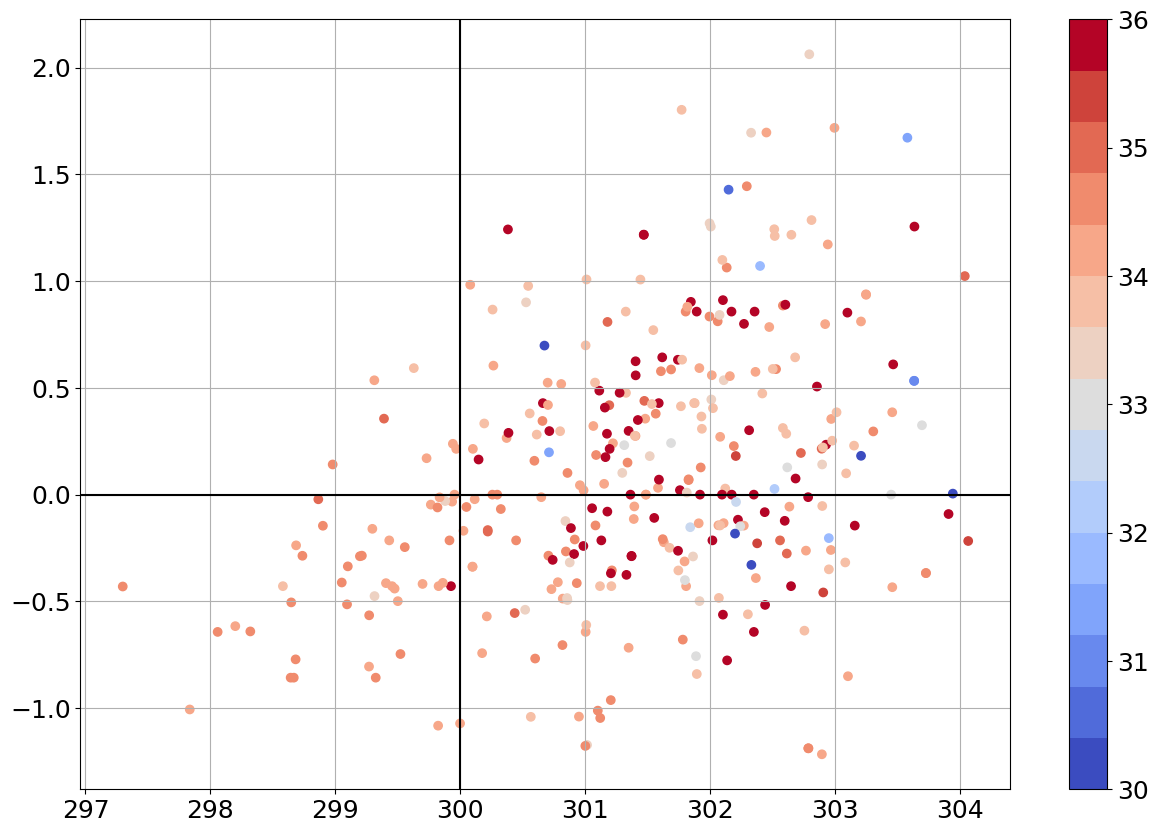

In [6]:
plt.scatter(d.pre_sst_rms, d.vmx_dot_smth_ibt, c=d.pre_sss_rms, vmin=30, vmax=36, cmap=cm.get_cmap('coolwarm', 15))
plt.axhline(0, c='k')
plt.axvline(300, c='k')
plt.grid()
cbar = plt.colorbar()

/tmp/ipykernel_40915/4138186911.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d1.pre_sst_rms, d1.vmx_dot_smth_ibt, c=d1.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))


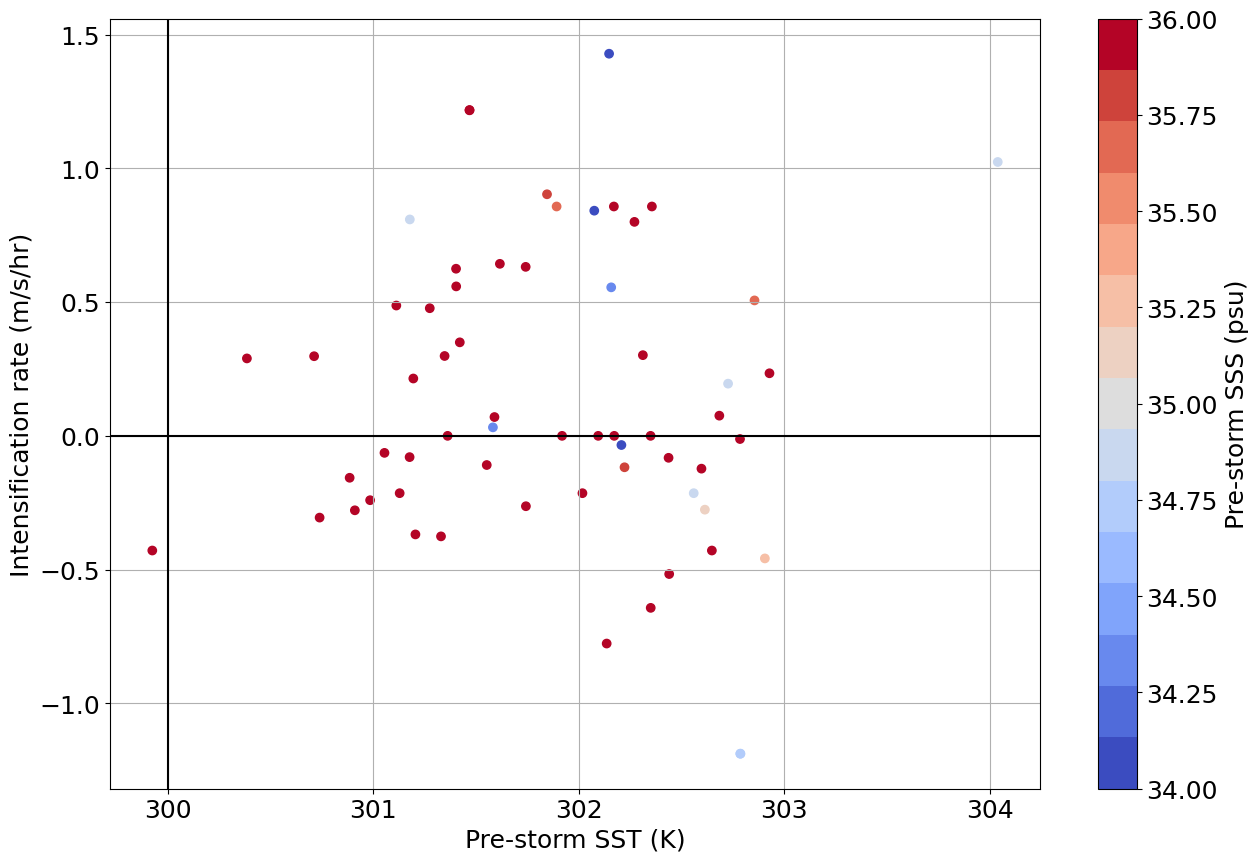

In [7]:
d1 = d.where((d.lon <= -40) & (d.lon >= -90) & (d.lat >= 0) & (d.lat <= 30), drop=True)

plt.scatter(d1.pre_sst_rms, d1.vmx_dot_smth_ibt, c=d1.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))
plt.axhline(0, c='k')
plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('Intensification rate (m/s/hr)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SSS (psu)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/929135545.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d2.pre_sst_rms, d2.vmx_dot_smth_ibt, c=d2.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))


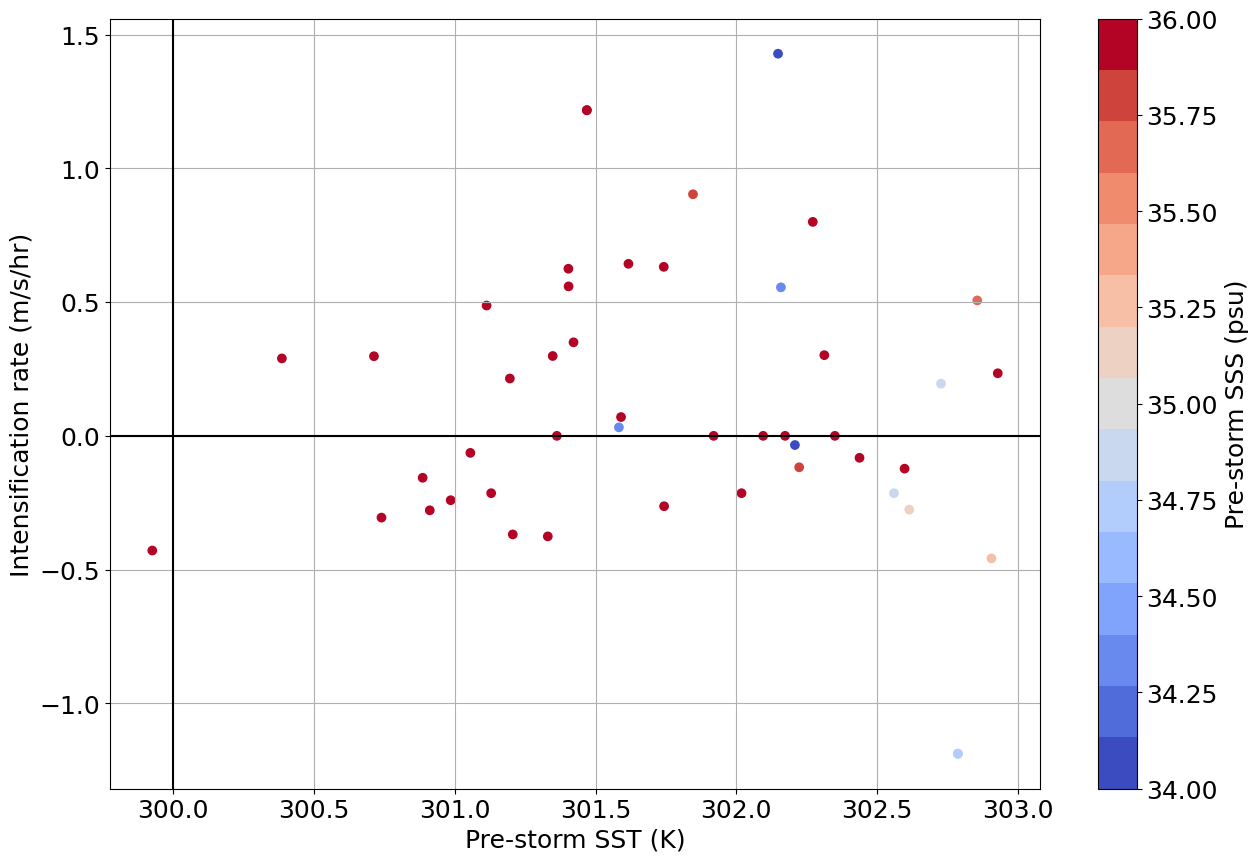

In [12]:
d2 = d.where((d.lon <= -40) & (d.lon >= -70) & (d.lat >= 10) & (d.lat <= 30), drop=True)

plt.scatter(d2.pre_sst_rms, d2.vmx_dot_smth_ibt, c=d2.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))
plt.axhline(0, c='k')
plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('Intensification rate (m/s/hr)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SSS (psu)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/1802563024.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d2.pre_sst_rms, d2.uc, c=d2.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))


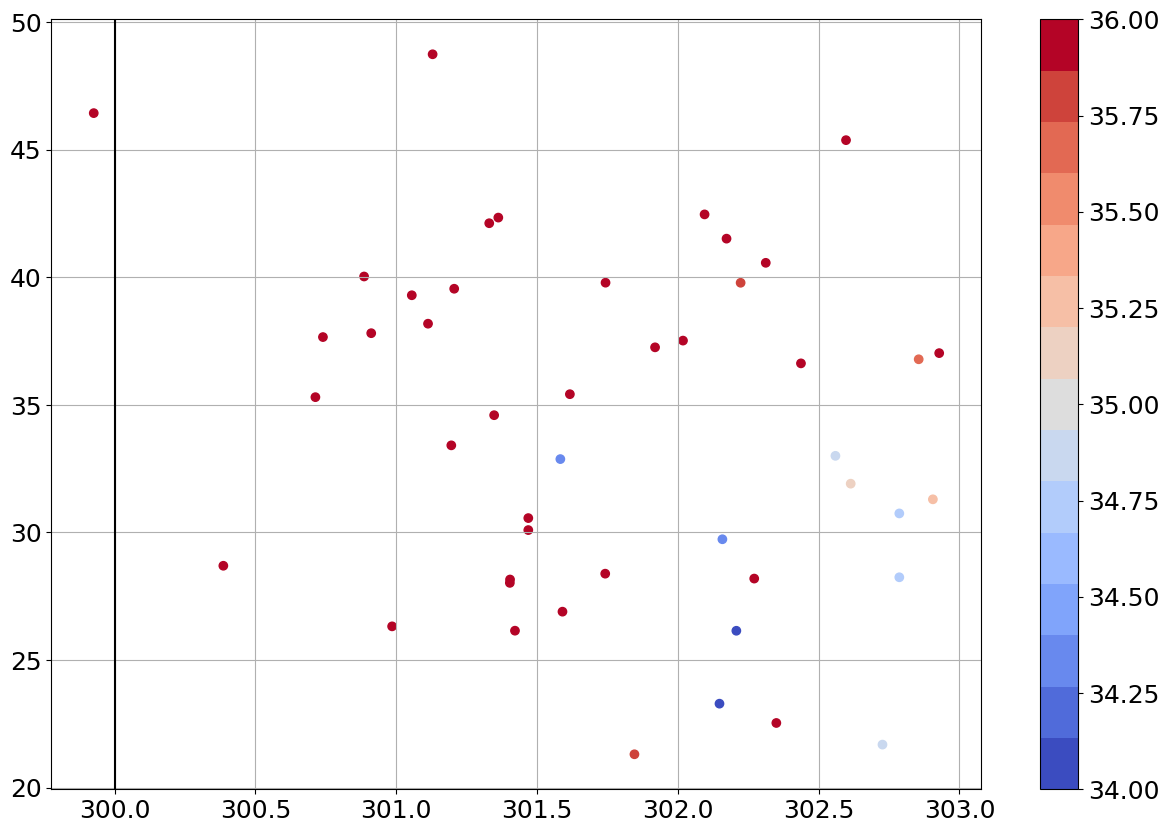

In [9]:
d2 = d.where((d.lon <= -40) & (d.lon >= -70) & (d.lat >= 10) & (d.lat <= 30), drop=True)

plt.scatter(d2.pre_sst_rms, d2.uc, c=d2.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))
# plt.axhline(0, c='k')
plt.axvline(300, c='k')
plt.grid()
plt.colorbar()

/tmp/ipykernel_40915/3670085698.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d2.vmx_dot_smth_ibt, d2.uc, c=d2.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))


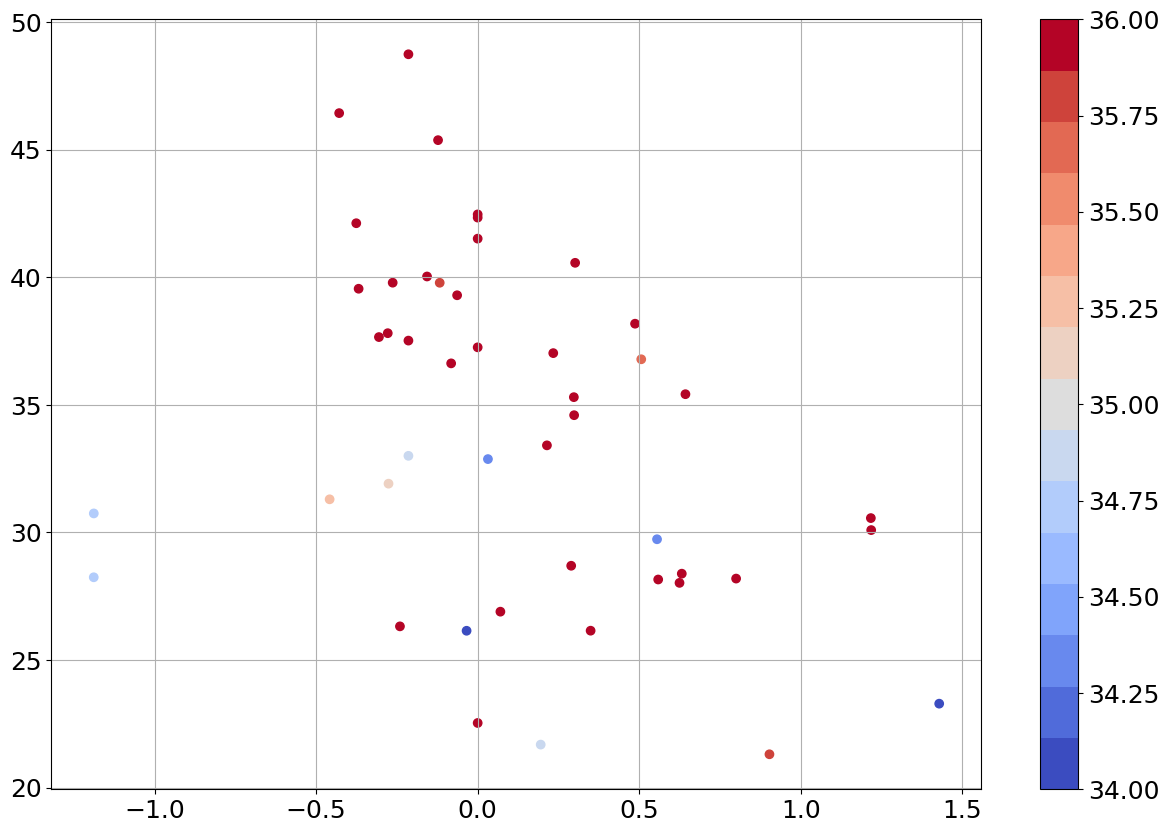

In [13]:
d2 = d.where((d.lon <= -40) & (d.lon >= -70) & (d.lat >= 10) & (d.lat <= 30), drop=True)

plt.scatter(d2.vmx_dot_smth_ibt, d2.uc, c=d2.pre_sss_rms, vmin=34, vmax=36, cmap=cm.get_cmap('coolwarm', 15))
plt.grid()
plt.colorbar()

/tmp/ipykernel_40915/1713602401.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d.pre_sst_rms, d.uc, c=d.pre_sss_rms, vmin=32, vmax=36, cmap=cm.get_cmap('coolwarm', 15))


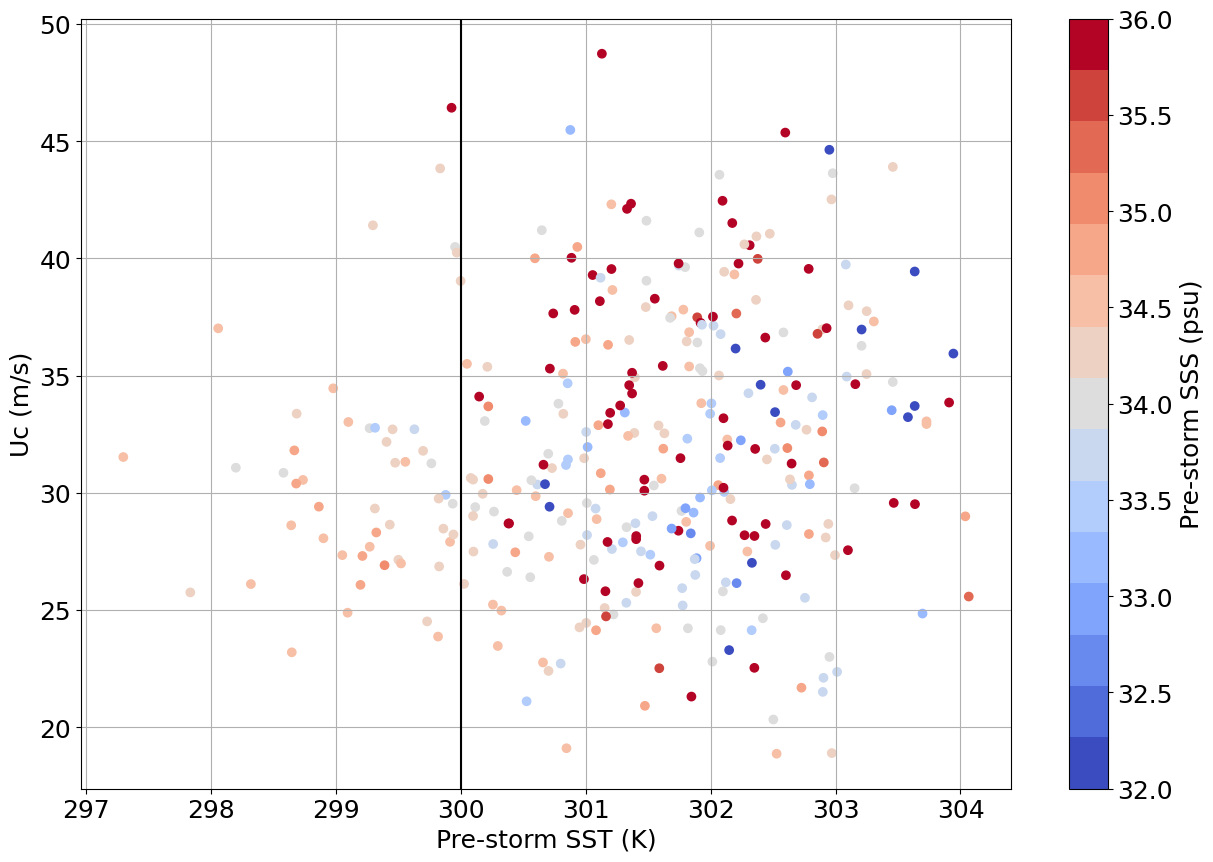

In [14]:
plt.scatter(d.pre_sst_rms, d.uc, c=d.pre_sss_rms, vmin=32, vmax=36, cmap=cm.get_cmap('coolwarm', 15))
# plt.axhline(0, c='k')
plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('Uc (m/s)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SSS (psu)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

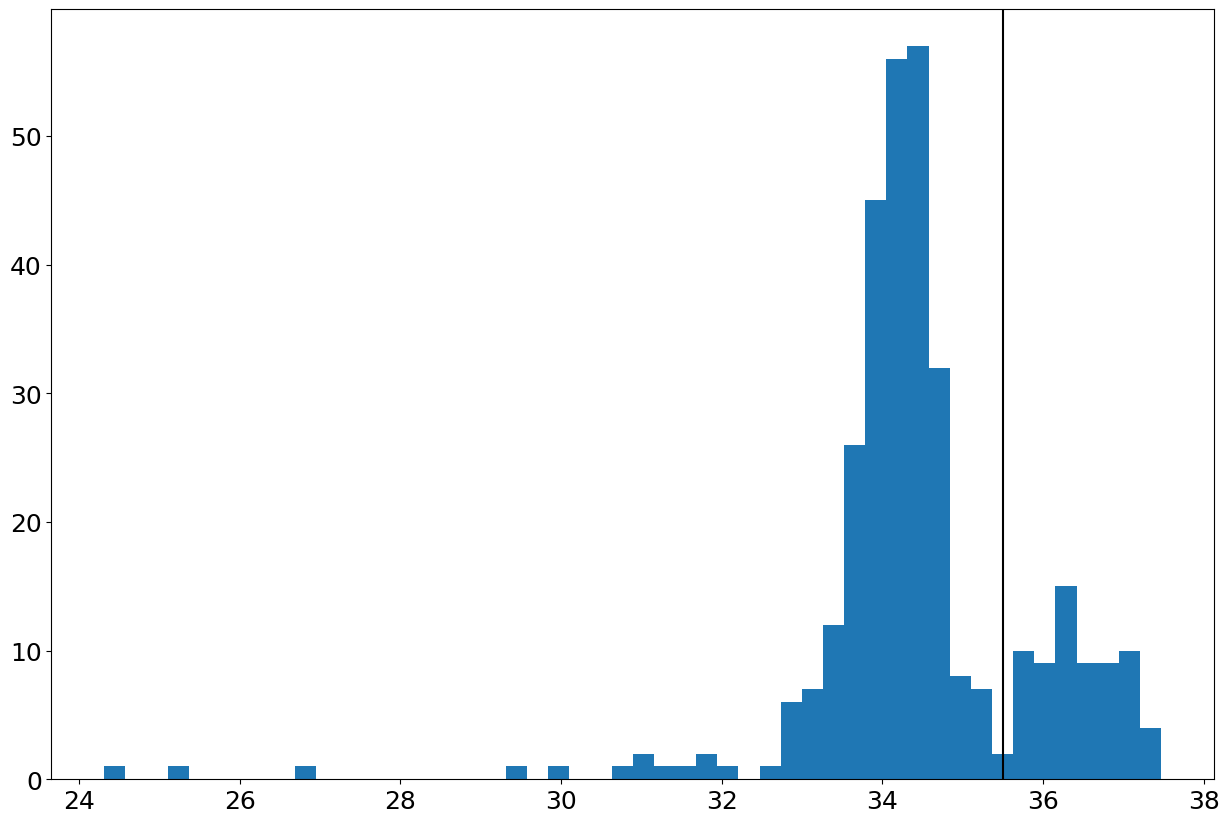

In [15]:
plt.hist(d.pre_sss_rms, bins=50)
plt.axvline(35.5, c='k')

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  4.,  4.,  2.,  4.,
         3., 10.,  4.,  4.,  5.,  6., 11., 10., 12., 10.,  9., 12., 15.,
        18., 16., 24., 18., 20., 12.,  9., 22., 15., 20., 15., 15.,  8.,
        14.,  8., 17.,  7.,  7.,  2.,  5.,  4.,  3.,  1.,  3.]),
 array([297.29827881, 297.43363586, 297.56899292, 297.70434998,
        297.83970703, 297.97506409, 298.11042114, 298.2457782 ,
        298.38113525, 298.51649231, 298.65184937, 298.78720642,
        298.92256348, 299.05792053, 299.19327759, 299.32863464,
        299.4639917 , 299.59934875, 299.73470581, 299.87006287,
        300.00541992, 300.14077698, 300.27613403, 300.41149109,
        300.54684814, 300.6822052 , 300.81756226, 300.95291931,
        301.08827637, 301.22363342, 301.35899048, 301.49434753,
        301.62970459, 301.76506165, 301.9004187 , 302.03577576,
        302.17113281, 302.30648987, 302.44184692, 302.57720398,
        302.71256104, 302.84791809, 302.98327515, 303.1186322 ,
        303.

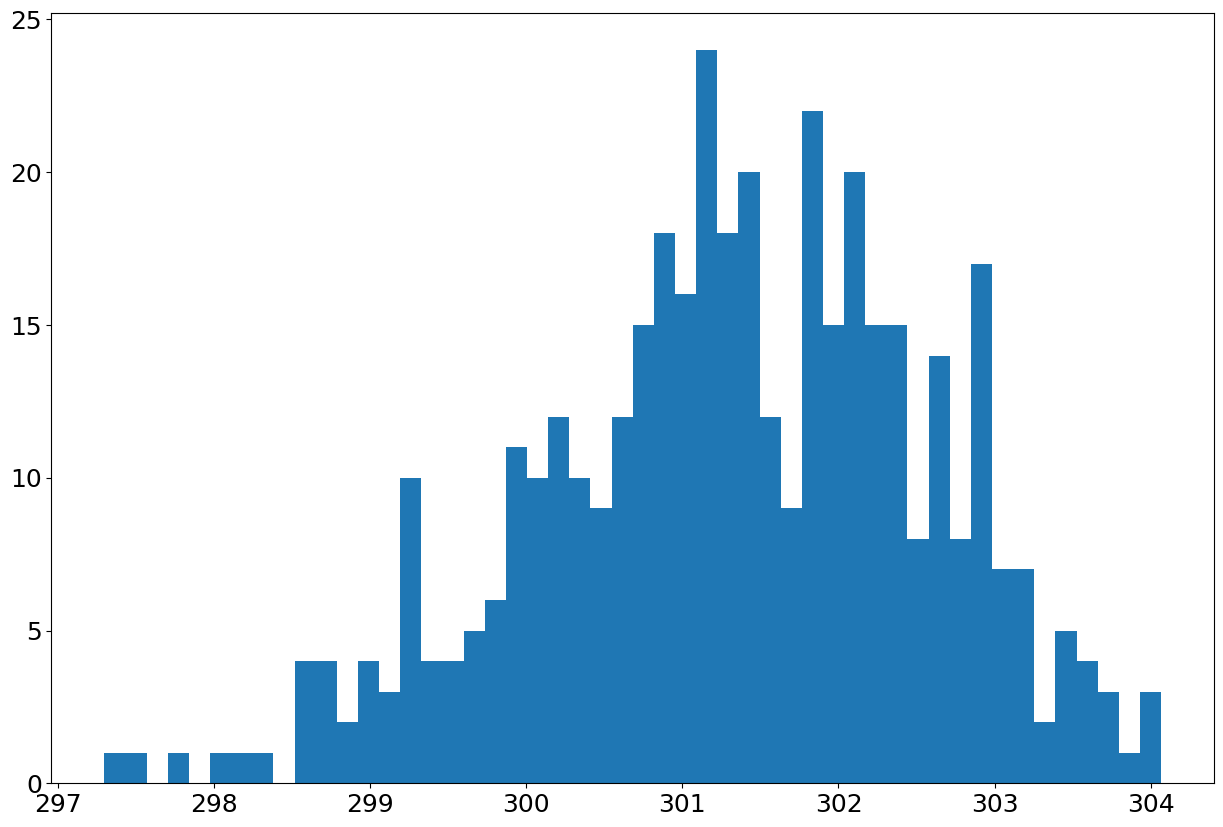

In [16]:
plt.hist(d.pre_sst_rms, bins=50)

(array([ 5., 13., 13., 20., 13.,  8., 17., 45., 69., 47., 43., 15.,  6.,
         6.,  0.,  1.,  2.,  1.,  1.,  0.,  3.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 8.02365868,  8.11186764,  8.2000766 ,  8.28828555,  8.37649451,
         8.46470346,  8.55291242,  8.64112138,  8.72933033,  8.81753929,
         8.90574825,  8.9939572 ,  9.08216616,  9.17037512,  9.25858407,
         9.34679303,  9.43500198,  9.52321094,  9.6114199 ,  9.69962885,
         9.78783781,  9.87604677,  9.96425572, 10.05246468, 10.14067363,
        10.22888259, 10.31709155, 10.4053005 , 10.49350946, 10.58171842,
        10.66992737, 10.75813633, 10.84634528, 10.93455424, 11.0227632 ,
        11.11097215, 11.19918111, 11.28739007, 11.37559902, 11.46380798,
        11.55201694, 11.64022589, 11.72843485, 11.8166438 , 11.90485276,
        11.99306172, 12.08127067, 12.16947963, 12.25768859,

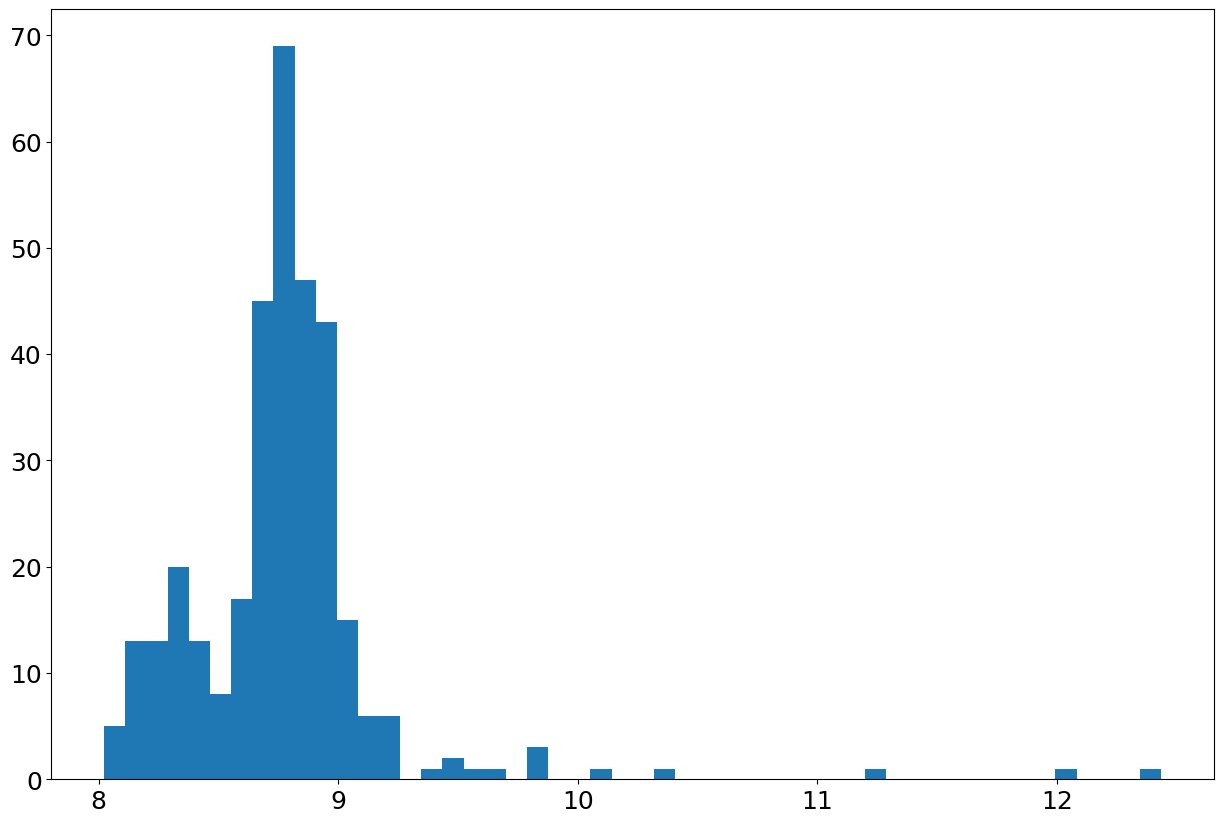

In [17]:
plt.hist(d.pre_sst_rms / d.pre_sss_rms, bins=50)

/tmp/ipykernel_40915/45046810.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(d.lat), d.uc, c=d.pre_sst_rms / d.pre_sss_rms, vmin=8.5, vmax=9, cmap=cm.get_cmap('coolwarm', 15))


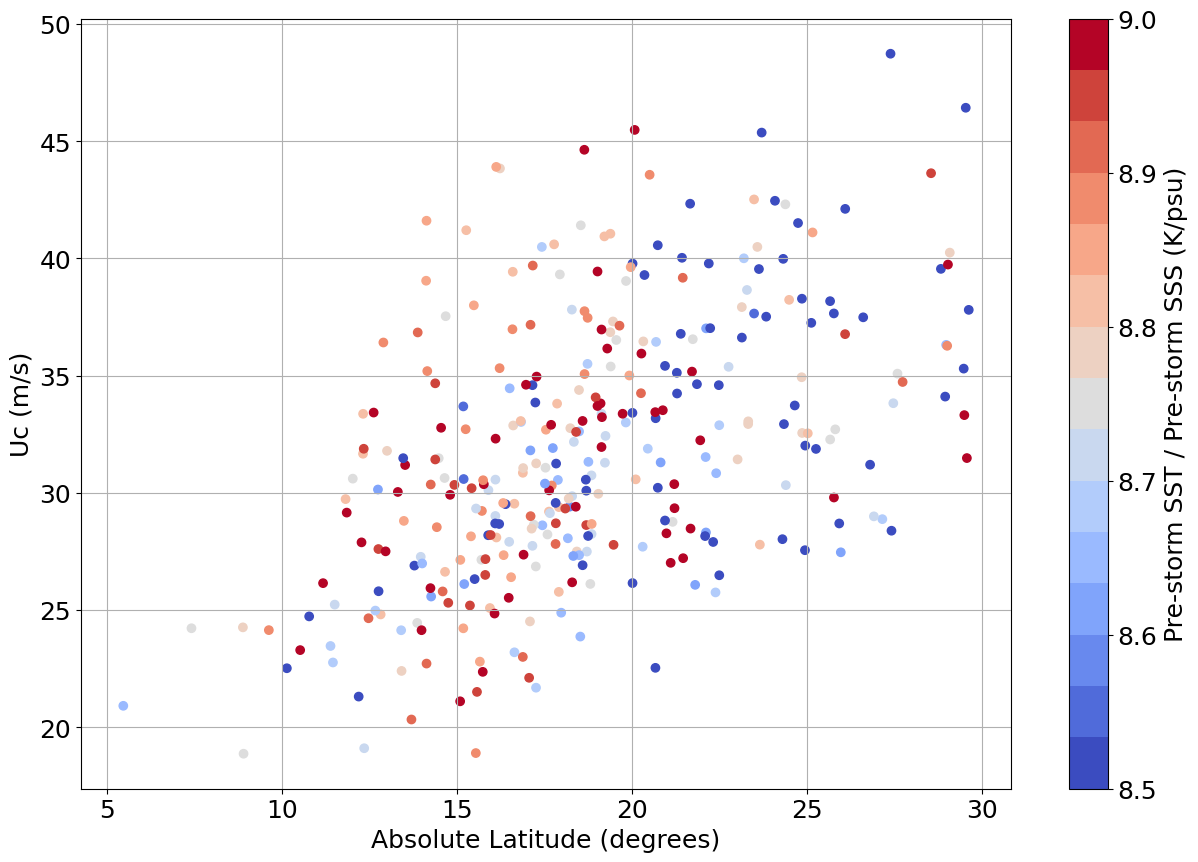

In [19]:
plt.scatter(abs(d.lat), d.uc, c=d.pre_sst_rms / d.pre_sss_rms, vmin=8.5, vmax=9, cmap=cm.get_cmap('coolwarm', 15))
# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('Uc (m/s)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST / Pre-storm SSS (K/psu)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/299680709.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(d.lat),     d.uc,     c=d.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/299680709.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(d_tck.lat), d_tck.uc, c=d_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


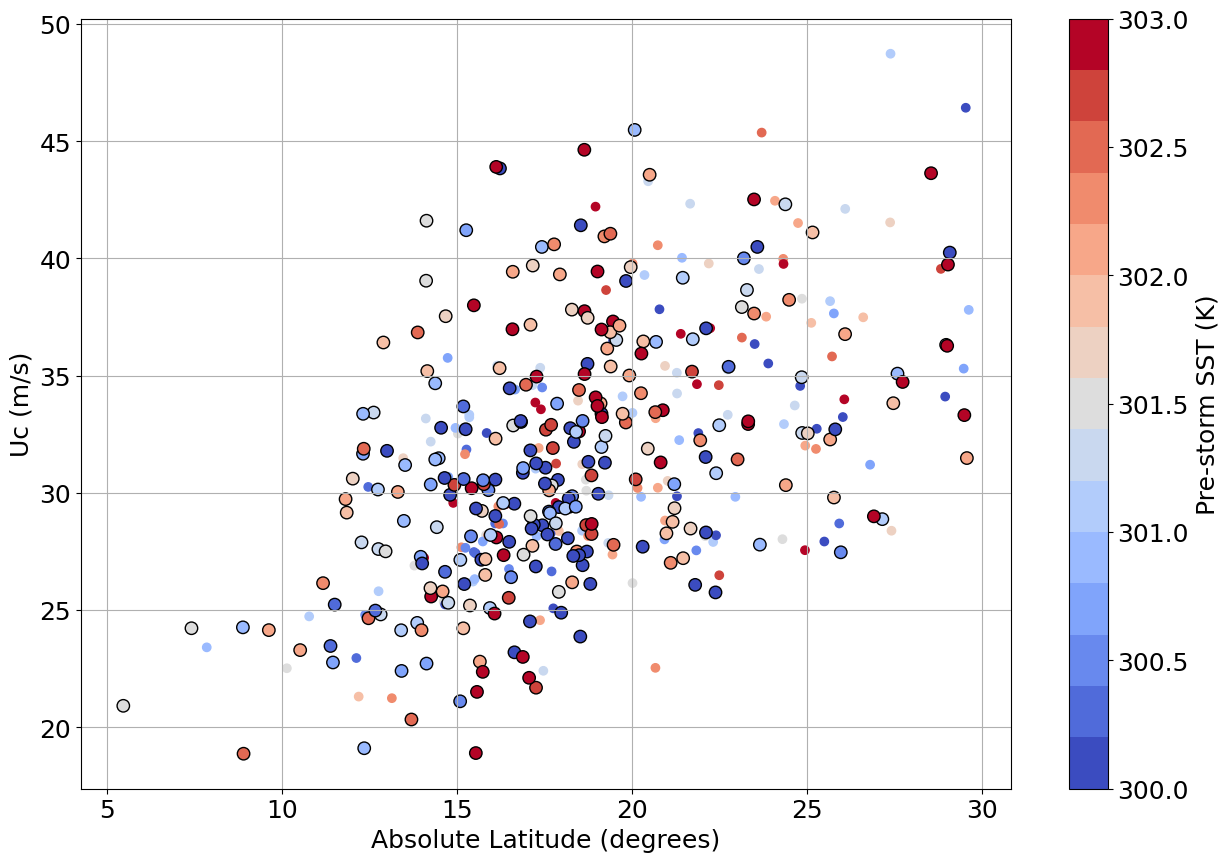

In [20]:
d_tck = d.where(d.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(d.lat),     d.uc,     c=d.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(d_tck.lat), d_tck.uc, c=d_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('Uc (m/s)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/71077343.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(da.lat),     da.uc,     c=da.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/71077343.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(da_tck.lat), da_tck.uc, c=da_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


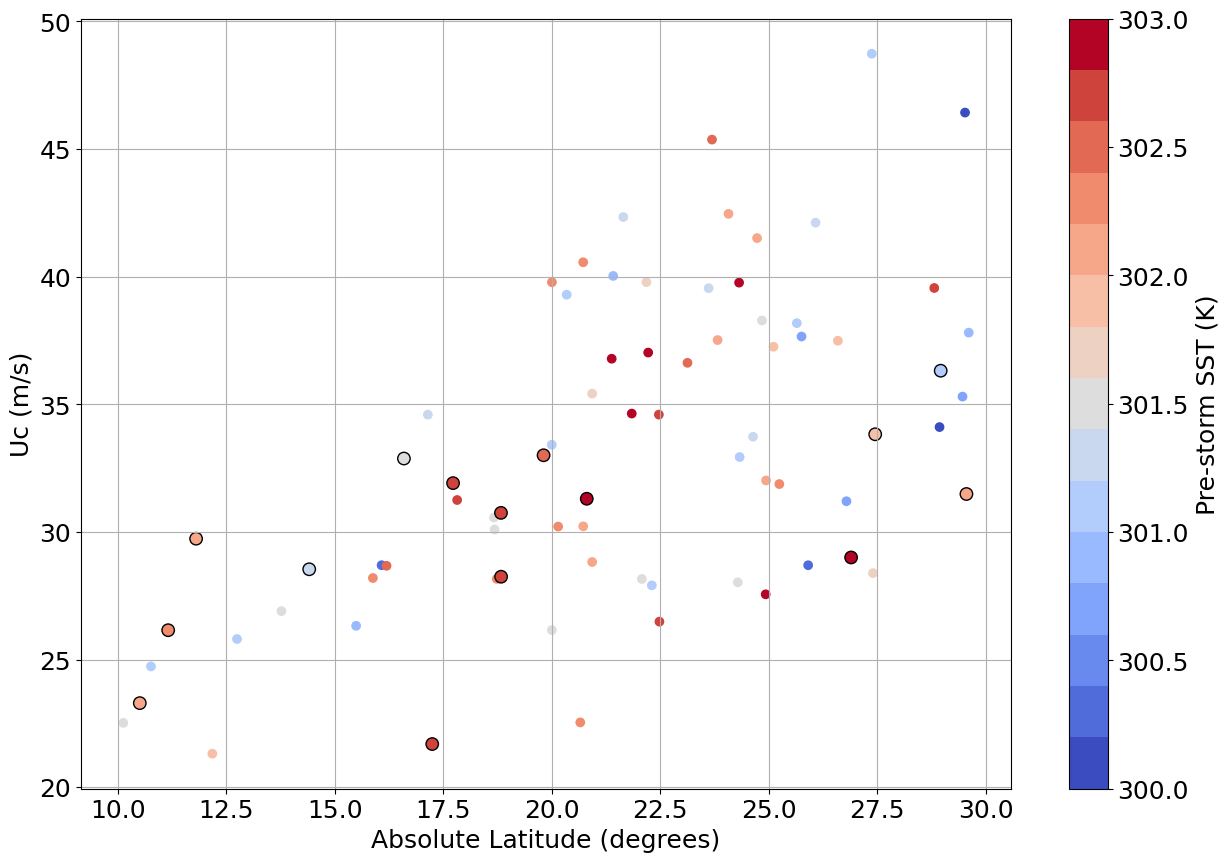

In [21]:
### INTERESTING RESULT
da = d.where(d.basin == 'al', drop=True)

da_tck = da.where(da.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(da.lat),     da.uc,     c=da.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(da_tck.lat), da_tck.uc, c=da_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('Uc (m/s)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/2616998983.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(dm.lat),     dm.uc,     c=dm.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/2616998983.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(dm_tck.lat), dm_tck.uc, c=dm_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


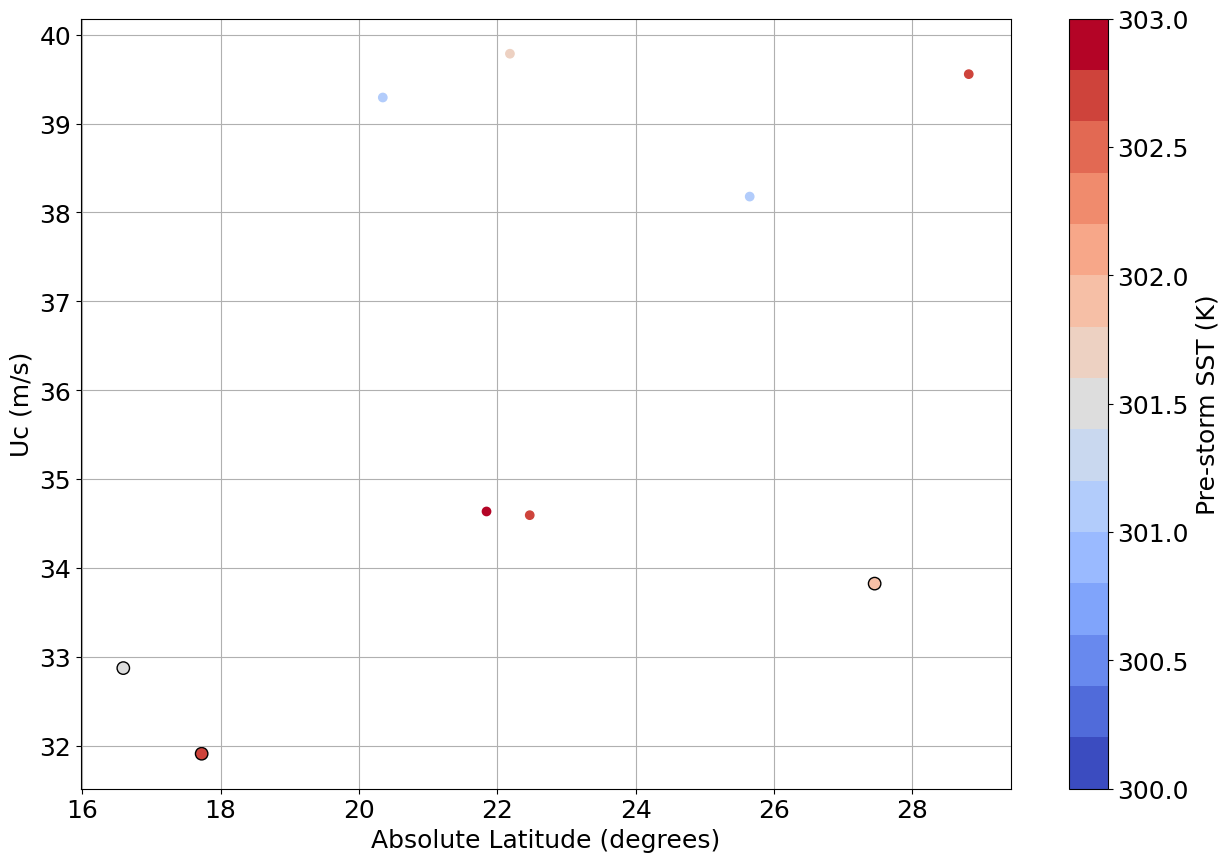

In [22]:
dm = da.where((da.t_since_lmi_ibt >= -3 * 3600) & (da.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(dm.lat),     dm.uc,     c=dm.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(dm_tck.lat), dm_tck.uc, c=dm_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('Uc (m/s)')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/3161666816.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(da.lat),     da.B_hol,     c=da.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/3161666816.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(da_tck.lat), da_tck.B_hol, c=da_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


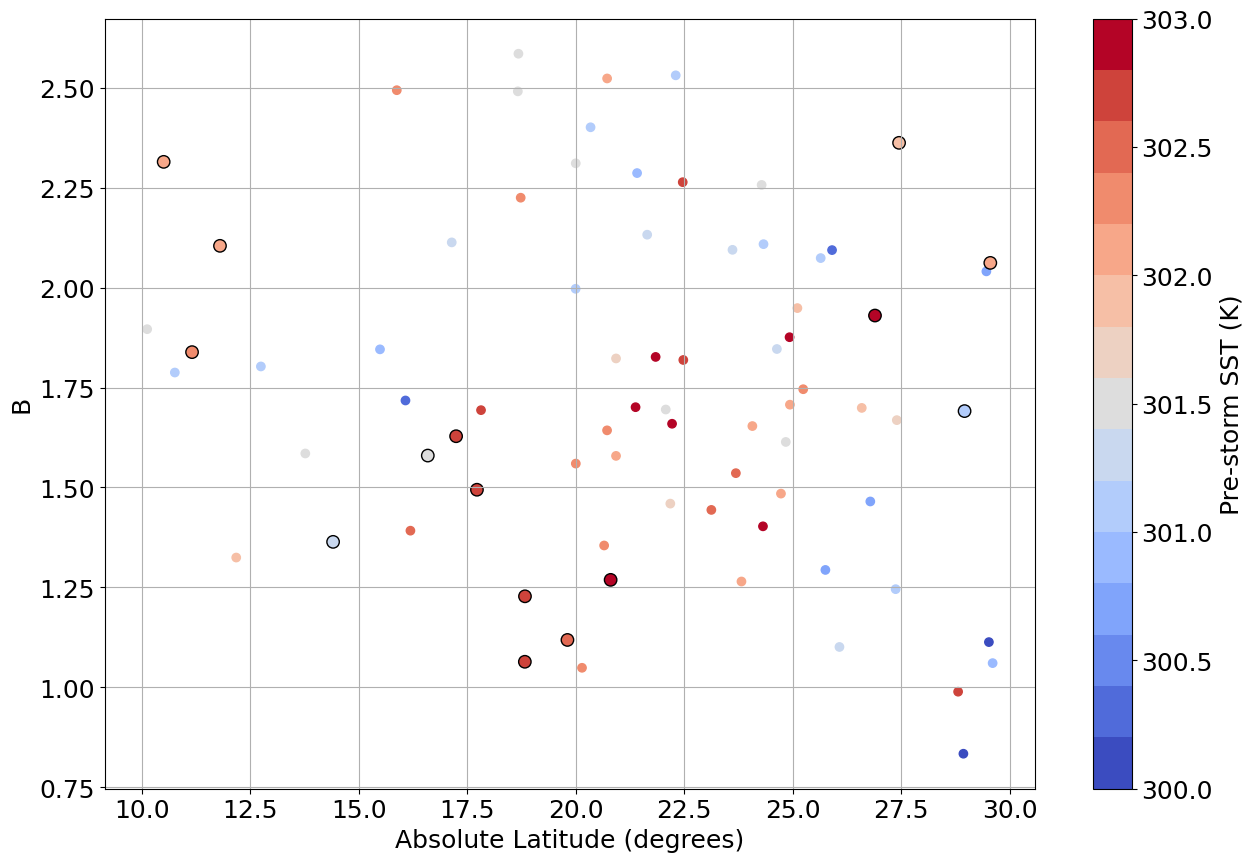

In [34]:
### TEST
da = d.where(d.basin == 'al', drop=True)

da_tck = da.where(da.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(da.lat),     da.B_hol,     c=da.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(da_tck.lat), da_tck.B_hol, c=da_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/1875911563.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(de.lat),     de.B_hol,     c=de.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/1875911563.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(de_tck.lat), de_tck.B_hol, c=de_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


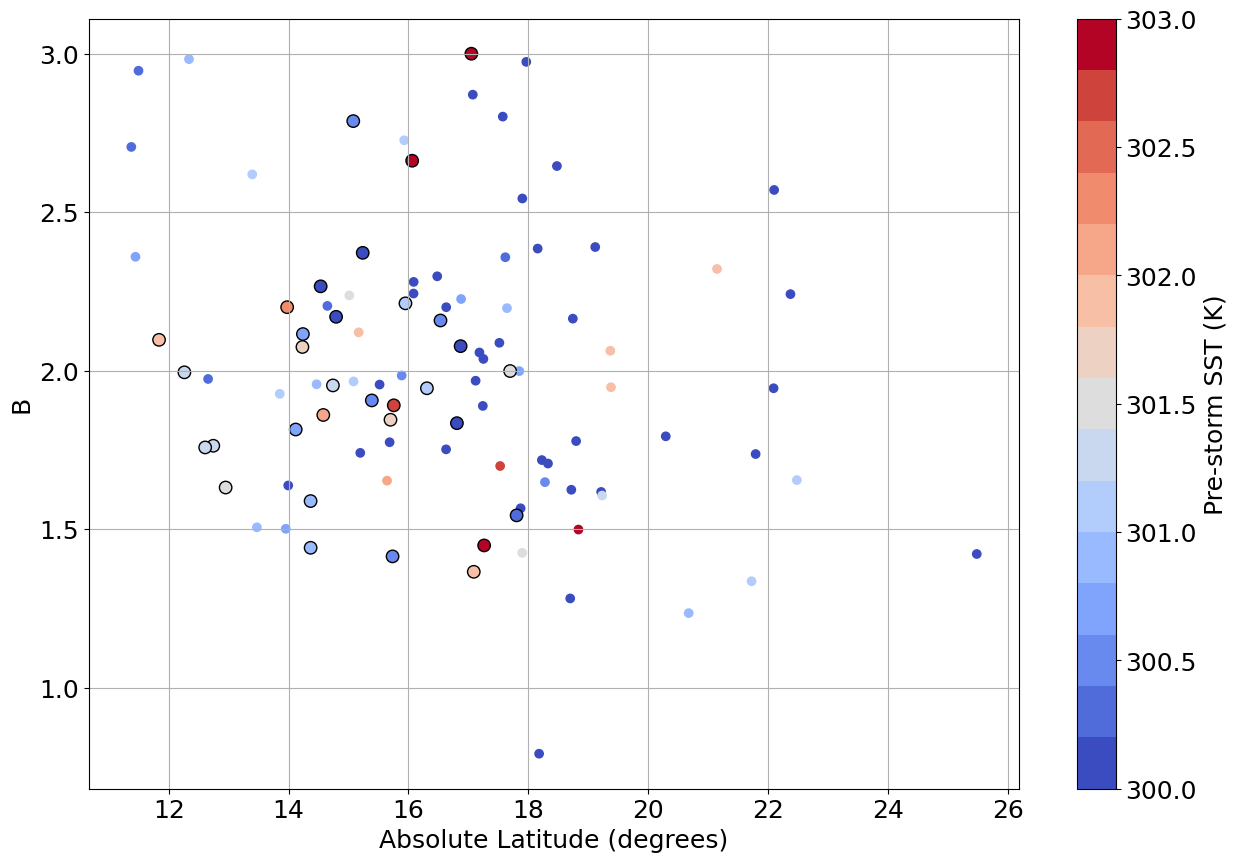

In [44]:
### TEST
de = d.where(d.basin == 'ep', drop=True)

de_tck = de.where(de.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(abs(de.lat),     de.B_hol,     c=de.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(de_tck.lat), de_tck.B_hol, c=de_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

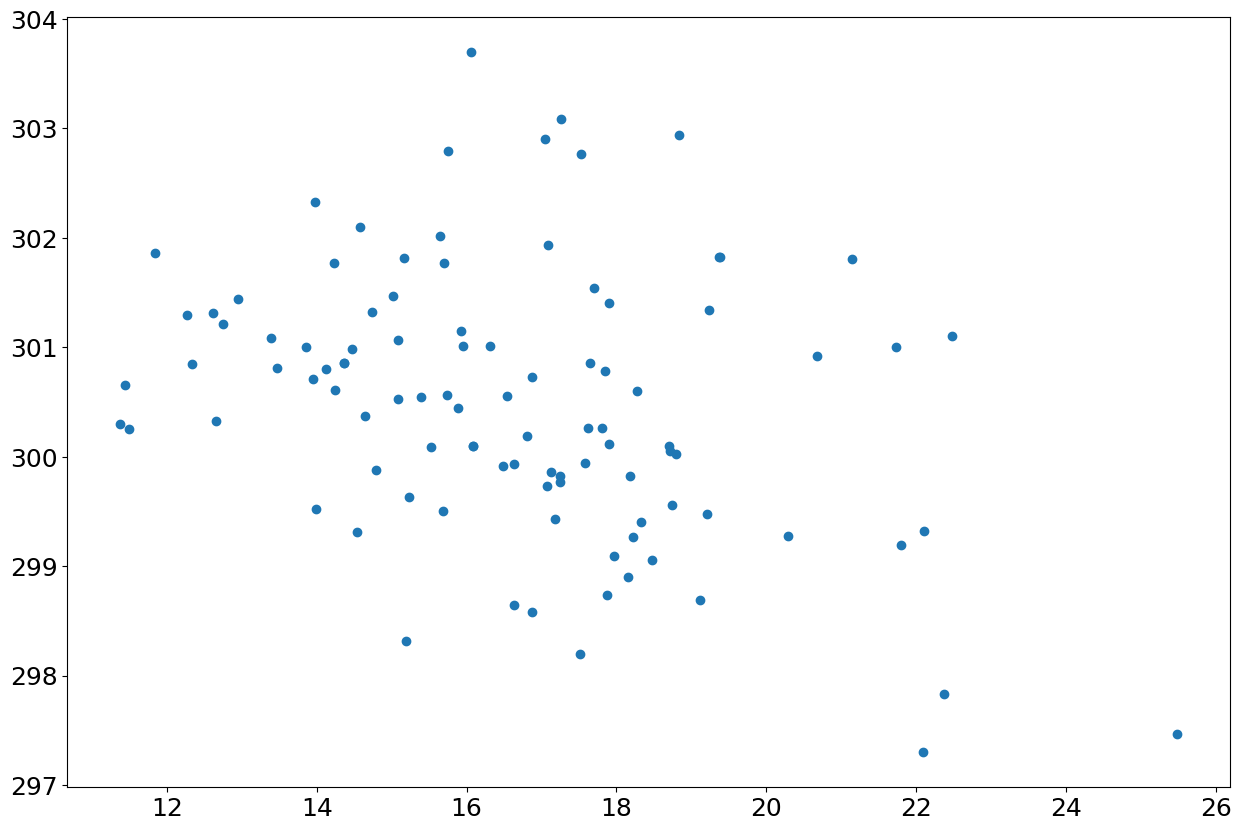

In [36]:
plt.scatter(de.lat, de.sst_rms)

/tmp/ipykernel_40915/2568430358.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(dw.lat),     dw.B_hol,     c=dw.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/2568430358.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(dw_tck.lat), dw_tck.B_hol, c=dw_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


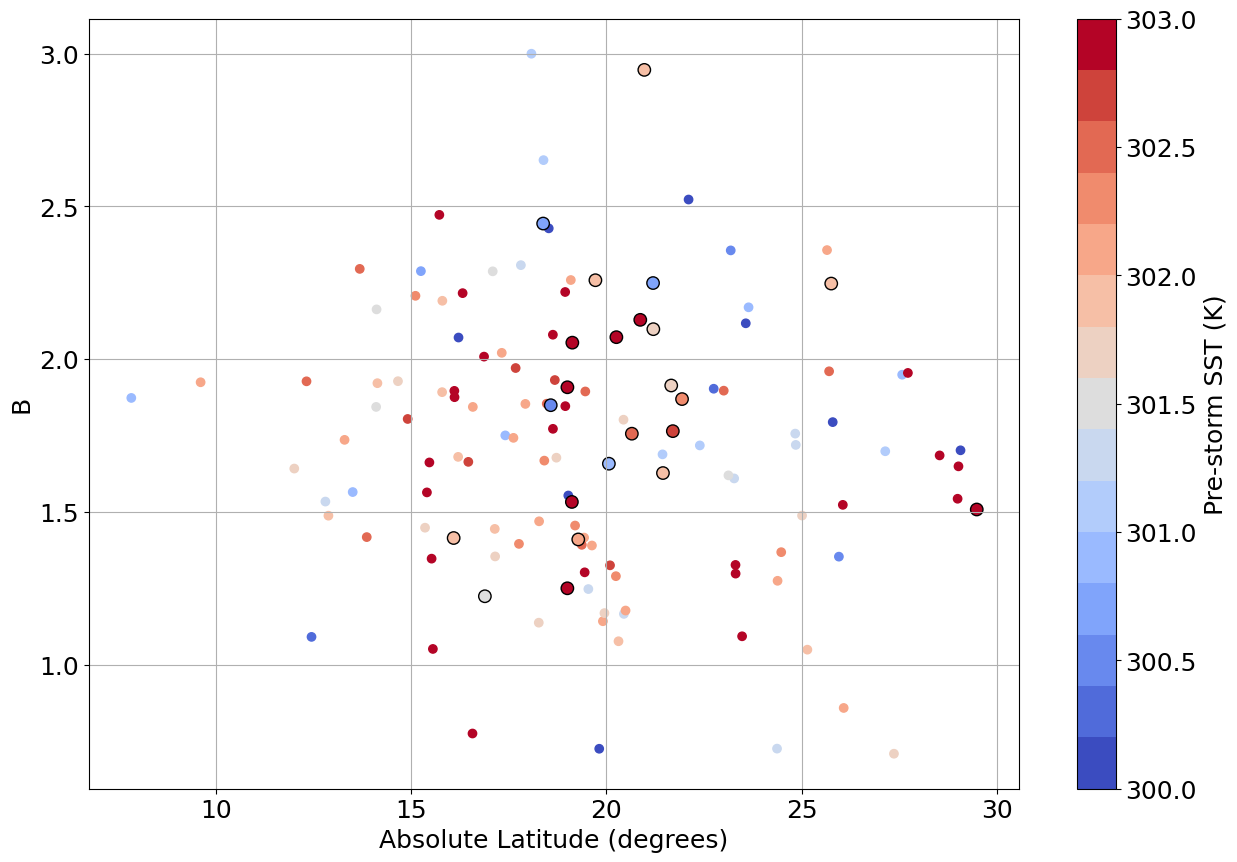

In [46]:
### TEST
dw = d.where(d.basin == 'wp', drop=True)

dw_tck = dw.where(dw.pre_sss_rms <= 33.5, drop=True) # Thick barrier layer

plt.scatter(abs(dw.lat),     dw.B_hol,     c=dw.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(dw_tck.lat), dw_tck.B_hol, c=dw_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/1538475369.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(ds.lat),     ds.B_hol,     c=ds.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/1538475369.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(ds_tck.lat), ds_tck.B_hol, c=ds_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


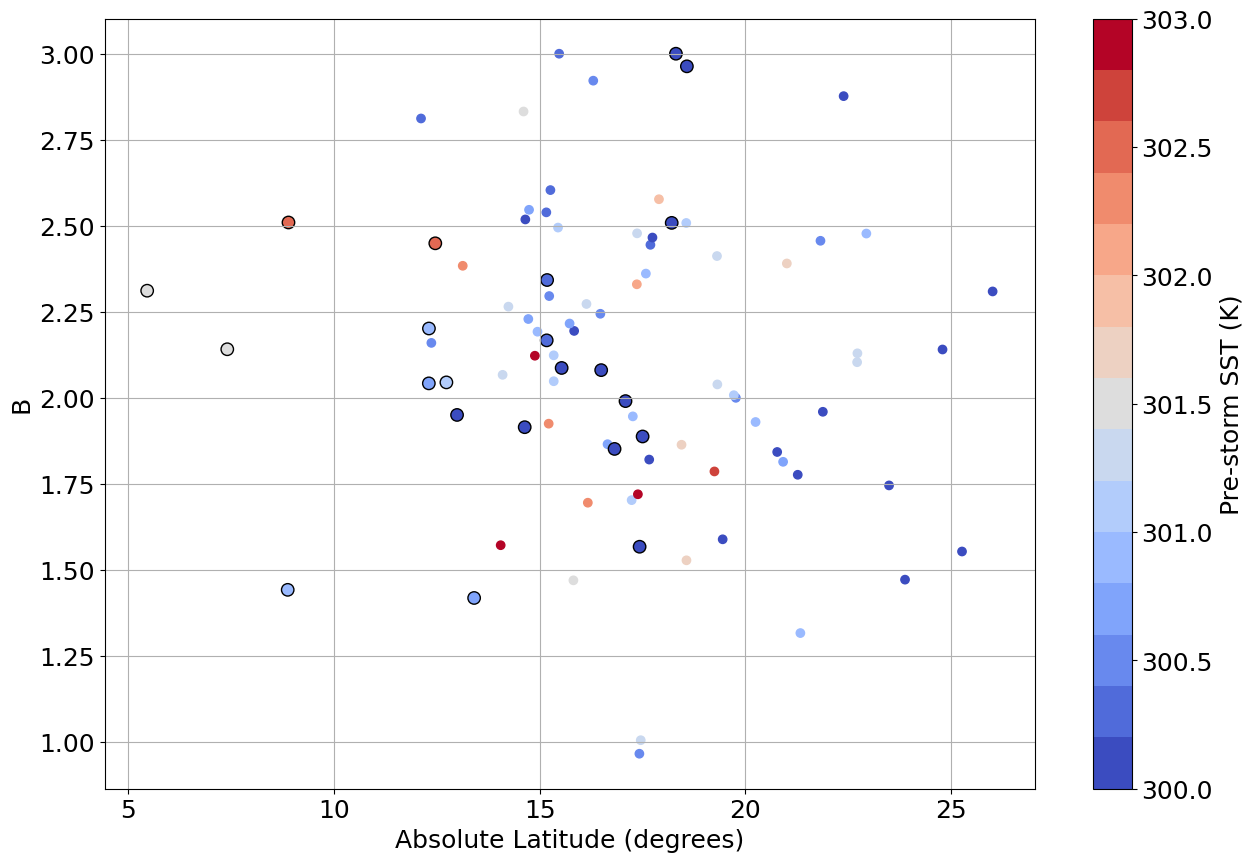

In [47]:
### TEST
ds = d.where(d.basin == 'sh', drop=True)

ds_tck = ds.where(ds.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(ds.lat),     ds.B_hol,     c=ds.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(ds_tck.lat), ds_tck.B_hol, c=ds_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/255475043.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(dm.lat),     dm.B_hol,     c=dm.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/255475043.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(dm_tck.lat), dm_tck.B_hol, c=dm_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


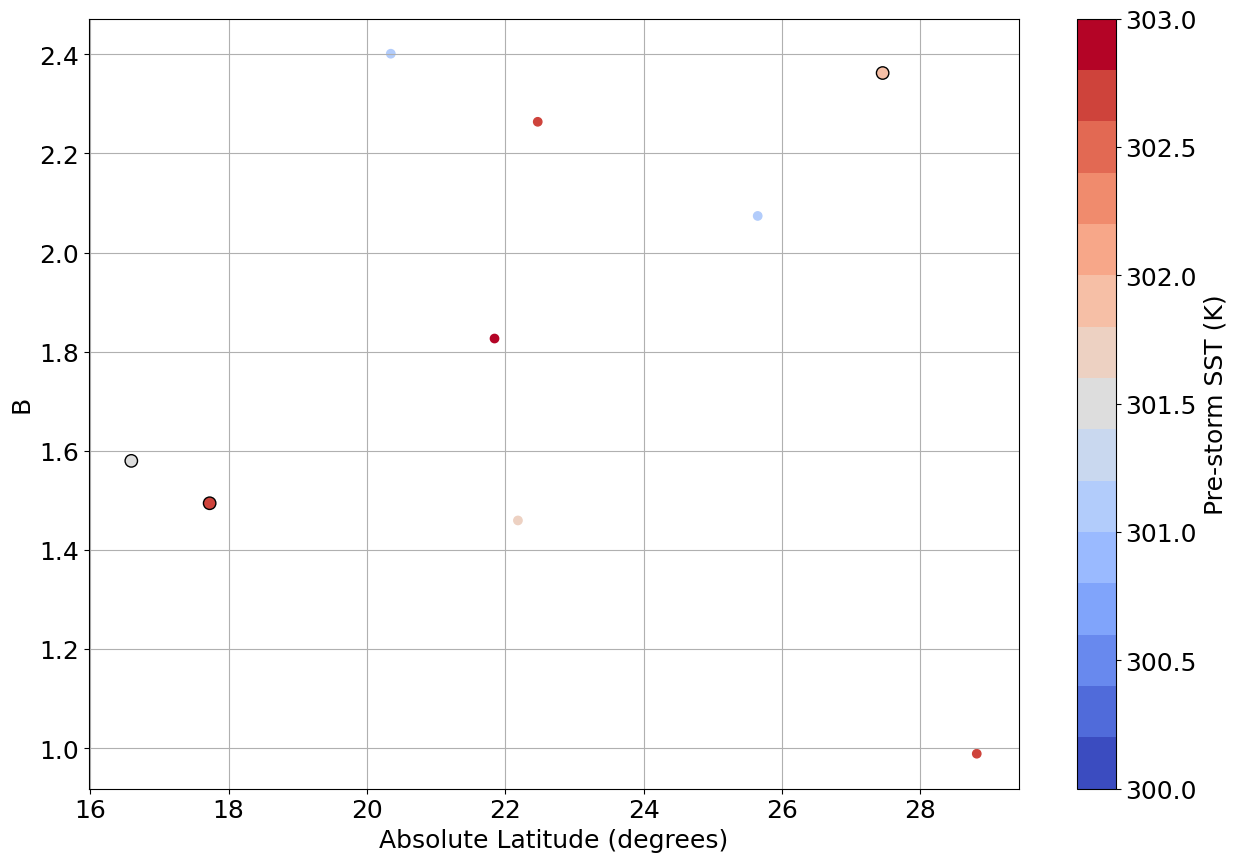

In [39]:
### TEST

dm = da.where((da.t_since_lmi_ibt >= -3 * 3600) & (da.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(dm.lat),     dm.B_hol,     c=dm.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(dm_tck.lat), dm_tck.B_hol, c=dm_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/215449773.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(da.lat),     da.dKdt,     c=da.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
/tmp/ipykernel_40915/215449773.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(abs(da_tck.lat), da_tck.dKdt, c=da_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)


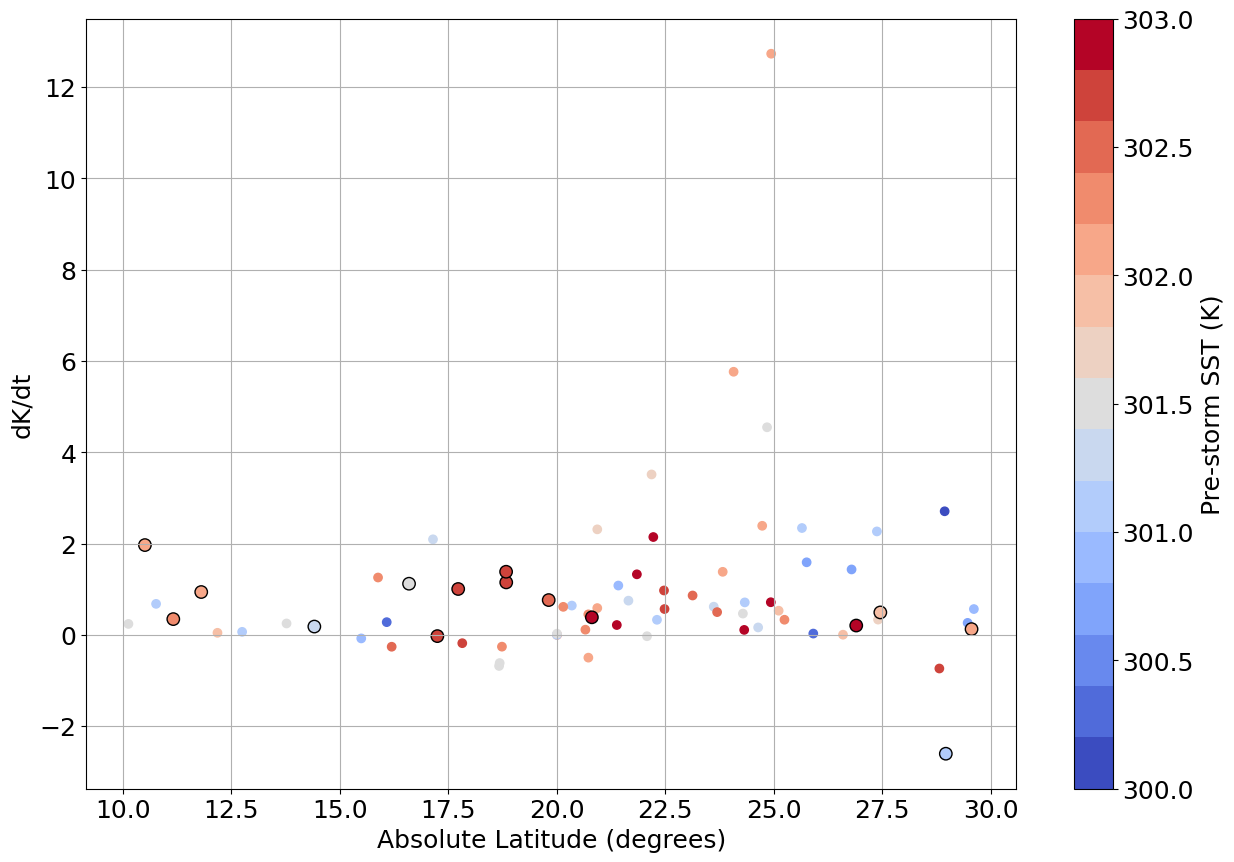

In [40]:
### TEST
da = d.where(d.basin == 'al', drop=True)

da_tck = da.where(da.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(abs(da.lat),     da.dKdt,     c=da.pre_sst_rms,     vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15))
plt.scatter(abs(da_tck.lat), da_tck.dKdt, c=da_tck.pre_sst_rms, edgecolors='k', vmin=300, vmax=303, cmap=cm.get_cmap('coolwarm', 15), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Absolute Latitude (degrees)')
plt.ylabel('dK/dt')

cbar = plt.colorbar()
cbar.set_label(r'Pre-storm SST (K)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/1200039144.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(da.pre_sst_rms,     da.B_hol,     c=abs(da.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/1200039144.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(da_tck.pre_sst_rms, da_tck.B_hol, c=abs(da_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


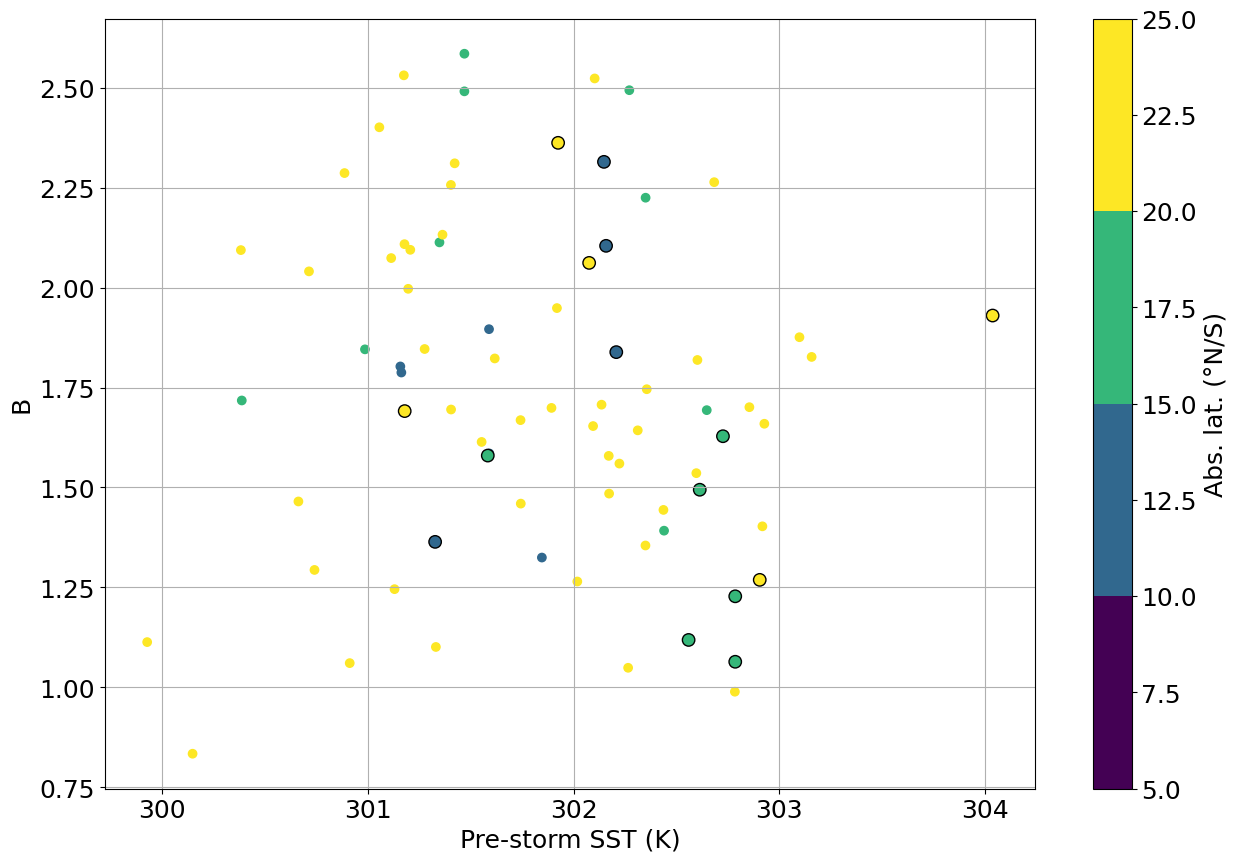

In [61]:
### TEST
da = d.where(d.basin == 'al', drop=True)

da_tck = da.where(da.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(da.pre_sst_rms,     da.B_hol,     c=abs(da.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(da_tck.pre_sst_rms, da_tck.B_hol, c=abs(da_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/4069511097.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/4069511097.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


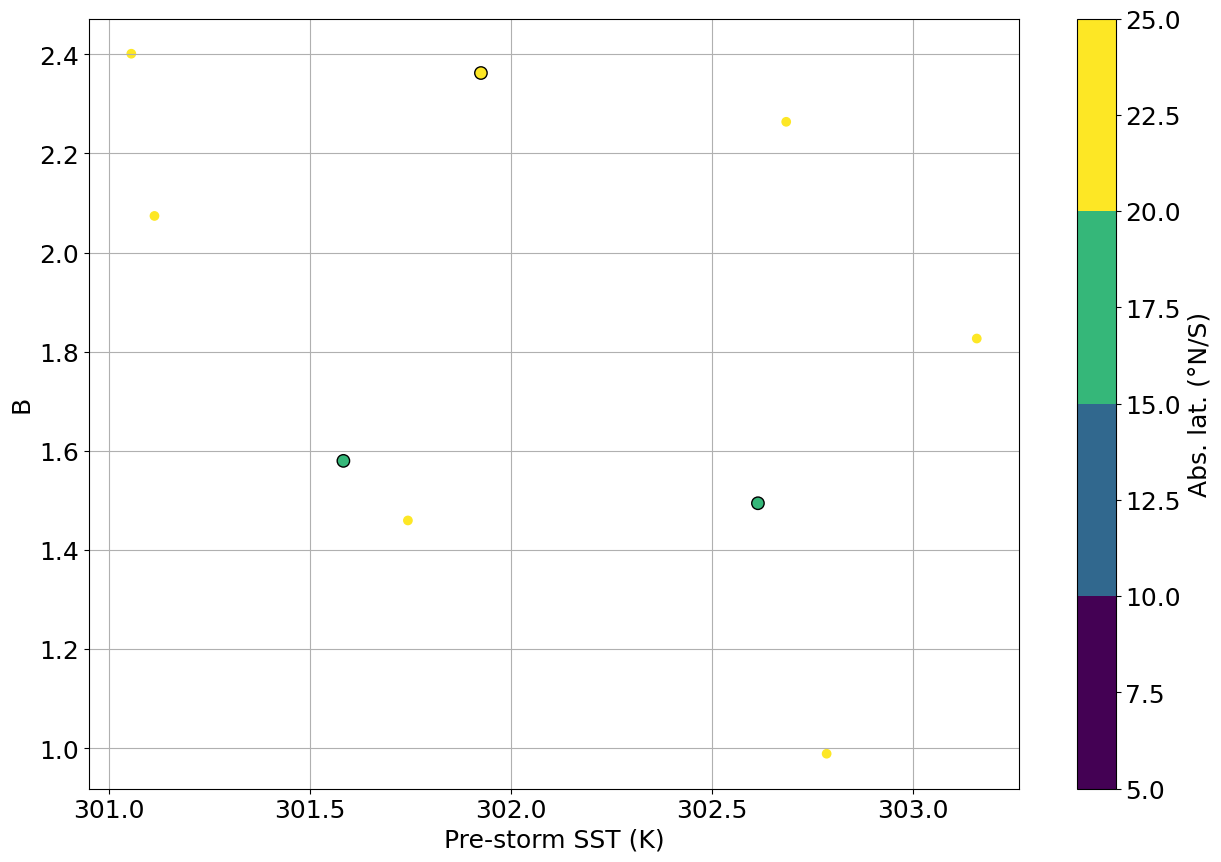

In [80]:
### TEST

dm = da.where((da.t_since_lmi_ibt >= -3 * 3600) & (da.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/2590897086.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(de.pre_sst_rms,     de.B_hol,     c=abs(de.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/2590897086.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(de_tck.pre_sst_rms, de_tck.B_hol, c=abs(de_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


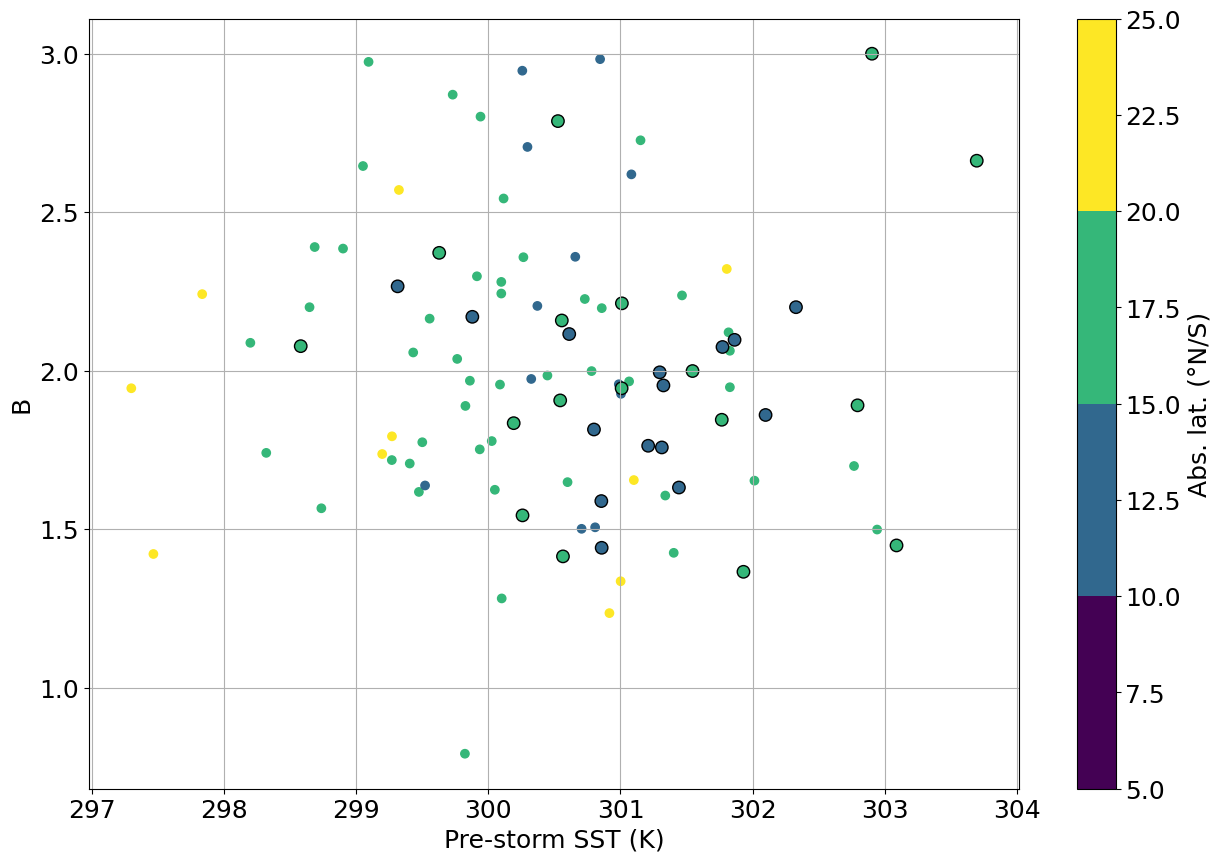

In [81]:
### TEST
de = d.where(d.basin == 'ep', drop=True)

de_tck = de.where(de.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(de.pre_sst_rms,     de.B_hol,     c=abs(de.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(de_tck.pre_sst_rms, de_tck.B_hol, c=abs(de_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/2562640487.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/2562640487.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


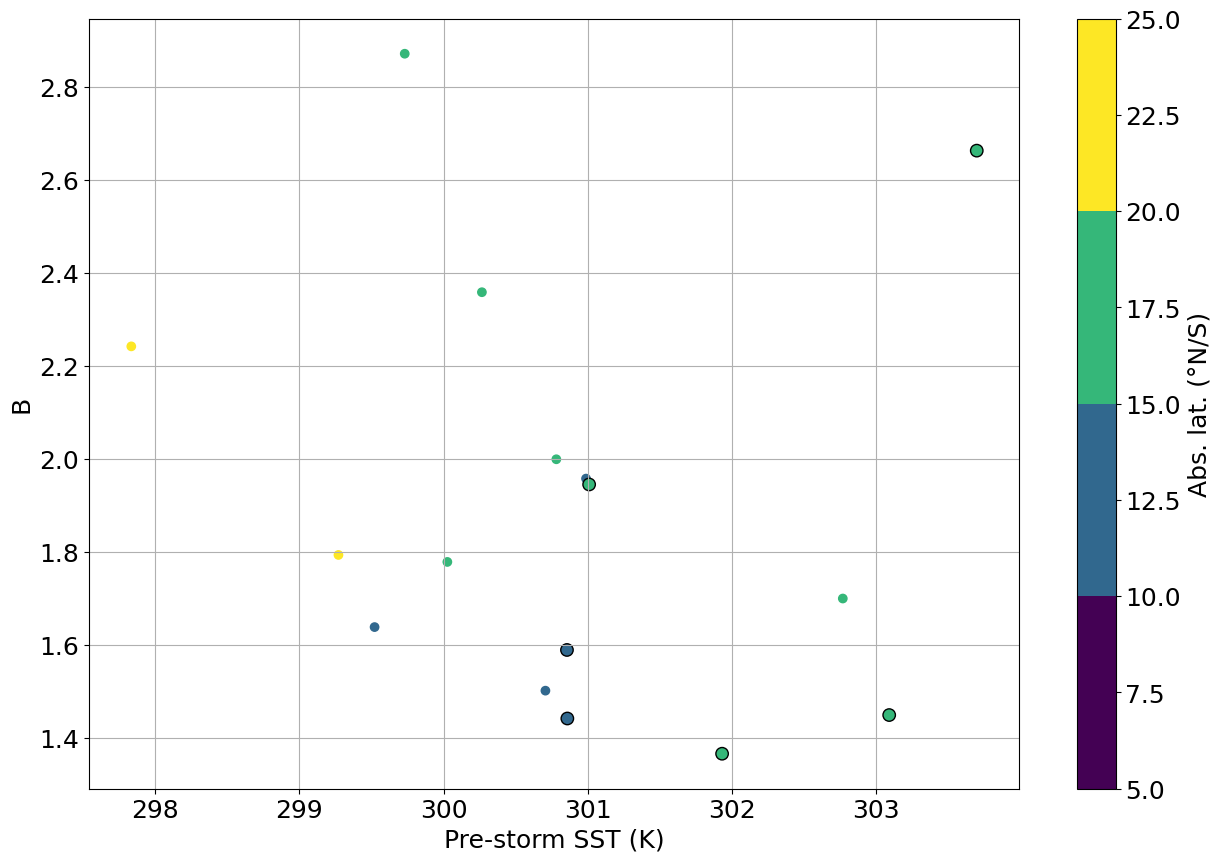

In [82]:
### TEST

dm = de.where((de.t_since_lmi_ibt >= -3 * 3600) & (de.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/200166555.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dw.pre_sst_rms,     dw.B_hol,     c=abs(dw.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/200166555.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dw_tck.pre_sst_rms, dw_tck.B_hol, c=abs(dw_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


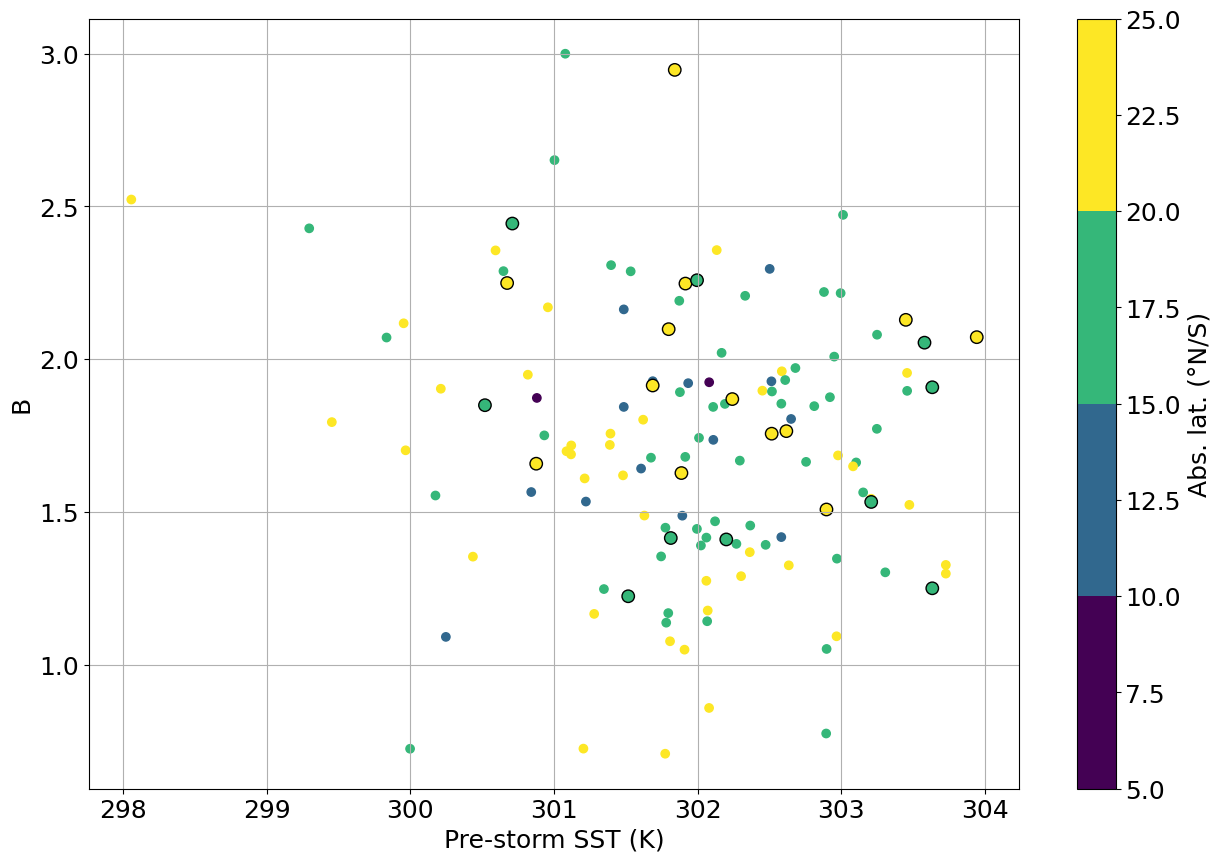

In [83]:
### TEST
dw = d.where(d.basin == 'wp', drop=True)

dw_tck = dw.where(dw.pre_sss_rms <= 33.5, drop=True) # Thick barrier layer

plt.scatter(dw.pre_sst_rms,     dw.B_hol,     c=abs(dw.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dw_tck.pre_sst_rms, dw_tck.B_hol, c=abs(dw_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/82738186.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/82738186.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


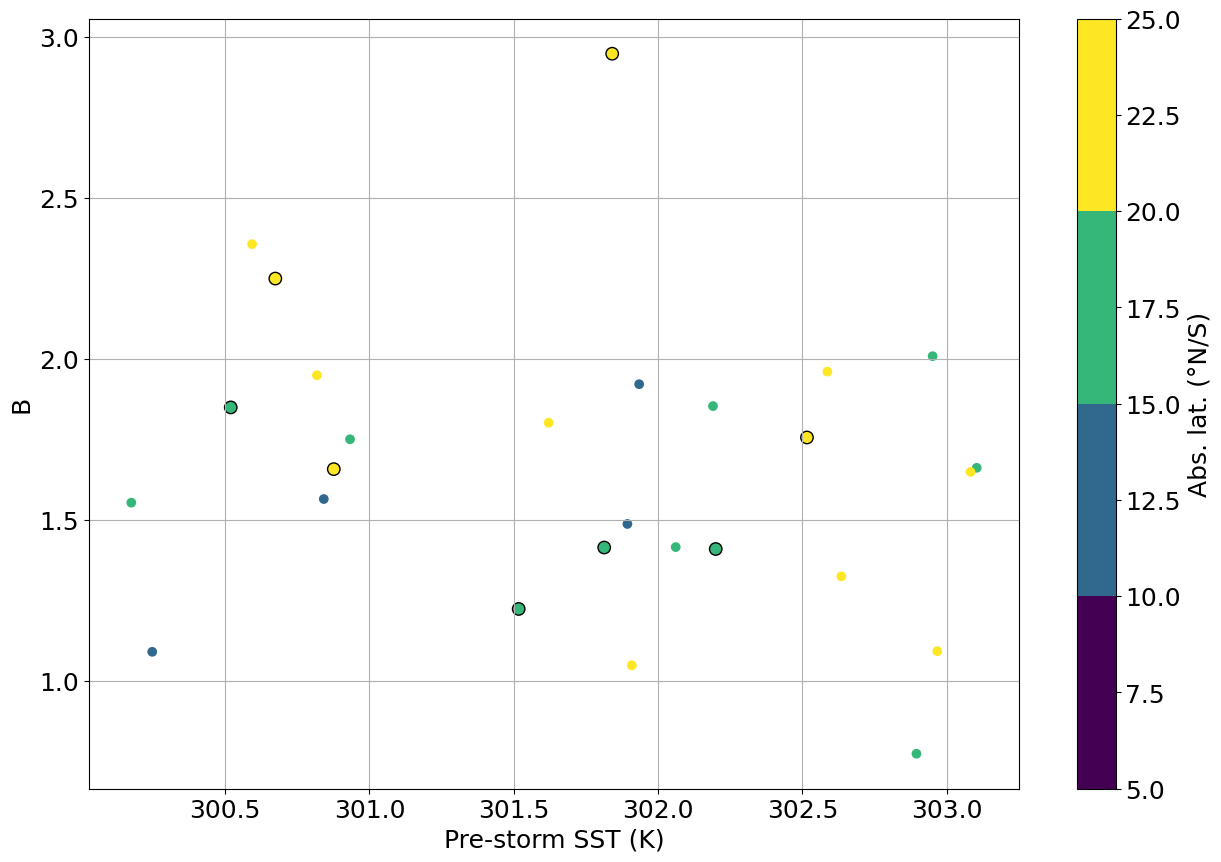

In [84]:
### TEST

dm = dw.where((dw.t_since_lmi_ibt >= -3 * 3600) & (dw.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 33.5, drop=True) # Thick barrier layer

plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/1711733124.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(ds.pre_sst_rms,     ds.B_hol,     c=abs(ds.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/1711733124.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(ds_tck.pre_sst_rms, ds_tck.B_hol, c=abs(ds_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


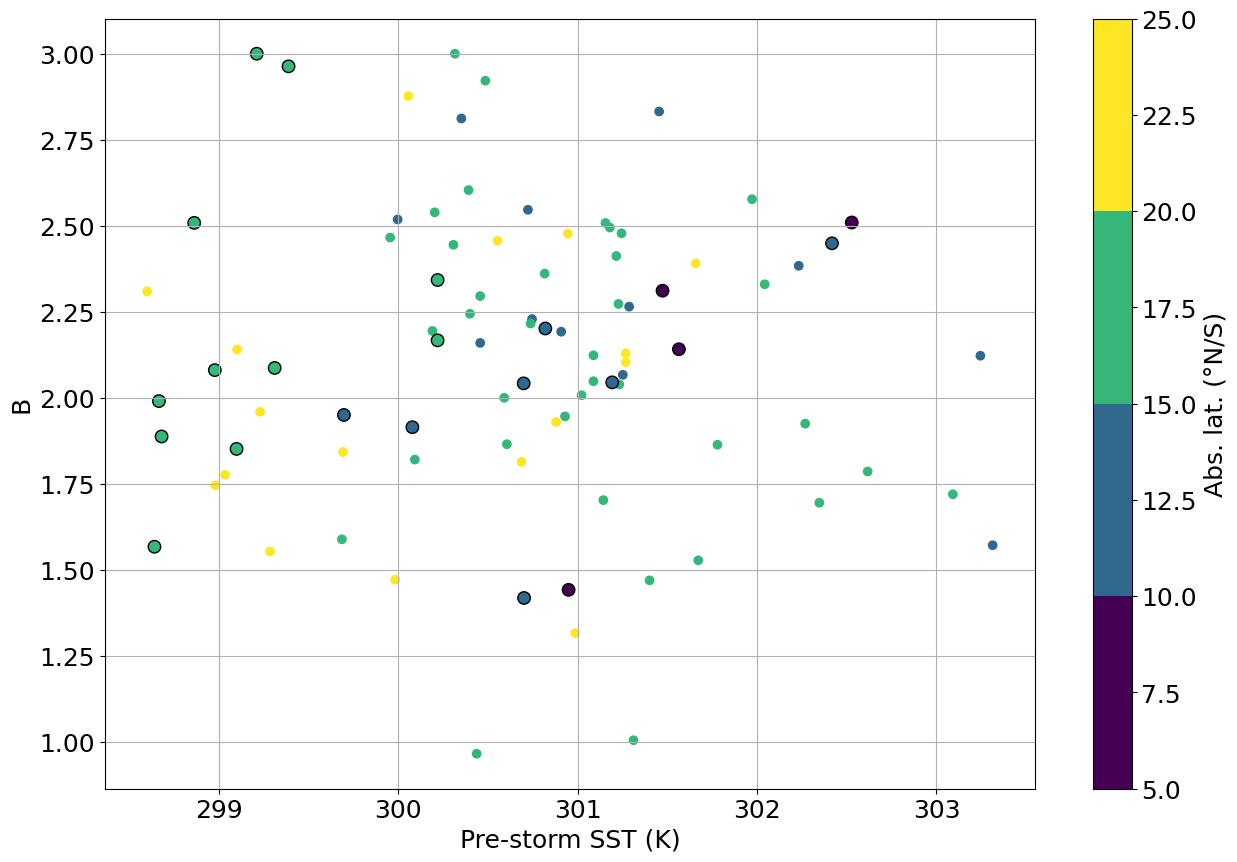

In [85]:
### TEST
ds = d.where(d.basin == 'sh', drop=True)

ds_tck = ds.where(ds.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(ds.pre_sst_rms,     ds.B_hol,     c=abs(ds.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(ds_tck.pre_sst_rms, ds_tck.B_hol, c=abs(ds_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/643858696.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/643858696.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


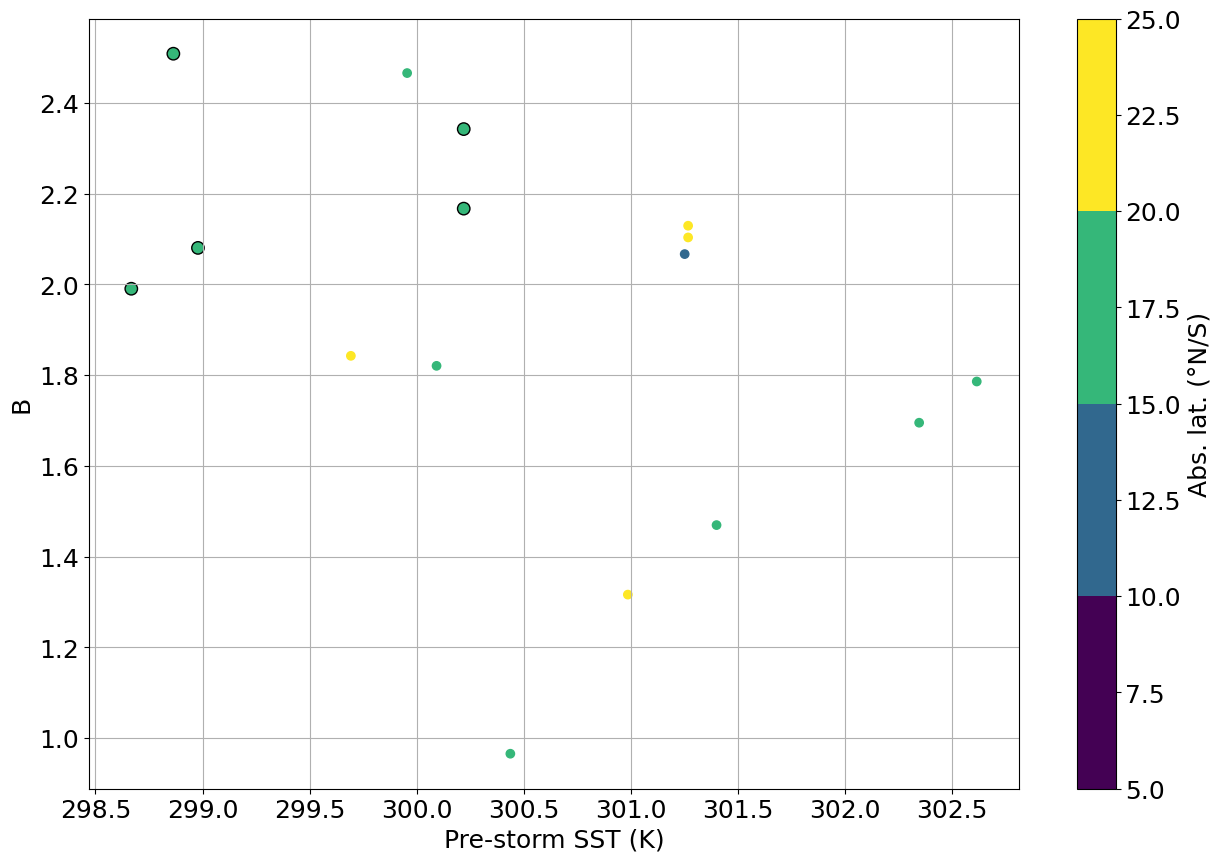

In [90]:
### TEST

dm = ds.where((ds.t_since_lmi_ibt >= -3 * 3600) & (ds.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 35.5, drop=True) # Thick barrier layer

plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/652272061.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d.pre_sst_rms,     d.B_hol,     c=abs(d.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/652272061.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d_tck.pre_sst_rms, d_tck.B_hol, c=abs(d_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


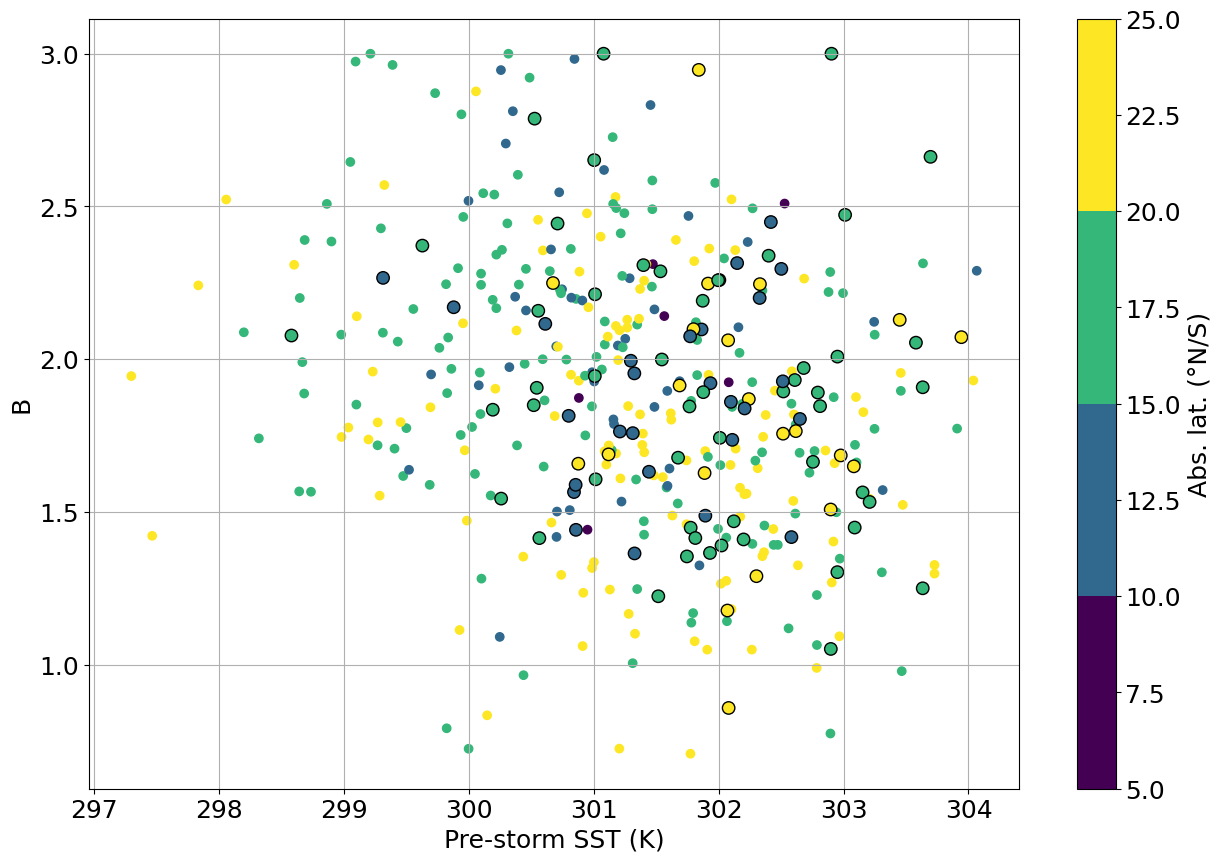

In [118]:
### TEST

d_tck = d.where(d.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(d.pre_sst_rms,     d.B_hol,     c=abs(d.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(d_tck.pre_sst_rms, d_tck.B_hol, c=abs(d_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

# plt.savefig(PTHS['sav_dir'] + 'B_SST_All.png', bbox_inches='tight')

/tmp/ipykernel_40915/2449634771.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/2449634771.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)


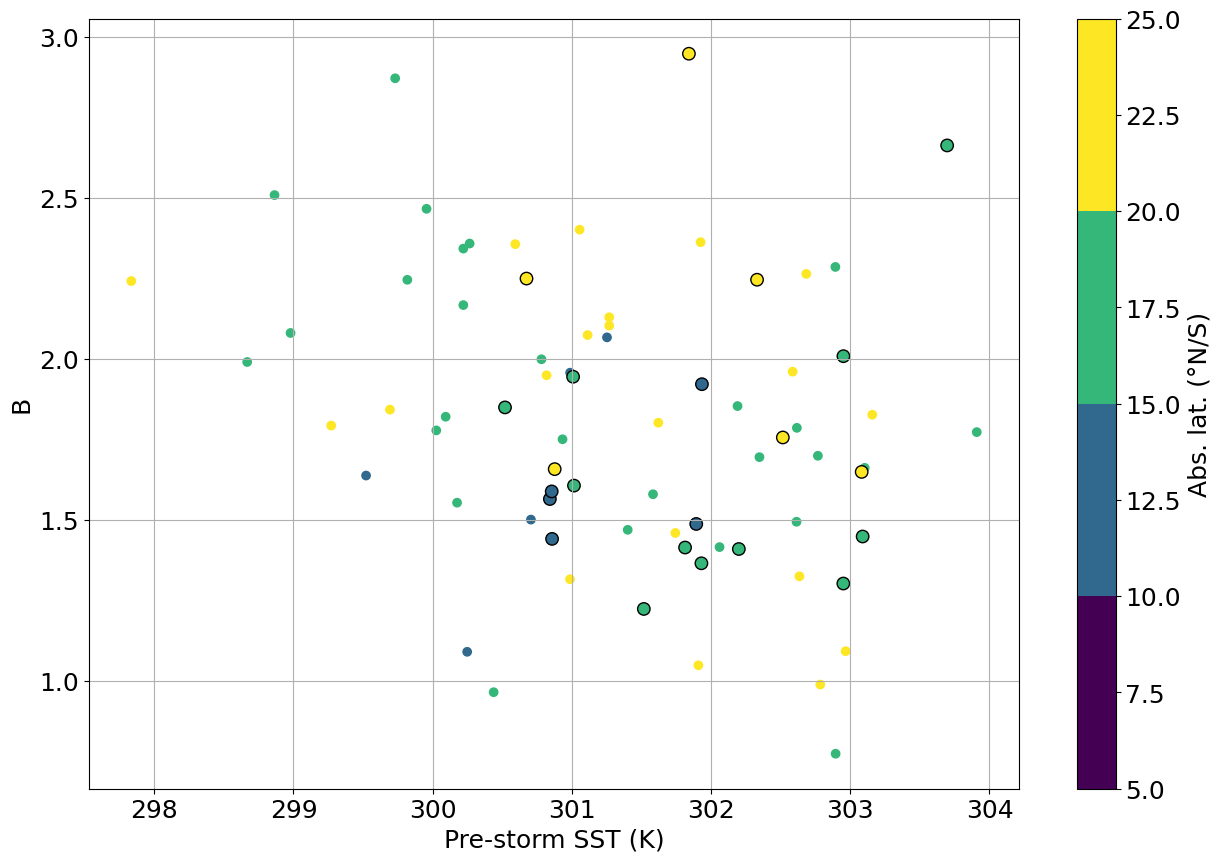

In [119]:
### TEST

dm = d.where((d.t_since_lmi_ibt >= -3 * 3600) & (d.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=abs(dm.lat),     vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=abs(dm_tck.lat), edgecolors='k', vmin=5, vmax=25, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Abs. lat. (°N/S)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

# plt.savefig(PTHS['sav_dir'] + 'B_SST_Mature.png', bbox_inches='tight')

/tmp/ipykernel_40915/975160426.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d.pre_sst_rms,     d.B_hol,     c=d.vmx ** 3 * abs(d.fcor) * d.rmx,     vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/975160426.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d_tck.pre_sst_rms, d_tck.B_hol, c=d_tck.vmx ** 3 * abs(d_tck.fcor) * d_tck.rmx, edgecolors='k', vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4), s=80)


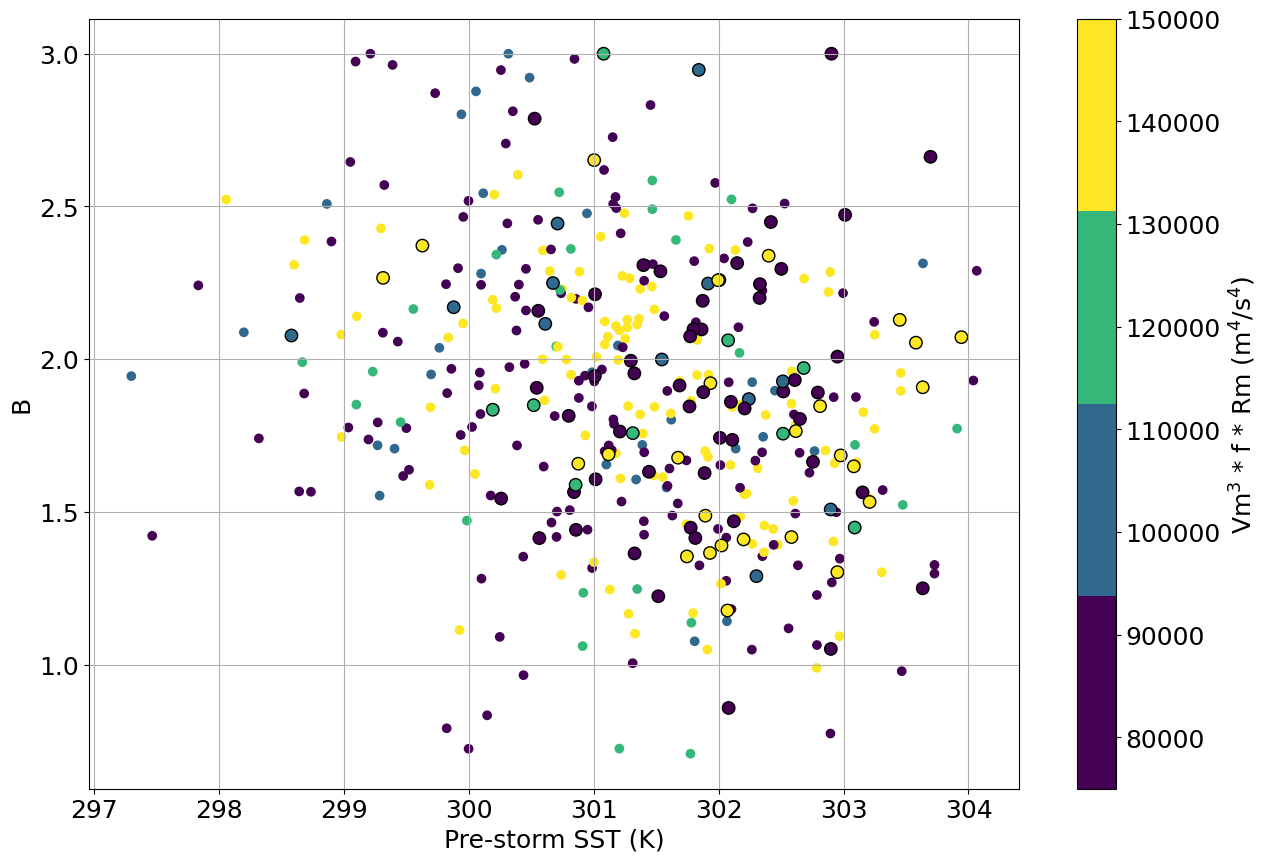

In [105]:
### TEST

d_tck = d.where(d.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(d.pre_sst_rms,     d.B_hol,     c=d.vmx ** 3 * abs(d.fcor) * d.rmx,     vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4))
plt.scatter(d_tck.pre_sst_rms, d_tck.B_hol, c=d_tck.vmx ** 3 * abs(d_tck.fcor) * d_tck.rmx, edgecolors='k', vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Vm$^3$ * f * Rm (m$^4$/s$^4$)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_40915/328196018.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=dm.vmx ** 3 * abs(dm.fcor) * dm.rmx,     vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/328196018.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=dm_tck.vmx ** 3 * abs(dm_tck.fcor) * dm_tck.rmx, edgecolors='k', vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4), s=80)


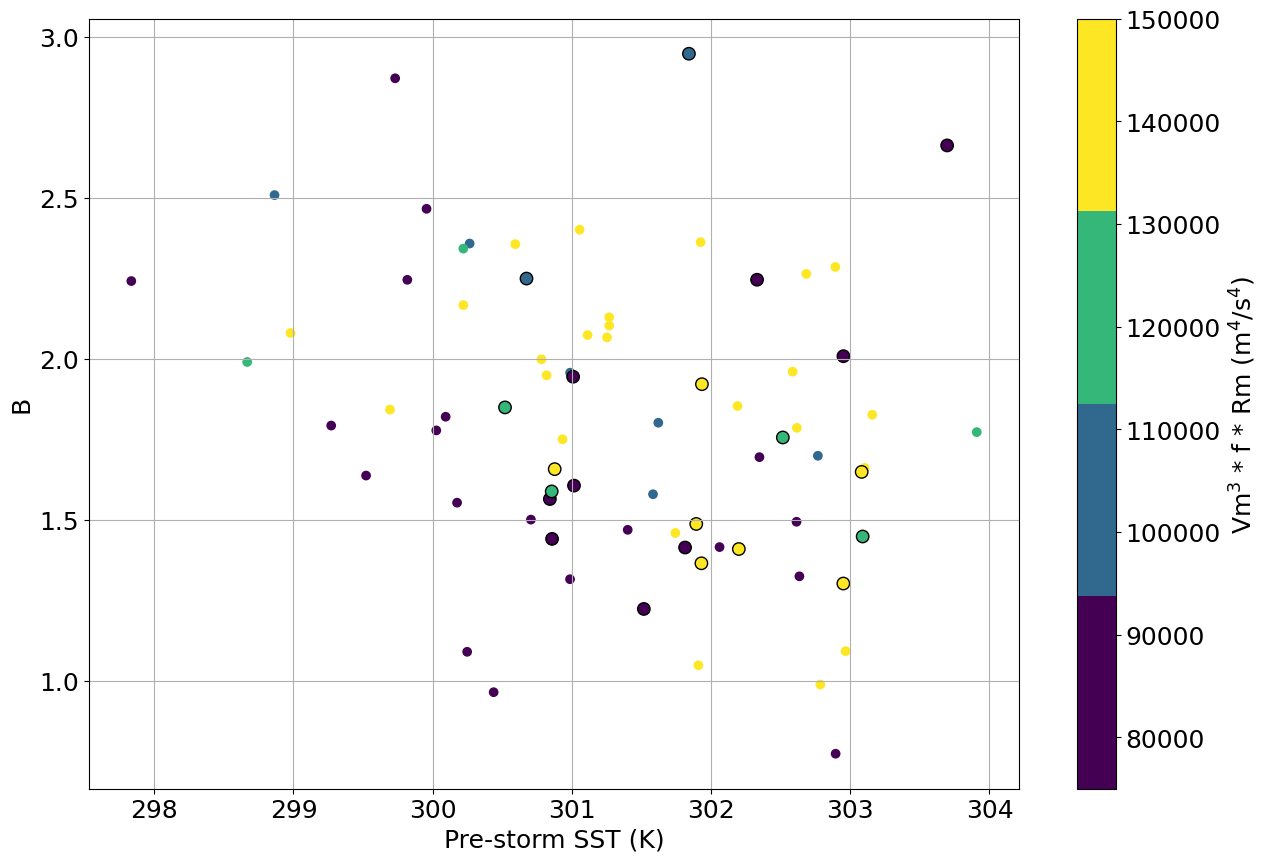

In [124]:
### TEST

dm = d.where((d.t_since_lmi_ibt >= -3 * 3600) & (d.t_since_lmi_ibt <= 12 * 3600), drop=True) # mature storms

dm_tck = dm.where(dm.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(dm.pre_sst_rms,     dm.B_hol,     c=dm.vmx ** 3 * abs(dm.fcor) * dm.rmx,     vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4))
plt.scatter(dm_tck.pre_sst_rms, dm_tck.B_hol, c=dm_tck.vmx ** 3 * abs(dm_tck.fcor) * dm_tck.rmx, edgecolors='k', vmin=75000, vmax=150000, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Pre-storm SST (K)')
plt.ylabel('B')

cbar = plt.colorbar()
cbar.set_label(r'Vm$^3$ * f * Rm (m$^4$/s$^4$)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

# plt.savefig(PTHS['sav_dir'] + 'B_SST_Mature_fromIKE.png', bbox_inches='tight')

(array([4., 4., 1., 4., 1., 3., 2., 1., 0., 3.]),
 array([ 51630.13493774,  68612.39794666,  85594.66095557, 102576.92396449,
        119559.1869734 , 136541.44998232, 153523.71299123, 170505.97600015,
        187488.23900906, 204470.50201798, 221452.76502689]),
 <BarContainer object of 10 artists>)

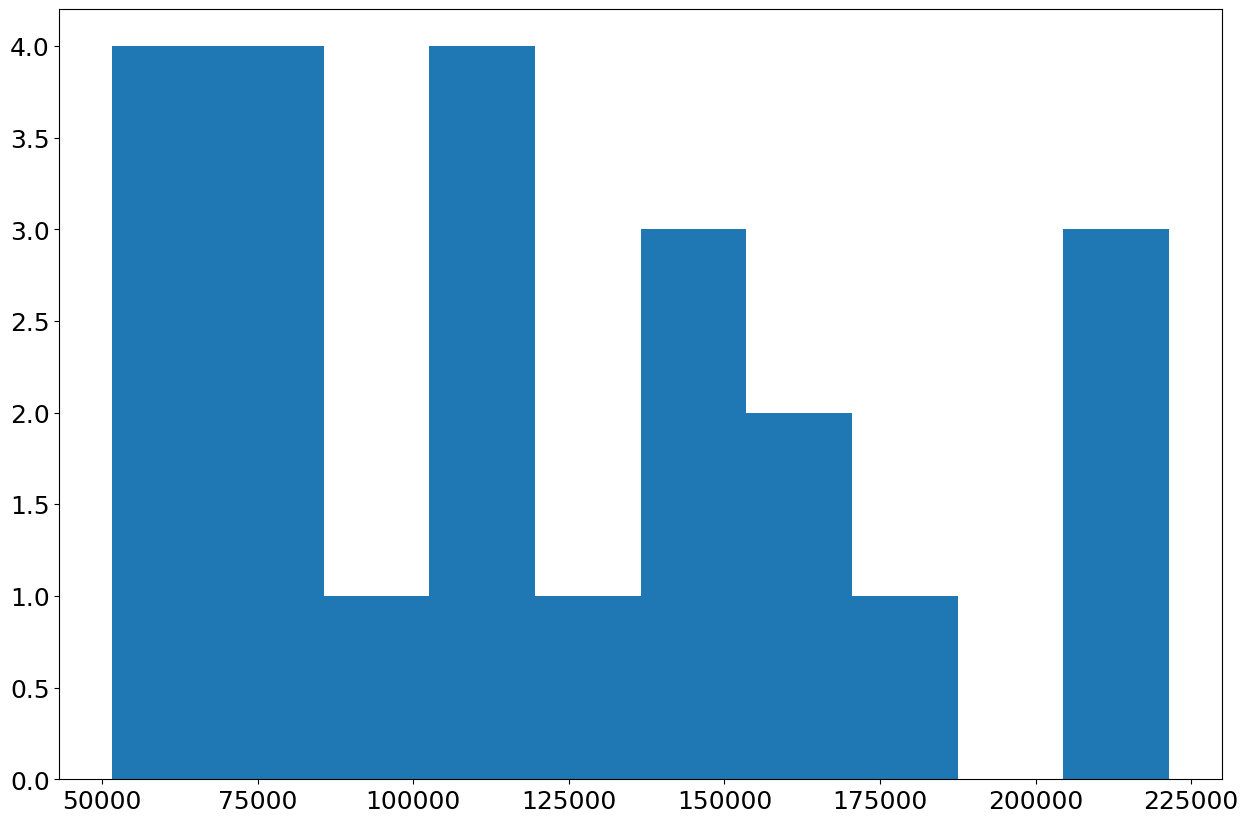

In [100]:
plt.hist(dm.vmx ** 3 * abs(dm.fcor) * dm.rmx)

/tmp/ipykernel_40915/780618398.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d.uc,     d.cod_wak_rms,     c=d.vmx,     vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/780618398.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(d_tck.uc, d_tck.cod_wak_rms, c=d_tck.vmx, edgecolors='k', vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4), s=80)


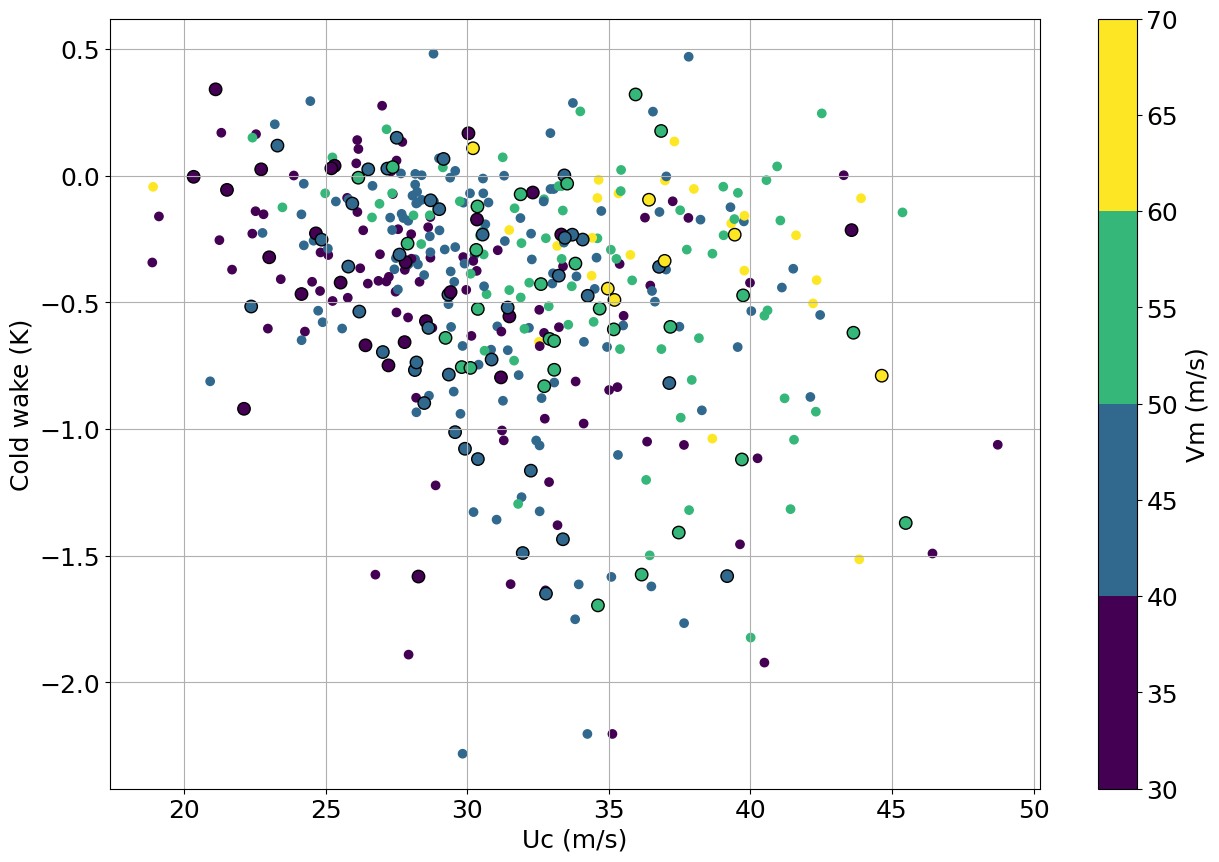

In [121]:
### TEST

d_tck = d.where(d.pre_sss_rms <= 34, drop=True) # Thick barrier layer

plt.scatter(d.uc,     d.cod_wak_rms,     c=d.vmx,     vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4))
plt.scatter(d_tck.uc, d_tck.cod_wak_rms, c=d_tck.vmx, edgecolors='k', vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Uc (m/s)')
plt.ylabel('Cold wake (K)')

cbar = plt.colorbar()
cbar.set_label(r'Vm (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

# plt.savefig(PTHS['sav_dir'] + 'Uc_ColdWake_All.png', bbox_inches='tight')

/tmp/ipykernel_40915/34968975.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(da.uc,     da.cod_wak_rms,     c=da.vmx,     vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4))
/tmp/ipykernel_40915/34968975.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(da_tck.uc, da_tck.cod_wak_rms, c=da_tck.vmx, edgecolors='k', vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4), s=80)


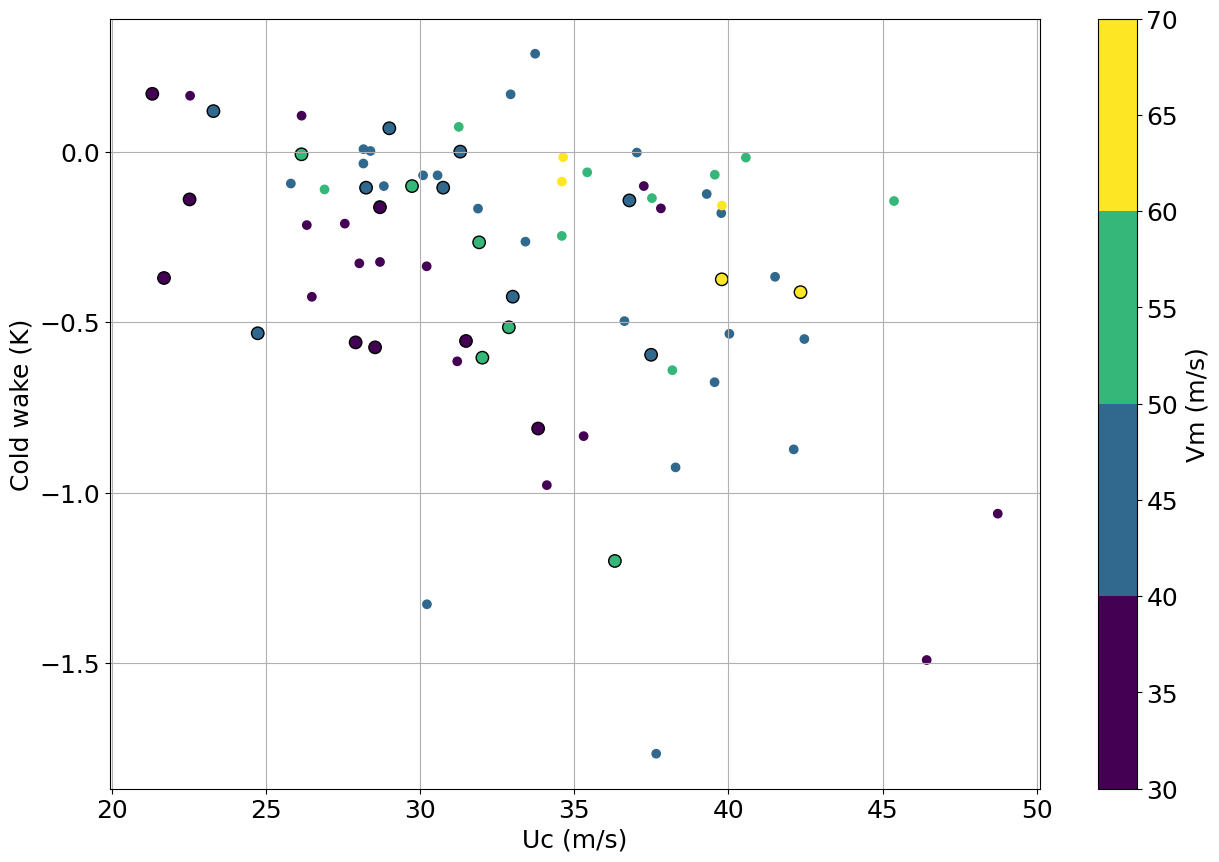

In [123]:
### TEST

da_tck = da.where(da.pre_sss_rms <= 36, drop=True) # Thick barrier layer

plt.scatter(da.uc,     da.cod_wak_rms,     c=da.vmx,     vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4))
plt.scatter(da_tck.uc, da_tck.cod_wak_rms, c=da_tck.vmx, edgecolors='k', vmin=30, vmax=70, cmap=cm.get_cmap('viridis', 4), s=80)

# plt.axhline(0, c='k')
# plt.axvline(300, c='k')
plt.grid()
plt.xlabel('Uc (m/s)')
plt.ylabel('Cold wake (K)')

cbar = plt.colorbar()
cbar.set_label(r'Vm (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

# plt.savefig(PTHS['sav_dir'] + 'Uc_ColdWake_NA.png', bbox_inches='tight')

In [9]:
chido = d.where(d.name=='CHIDO', drop=True)

In [30]:
chido

<xarray.Dataset> Size: 3kB
Dimensions:              (time: 5)
Coordinates:
  * time                 (time) datetime64[ns] 40B 2024-12-11T01:48:25 ... 20...
Data variables: (12/76)
    dist2coast           (time) float64 40B 2.549e+05 1.436e+05 ... 9.412e+04
    speed                (time) float64 40B 3.607 5.705 5.393 5.726 6.559
    name                 (time) object 40B 'CHIDO' 'CHIDO' ... 'CHIDO' 'CHIDO'
    id                   (time) object 40B 'sh042025' 'sh042025' ... 'sh042025'
    file                 (time) object 40B 'rcm2-sc50ma-owi-cm-20241211t01474...
    file_tcva            (time) object 40B 'rcm2-sc50ma-owi-ca-20241211t01474...
    ...                   ...
    beta0_pmd            (time) float64 40B nan nan nan nan nan
    beta0_T0_pmd         (time) float64 40B nan nan nan nan nan
    beta0                (time) float64 40B nan nan nan nan nan
    beta0_T0             (time) float64 40B 1.127 1.946 1.599 1.861 2.253
    dKdt                 (time) float64 40B -0.1529 5.931 -0.9275 0.116 0.09024
    basin_idx            (time) float64 40B 5.0 5.0 5.0 5.0 5.0
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-11-20T06:17:...

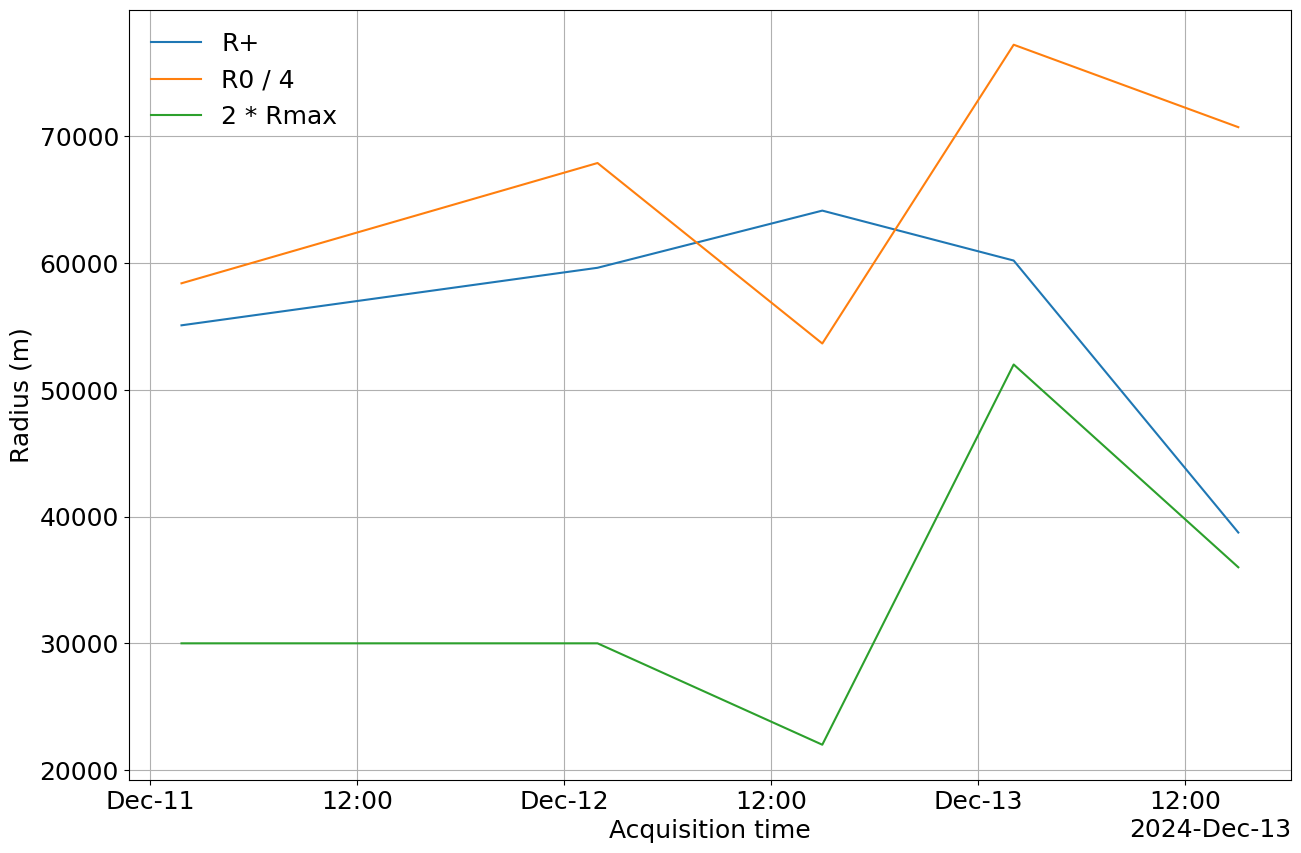

In [53]:
chido.rps.plot(label='R+')
(chido.r0 / 4).plot(label='R0 / 4')
(chido.rmx * 2).plot(label='2 * Rmax')
plt.ylabel('Radius (m)')
plt.legend(frameon=False)
plt.grid()

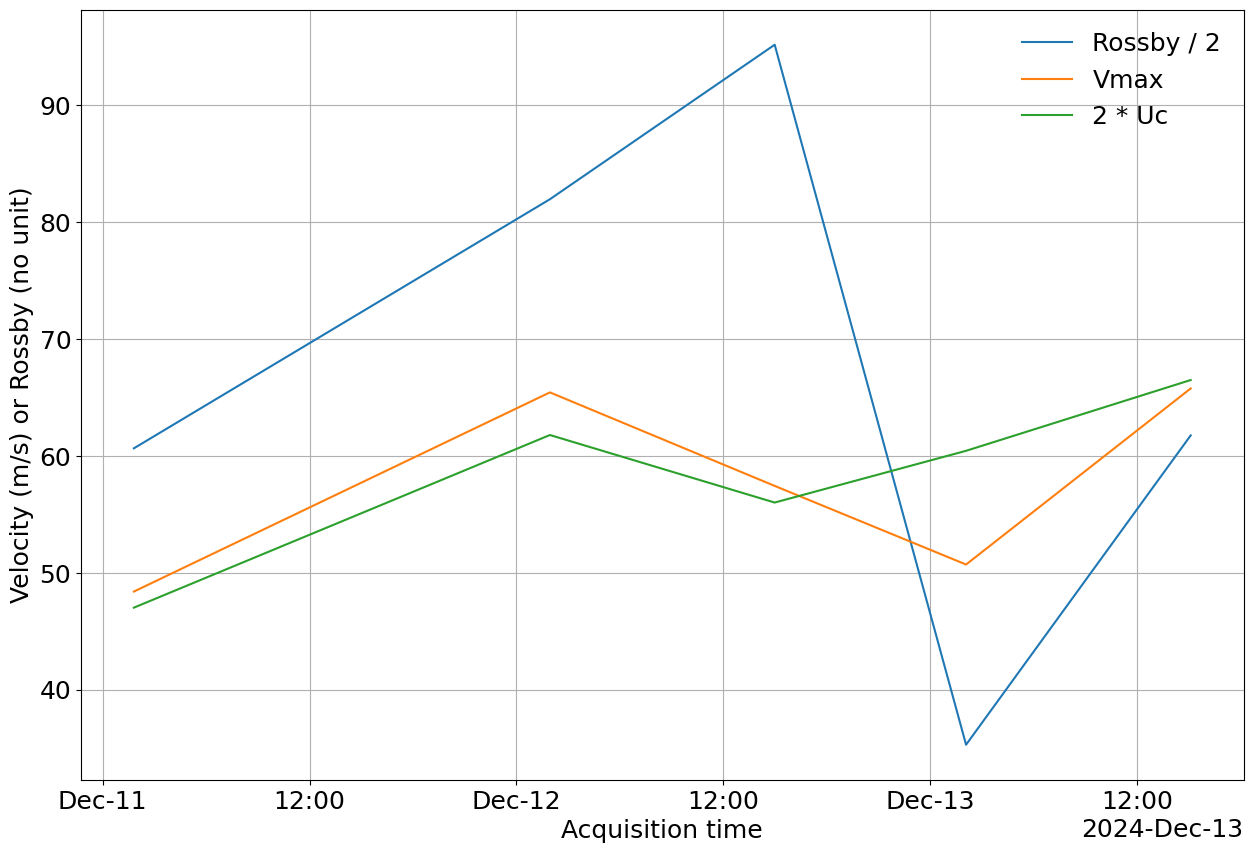

In [51]:
(chido.rsby / 2).plot(label='Rossby / 2')
(chido.vmx).plot(label='Vmax')
(chido.uc * 2).plot(label='2 * Uc')
plt.ylabel('Velocity (m/s) or Rossby (no unit)')
plt.legend(frameon=False)
plt.grid()

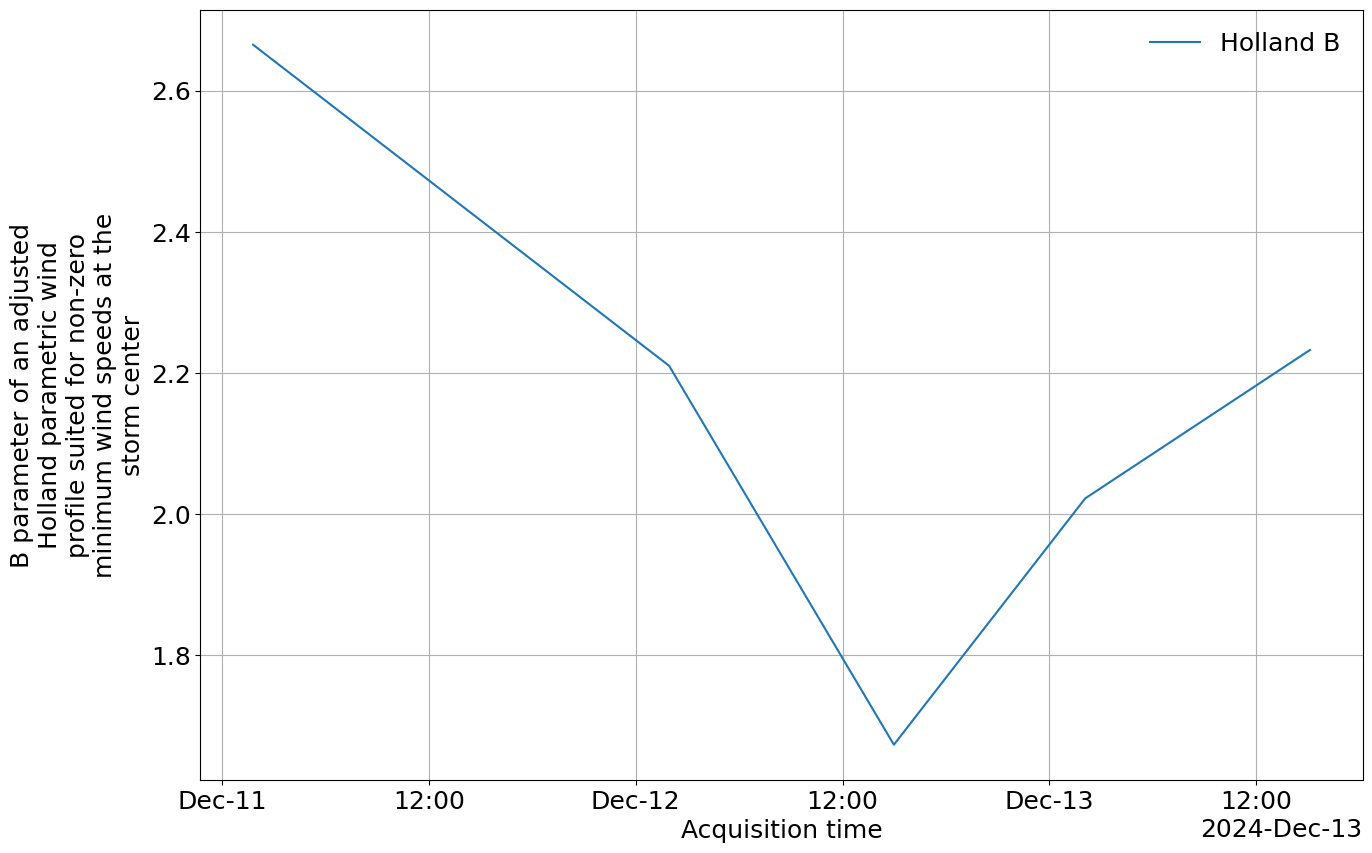

In [41]:
chido.B_hol.plot(label='Holland B')
plt.legend(frameon=False)
plt.grid()

In [47]:
d

<xarray.Dataset> Size: 264kB
Dimensions:              (time: 429)
Coordinates:
  * time                 (time) datetime64[ns] 3kB 2013-07-01T10:41:57 ... 20...
Data variables: (12/76)
    dist2coast           (time) float64 3kB 8.115e+04 1.202e+05 ... 3.005e+05
    speed                (time) float64 3kB 5.97 6.619 5.511 ... 9.808 9.808
    name                 (time) object 3kB 'RUMBIA' 'WUTIP' ... 'DIKELEDI'
    id                   (time) object 3kB 'wp062013' 'wp202013' ... 'sh072025'
    file                 (time) object 3kB 'rs2--owi-cm-20130701t104119-20130...
    file_tcva            (time) object 3kB 'rs2--owi-ca-20130701t104119-20130...
    ...                   ...
    beta0_pmd            (time) float64 3kB 1.349e+04 1.583e+04 ... nan nan
    beta0_T0_pmd         (time) float64 3kB 52.55 59.07 51.1 ... nan nan nan
    beta0                (time) float64 3kB 411.3 623.0 532.1 ... nan nan nan
    beta0_T0             (time) float64 3kB 1.566 2.378 2.022 ... 2.214 2.152
    dKdt                 (time) float64 3kB -0.03188 0.7363 ... 0.9931 1.029
    basin_idx            (time) float64 3kB 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0 5.0
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-11-20T06:17:...

### 1) Preliminary diagnostic

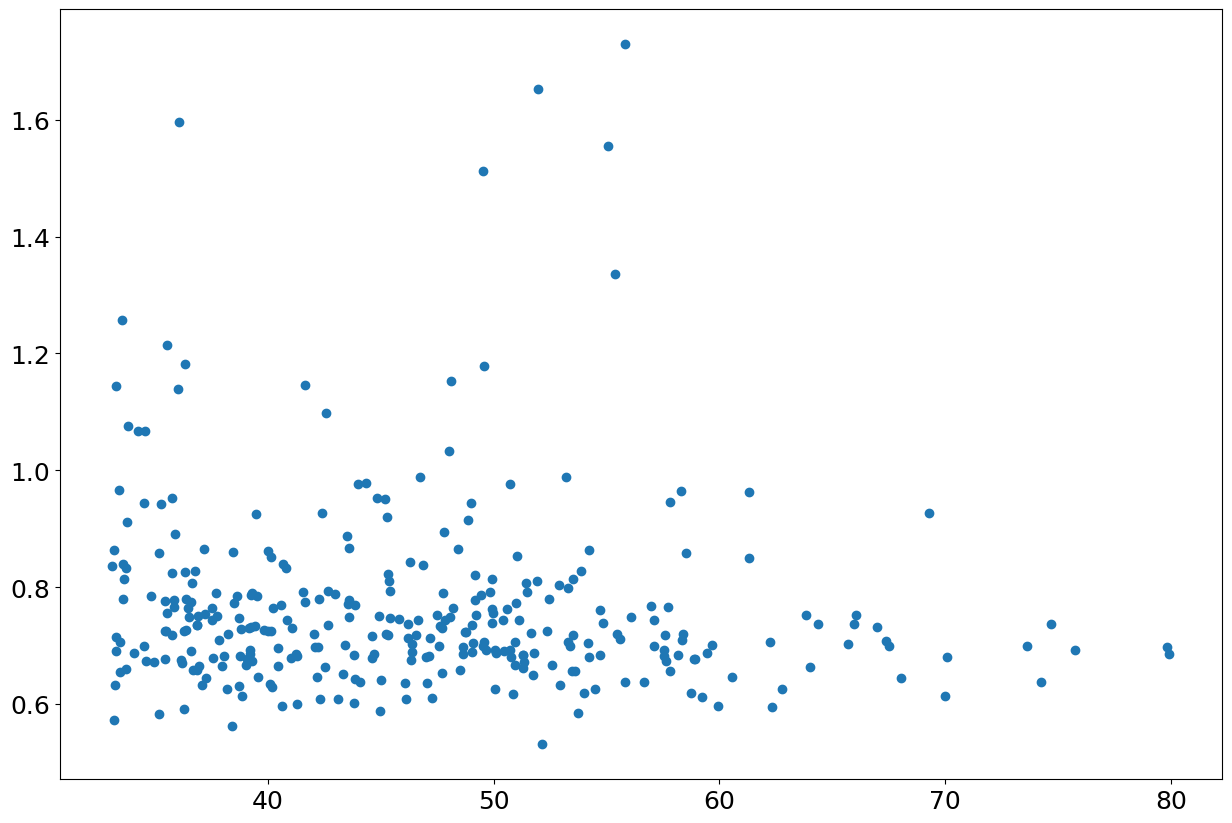

In [5]:
plt.scatter(d.vmx, d.beta0_pmd / 20000)

Text(0, 0.5, 'beta0 SAR')

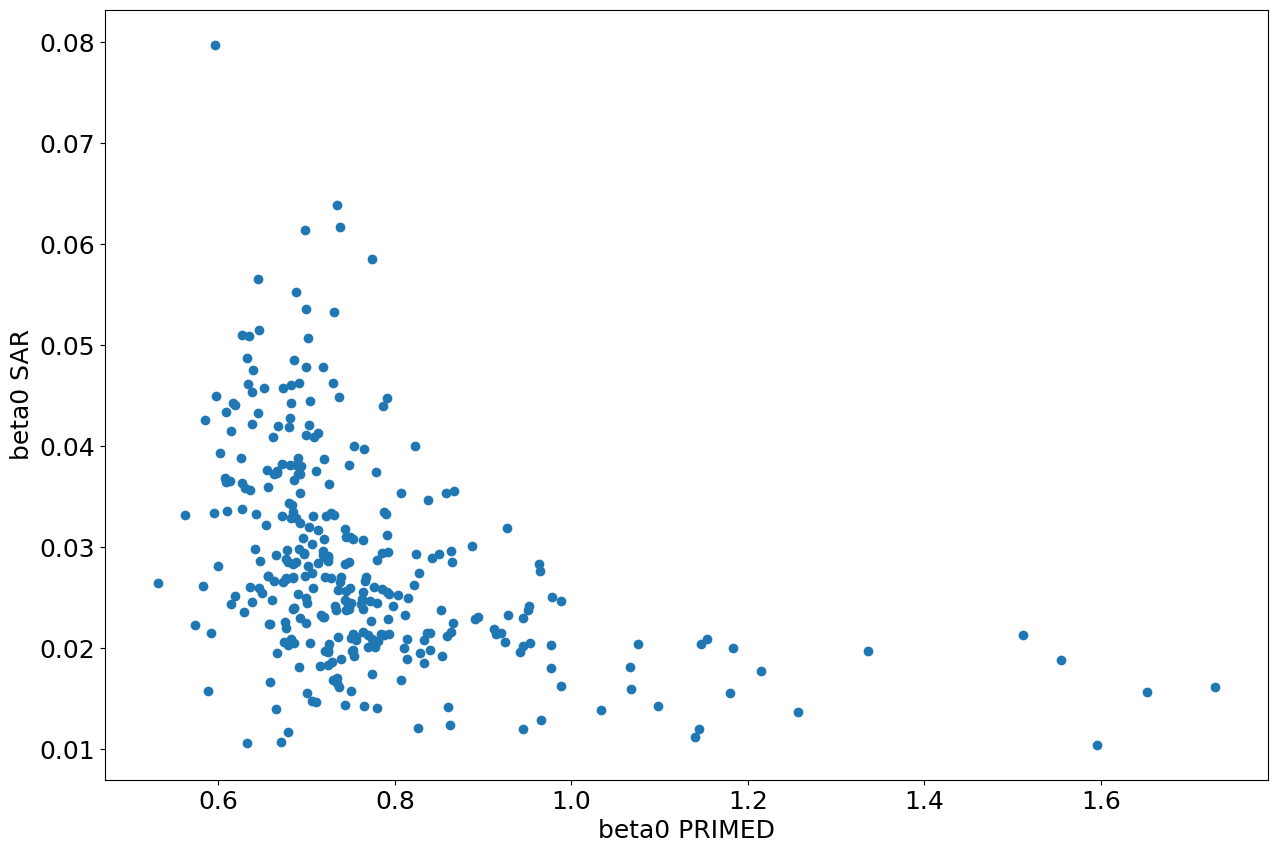

In [6]:
plt.scatter(d.beta0_pmd / 20000, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

Text(0, 0.5, 'beta0 SAR')

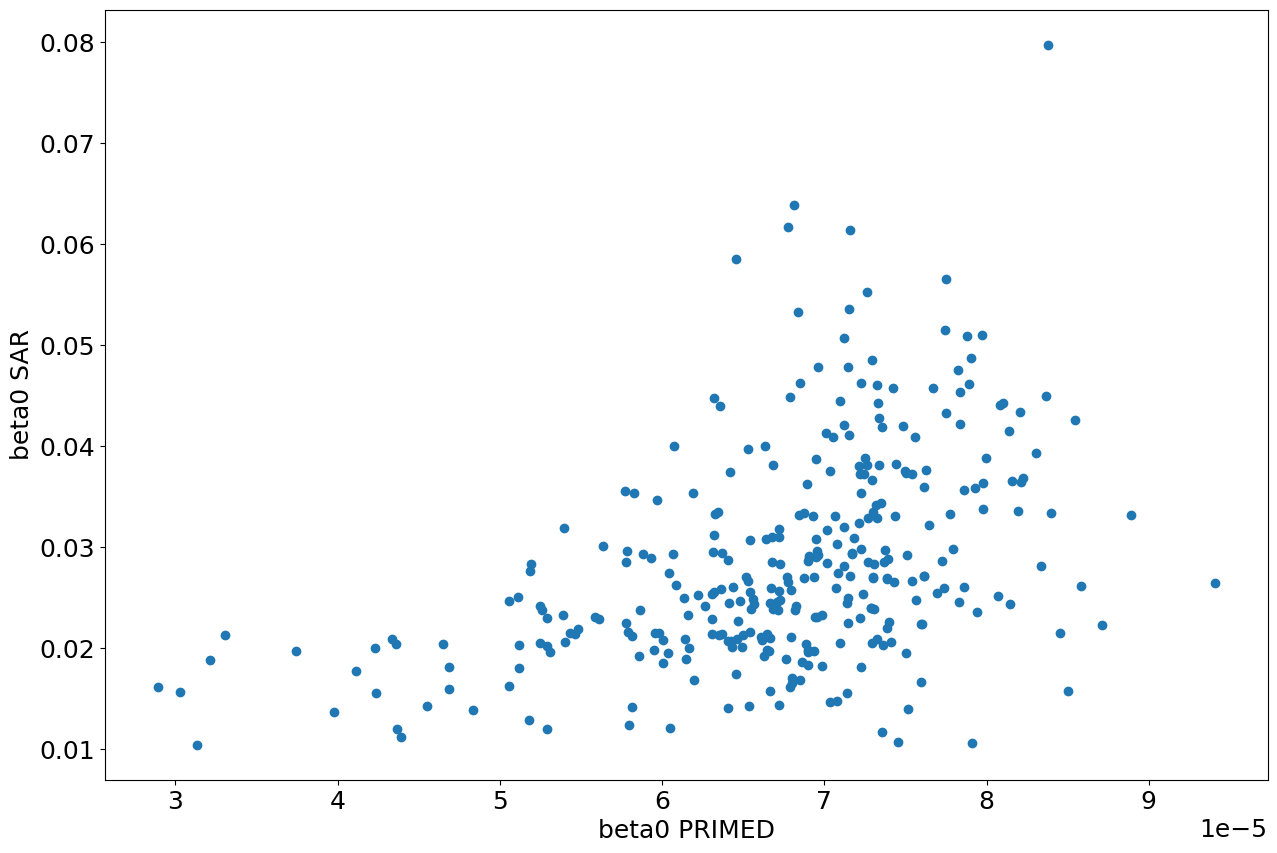

In [7]:
plt.scatter(1/ d.beta0_pmd, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

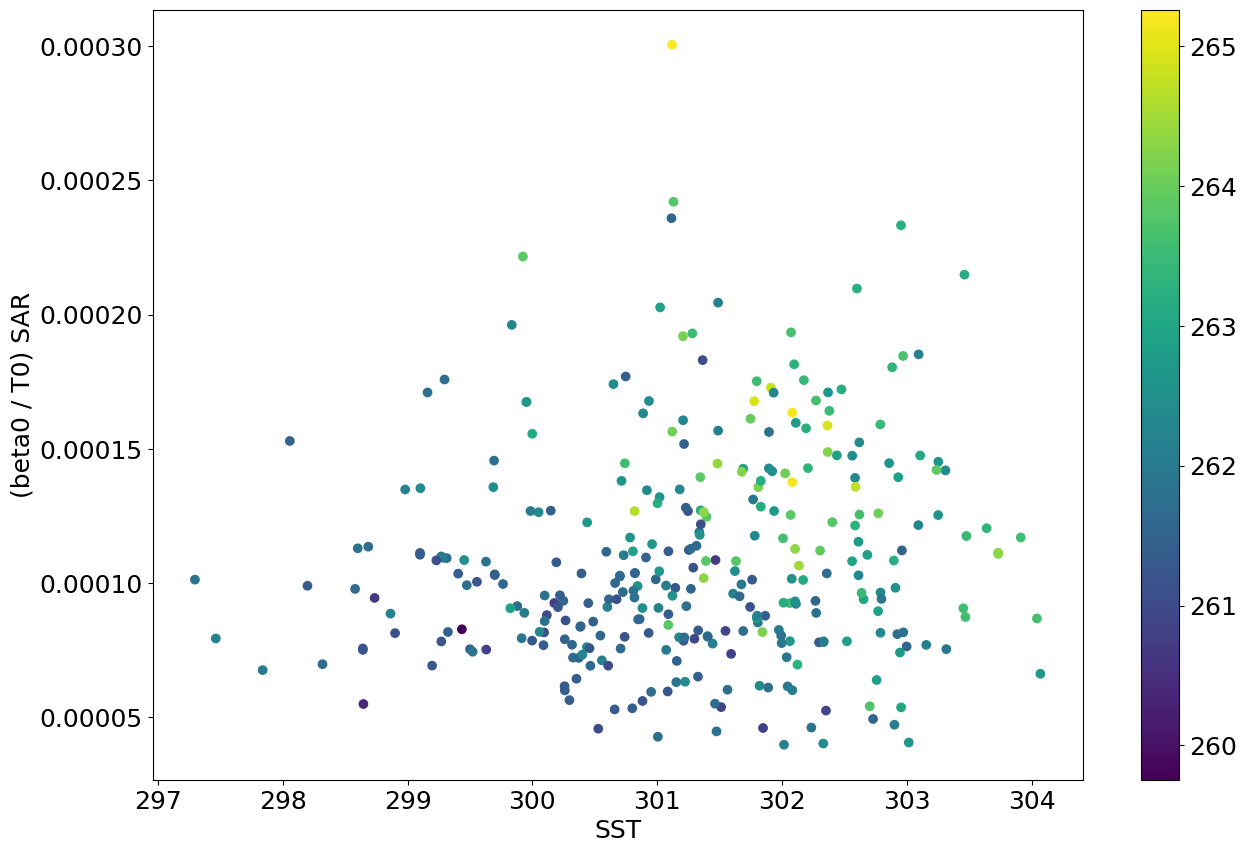

In [8]:
plt.scatter(d.sst_rms, d.beta0_T0 / 20000, c=d.temp_pmd)
plt.xlabel('SST')
plt.ylabel('(beta0 / T0) SAR')
plt.colorbar()
# plt.xlim(0, 1)

In [9]:
# plt.scatter(d.beta0_T0_pmd / 20000, d.beta0_T0 / 20000)
# plt.xlabel('beta0 / T0 PRIMED')
# plt.ylabel('beta0 / T0 SAR')
# # plt.xlim(0, 0.005)

Text(0, 0.5, 'Holland B')

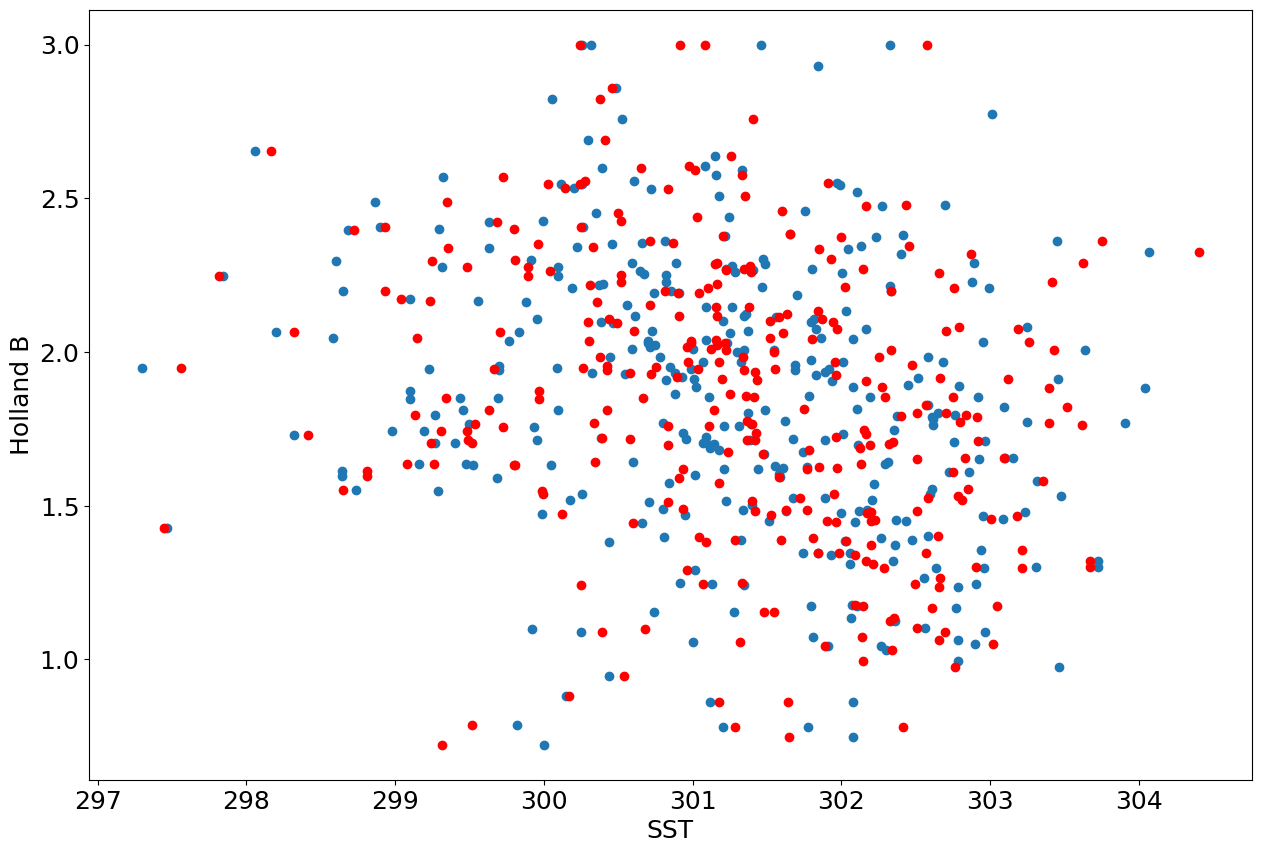

In [10]:
plt.scatter(d.sst_rms, d.B_hol)
plt.scatter(d.sst_pmd, d.B_hol, c='r')
plt.xlabel('SST')
plt.ylabel('Holland B')

Text(0, 0.5, 'Holland B')

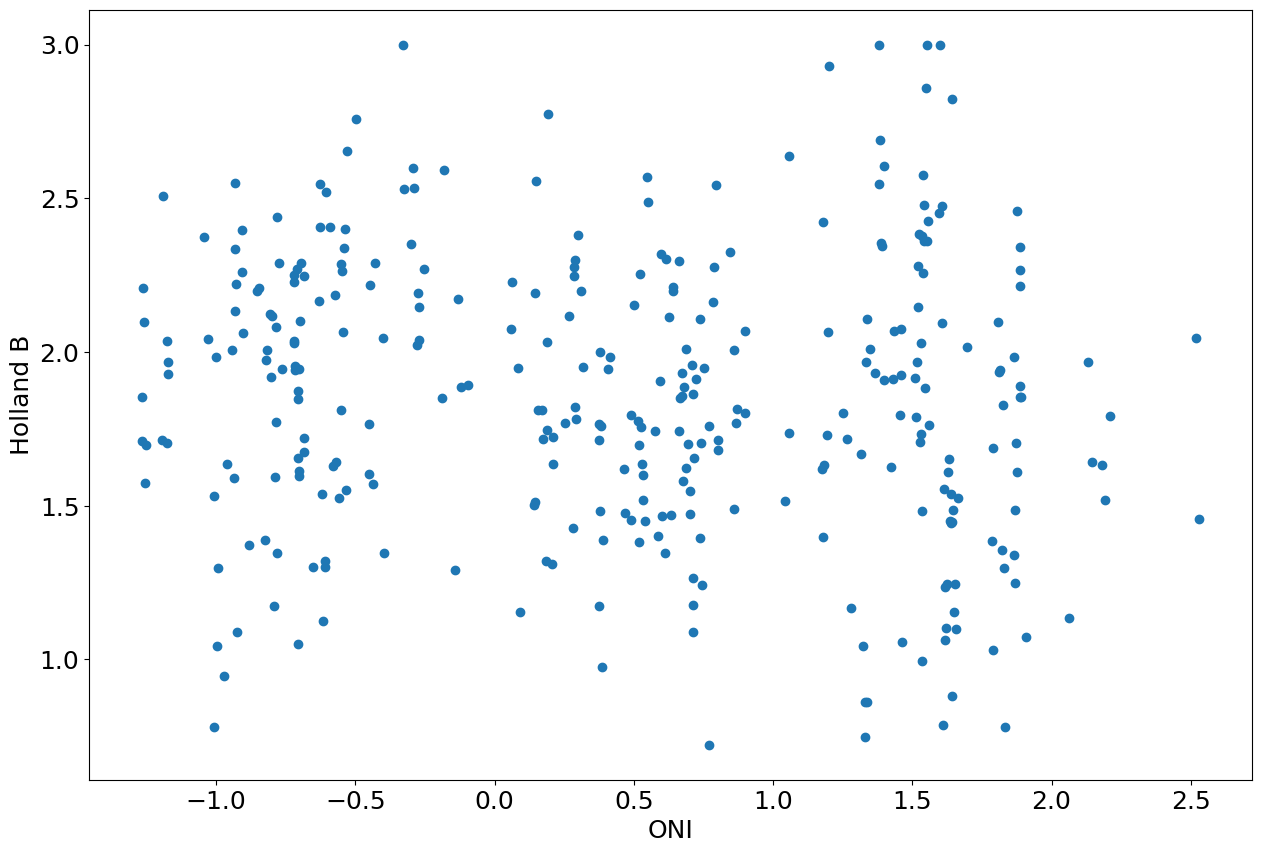

In [11]:
plt.scatter(d.oni_psl, d.B_hol)
plt.xlabel('ONI')
plt.ylabel('Holland B')

Text(0, 0.5, 'R34')

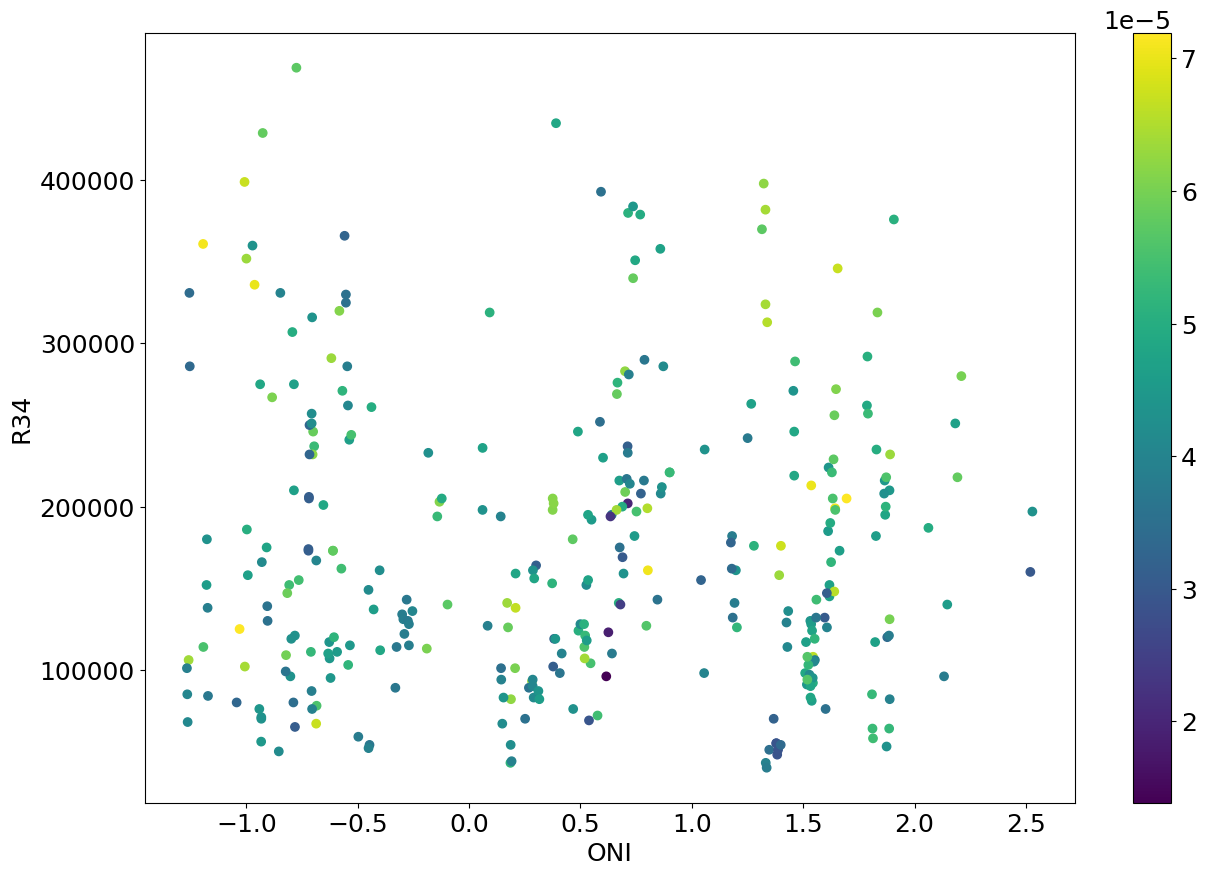

In [12]:
plt.scatter(d.oni_psl, d.r34, c=abs(d.fcor))
plt.colorbar()
plt.xlabel('ONI')
plt.ylabel('R34')

Text(0, 0.5, 'R34')

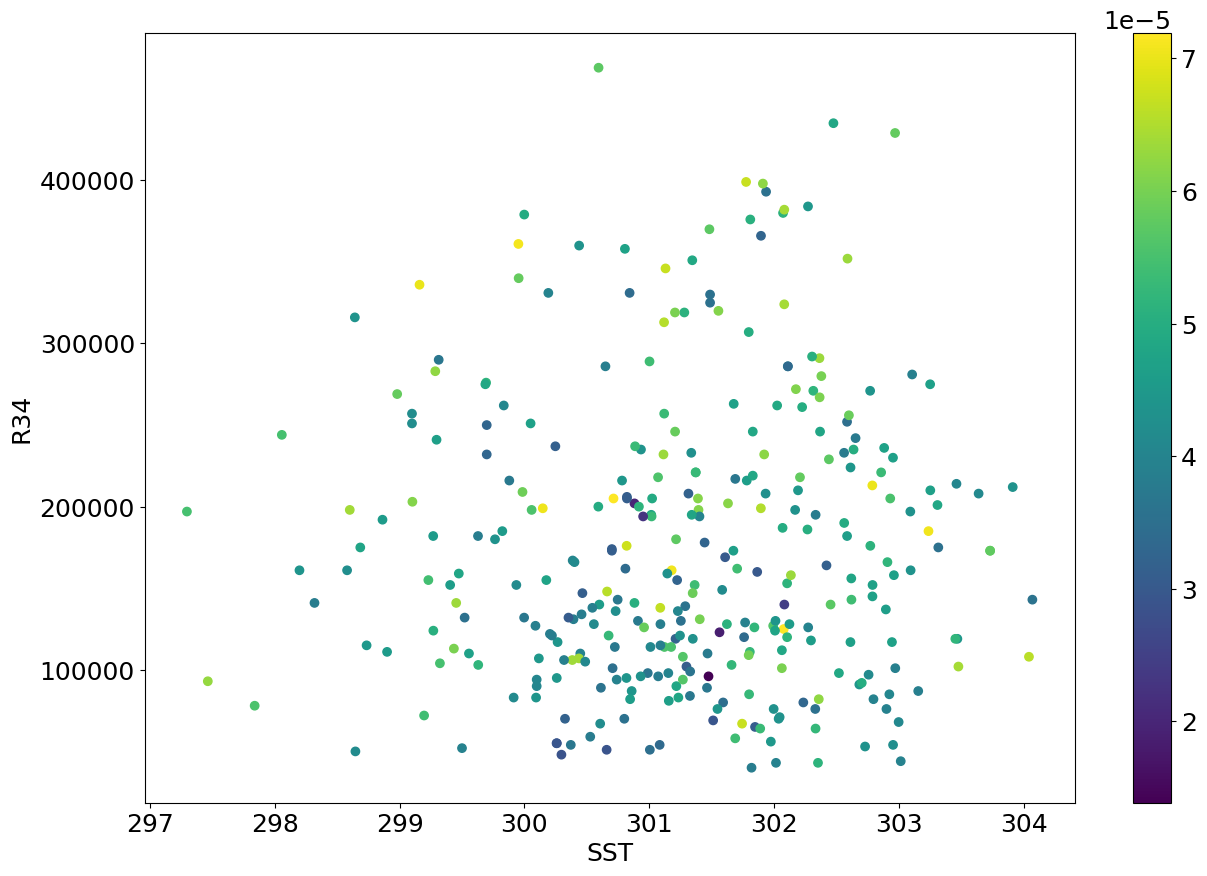

In [13]:
plt.scatter(d.sst_rms, d.r34, c=abs(d.fcor))
plt.colorbar()
plt.xlabel('SST')
plt.ylabel('R34')

(array([34., 96., 91., 49., 29., 16.,  5.,  3.,  0.,  1.]),
 array([0.01388159, 0.02312359, 0.0323656 , 0.04160761, 0.05084961,
        0.06009162, 0.06933362, 0.07857563, 0.08781764, 0.09705964,
        0.10630165]),
 <BarContainer object of 10 artists>)

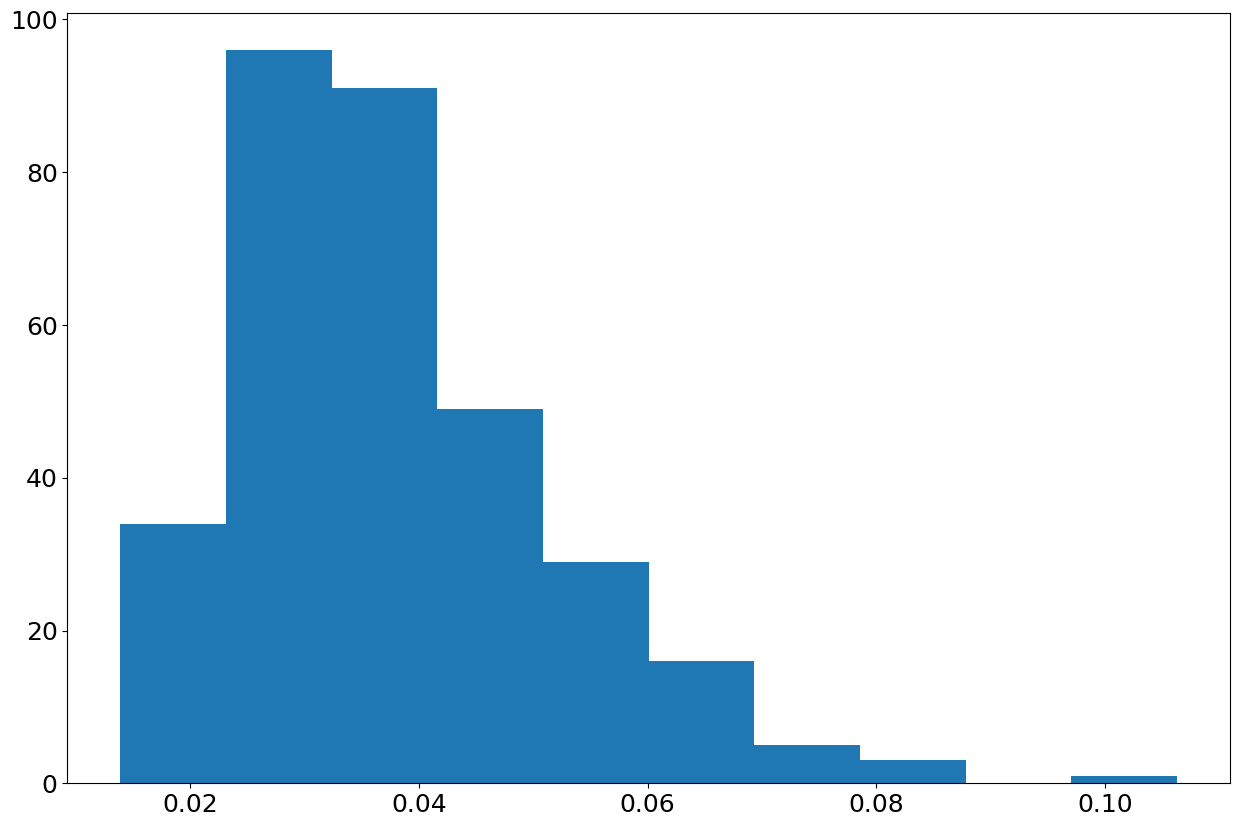

In [14]:
plt.hist(d.beta0 / 15000)

### 2) Variation by basin

/tmp/ipykernel_17544/3892731901.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


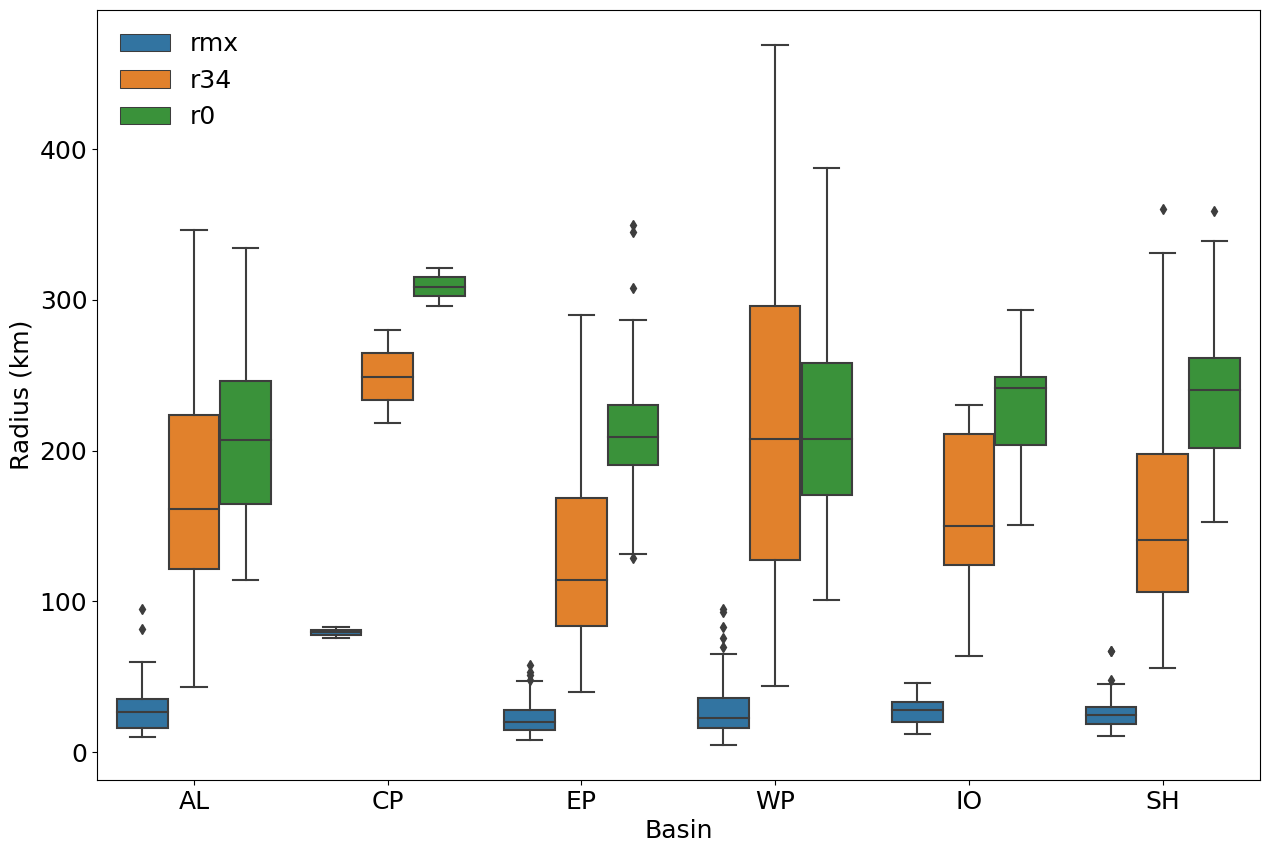

In [15]:
df      = d[['basin_idx', 'rmx', 'r34', 'r0']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rmx', 'r34', 'r0'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks() / 1000]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Radius (km)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

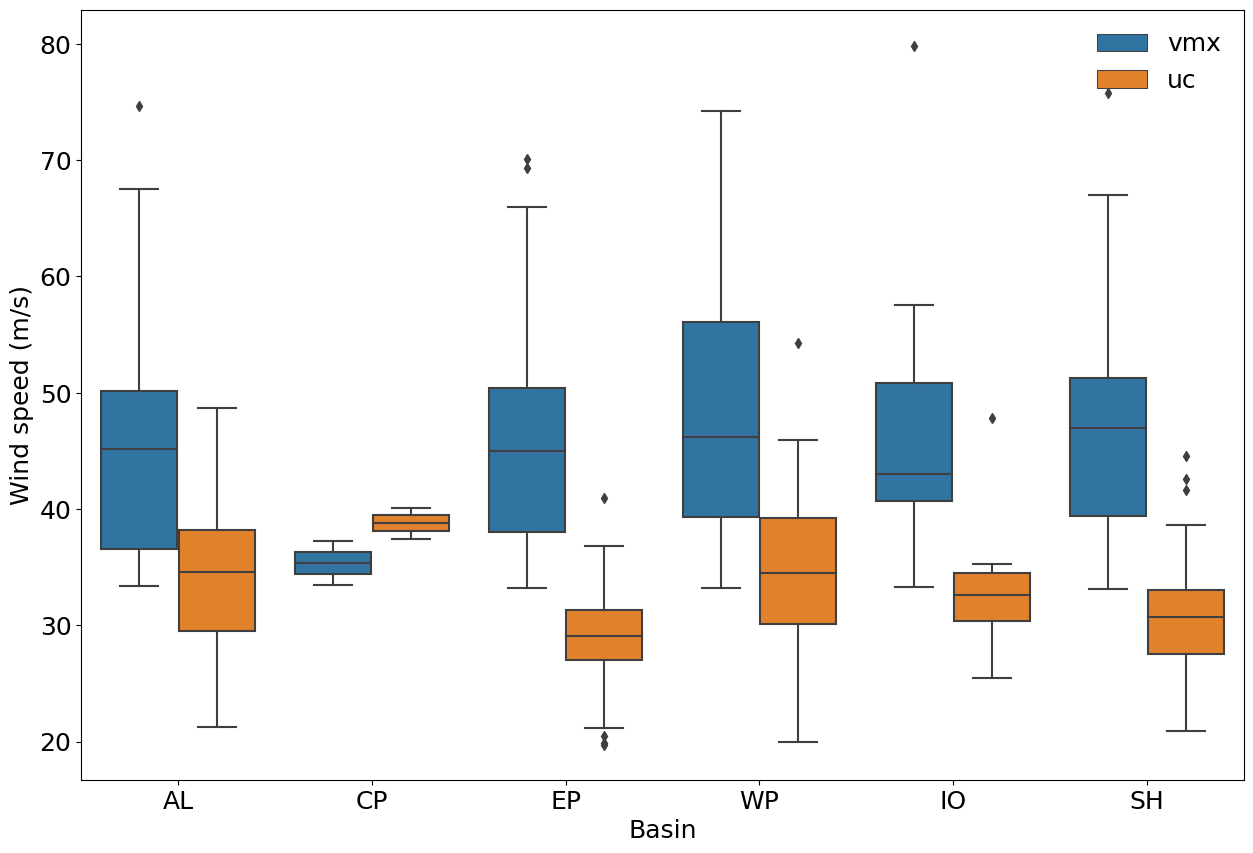

In [16]:
df      = d[['basin_idx', 'vmx', 'uc']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmx', 'uc'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Wind speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

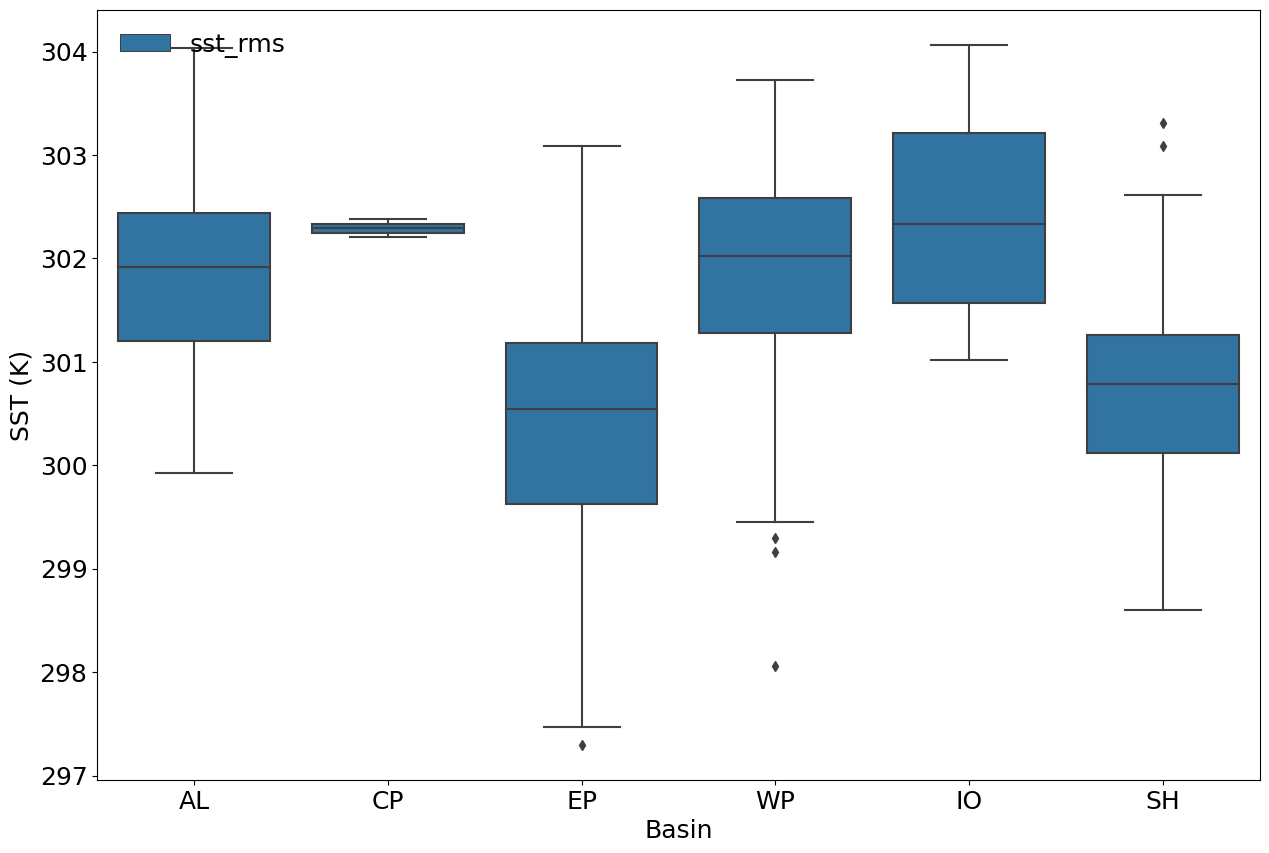

In [17]:
df      = d[['basin_idx', 'sst_rms']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['sst_rms'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('SST (K)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

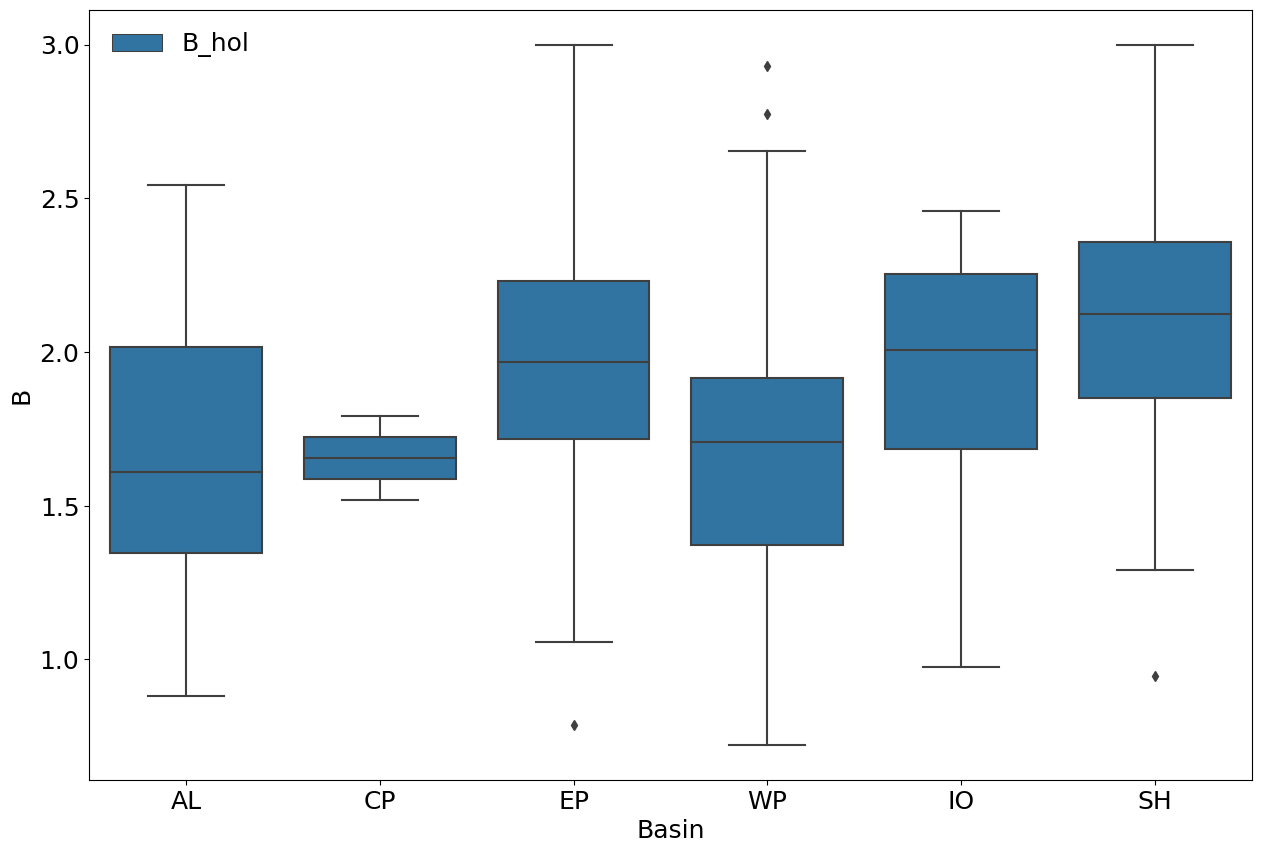

In [18]:
df      = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['B_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('B')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

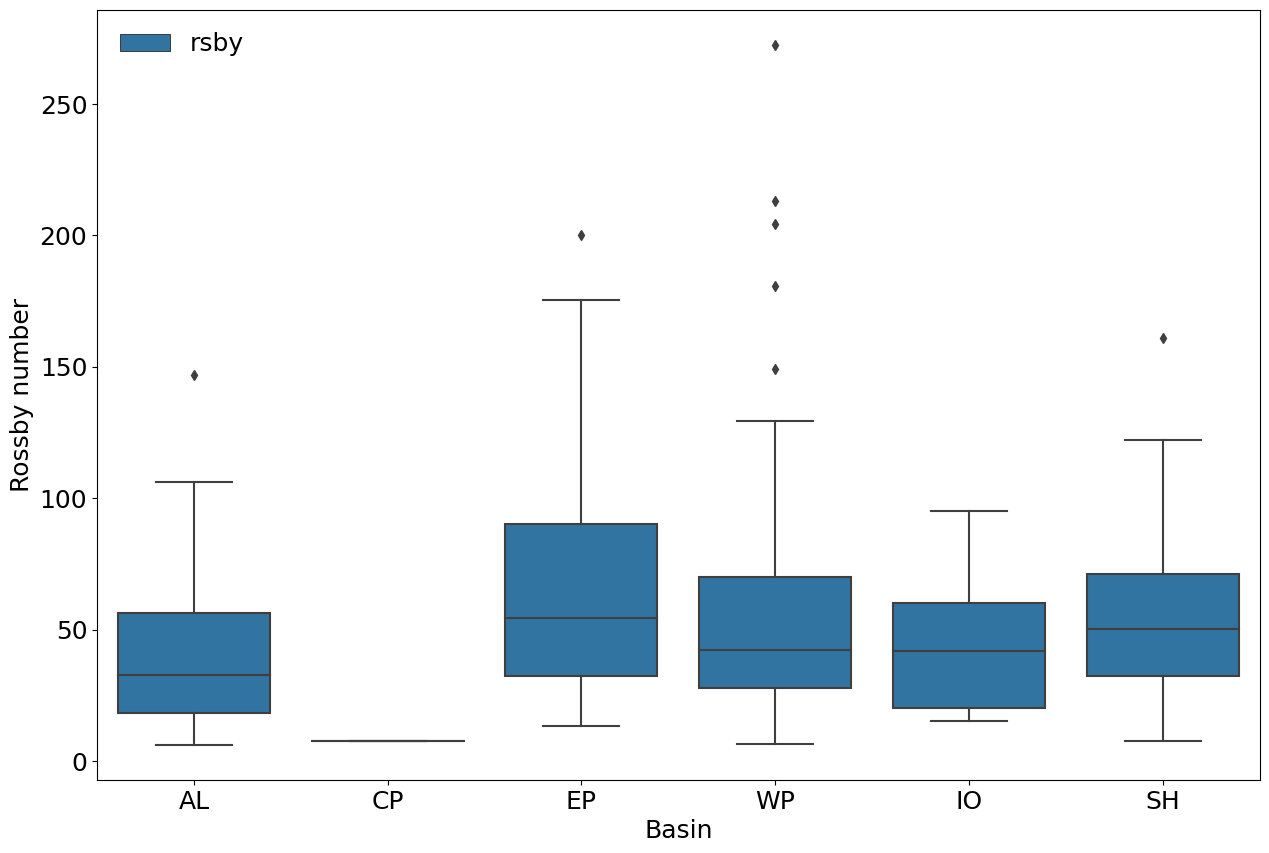

In [19]:
df      = d[['basin_idx', 'rsby']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rsby'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Rossby number')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

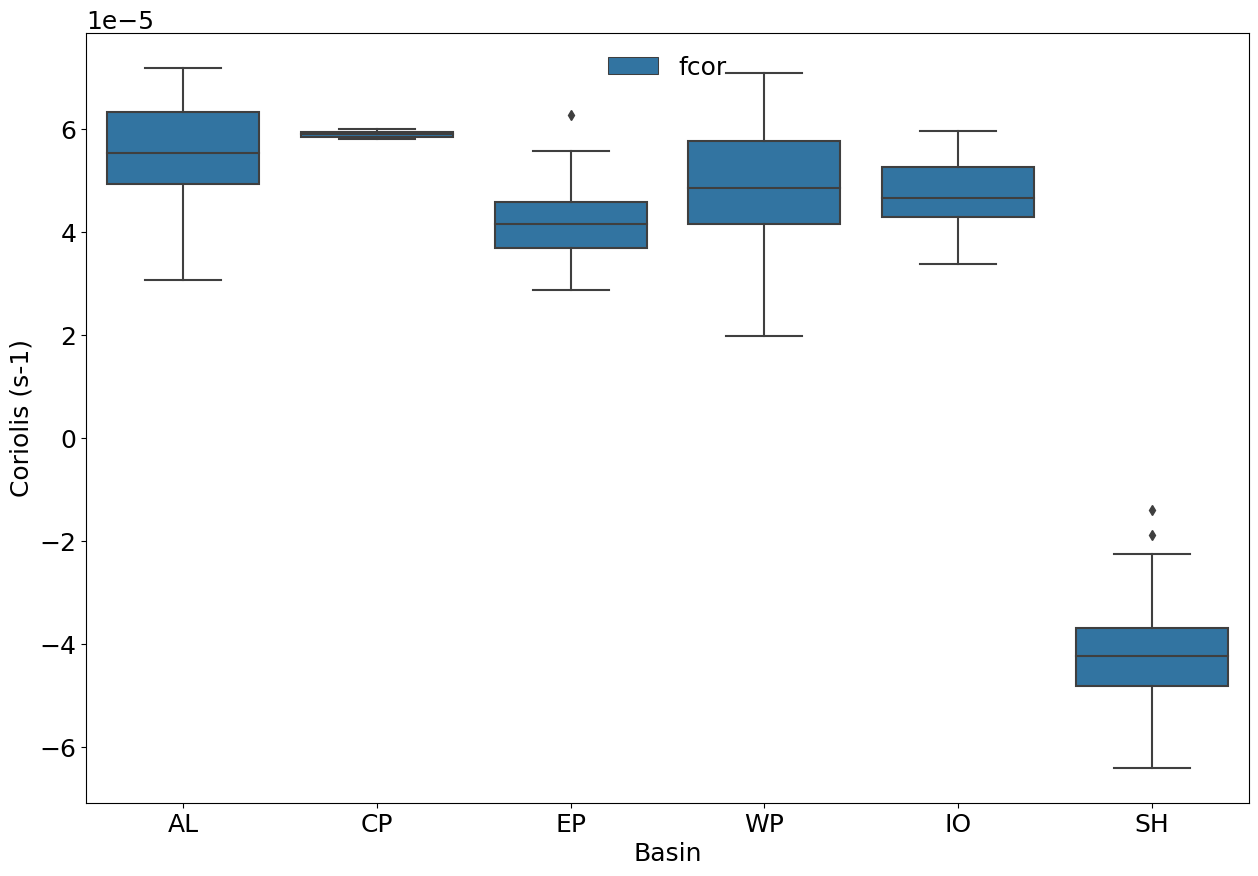

In [20]:
df      = d[['basin_idx', 'fcor']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['fcor'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Coriolis (s-1)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper center')

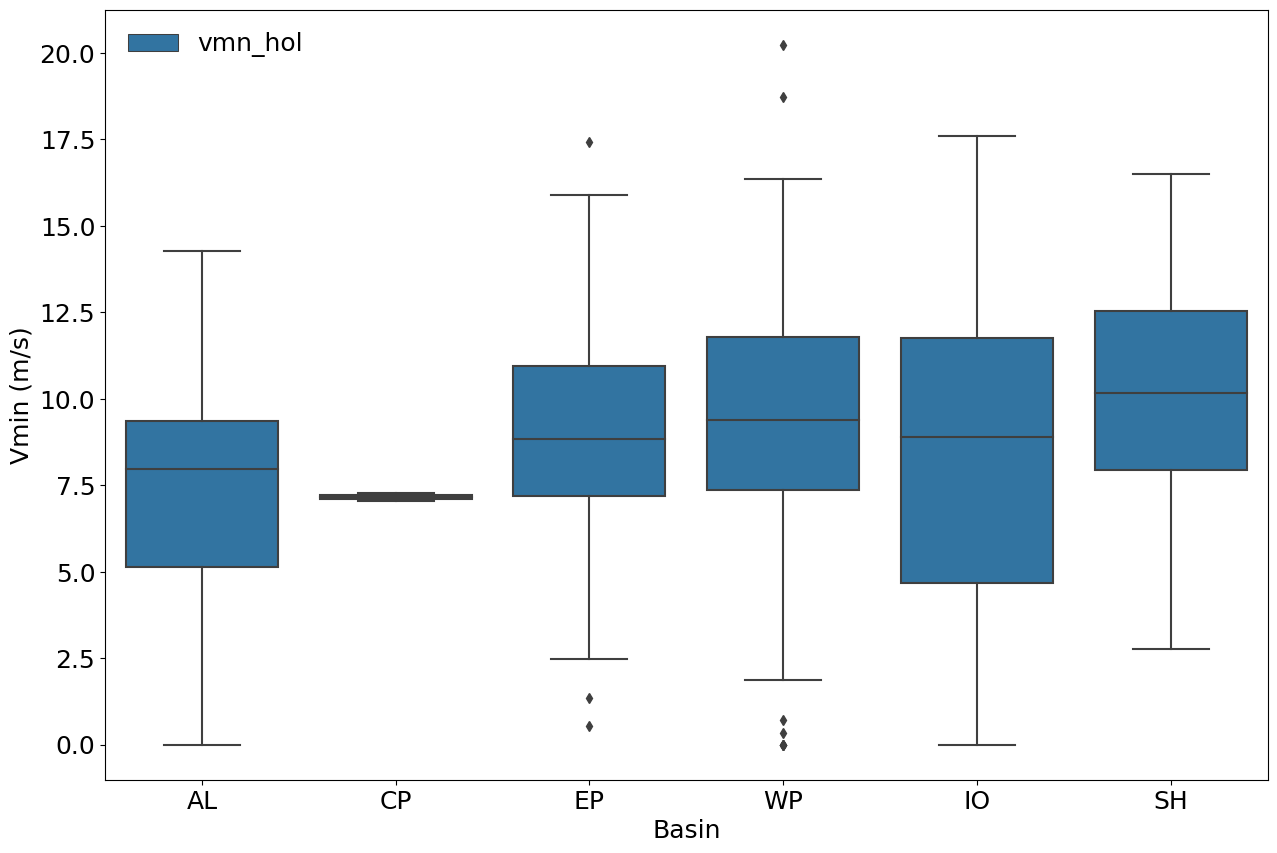

In [21]:
df      = d[['basin_idx', 'vmn_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmn_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Vmin (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

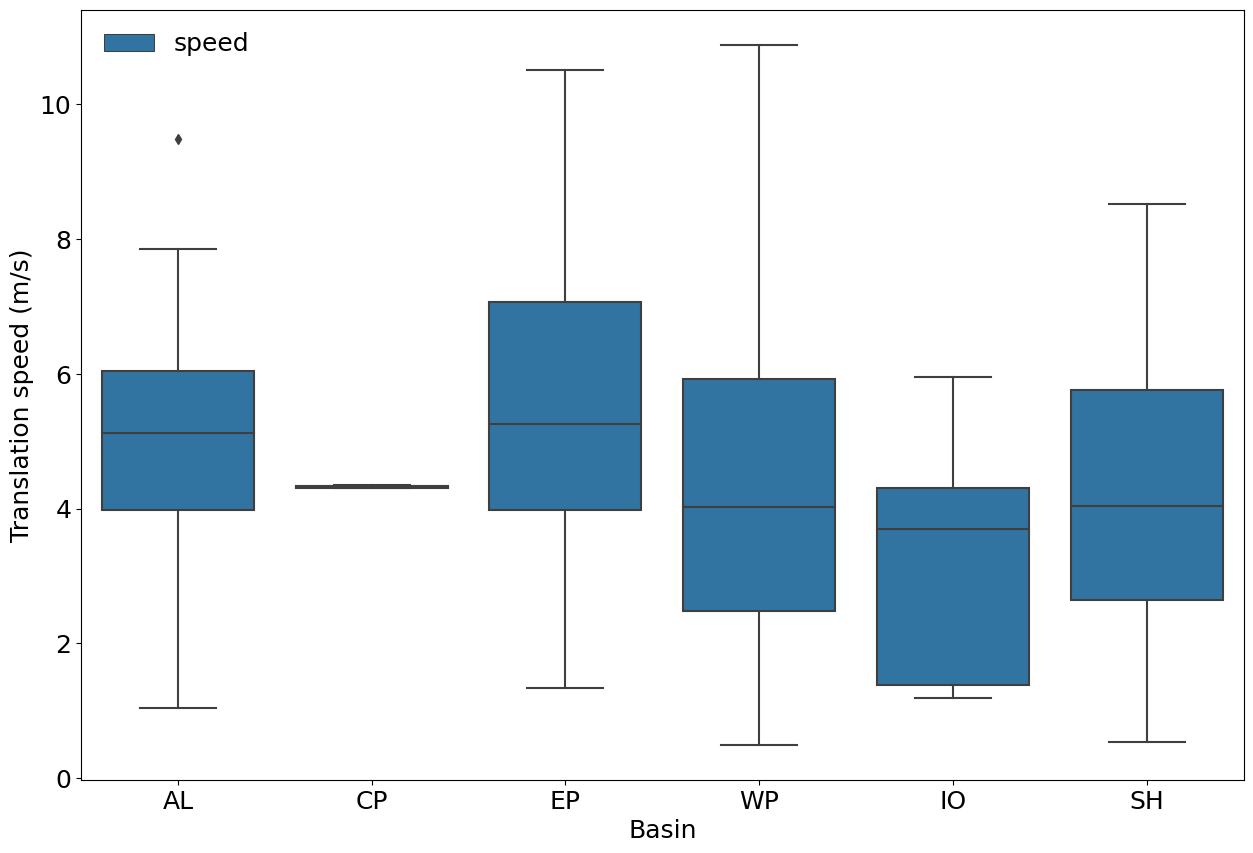

In [22]:
df      = d[['basin_idx', 'speed']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['speed'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Translation speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

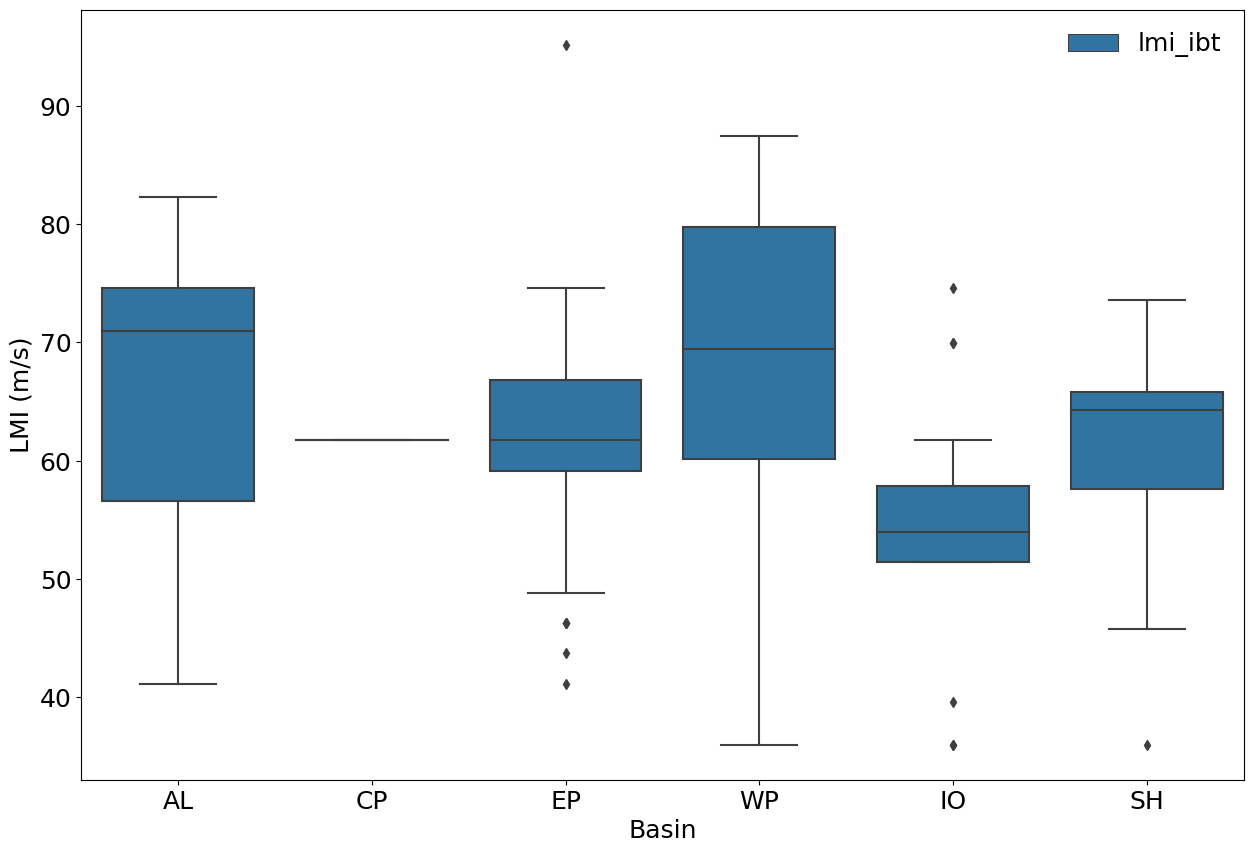

In [23]:
df      = d[['basin_idx', 'lmi_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['lmi_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('LMI (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

/tmp/ipykernel_17544/2202944619.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


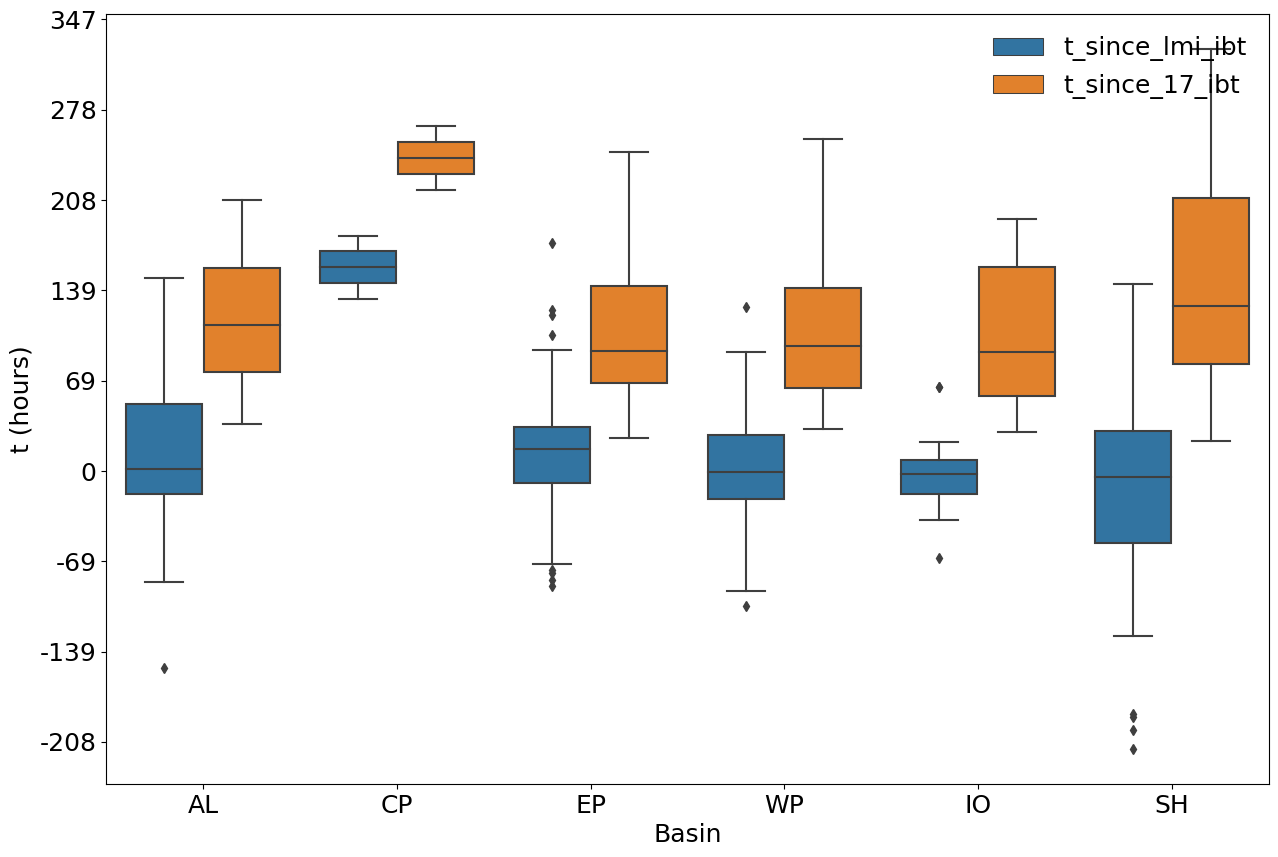

In [24]:
df      = d[['basin_idx', 't_since_lmi_ibt', 't_since_17_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['t_since_lmi_ibt', 't_since_17_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y / 3600) for y in g.get_yticks()]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('t (hours)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

### 3) Dependance by basin

In [25]:
da = d.where(d.basin == 'al', drop=True)
dc = d.where(d.basin == 'cp', drop=True)
de = d.where(d.basin == 'ep', drop=True)
di = d.where(d.basin == 'io', drop=True)
ds = d.where(d.basin == 'sh', drop=True)
dw = d.where(d.basin == 'wp', drop=True)

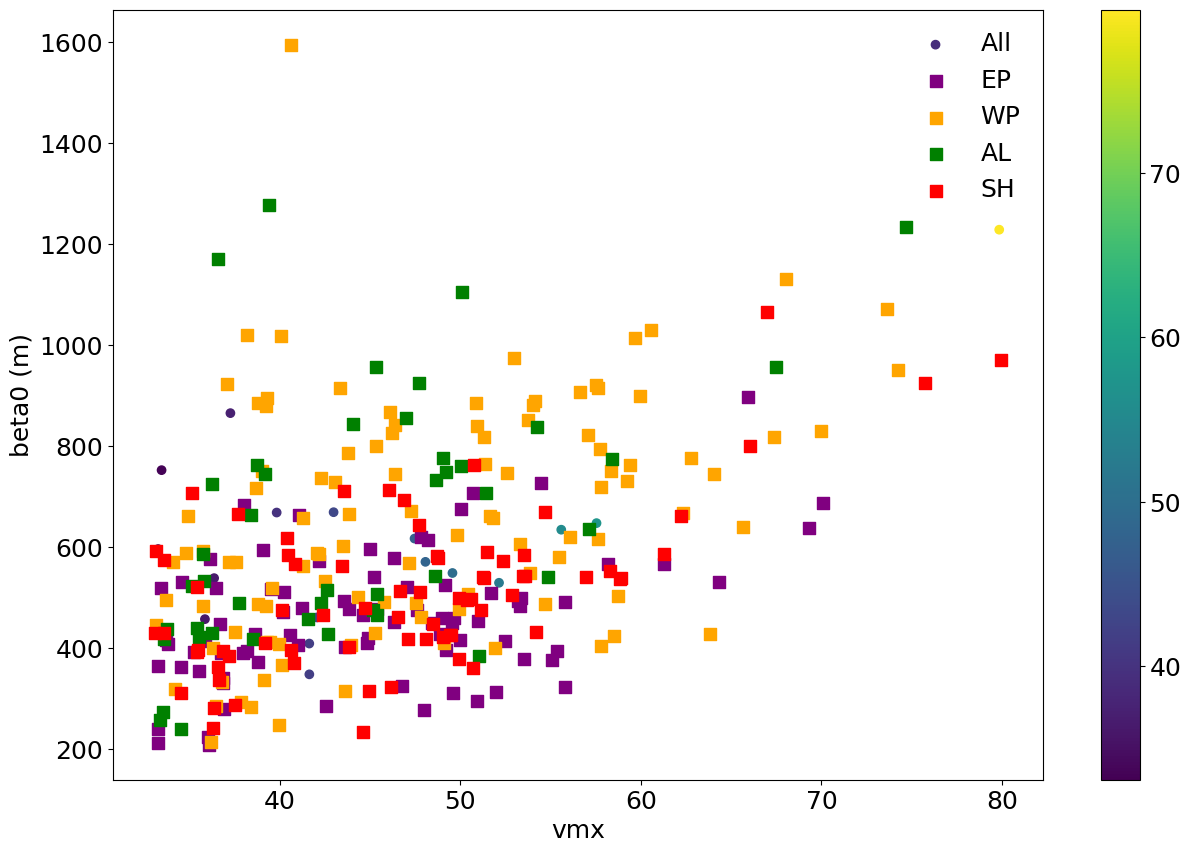

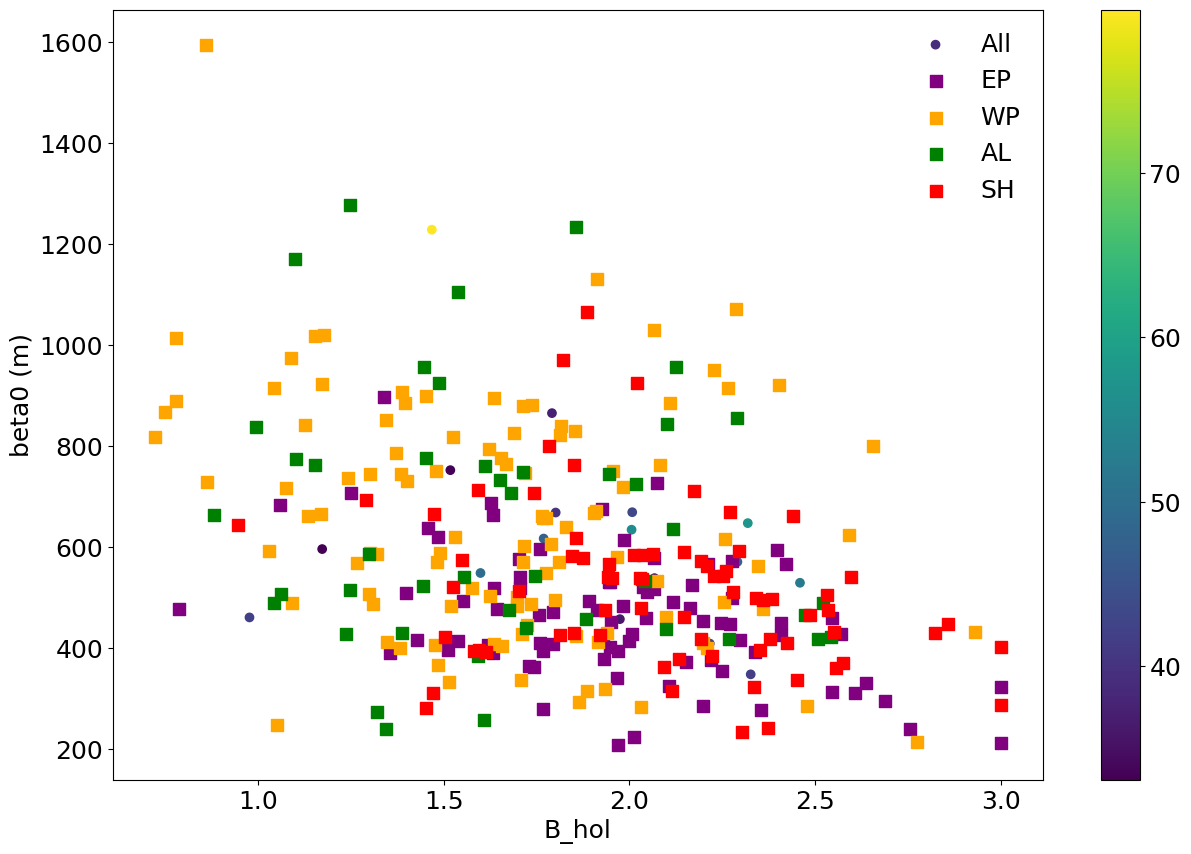

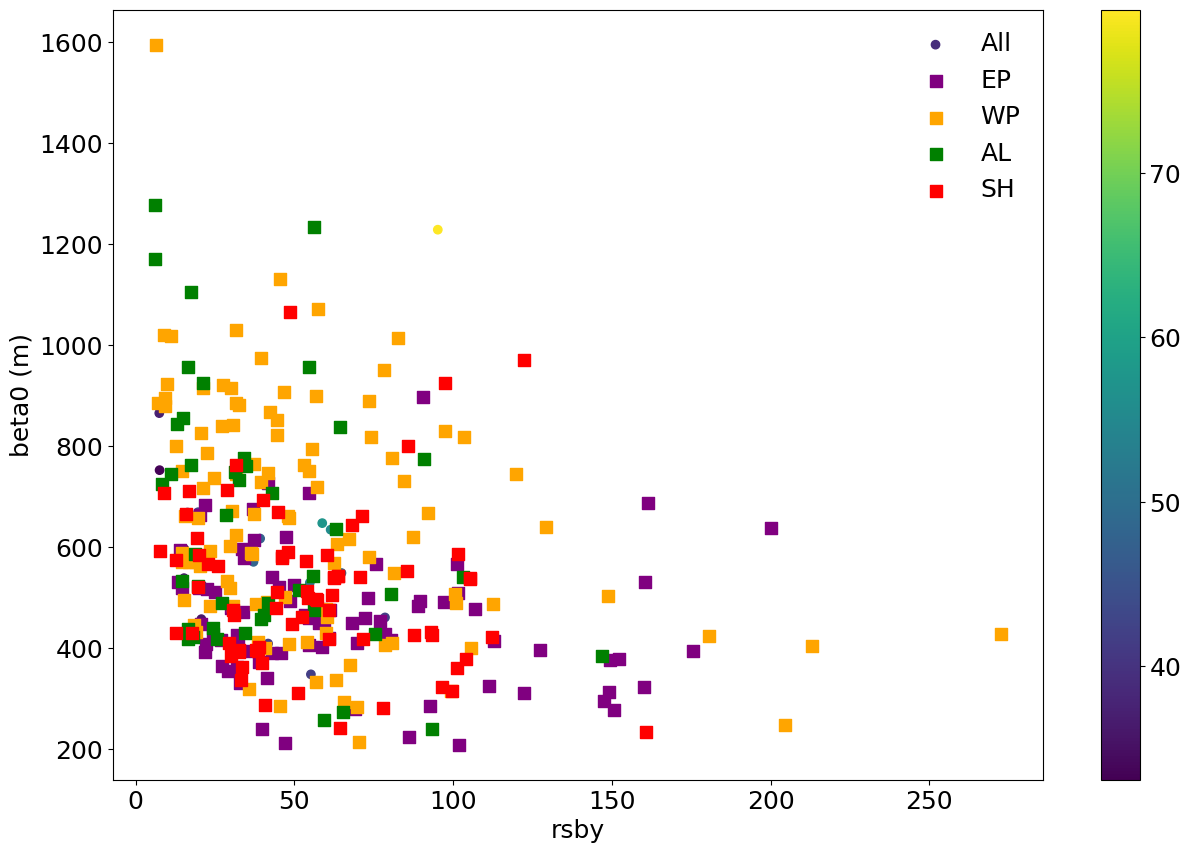

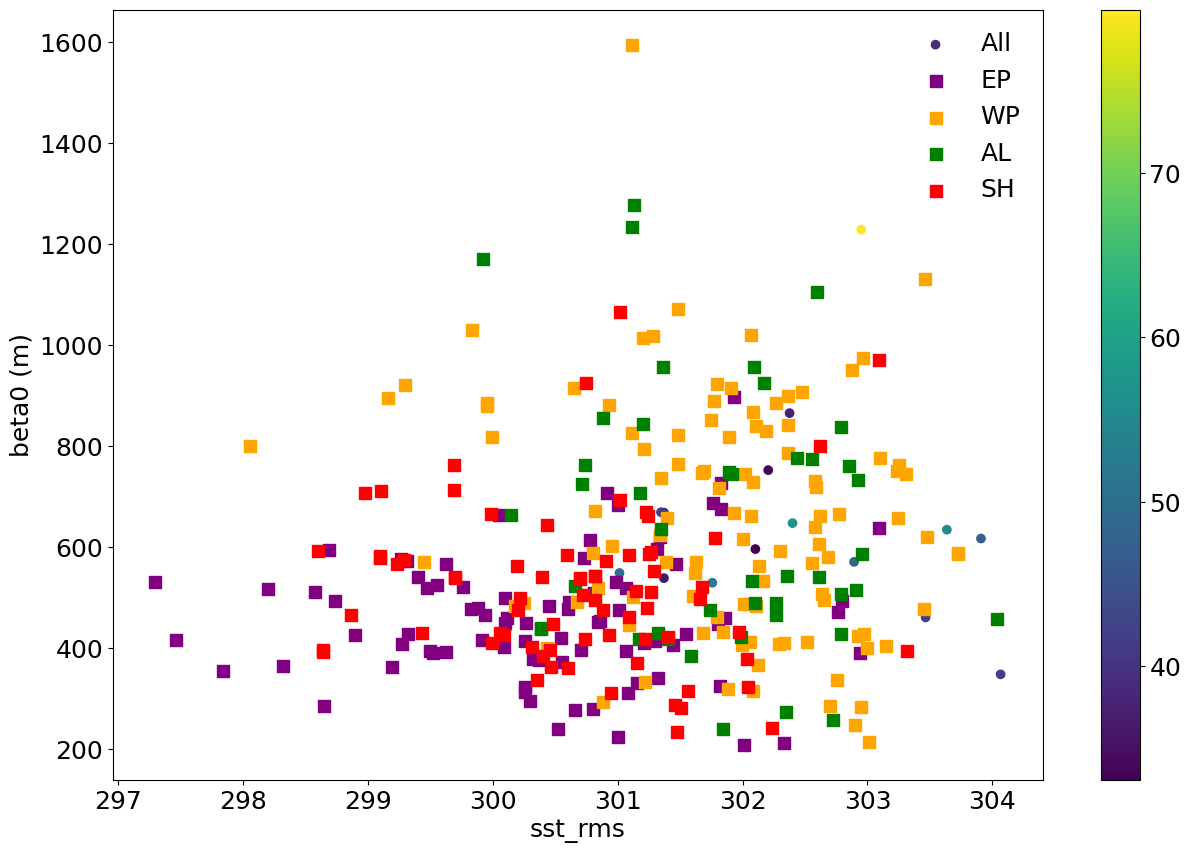

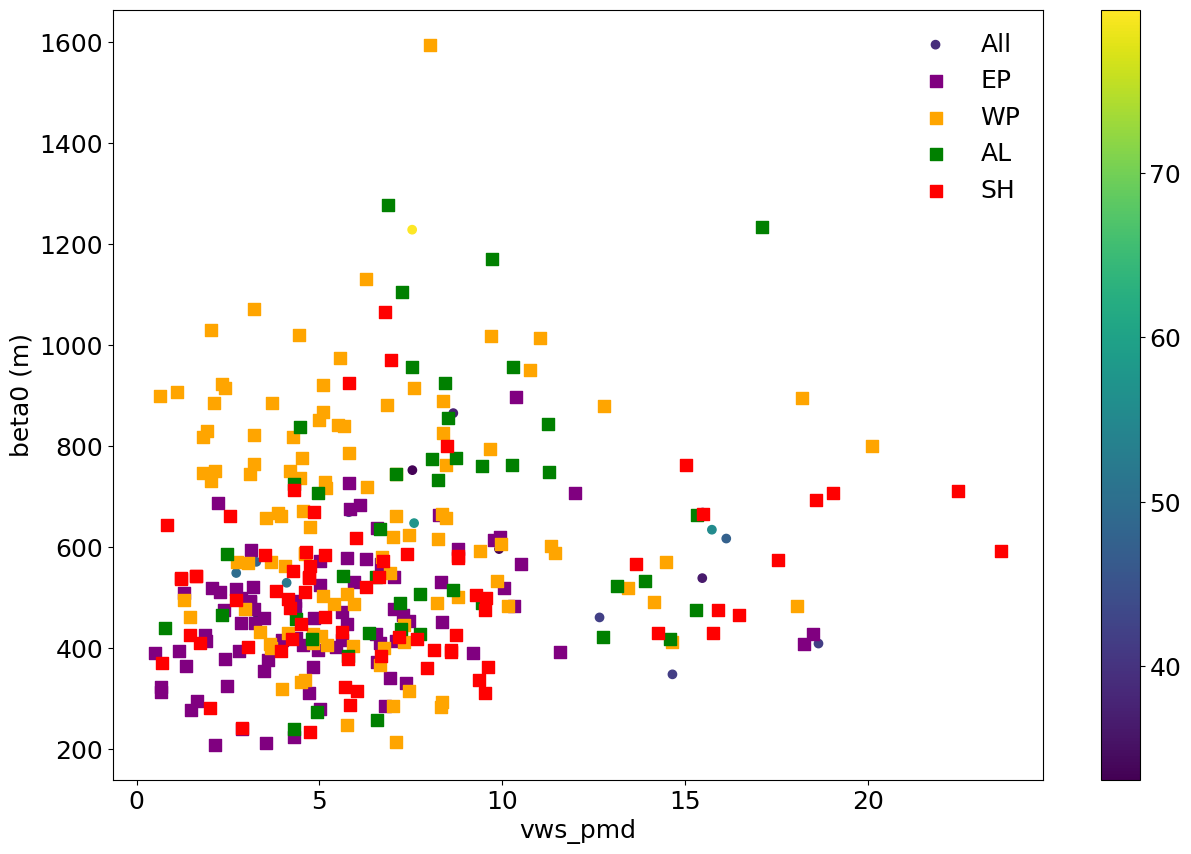

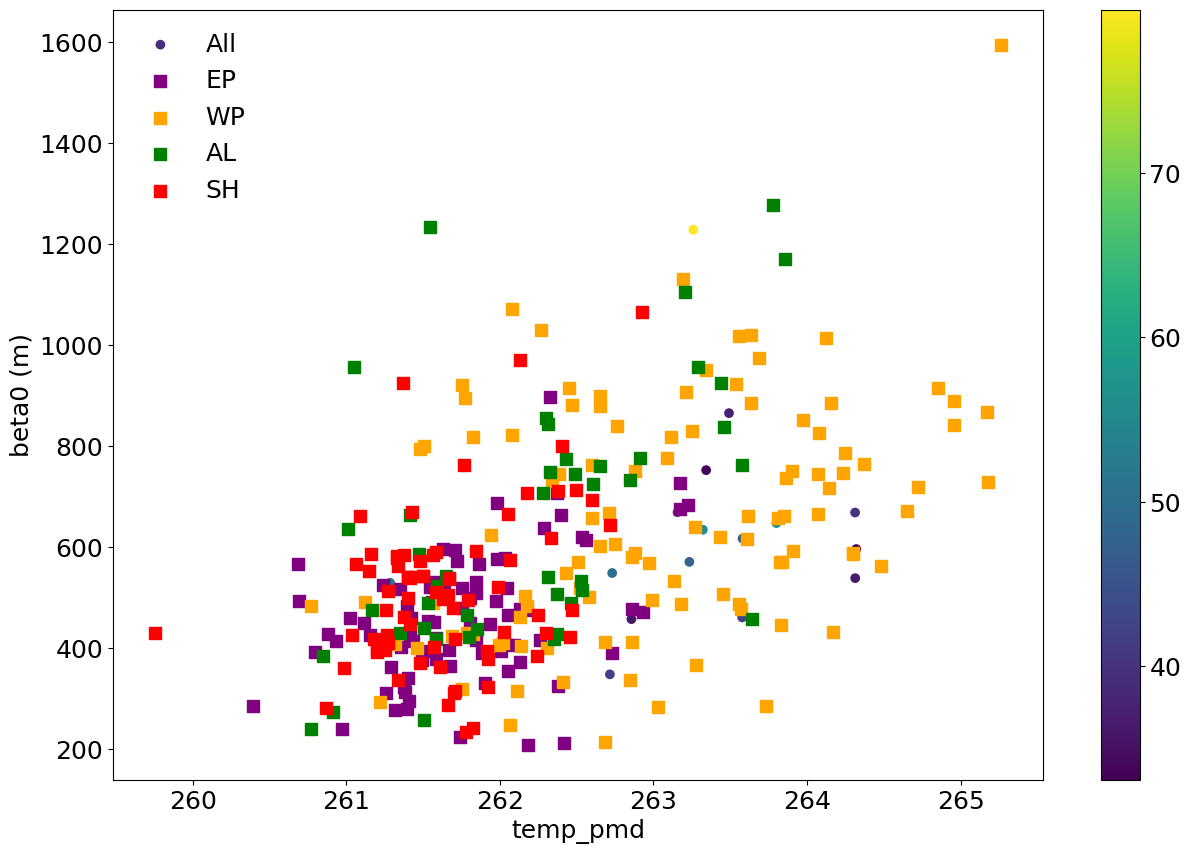

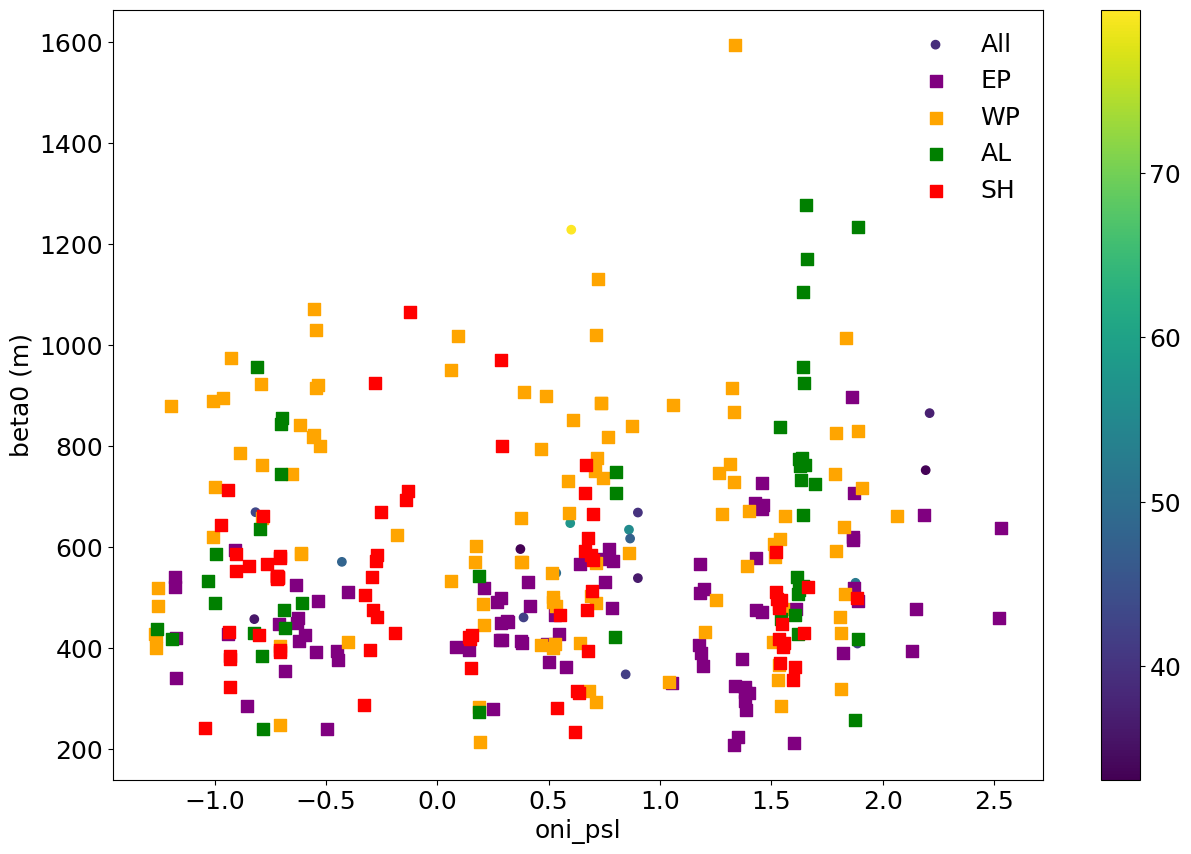

In [26]:
for prm in ['vmx', 'B_hol', 'rsby', 'sst_rms', 'vws_pmd', 'temp_pmd', 'oni_psl']:
    plt.scatter(d[prm],  d.beta0,  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de.beta0, c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw.beta0, c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da.beta0, c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds.beta0, c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('beta0 (m)')
    plt.show()

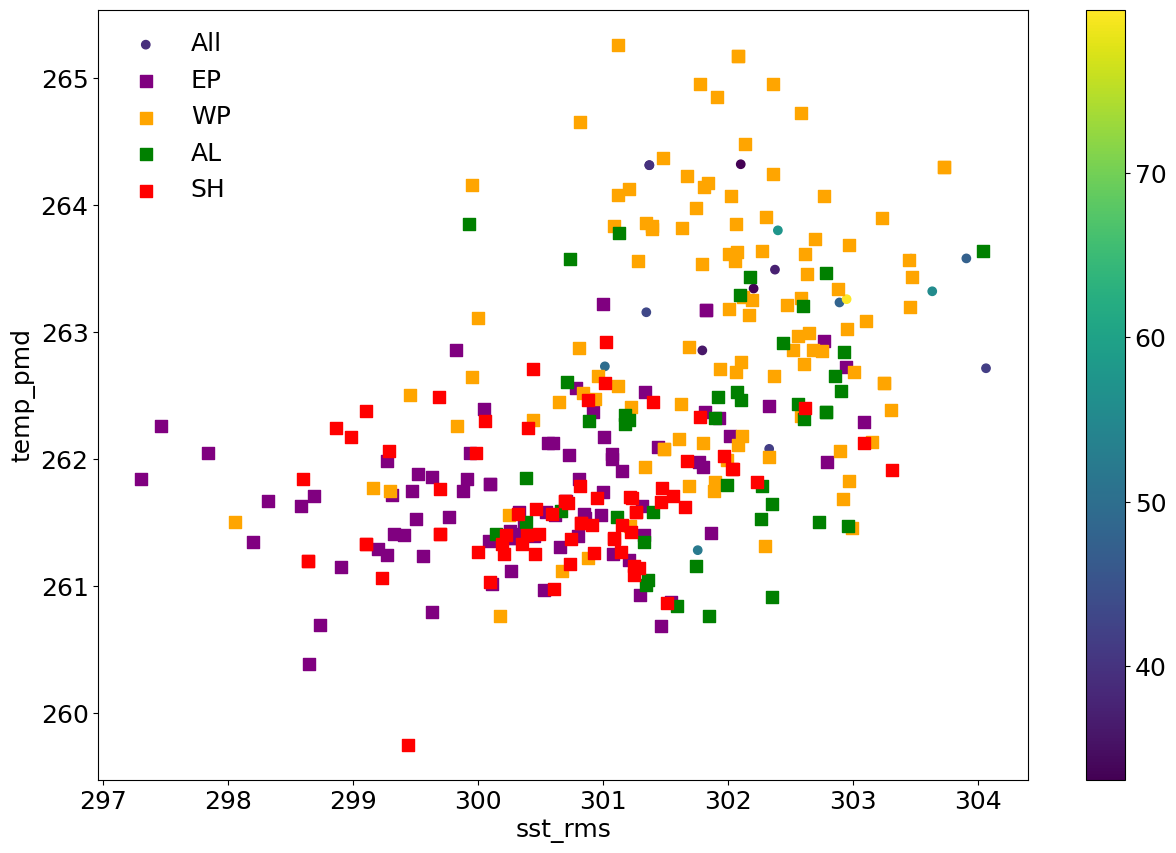

In [27]:
y = 'temp_pmd'

for prm in ['sst_rms']:
    plt.scatter(d[prm],  d[y],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel(y)
    plt.show()

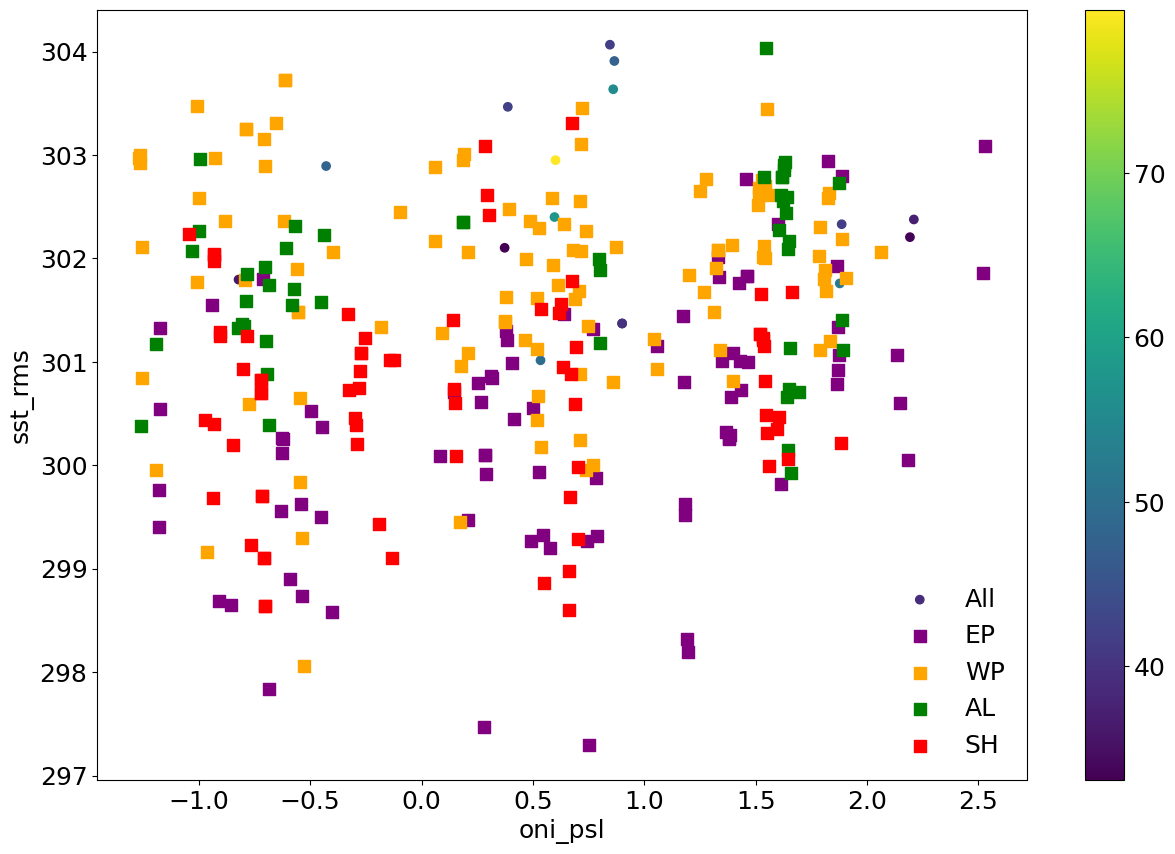

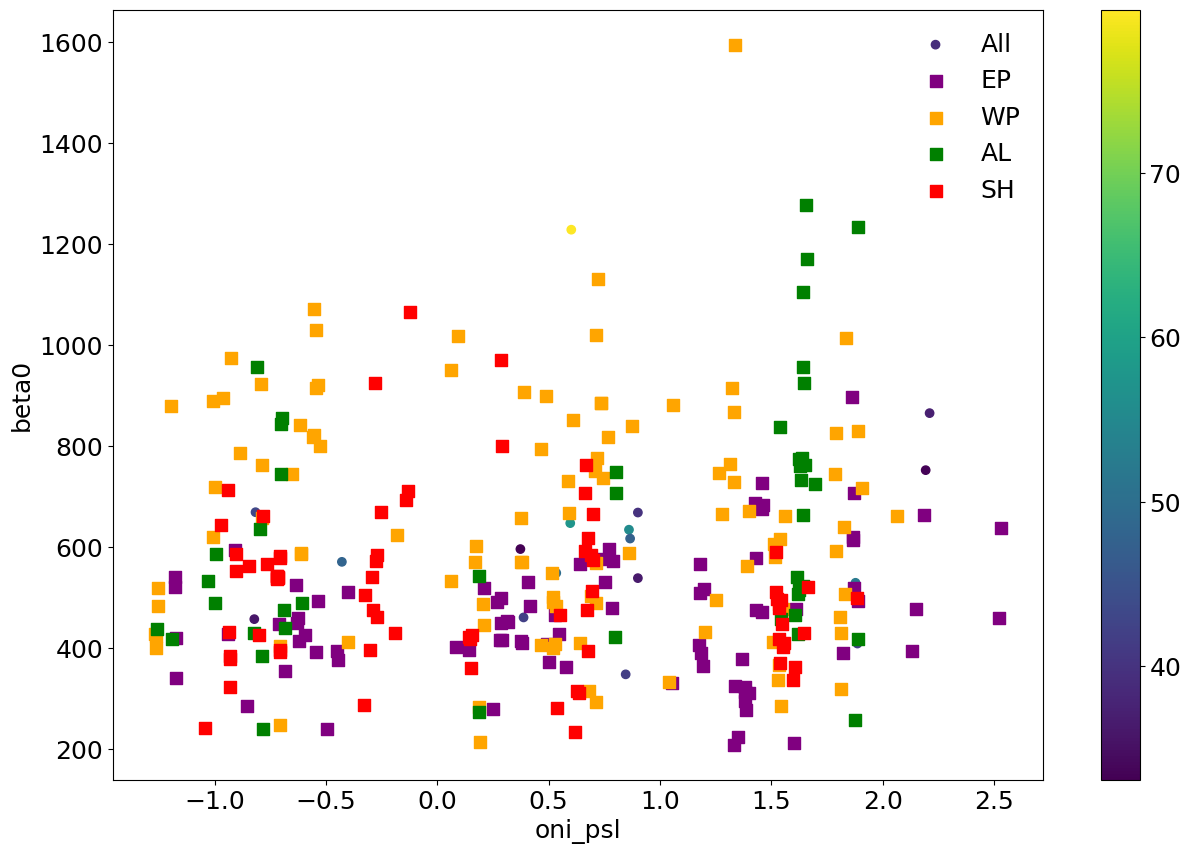

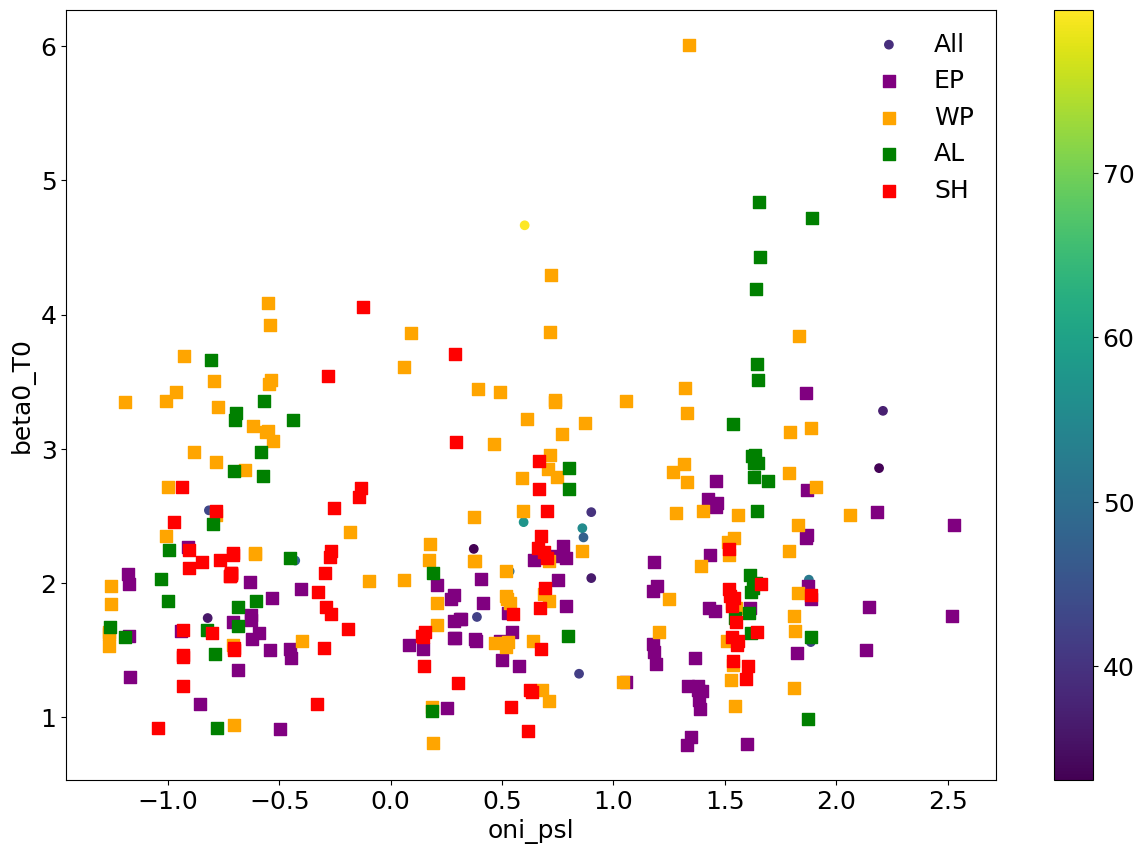

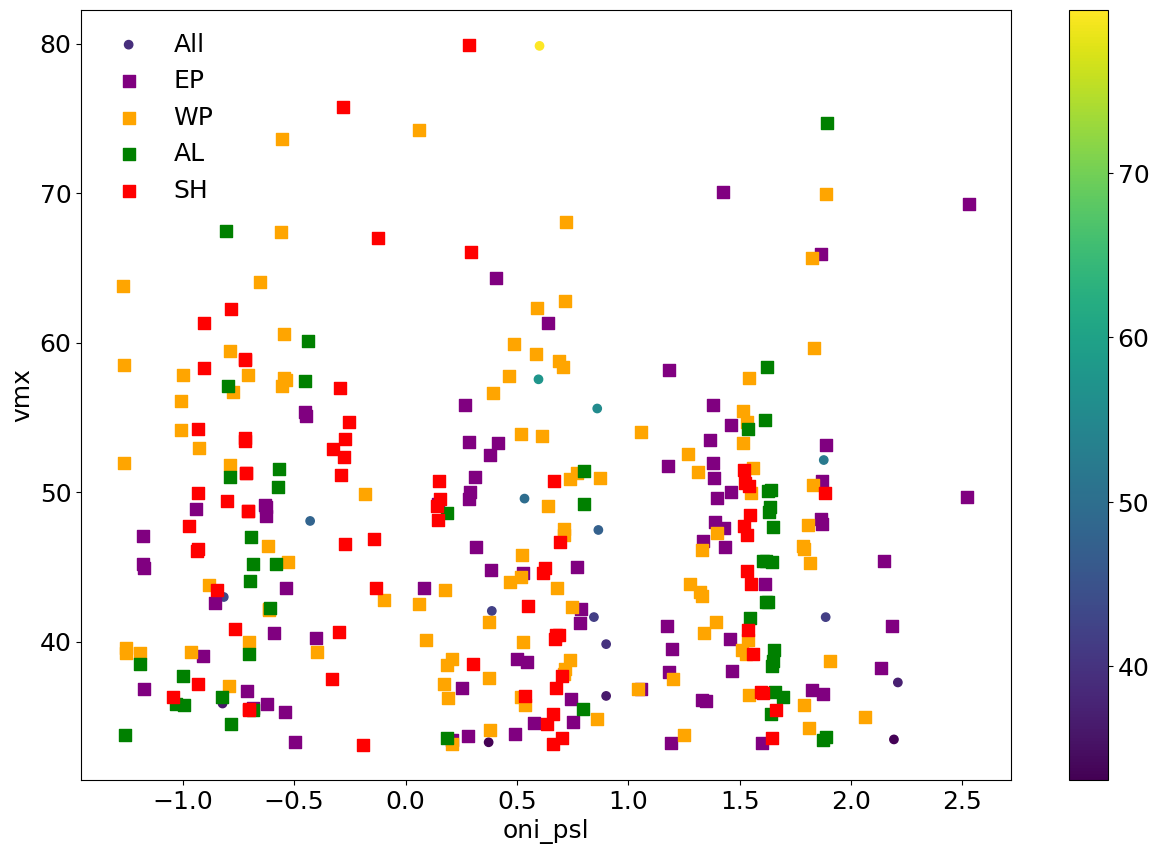

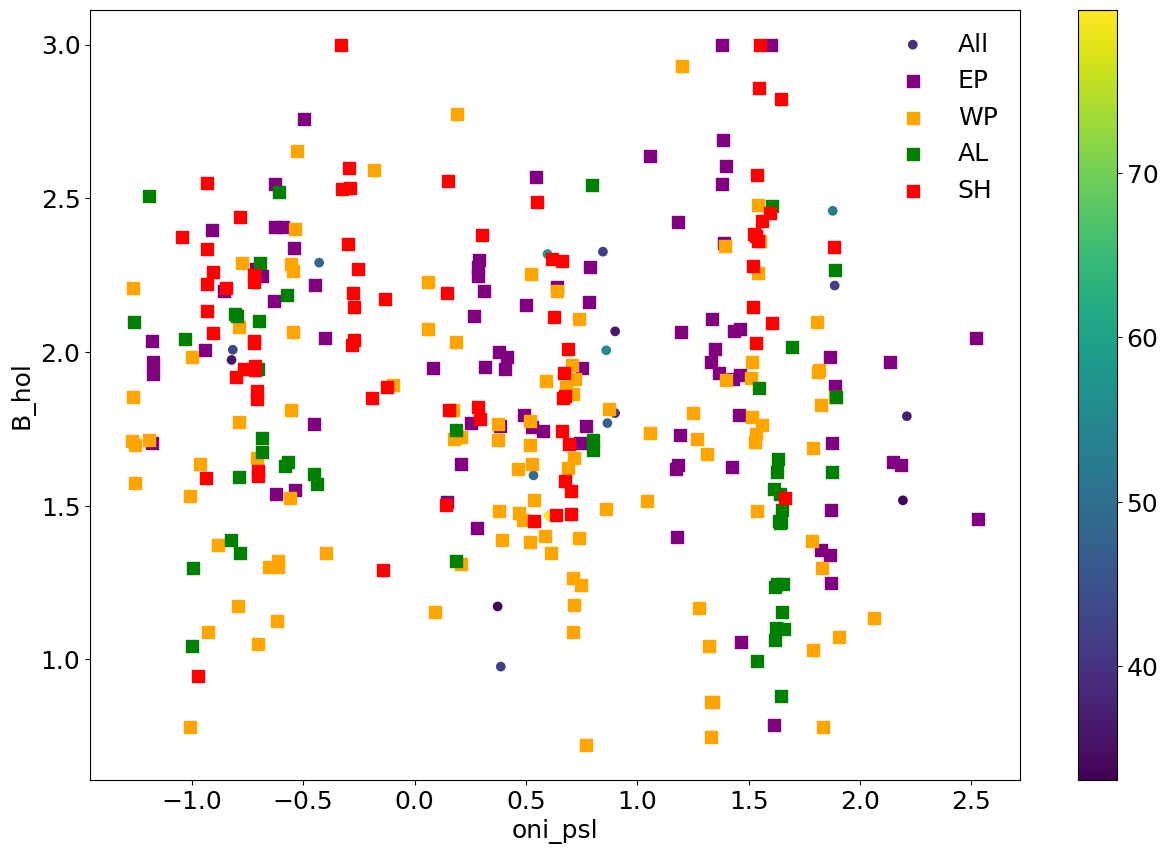

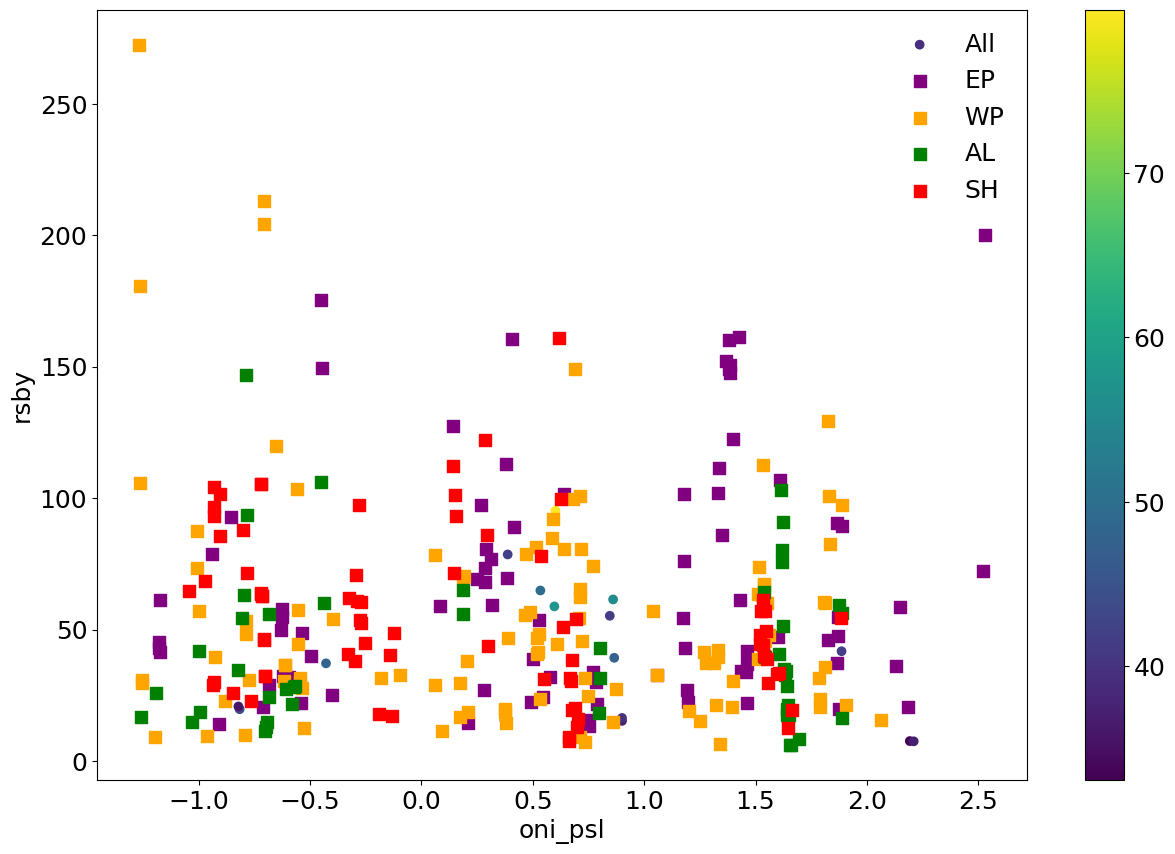

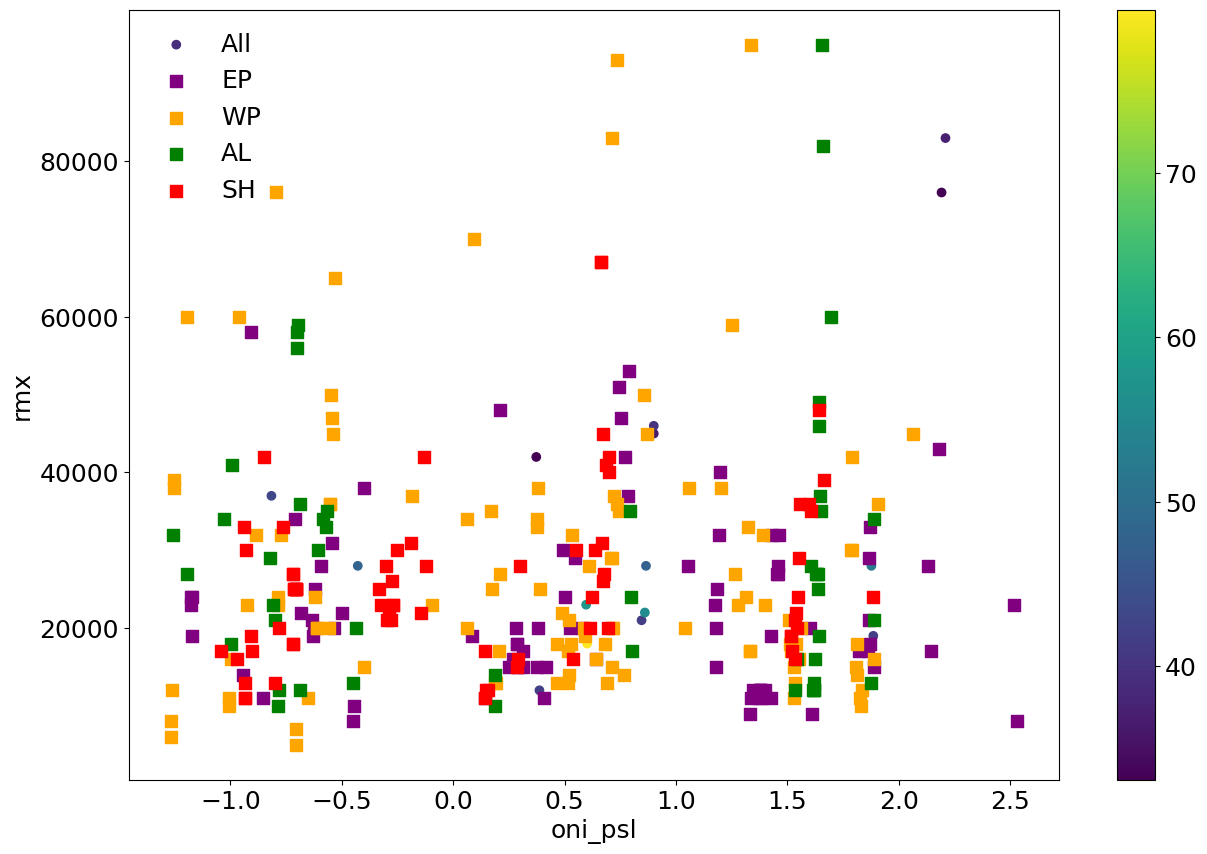

In [28]:
x = 'oni_psl'

for prm in ['sst_rms', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(d[x],  d[prm],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[x], de[prm], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[x], dw[prm], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[x], da[prm], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[x], ds[prm], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

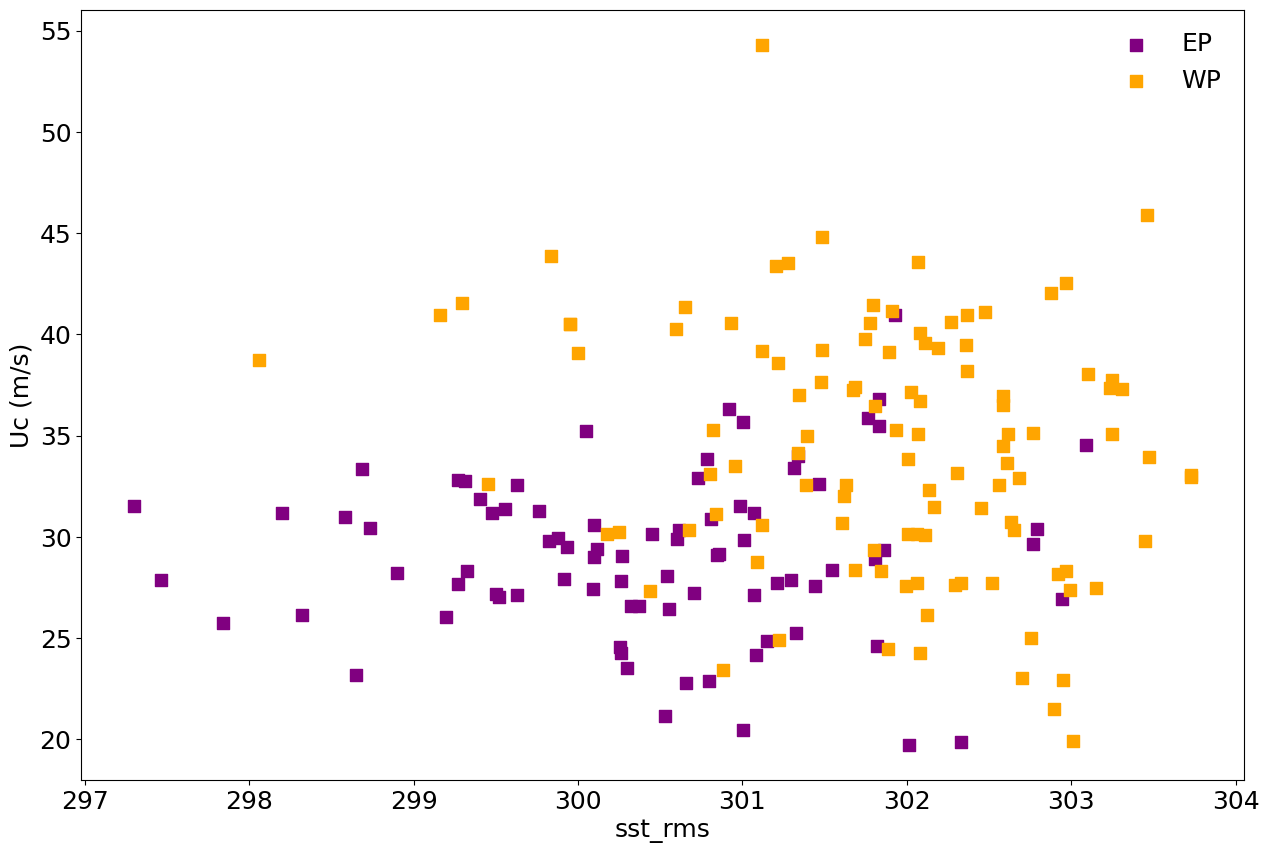

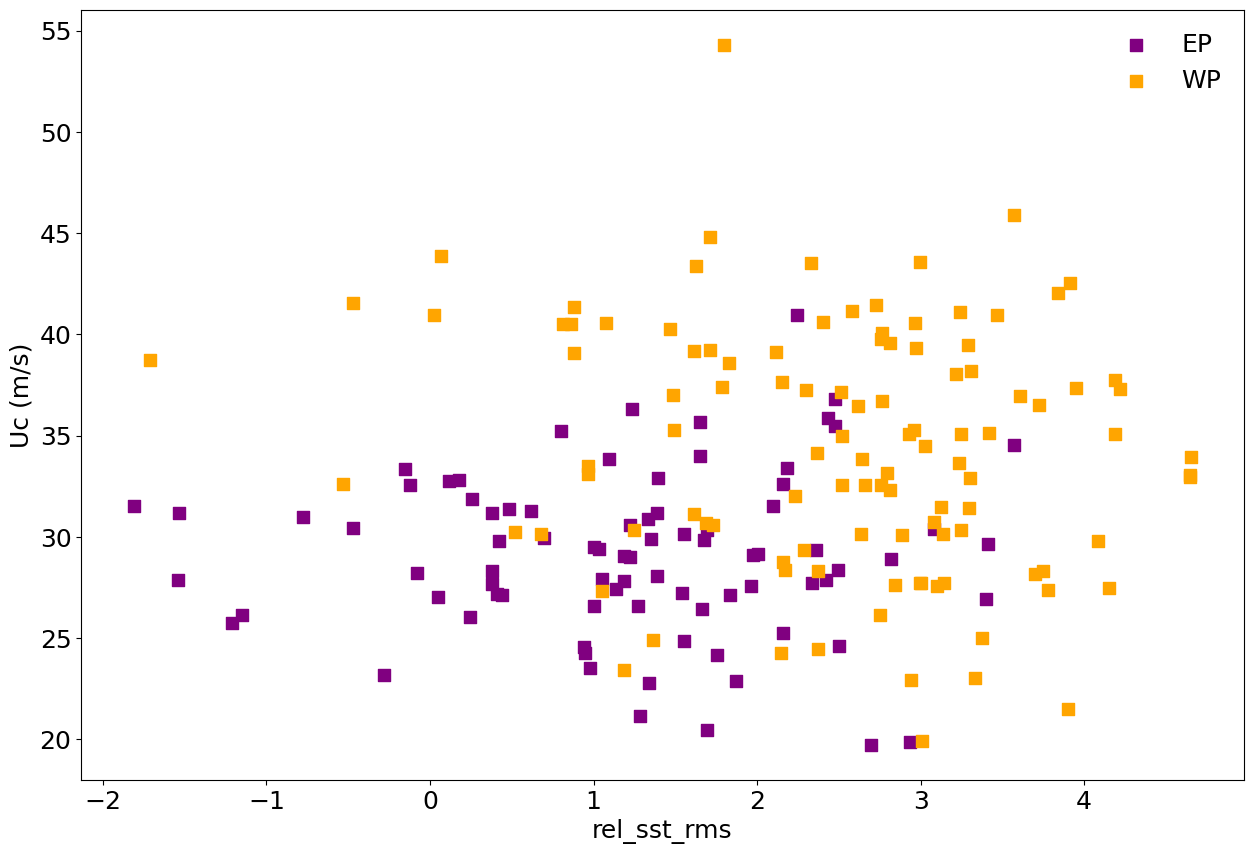

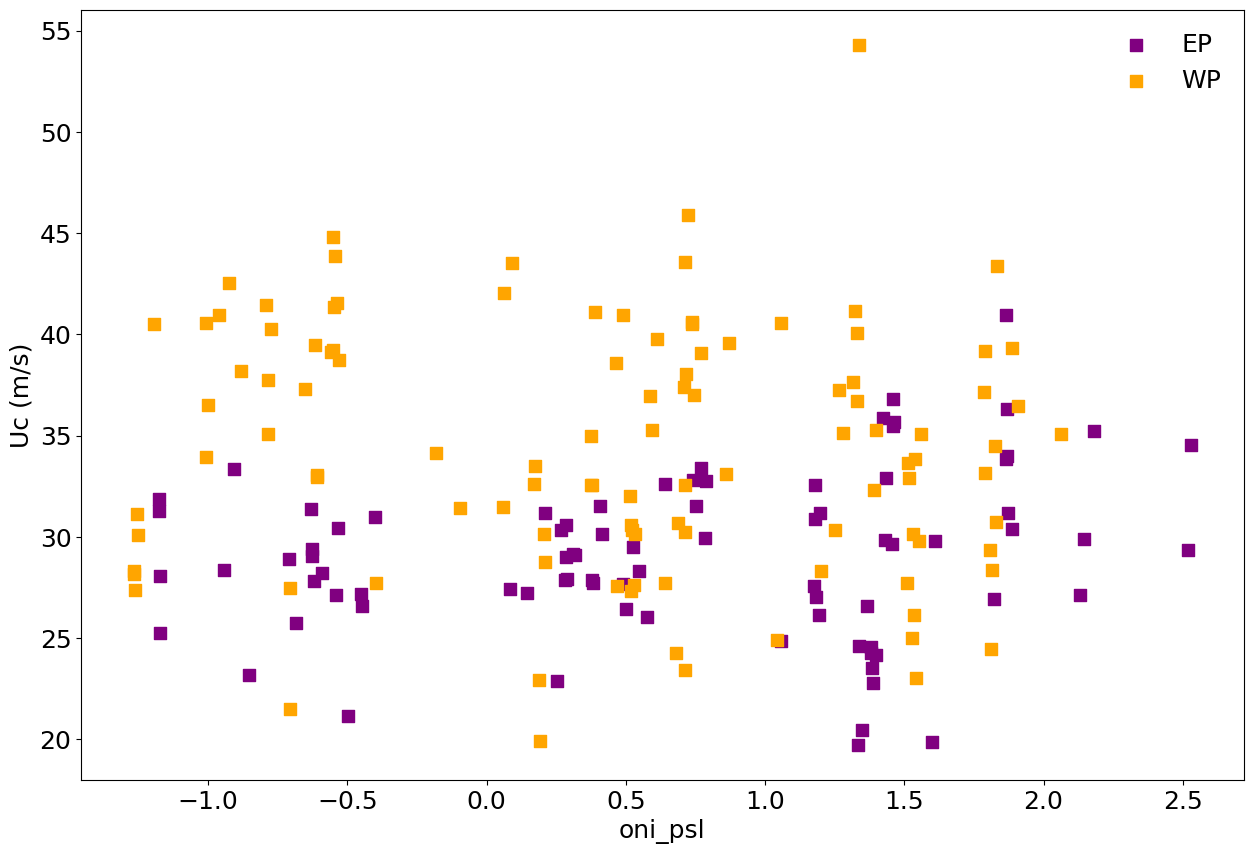

In [29]:
### SYNTHESIS
y = 'uc'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Uc (m/s)')
    plt.show()

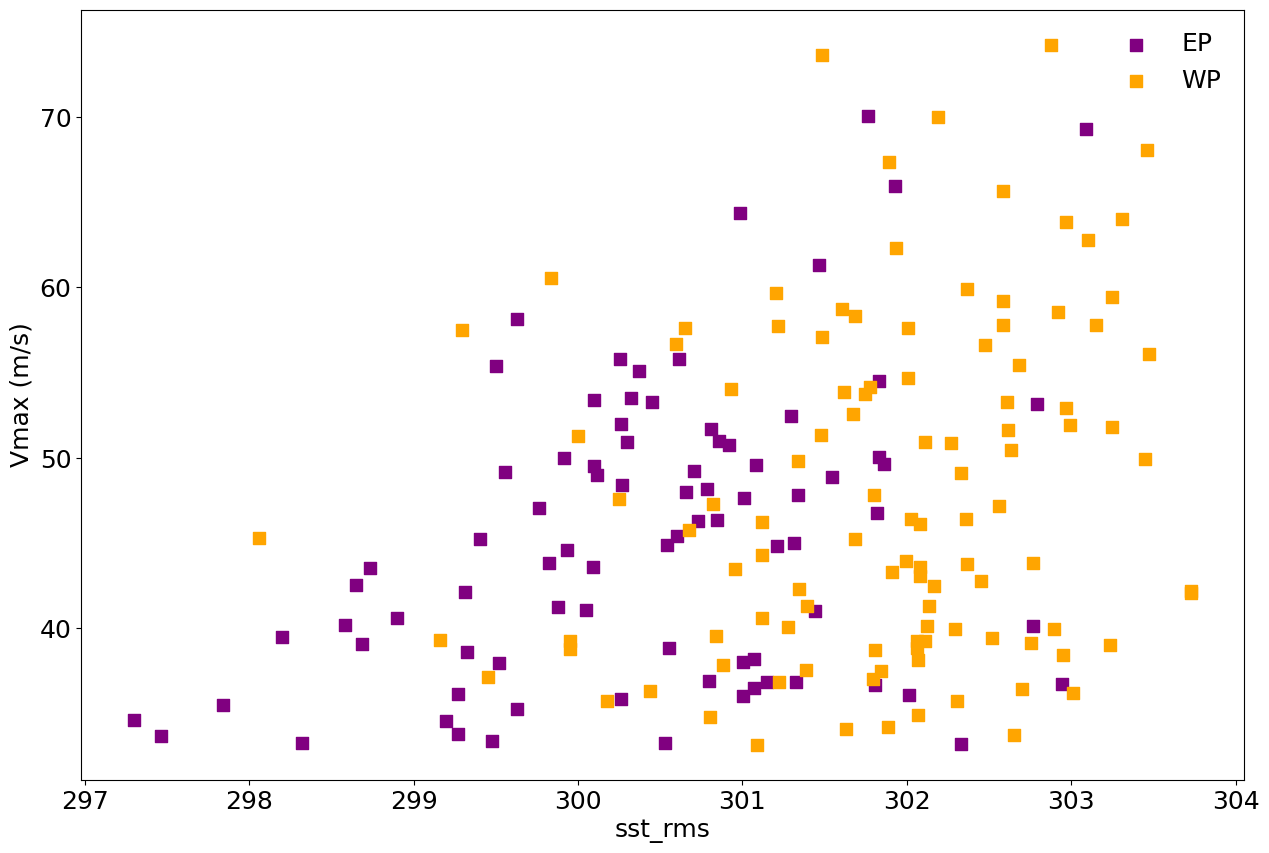

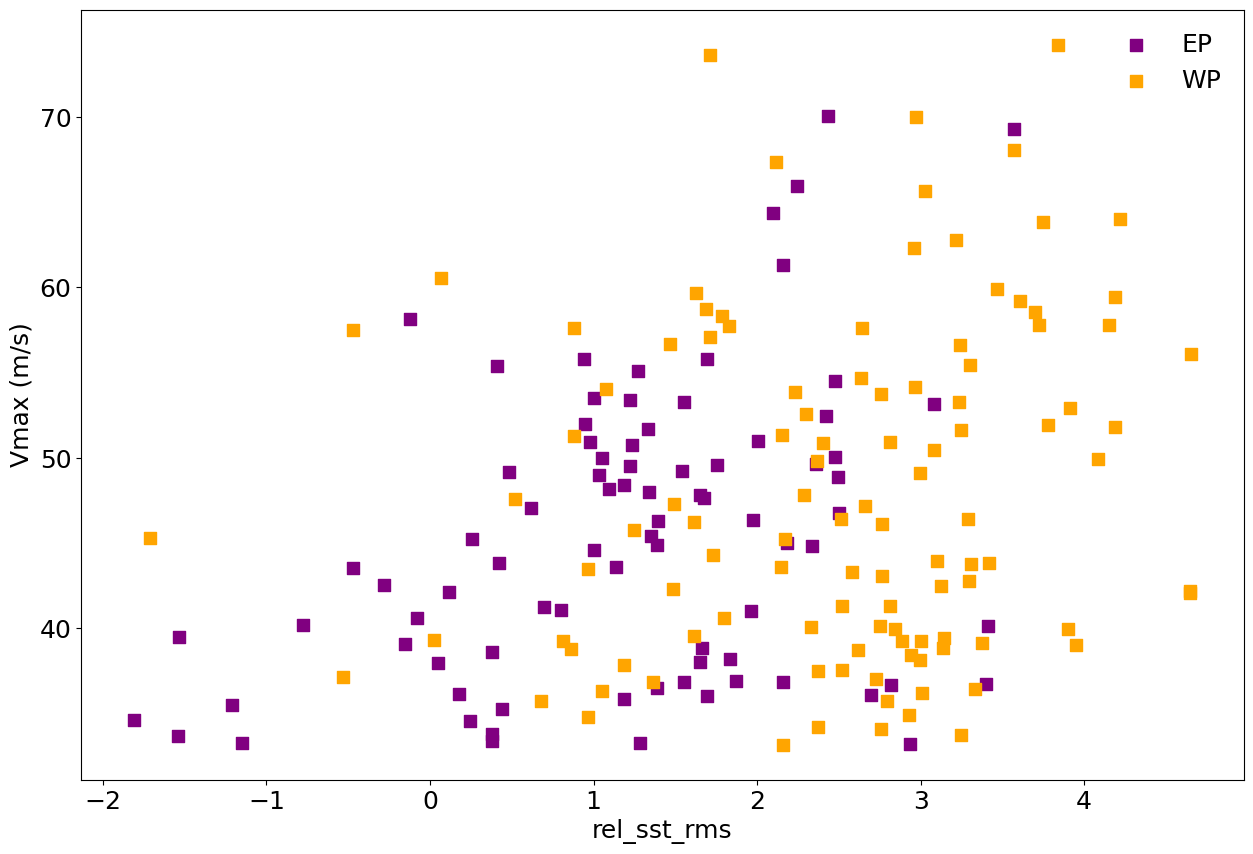

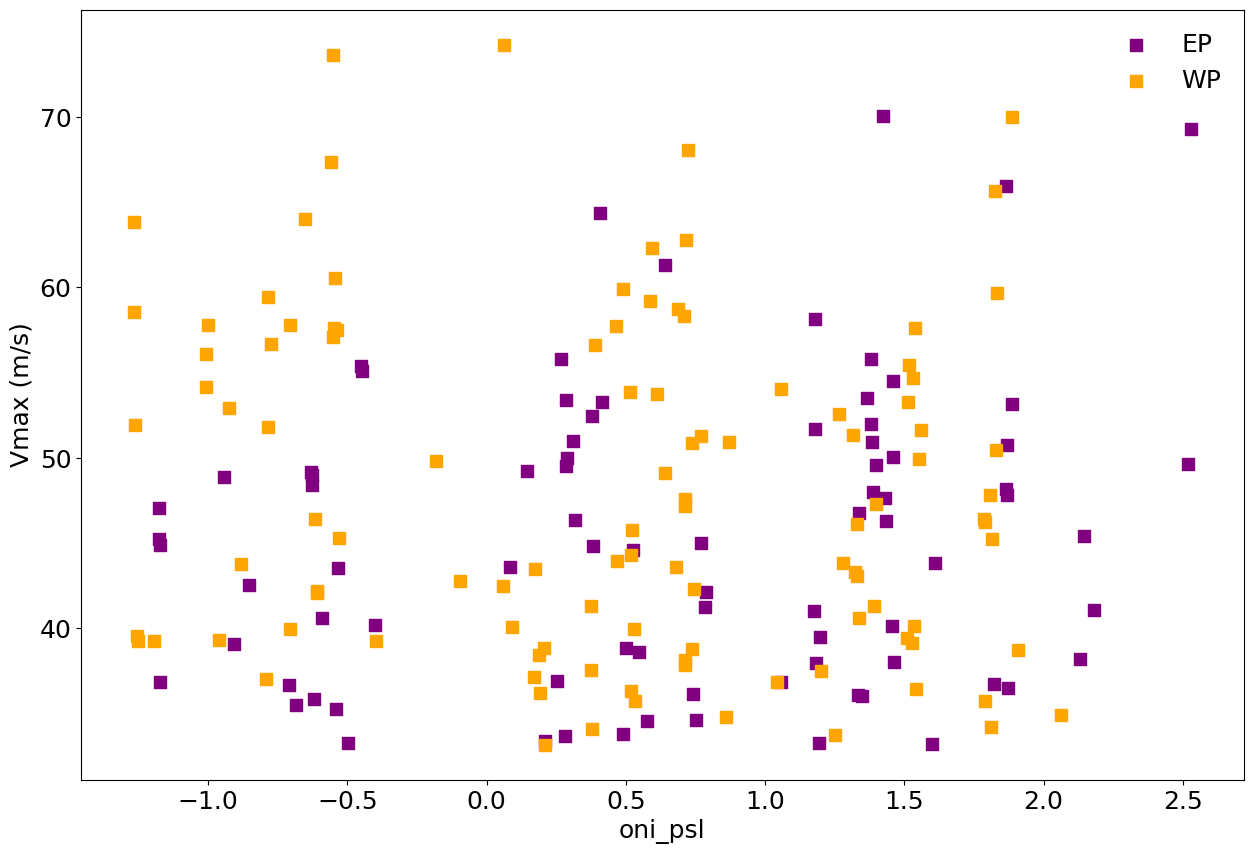

In [30]:
### SYNTHESIS
y = 'vmx'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Vmax (m/s)')
    plt.show()

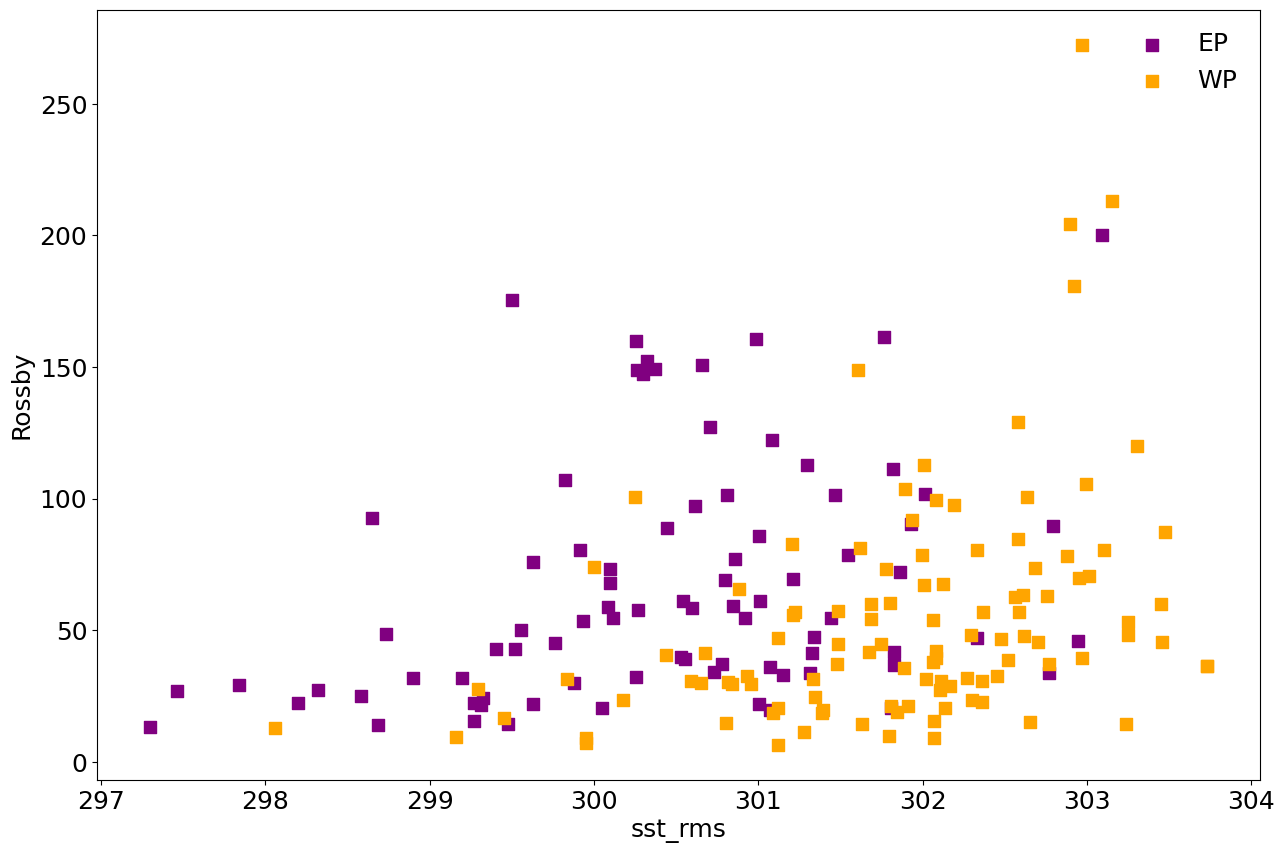

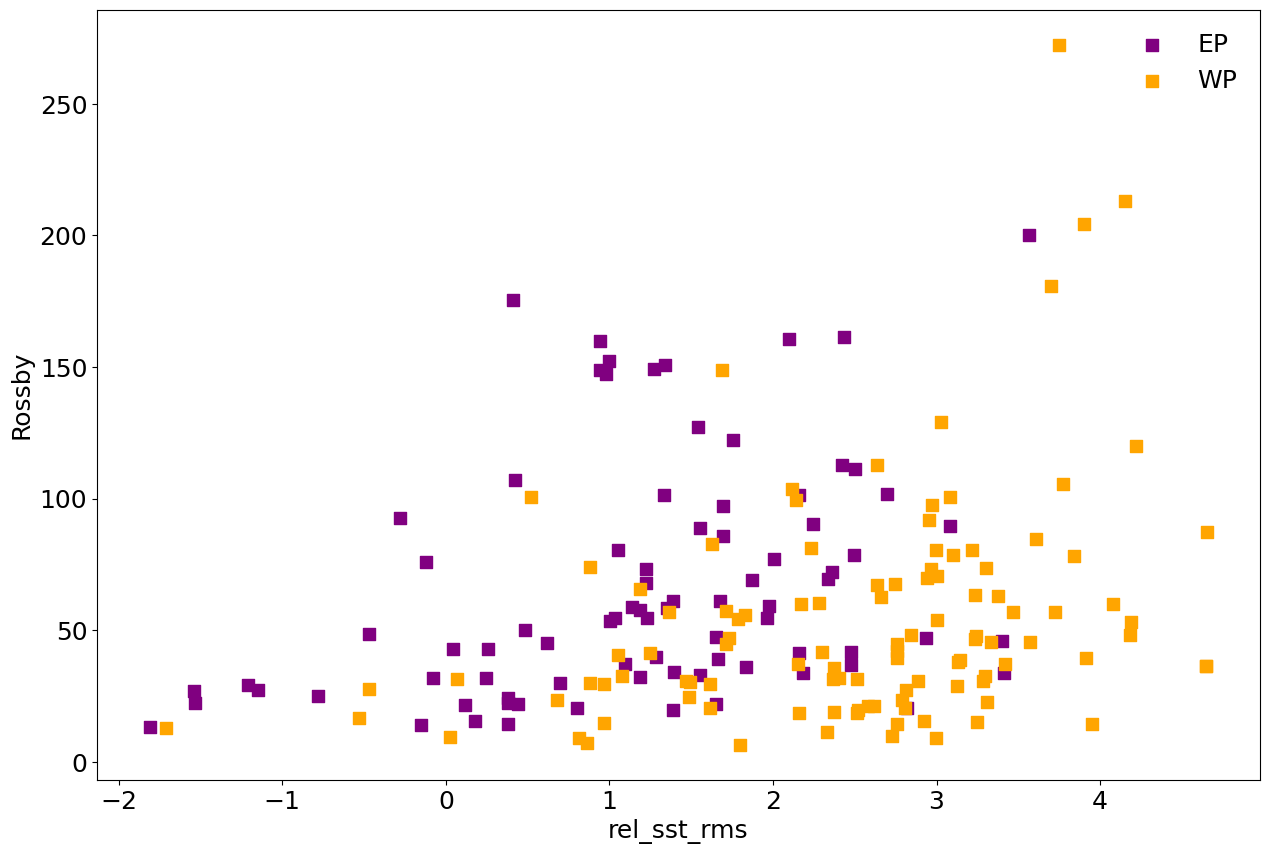

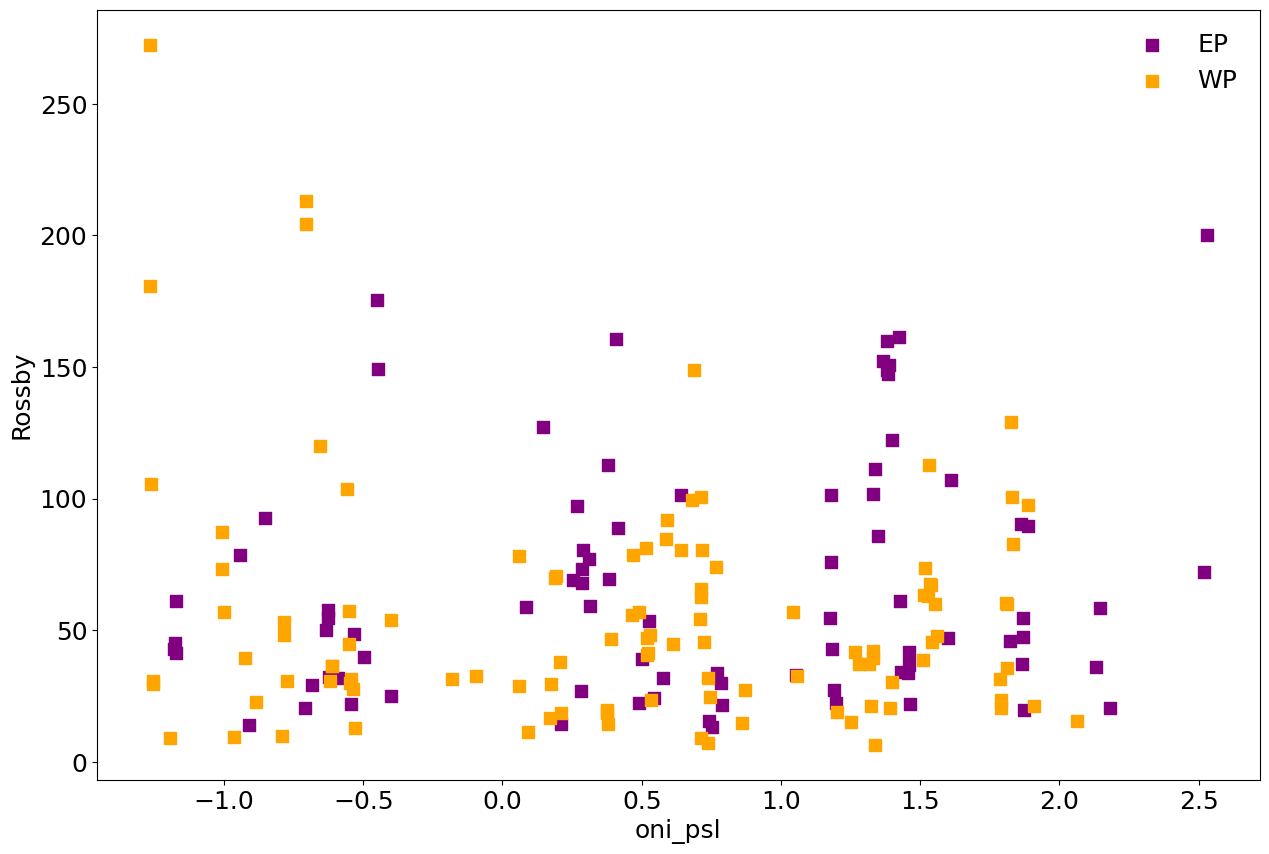

In [31]:
### SYNTHESIS
y = 'rsby'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Rossby')
    plt.show()

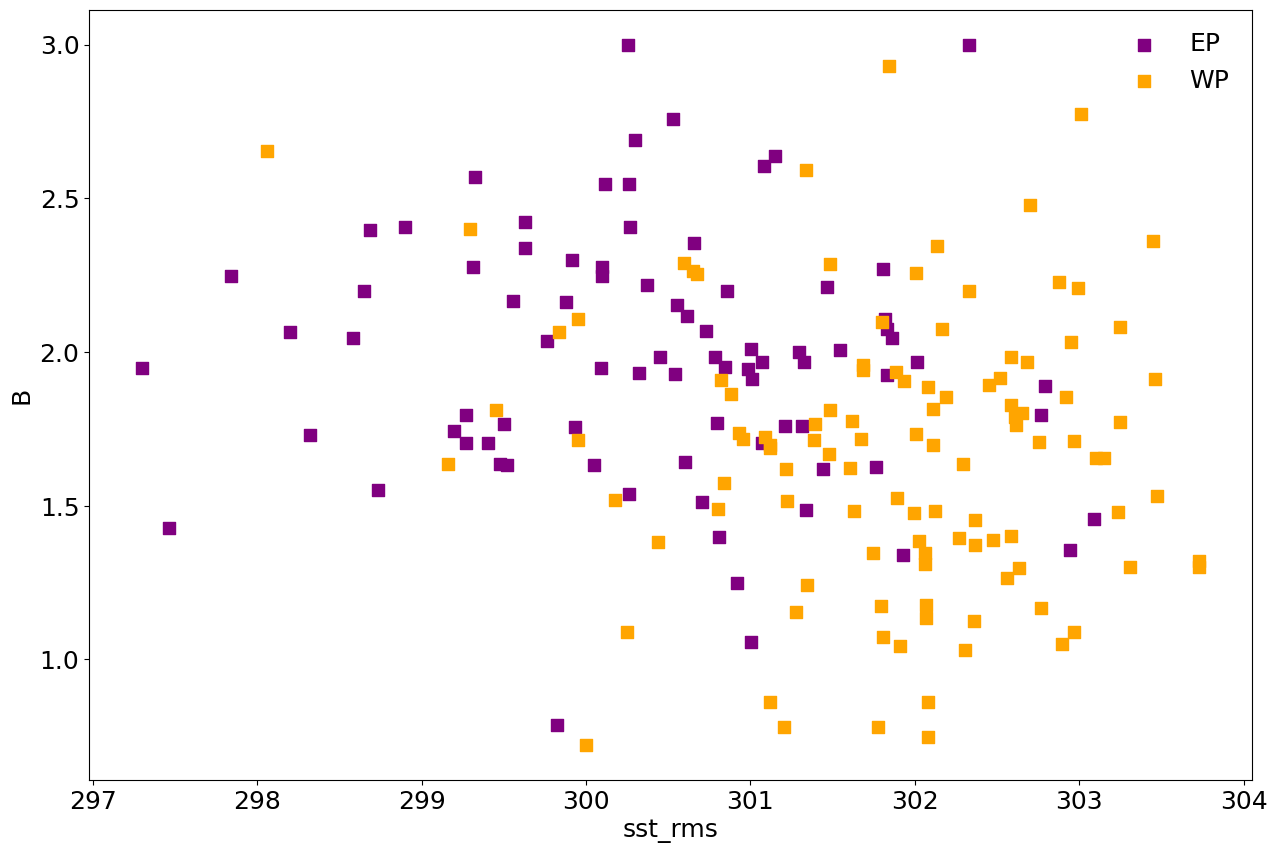

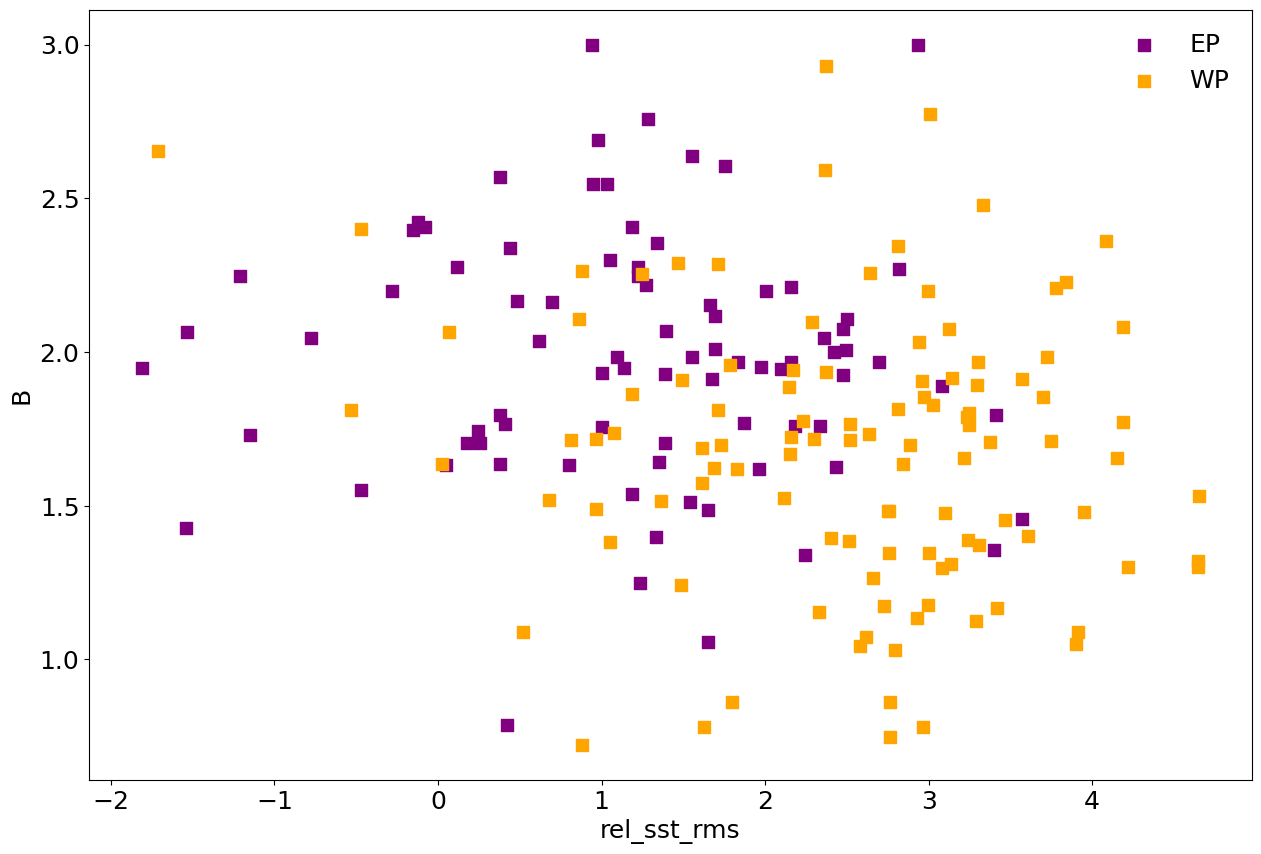

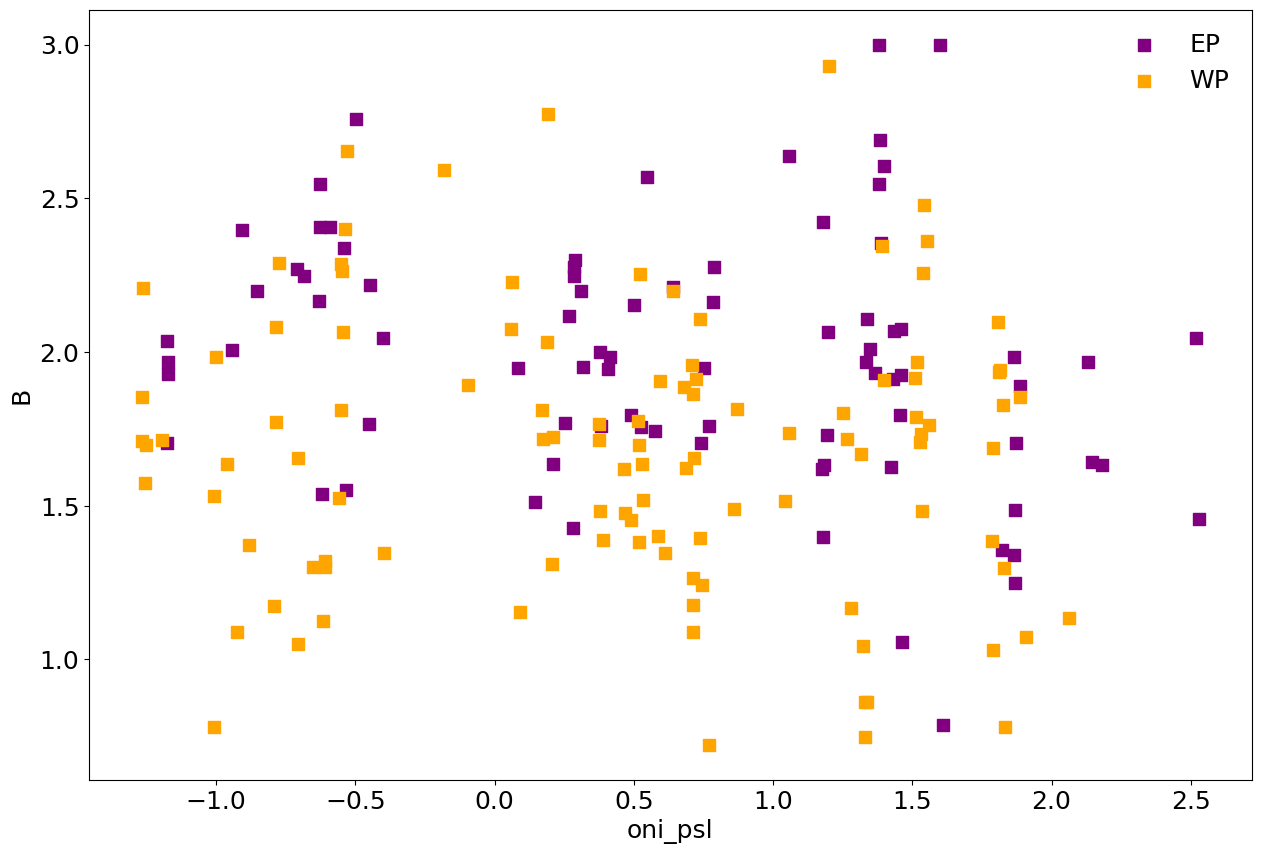

In [32]:
### SYNTHESIS
y = 'B_hol'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('B')
    plt.show()

In [33]:
# ### SYNTHESIS
# for prm in ['sst_rms', 'oni_psl']:
#     plt.scatter(de[prm], np.sqrt(de.B_hol * de.rsby), c='purple', marker='s', s=80, label='EP')
#     plt.scatter(dw[prm], np.sqrt(dw.B_hol * dw.rsby), c='orange', marker='s', s=80, label='WP')
#     # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
#     # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
#     plt.legend(frameon=False)
#     plt.xlabel(prm)
#     plt.ylabel('sqrt(B * rsby)')
#     plt.show()

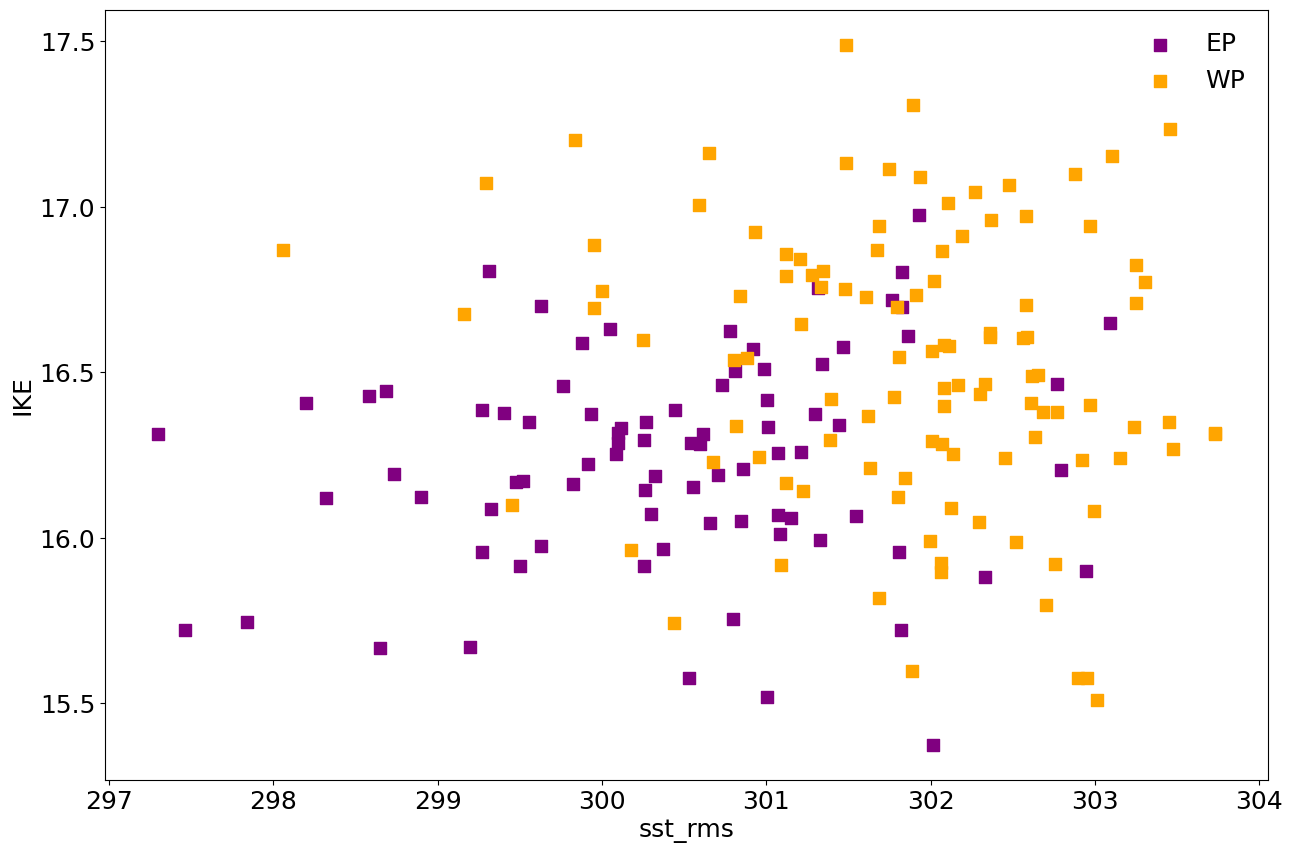

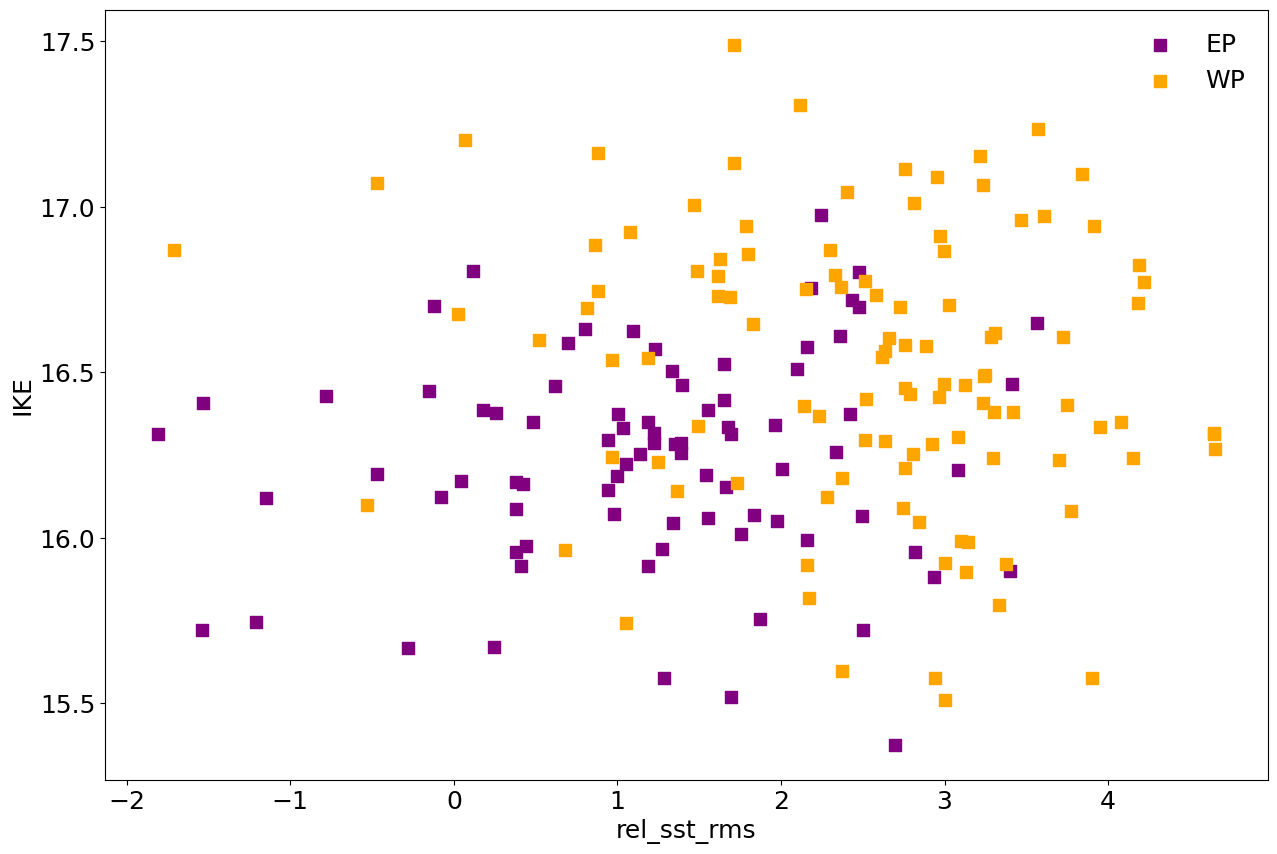

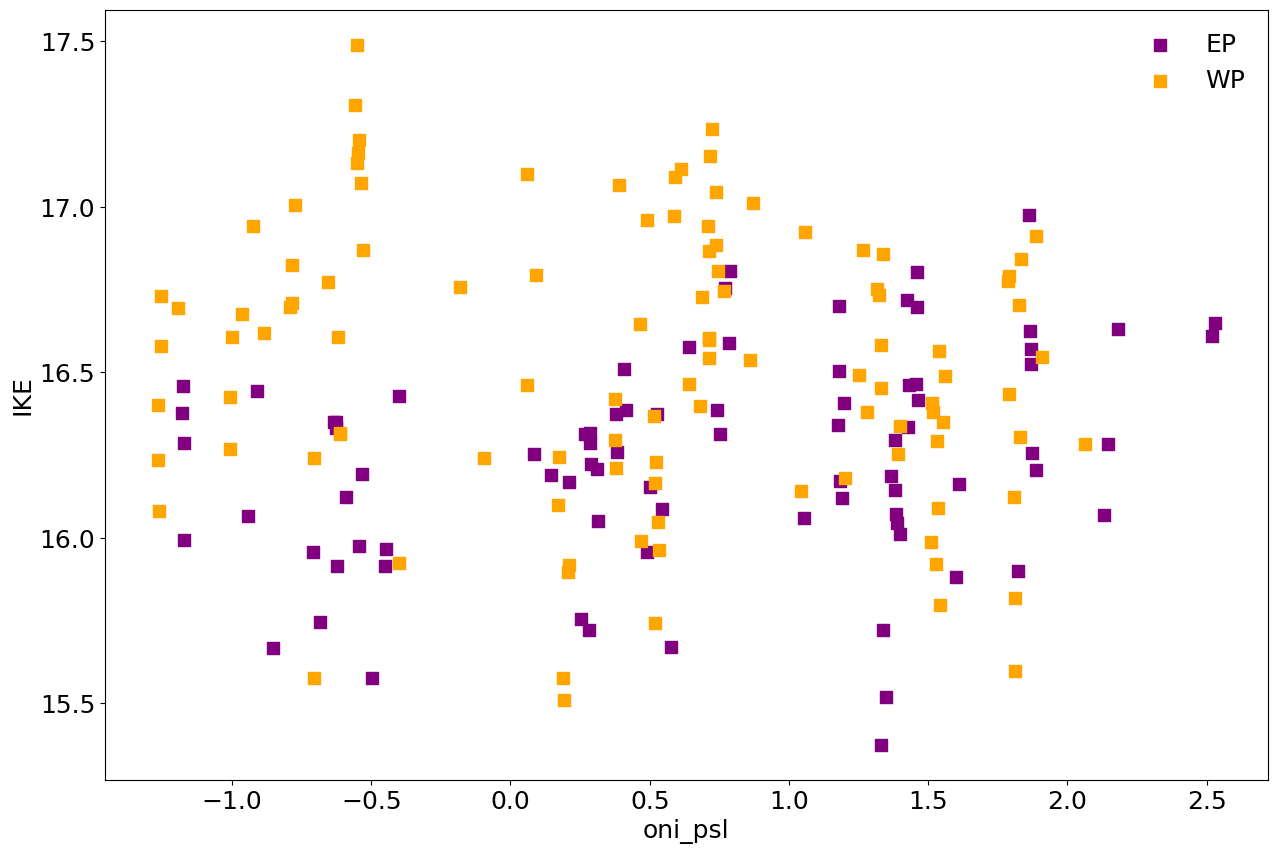

In [34]:
### SYNTHESIS
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], np.log10(de.K), c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], np.log10(dw.K), c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('IKE')
    plt.show()

### 4) Conditional dependance

In [35]:
# plt.scatter(d.vmx ** 2 / np.sqrt(d.rsby), np.sqrt(d.B_hol), c=d.uc ** 2, cmap=cm.get_cmap('Reds'))
# # plt.scatter(d.vmx ** 2 / np.sqrt(d.rsby), np.sqrt(d.B_hol), c=d.oni_psl)
# plt.colorbar()

In [36]:
# # plt.scatter(dl.vmx ** 2 / np.sqrt(dl.rsby), np.sqrt(dl.B_hol), c=dl.uc ** 2)
# # plt.scatter(dl.vmx ** 2 / np.sqrt(dl.rsby), np.sqrt(dl.B_hol), c=dl.sst_rms)
# plt.colorbar()

Text(0, 0.5, 'Rossby number')

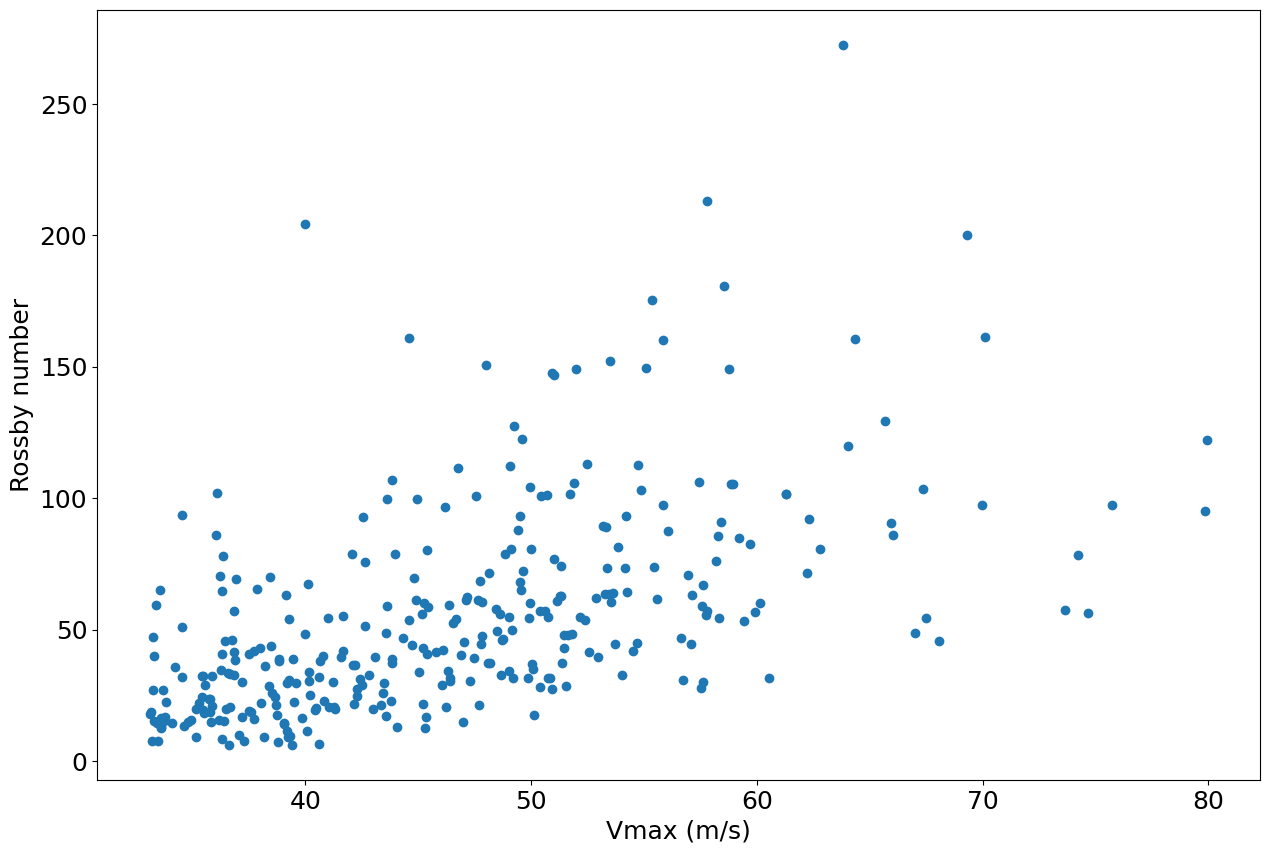

In [37]:
plt.scatter(d.vmx, d.rsby)
plt.xlabel('Vmax (m/s)')
plt.ylabel('Rossby number')

In [38]:
# Also try Vmax  55 m/s
cond = (d.vmx > 55) & (d.vmx < 57) & (d.rsby > 80) & (d.rsby < 100)
dcd  = d.where(cond, drop=True)

In [39]:
print('Vmax ** 2 variation: {:.1f}%'.format((1 - float(dcd.vmx.min() ** 2 / dcd.vmx.max() ** 2)) * 100))
print('sqrt(rsby) variation: {:.1f}%'.format((1 - float(np.sqrt(dcd.rsby.min()) / np.sqrt(dcd.rsby.max()))) * 100))
print('sqrt(B) variation: {:.1f}%'.format((1 - float(np.sqrt(dcd.B_hol.min()) / np.sqrt(dcd.B_hol.max()))) * 100))
print('Uc ** 2 variation: {:.1f}%'.format((1 - float(dcd.uc.min() ** 2 / dcd.uc.max() ** 2)) * 100))

Vmax ** 2 variation: 0.9%
sqrt(rsby) variation: 5.1%
sqrt(B) variation: 15.0%
Uc ** 2 variation: 20.1%


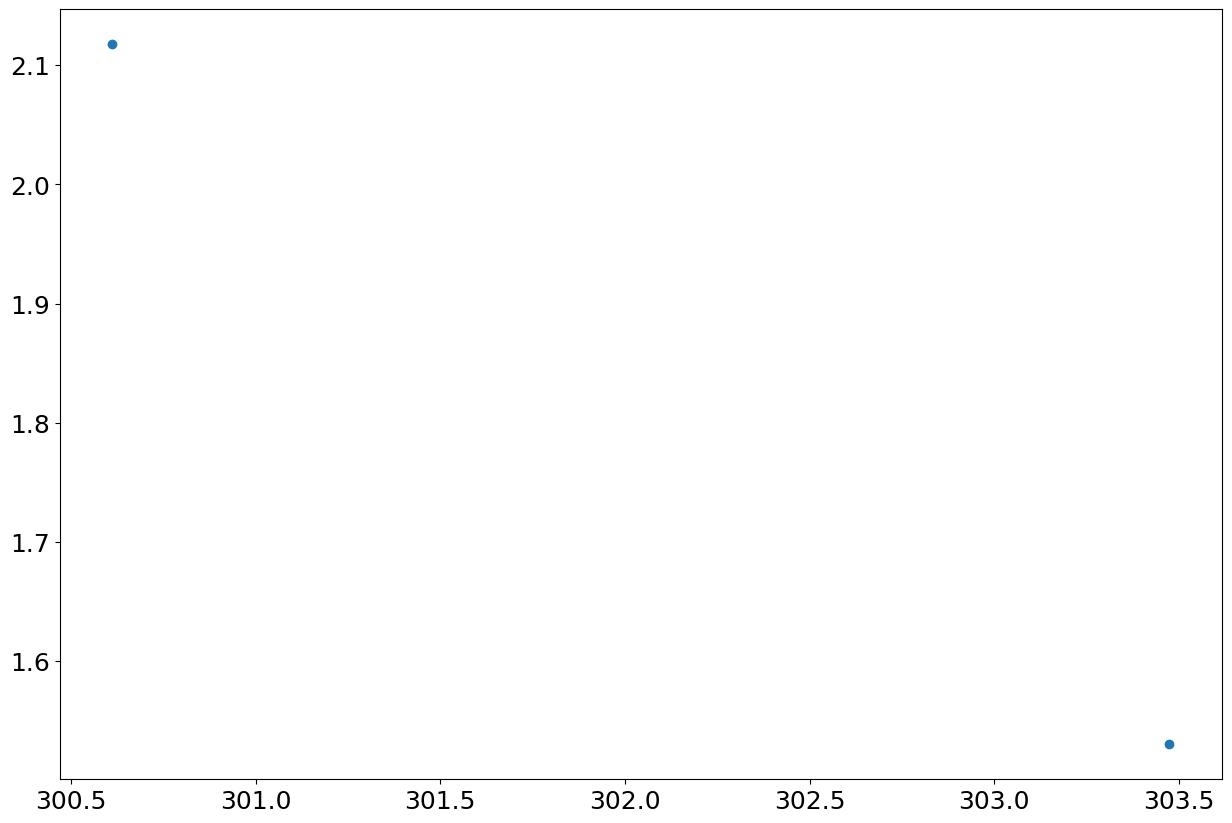

In [40]:
plt.scatter(dcd.sst_rms, dcd.B_hol)

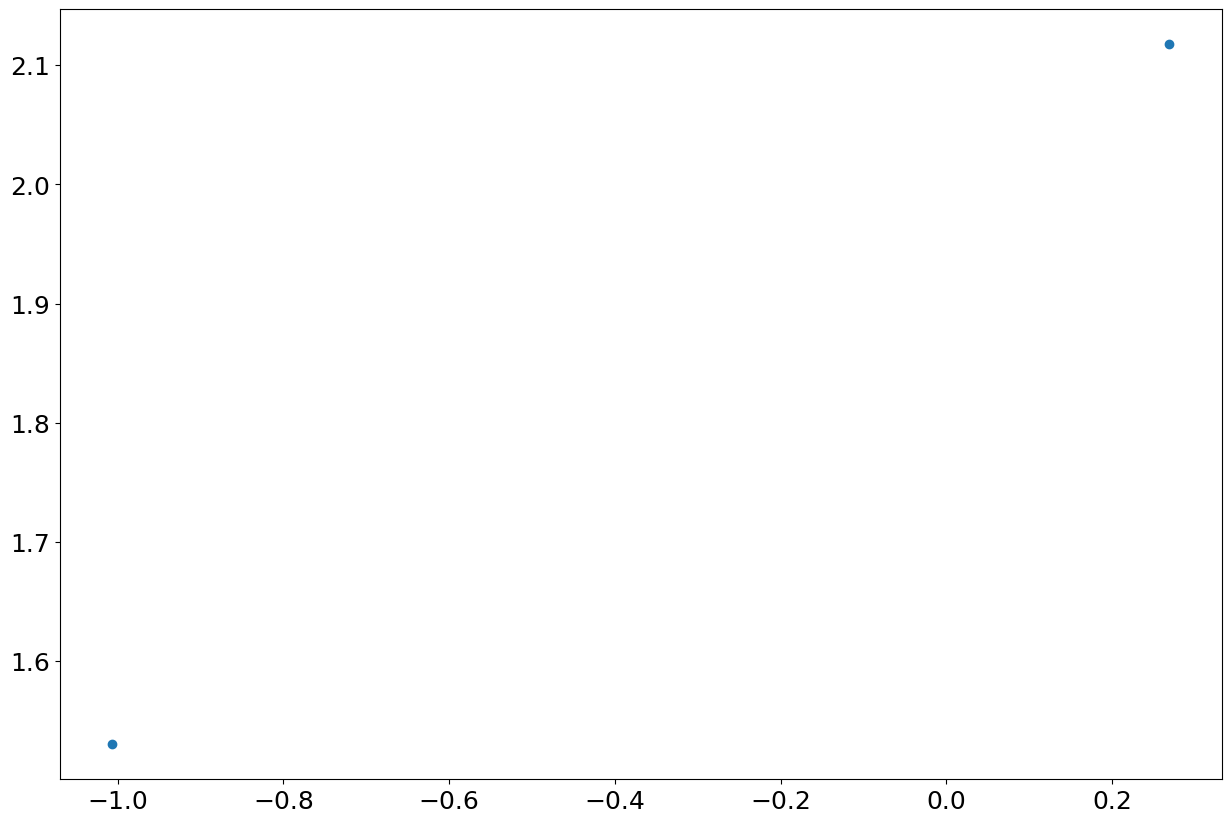

In [41]:
plt.scatter(dcd.oni_psl, dcd.B_hol)

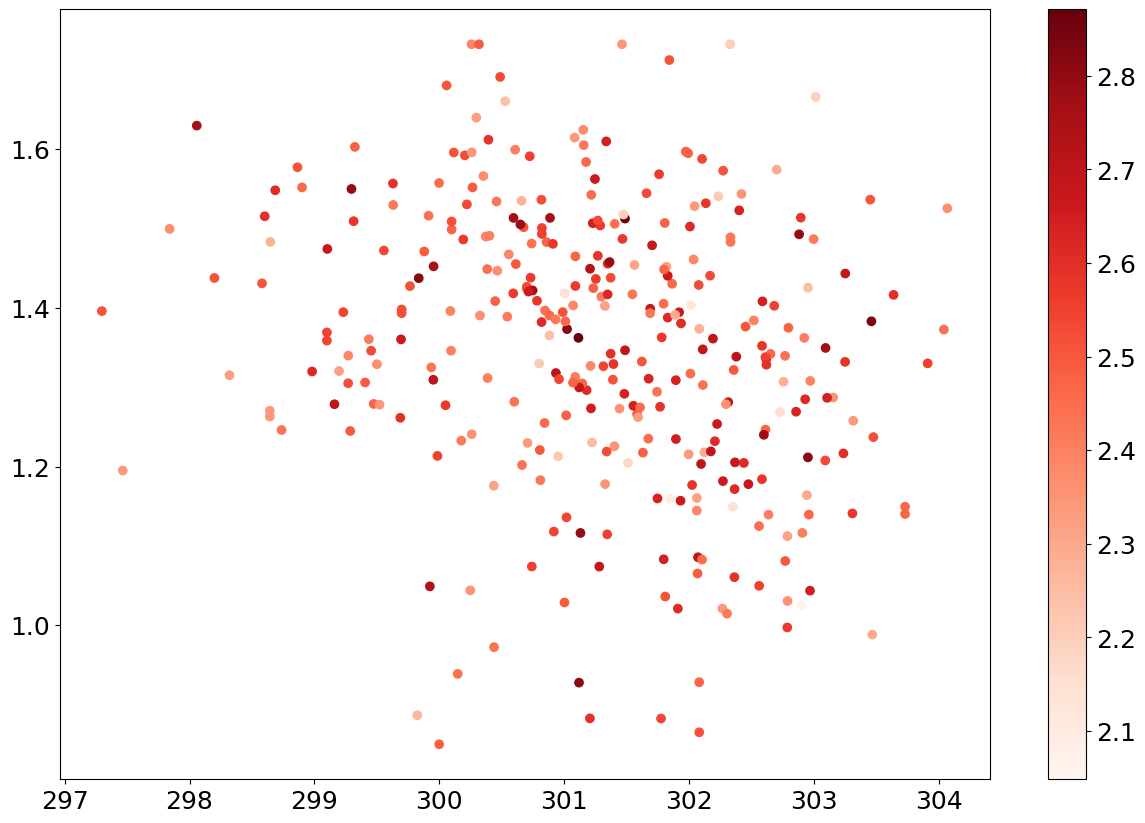

In [42]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)
plt.scatter(d.sst_rms, np.sqrt(d.B_hol), c=np.log10(d.vmx ** 2 / np.sqrt(d.rsby)), cmap=cm.get_cmap('Reds'))
plt.colorbar()

(array([13., 52., 82., 73., 49., 33., 11.,  8.,  8.,  3.]),
 array([111.81231893, 174.93305621, 238.05379349, 301.17453077,
        364.29526804, 427.41600532, 490.5367426 , 553.65747988,
        616.77821716, 679.89895444, 743.01969171]),
 <BarContainer object of 10 artists>)

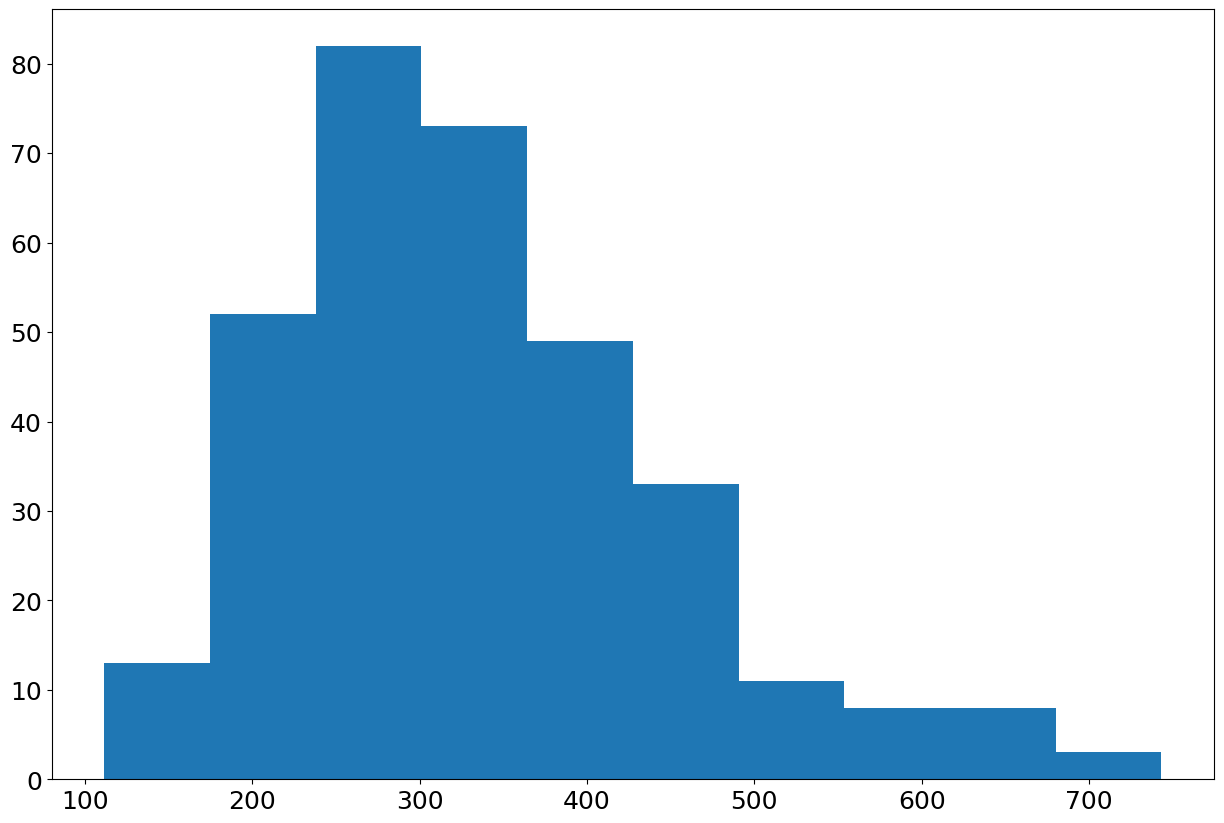

In [43]:
plt.hist(d.vmx ** 2 / np.sqrt(d.rsby))

In [44]:
cond = (d.vmx ** 2 / np.sqrt(d.rsby) > 280) & (d.vmx ** 2 / np.sqrt(d.rsby) < 320)
dcd  = d.where(cond, drop=True)

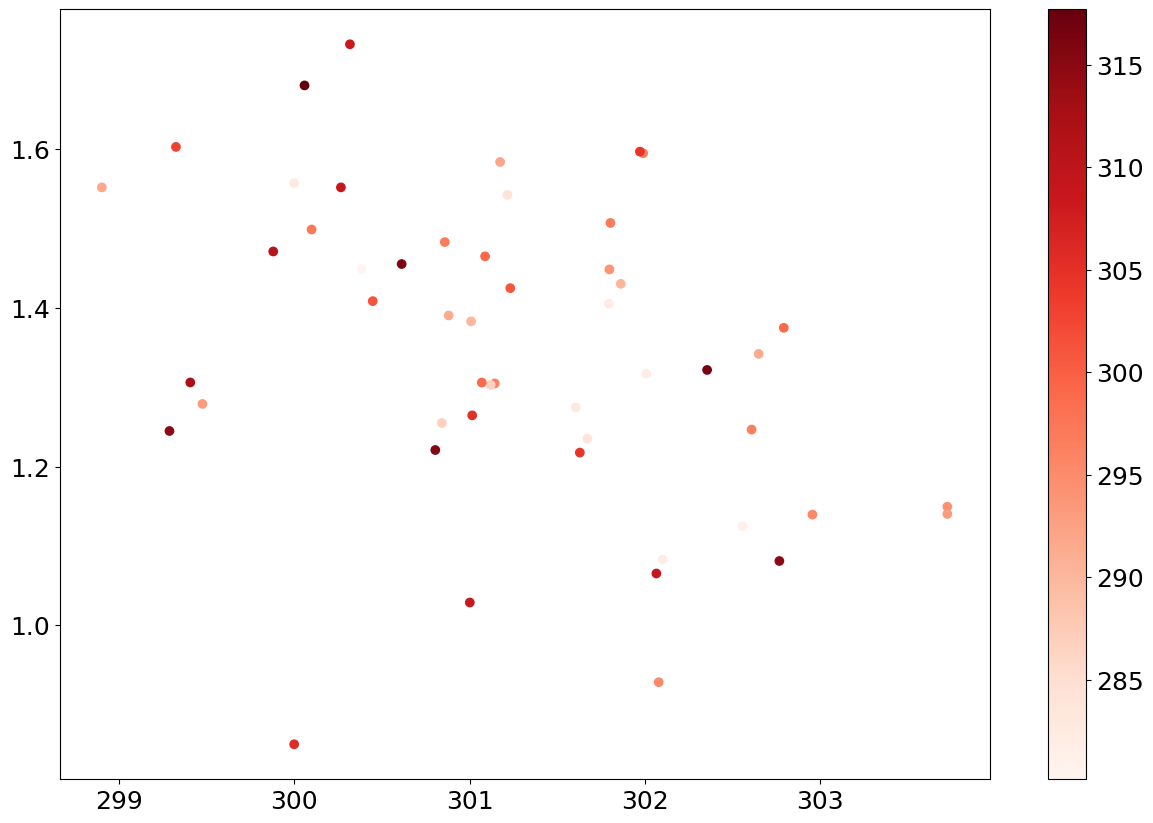

In [45]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)

plt.scatter(dcd.sst_rms, np.sqrt(dcd.B_hol), c=dcd.vmx ** 2 / np.sqrt(dcd.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

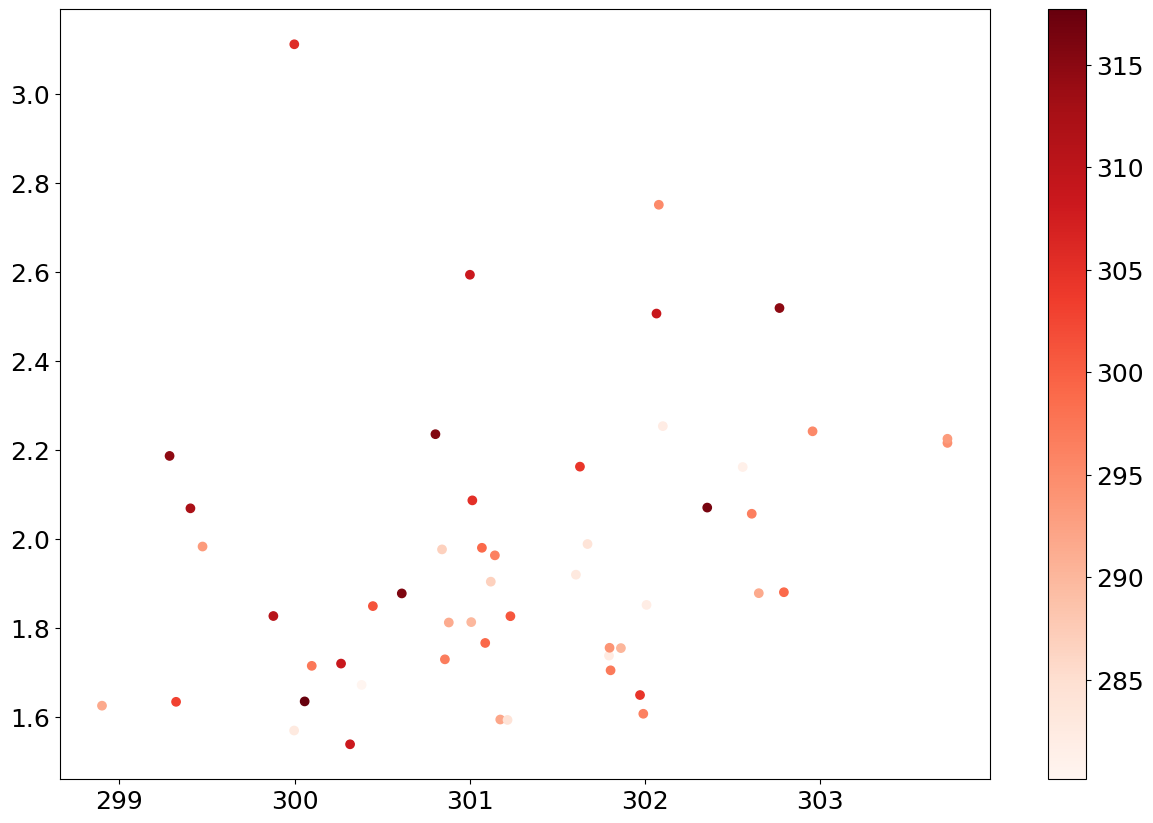

In [46]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)
# The uppermost case is an ERC

plt.scatter(dcd.sst_rms, dcd.beta0_T0, c=dcd.vmx ** 2 / np.sqrt(dcd.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

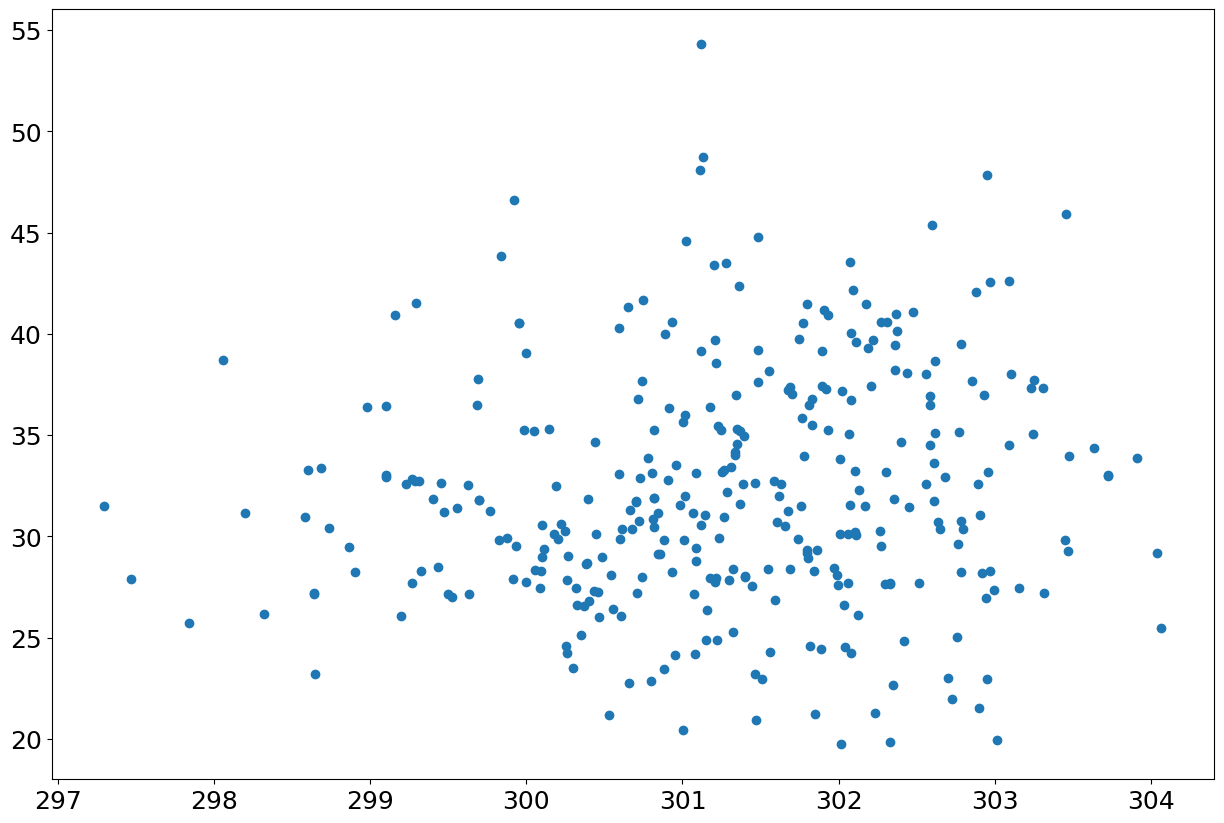

In [47]:
plt.scatter(d.sst_rms, d.uc)

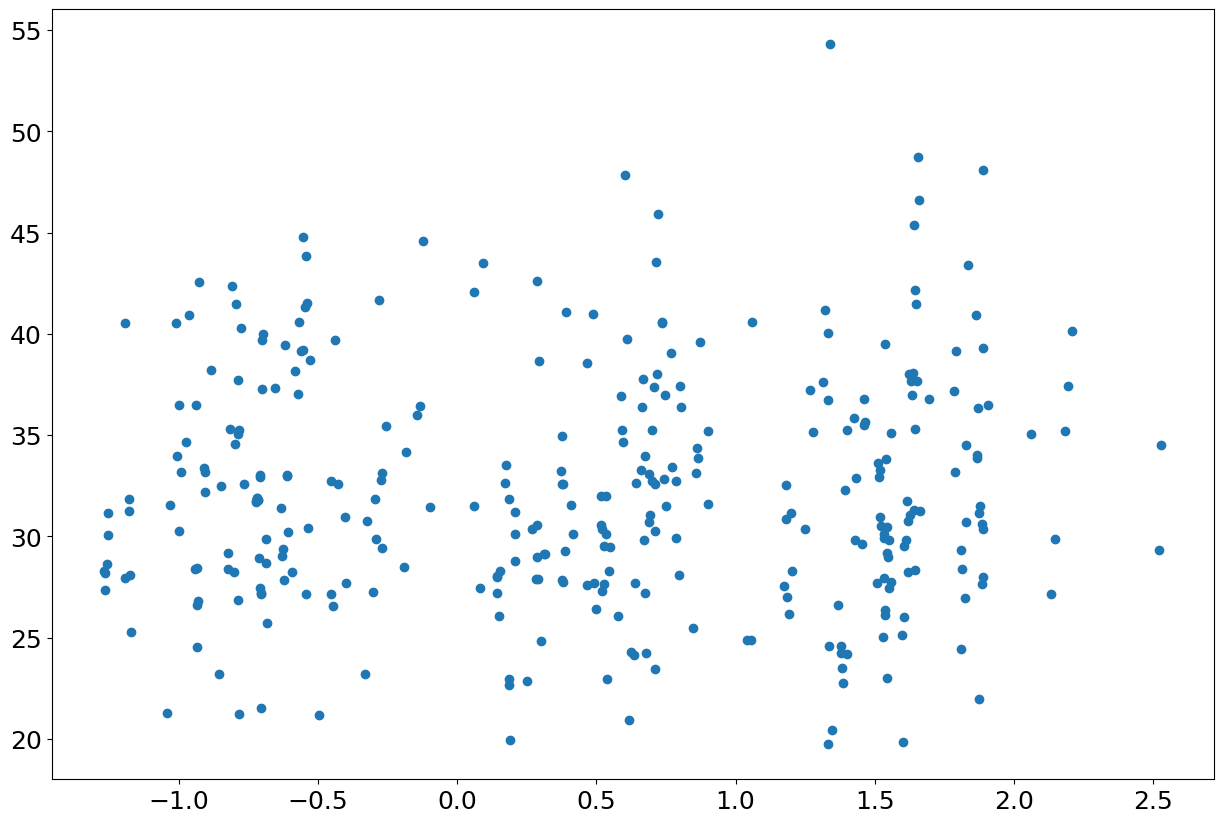

In [48]:
plt.scatter(d.oni_psl, d.uc)

### 5) At the LMI

In [49]:
hrs_thr = 3 # threshold, in hours
dl      = d.where((d.t_since_lmi_ibt / 3600 > -hrs_thr) & (d.t_since_lmi_ibt / 3600 < hrs_thr), drop=True)
print(len(dl.time))

22


In [50]:
da = dl.where(dl.basin == 'al', drop=True)
dc = dl.where(dl.basin == 'cp', drop=True)
de = dl.where(dl.basin == 'ep', drop=True)
di = dl.where(dl.basin == 'io', drop=True)
ds = dl.where(dl.basin == 'sh', drop=True)
dw = dl.where(dl.basin == 'wp', drop=True)

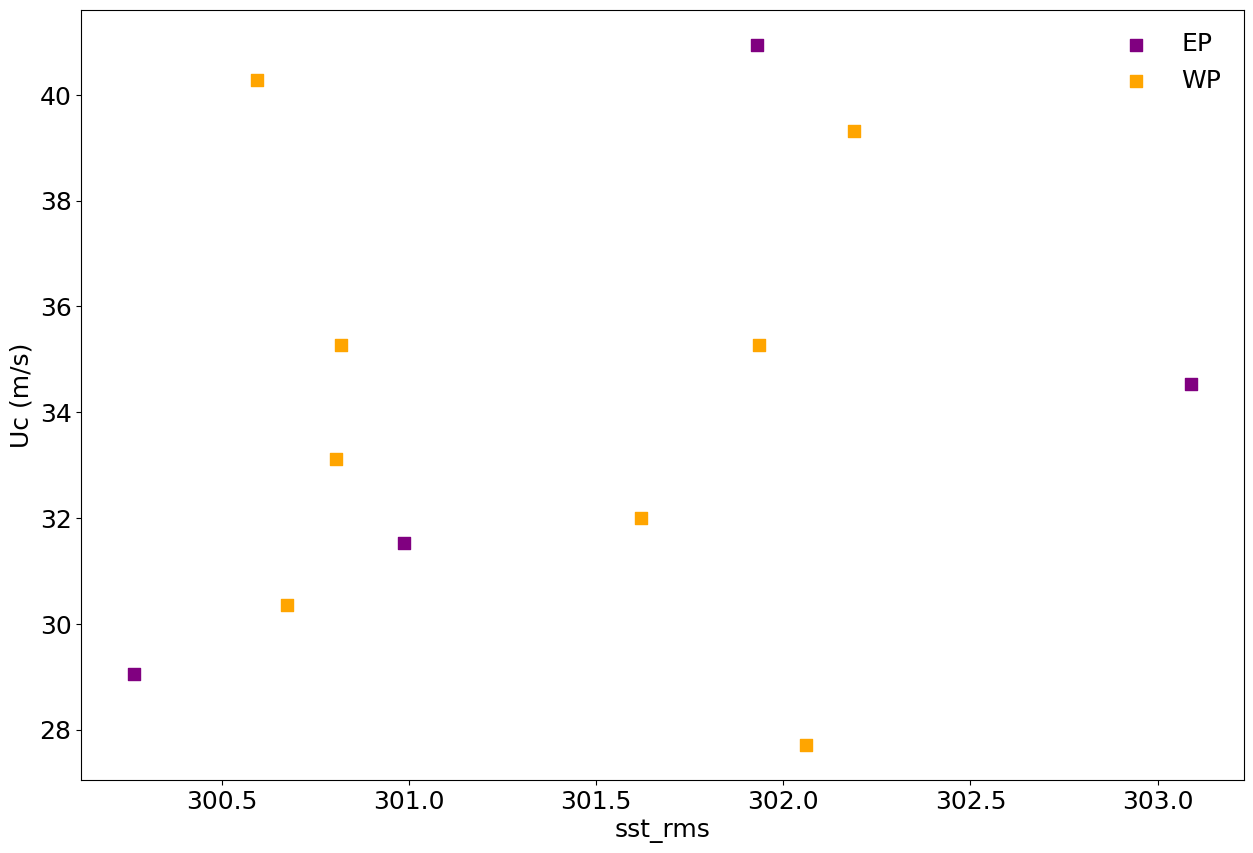

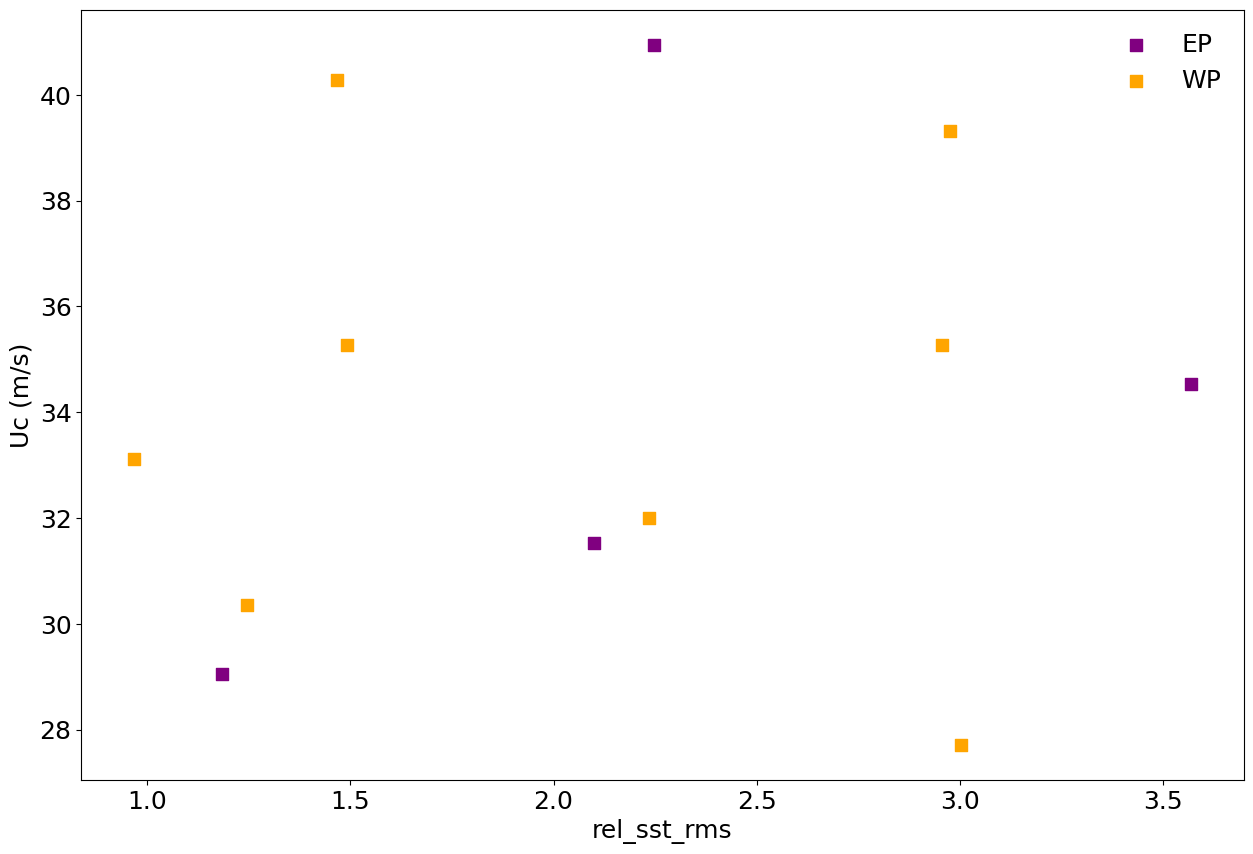

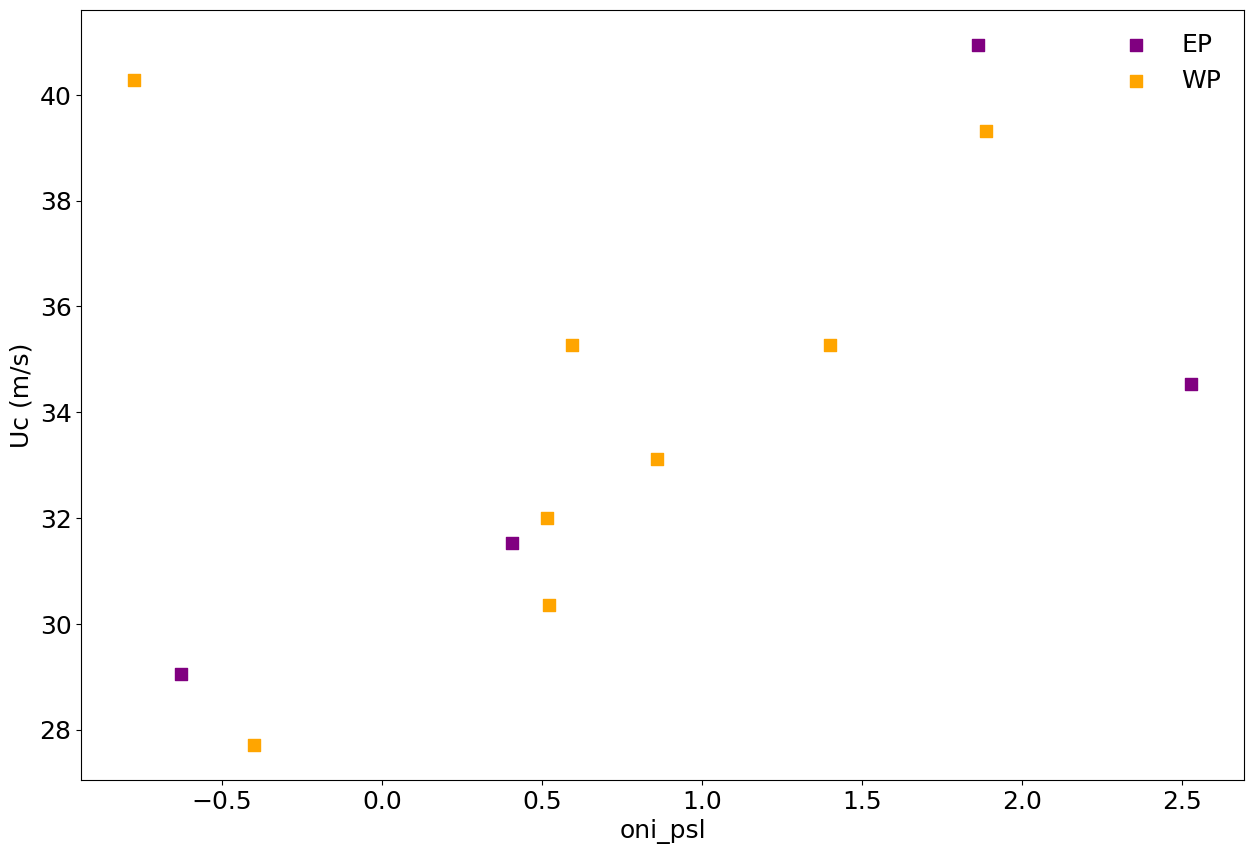

In [51]:
### SYNTHESIS
y = 'uc'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Uc (m/s)')
    plt.show()

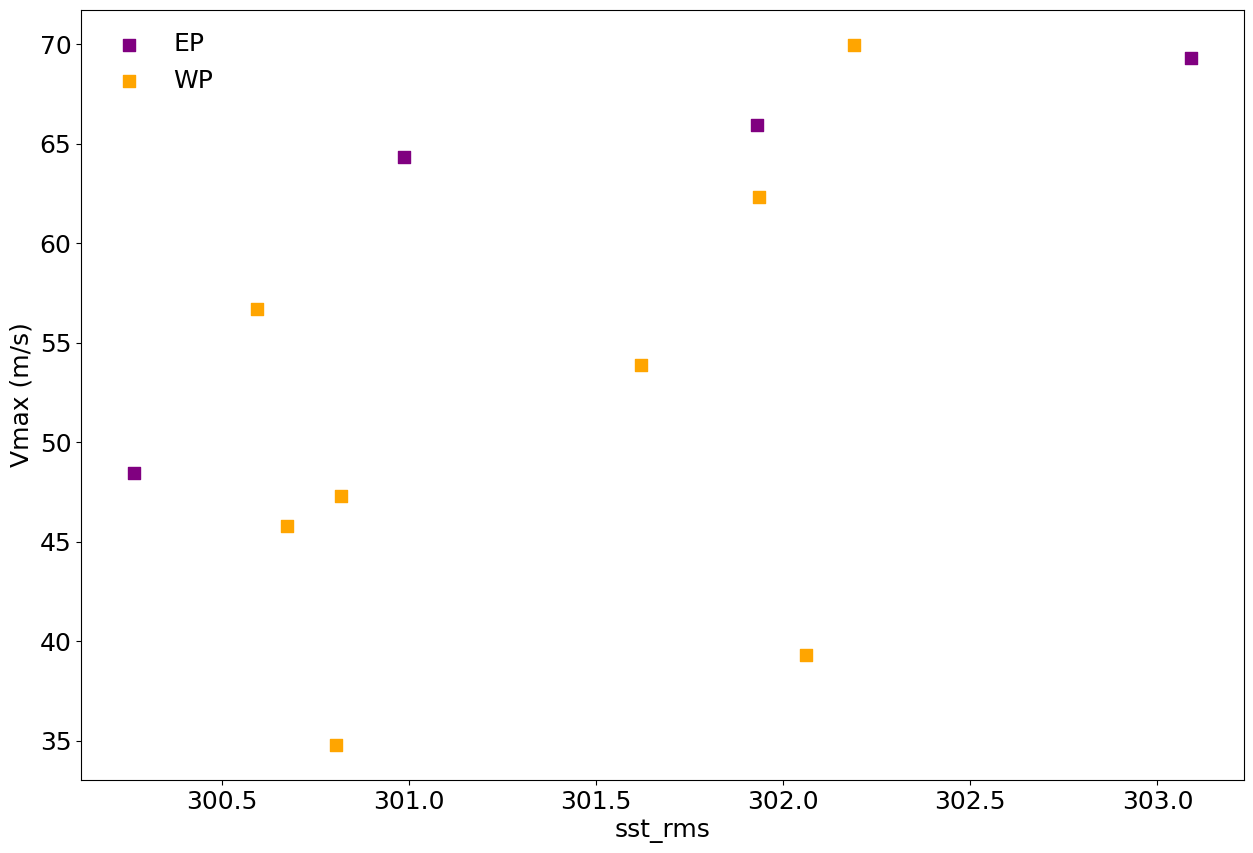

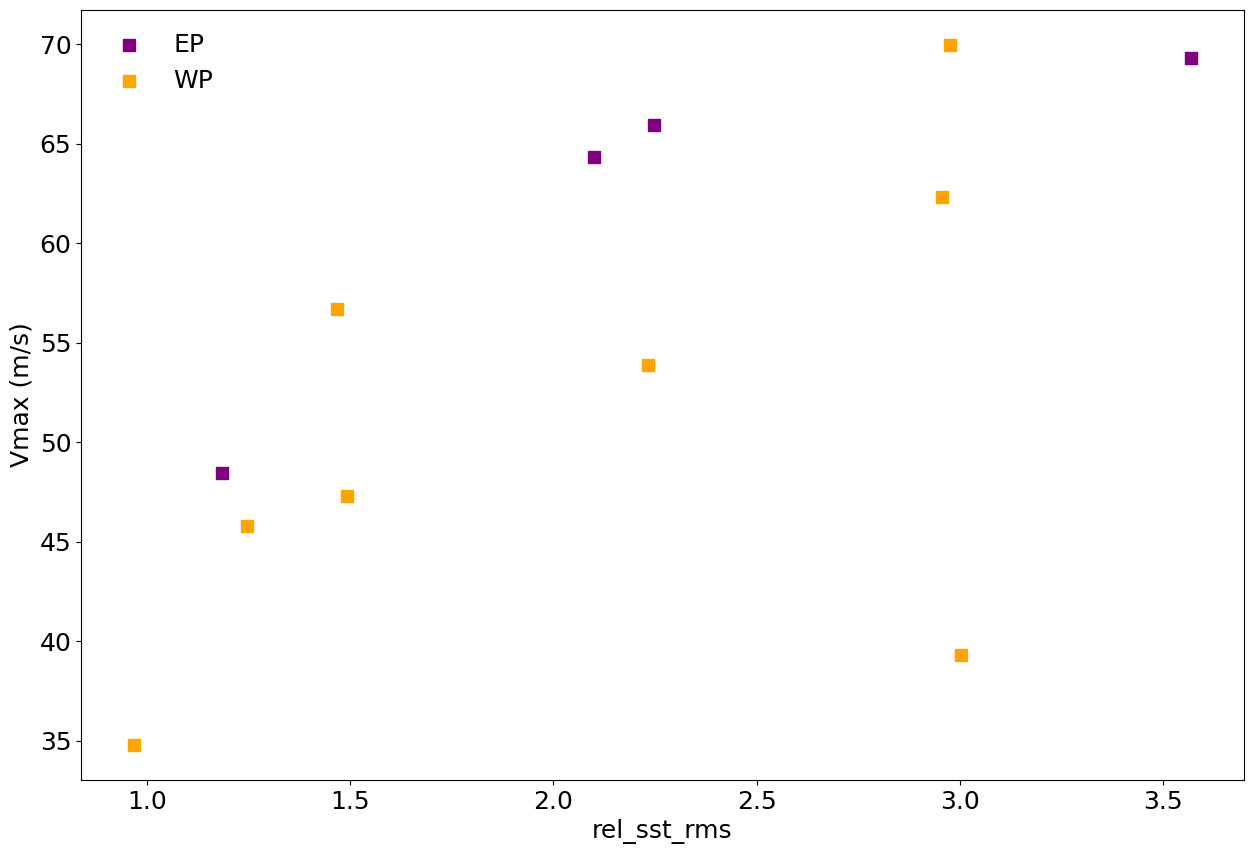

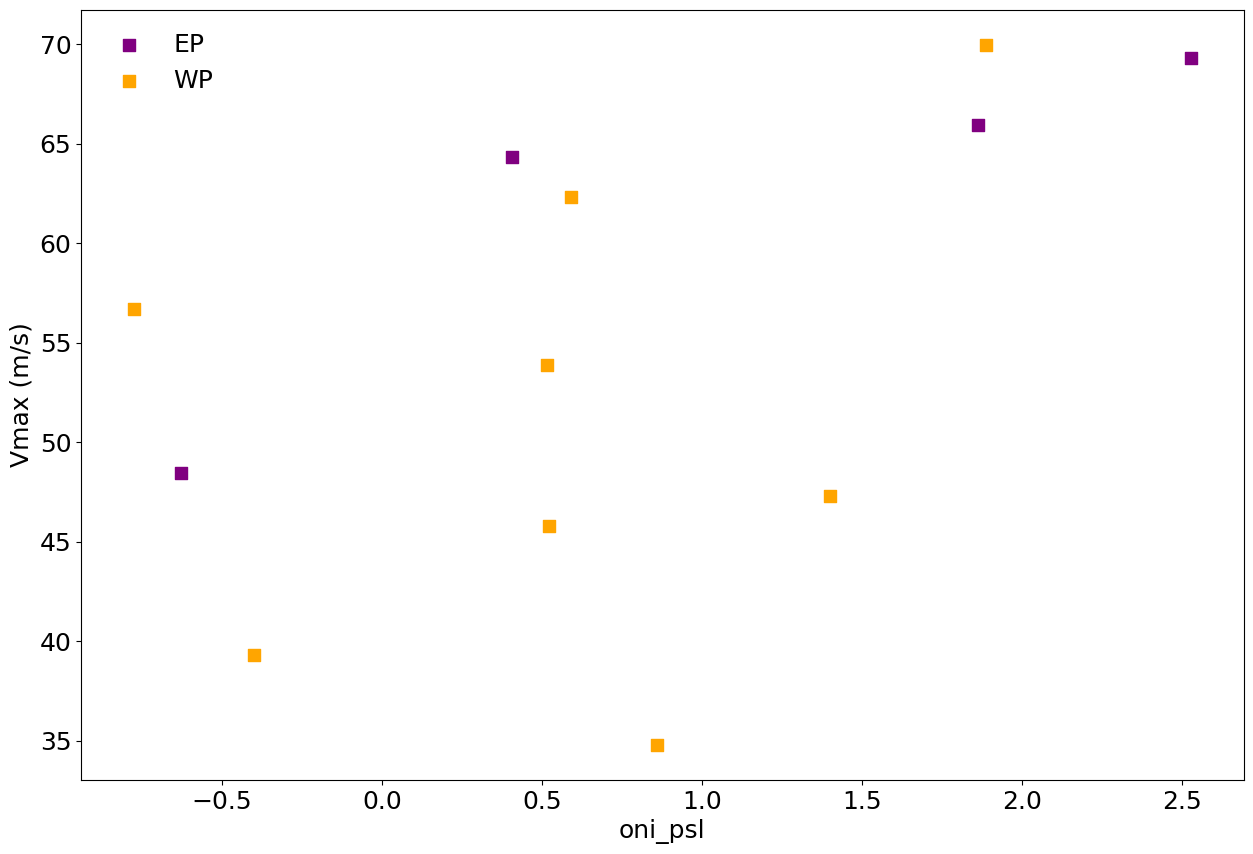

In [52]:
### SYNTHESIS
y = 'vmx'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Vmax (m/s)')
    plt.show()

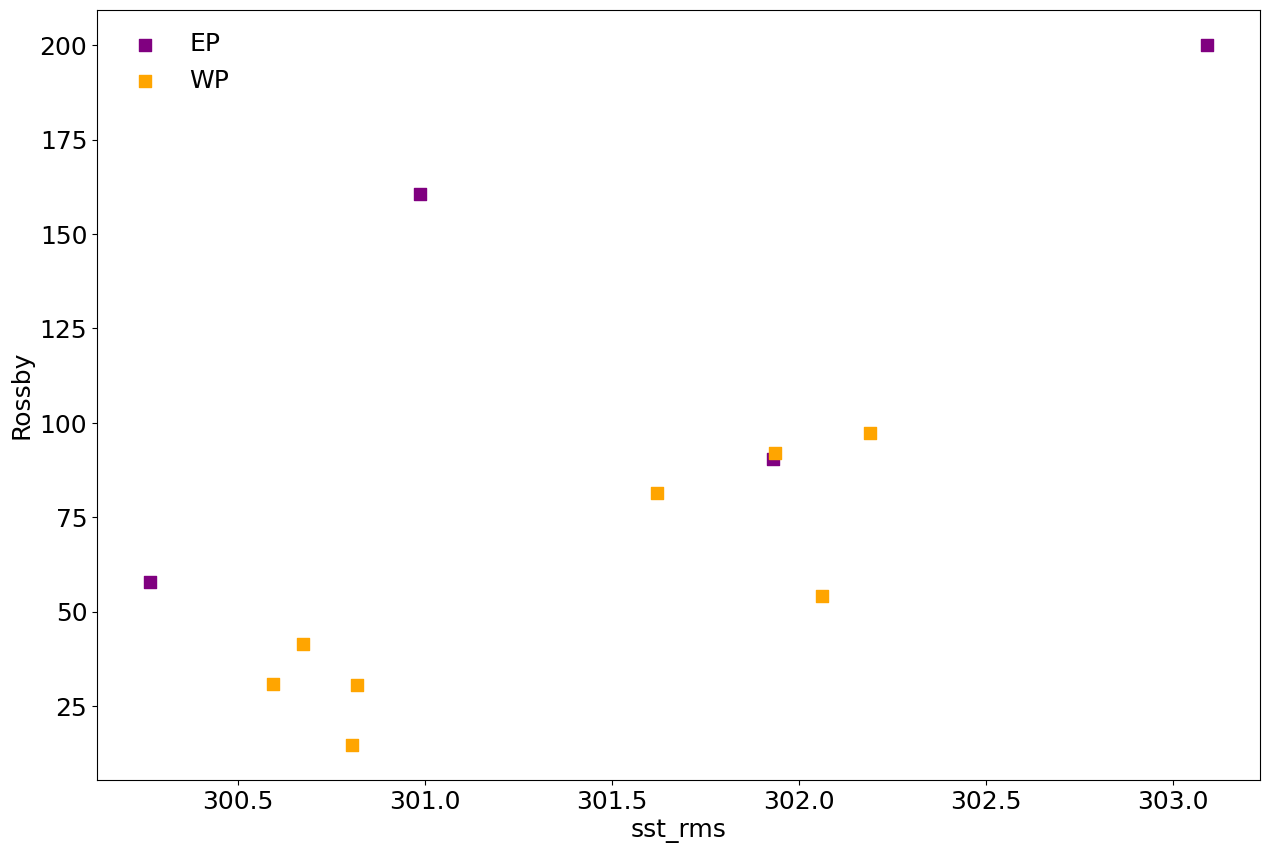

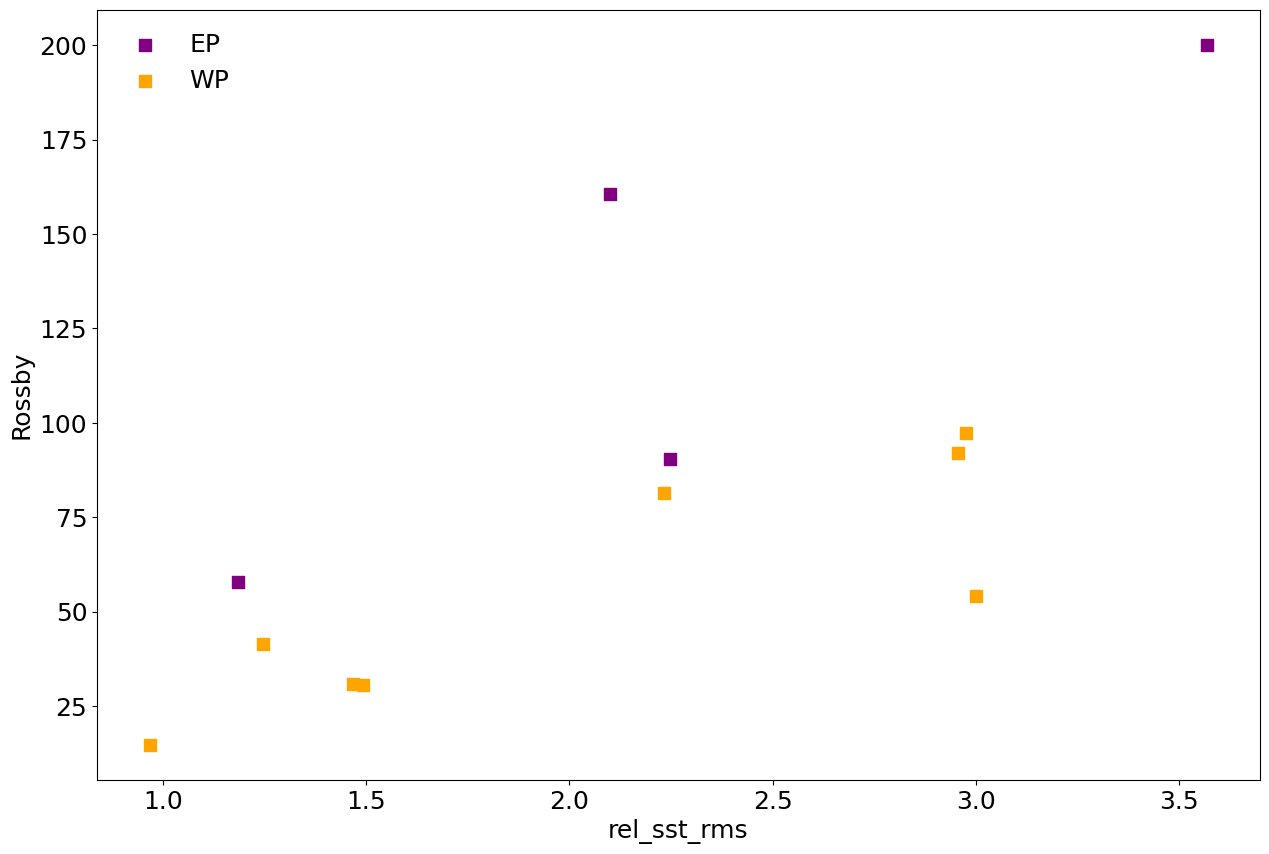

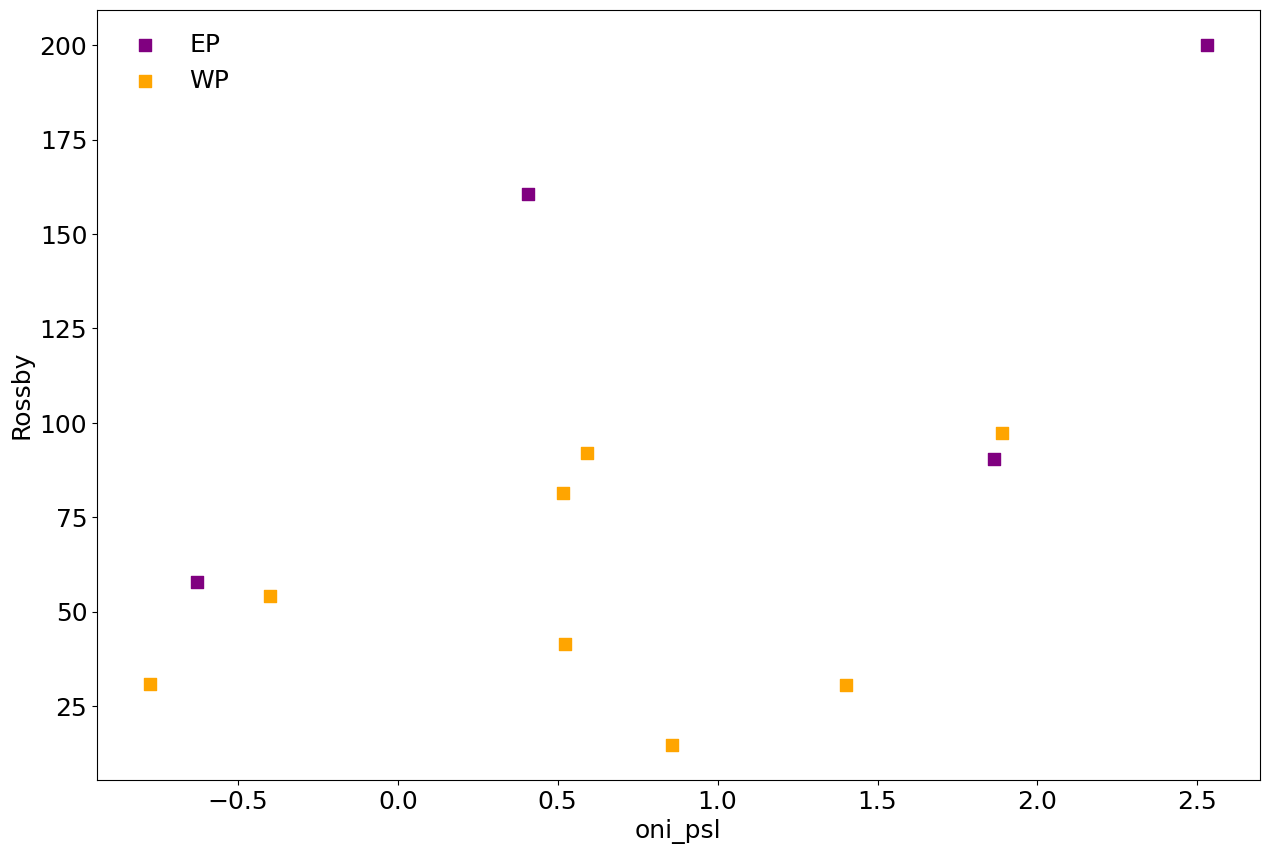

In [53]:
### SYNTHESIS
y = 'rsby'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Rossby')
    plt.show()

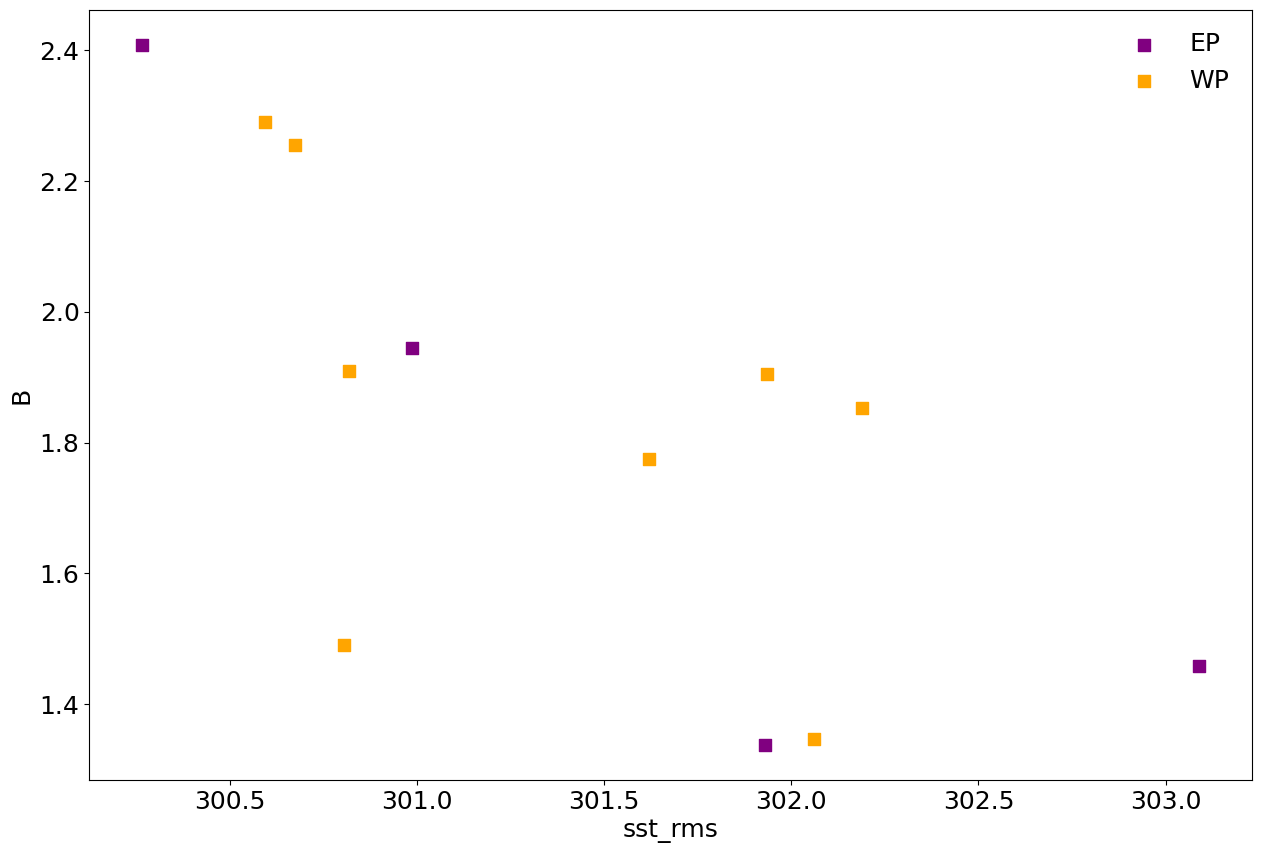

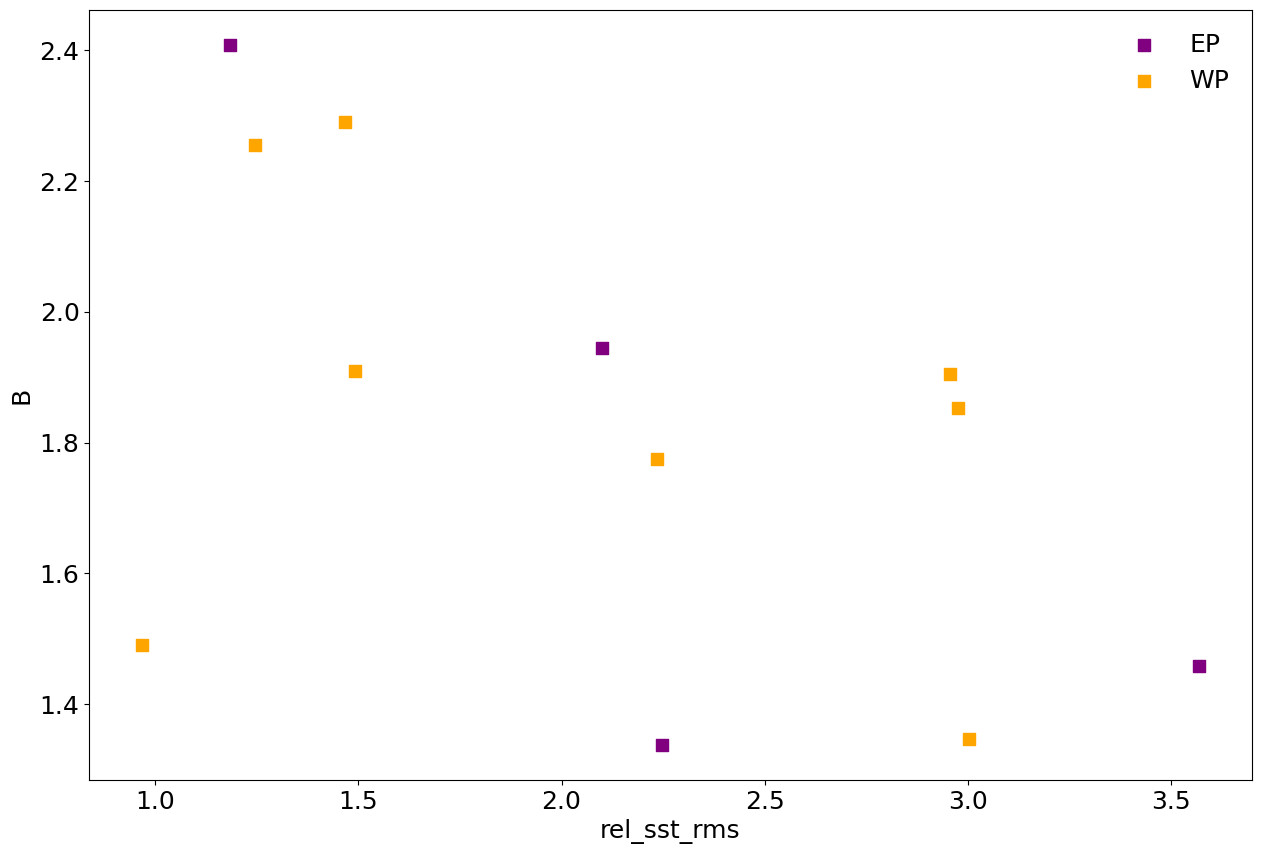

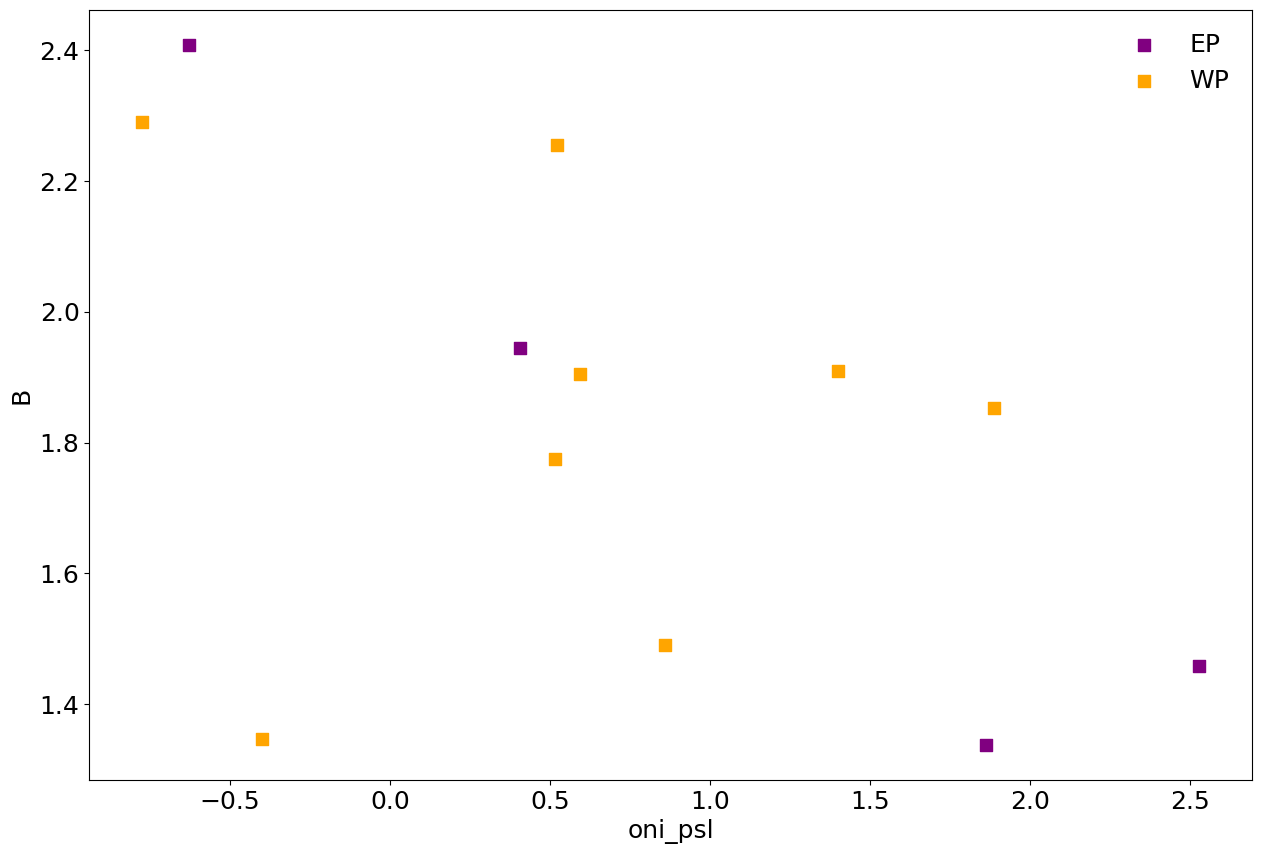

In [54]:
### SYNTHESIS
y = 'B_hol'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('B')
    plt.show()

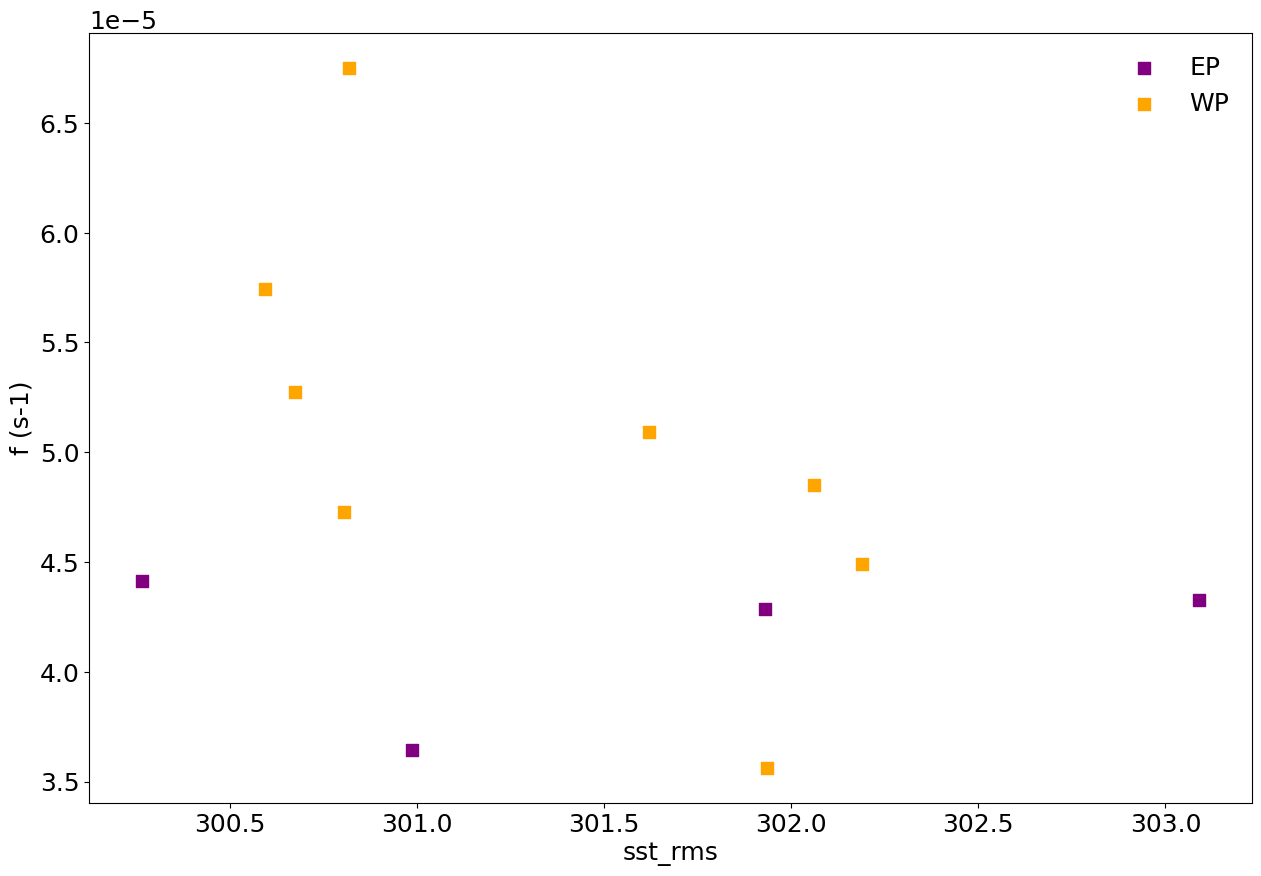

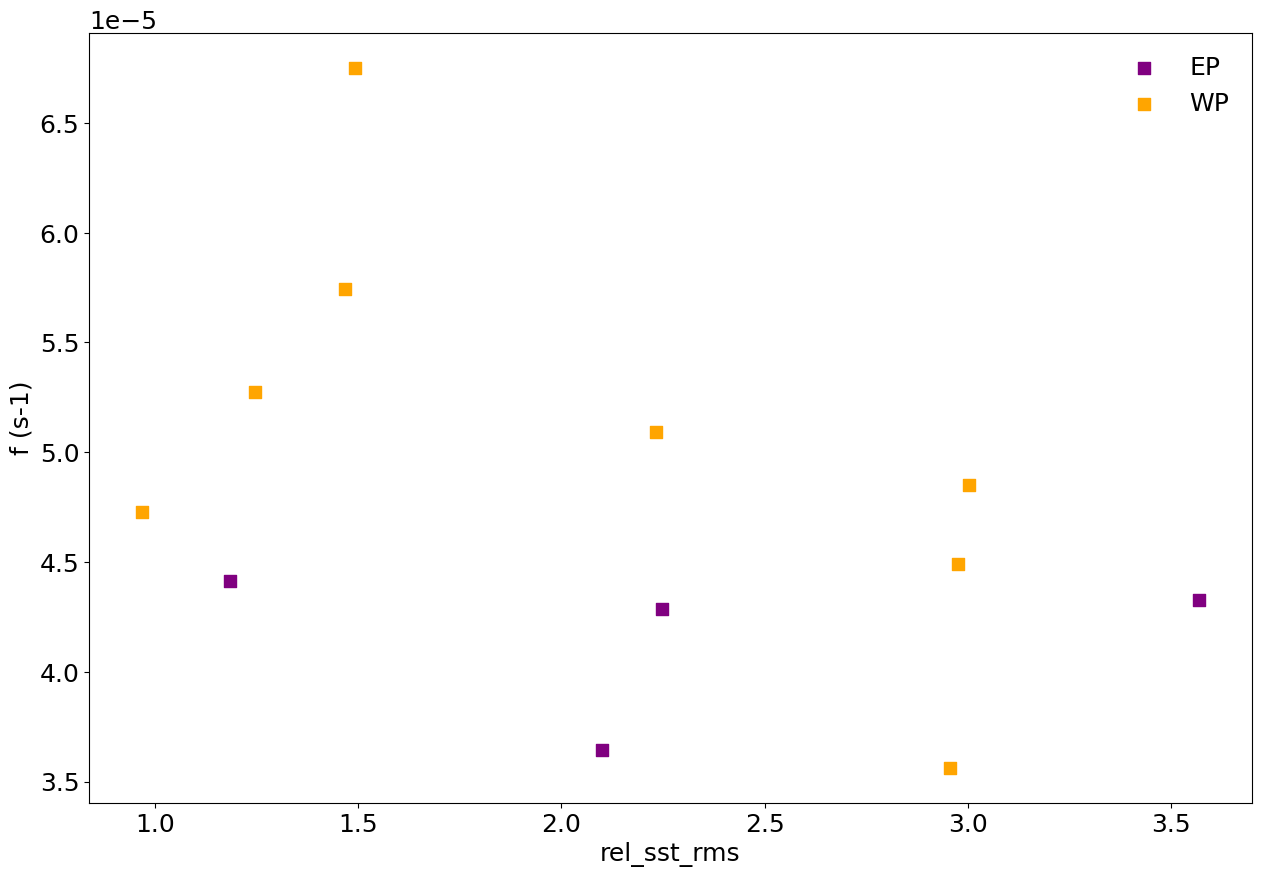

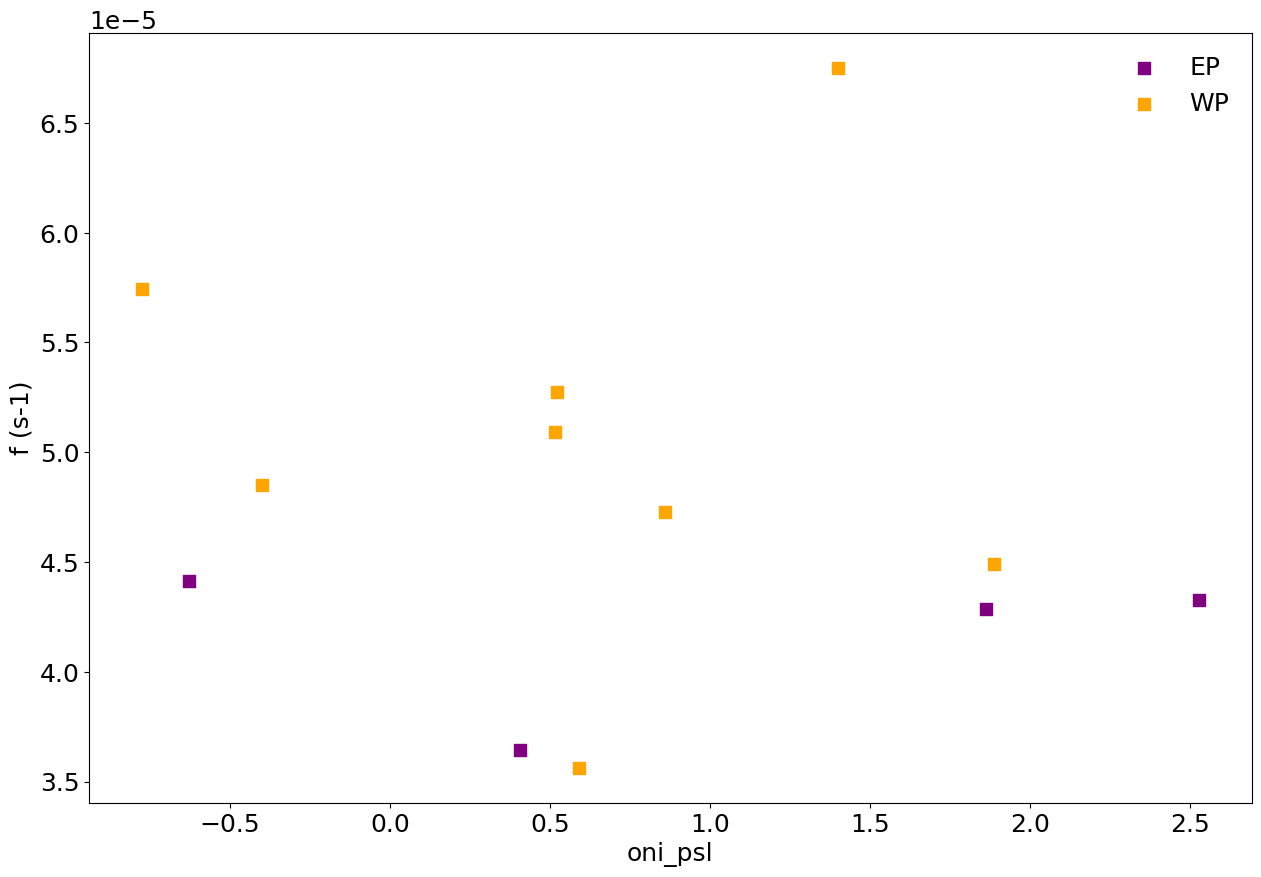

In [55]:
### SYNTHESIS
y = 'fcor'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], abs(de[y]), c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], abs(dw[y]), c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], abs(da[y]), c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], abs(ds[y]), c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('f (s-1)')
    plt.show()

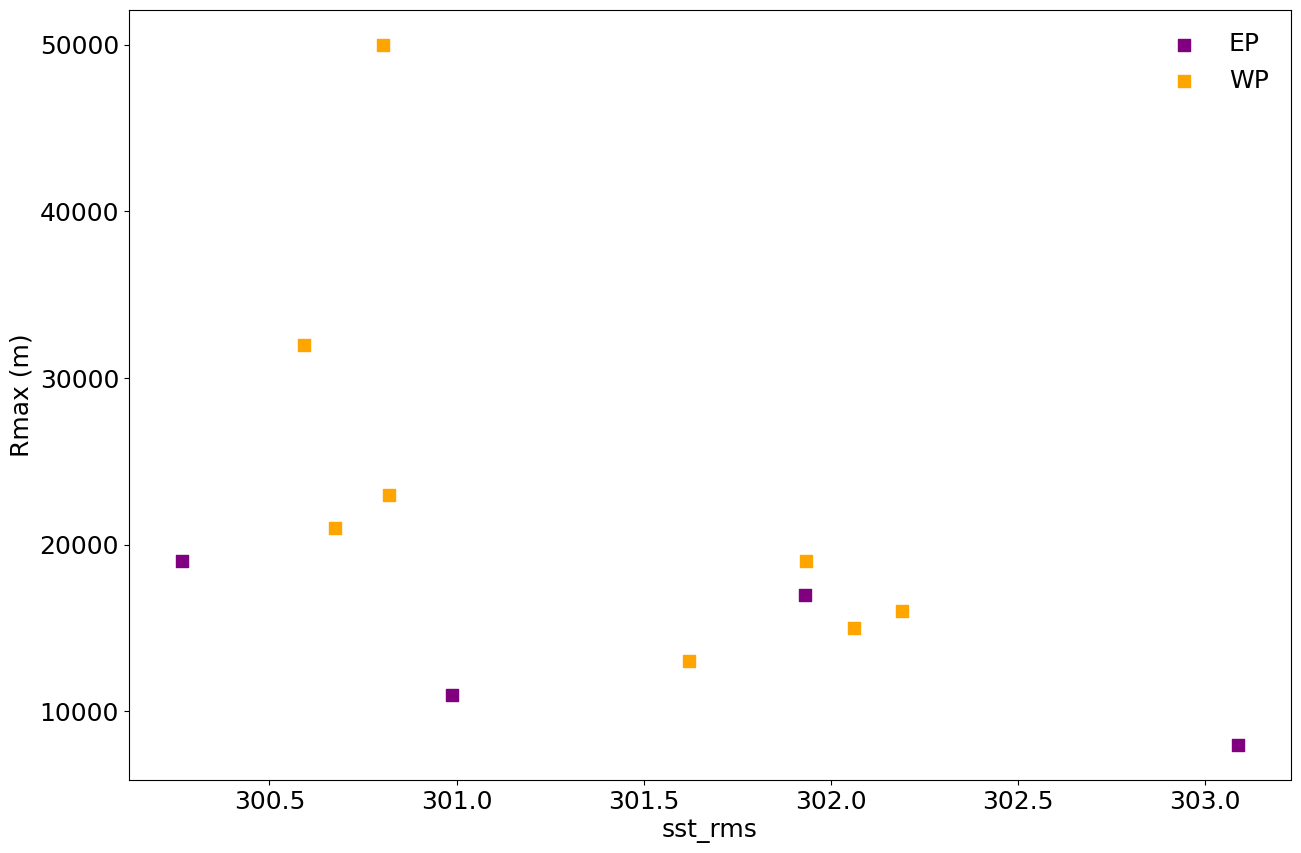

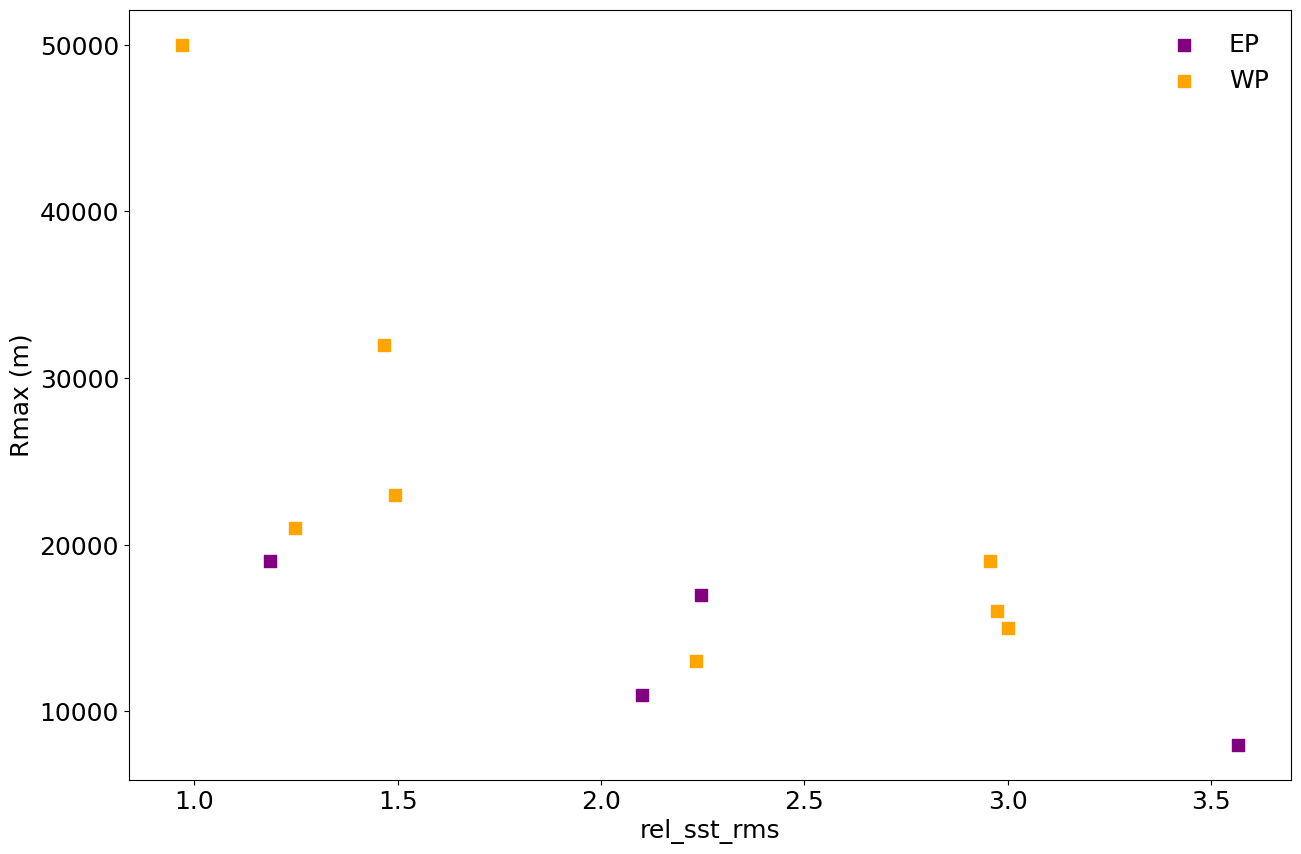

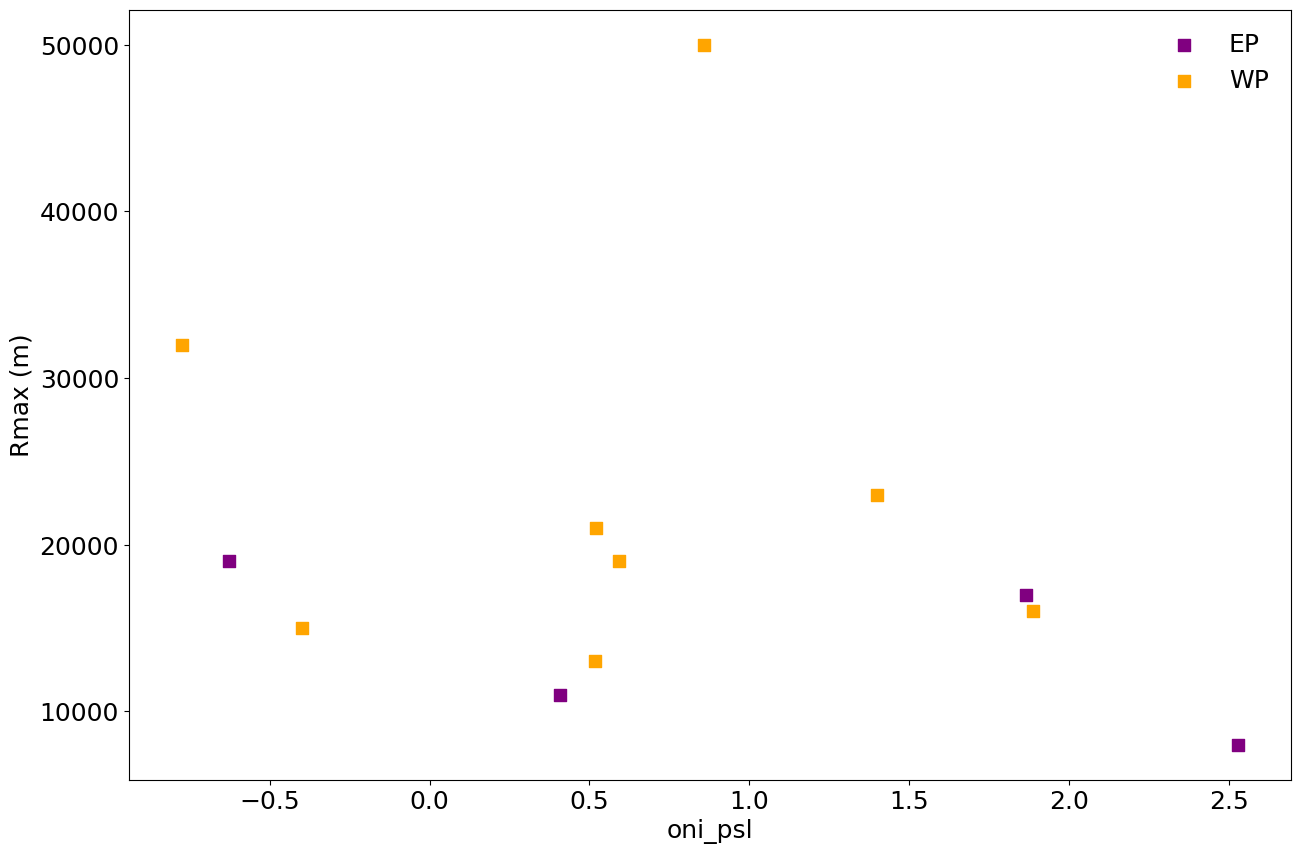

In [56]:
### SYNTHESIS
y = 'rmx'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Rmax (m)')
    plt.show()

### 6) ENSO East Pacific

In [57]:
de = d.where(d.basin == 'ep', drop=True)

(array([28., 24.,  2.,  7., 15.,  1.,  0.,  0.,  4.,  2.]),
 array([-1.11729482e+00, -7.45237815e-01, -3.73180810e-01, -1.12380402e-03,
         3.70933201e-01,  7.42990207e-01,  1.11504721e+00,  1.48710422e+00,
         1.85916122e+00,  2.23121823e+00,  2.60327523e+00]),
 <BarContainer object of 10 artists>)

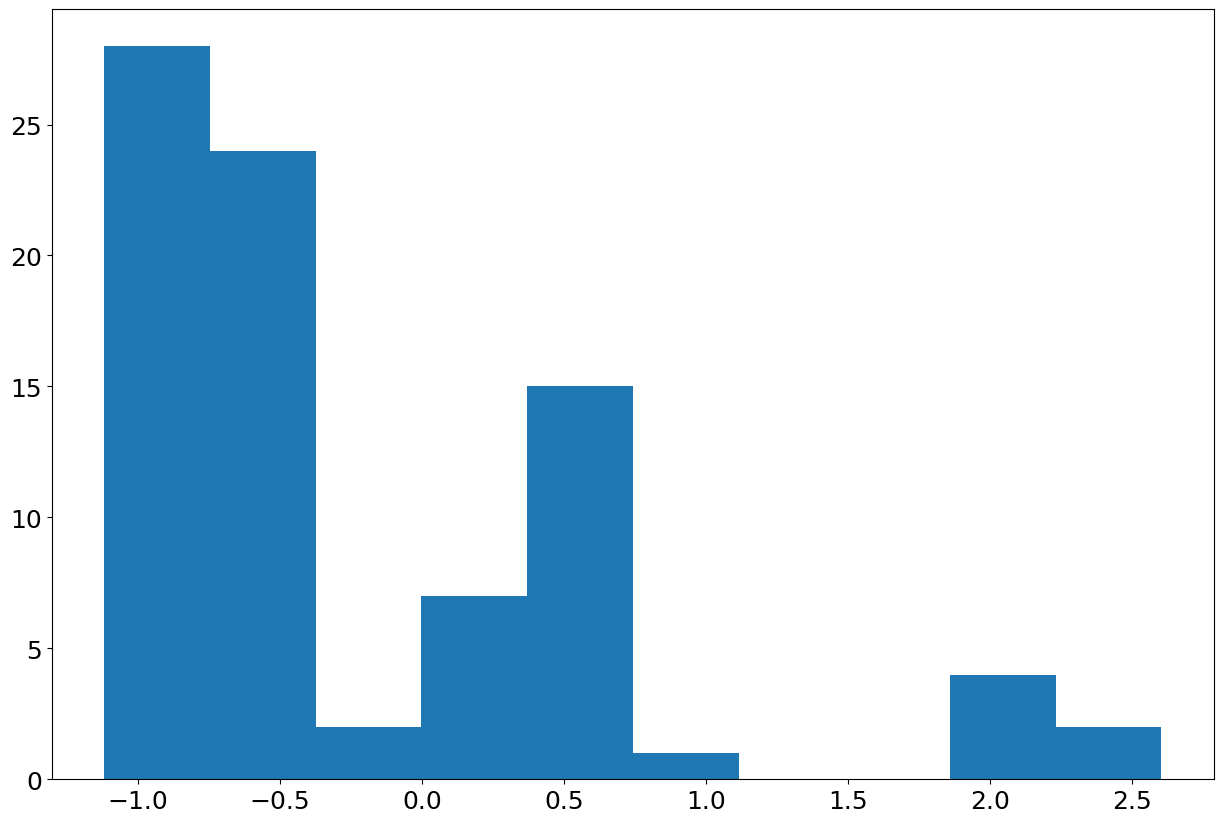

In [58]:
plt.hist(de.oni_7mths_psl)

In [59]:
de_hgh = de.where(de.oni_7mths_psl > 0.8,  drop=True)
de_low = de.where(de.oni_7mths_psl < -0.8, drop=True)

(-72.0, 72.0)

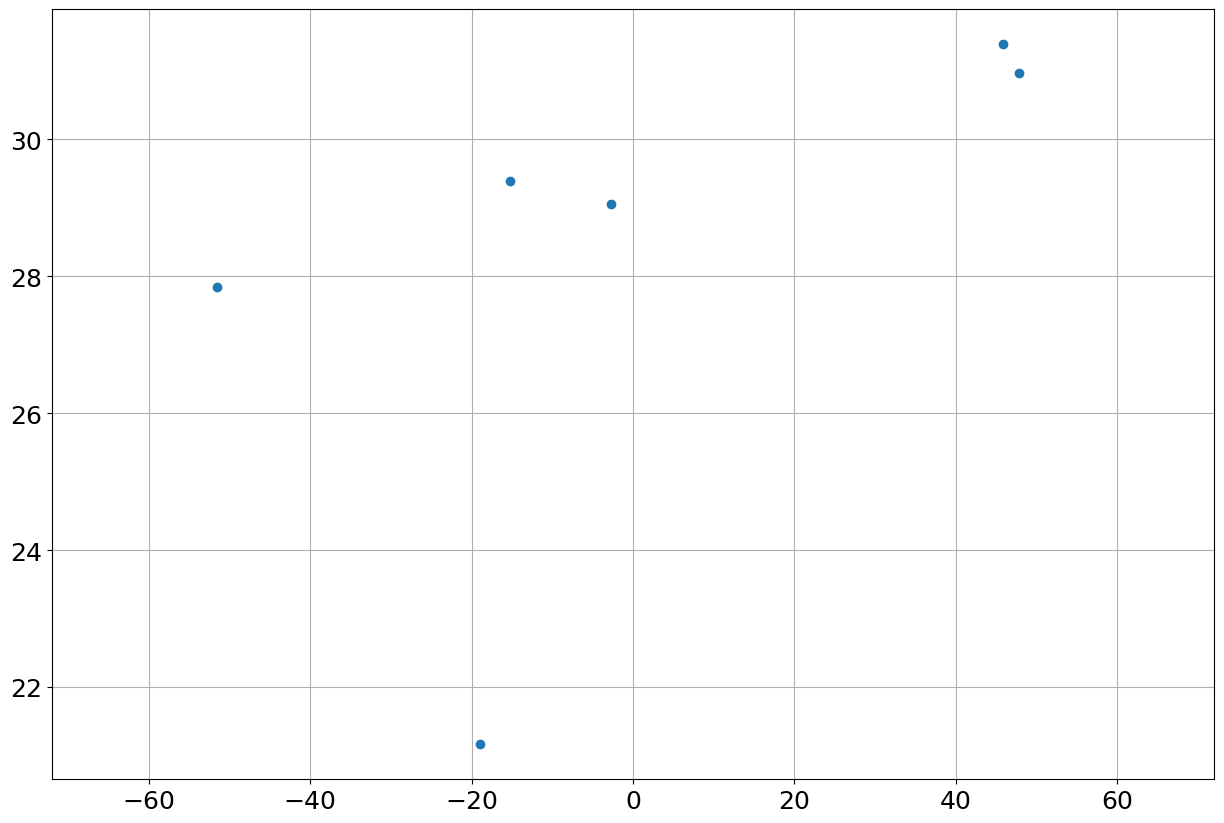

In [60]:
plt.scatter(de_hgh.t_since_lmi_ibt / 3600, de_hgh.uc)
plt.grid()
plt.xlim(-72, 72)

In [61]:
de_hgh.uc

<xarray.DataArray 'uc' (time: 6)>
array([30.97023993, 21.16763931, 27.83899465, 29.38457496, 29.04964083,
       31.38797818])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-08T02:46:14 ... 2016-09-02T03:53:41
Attributes:
    long_name:    Charac. velocity
    description:  np.sqrt(3 * np.sqrt(2) * dsg.vmx ** 2 / np.sqrt(dsg.B_hol *...
    units:        m/s

In [62]:
de_hgh.rsby

<xarray.DataArray 'rsby' (time: 6)>
array([25.00572465, 39.86328756, 32.15352646, 54.65218505, 57.74706327,
       49.94543448])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-08T02:46:14 ... 2016-09-02T03:53:41
Attributes:
    long_name:    Maximal Rossby number
    description:  Vmax / (f Rmax)

In [63]:
de_hgh.file

<xarray.DataArray 'file' (time: 6)>
array([array('rs2--owi-cm-20160708t024536-20160708t024652-00003-______sw.nc',
             dtype=object)                                                   ,
       array('rs2--owi-cm-20160724t140547-20160724t140702-00003-______sw.nc',
             dtype=object)                                                   ,
       array('rs2--owi-cm-20160829t022730-20160829t023009-00003-______sw.nc',
             dtype=object)                                                   ,
       array('s1a-ew-owi-cm-20160830t144512-20160830t144658-000003-0143DB_sw.nc',
             dtype=object)                                                       ,
       array('s1a-ew-owi-cm-20160831t031520-20160831t031712-000003-014425_sw.nc',
             dtype=object)                                                       ,
       array('rs2--owi-cm-20160902t035139-20160902t035544-00003-______sw.nc',
             dtype=object)                                                   ],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-08T02:46:14 ... 2016-09-02T03:53:41
Attributes:
    long_name:    Satellite file of the SAR acquisition
    description:  Taken from Ifremer TCVA product

(-72.0, 72.0)

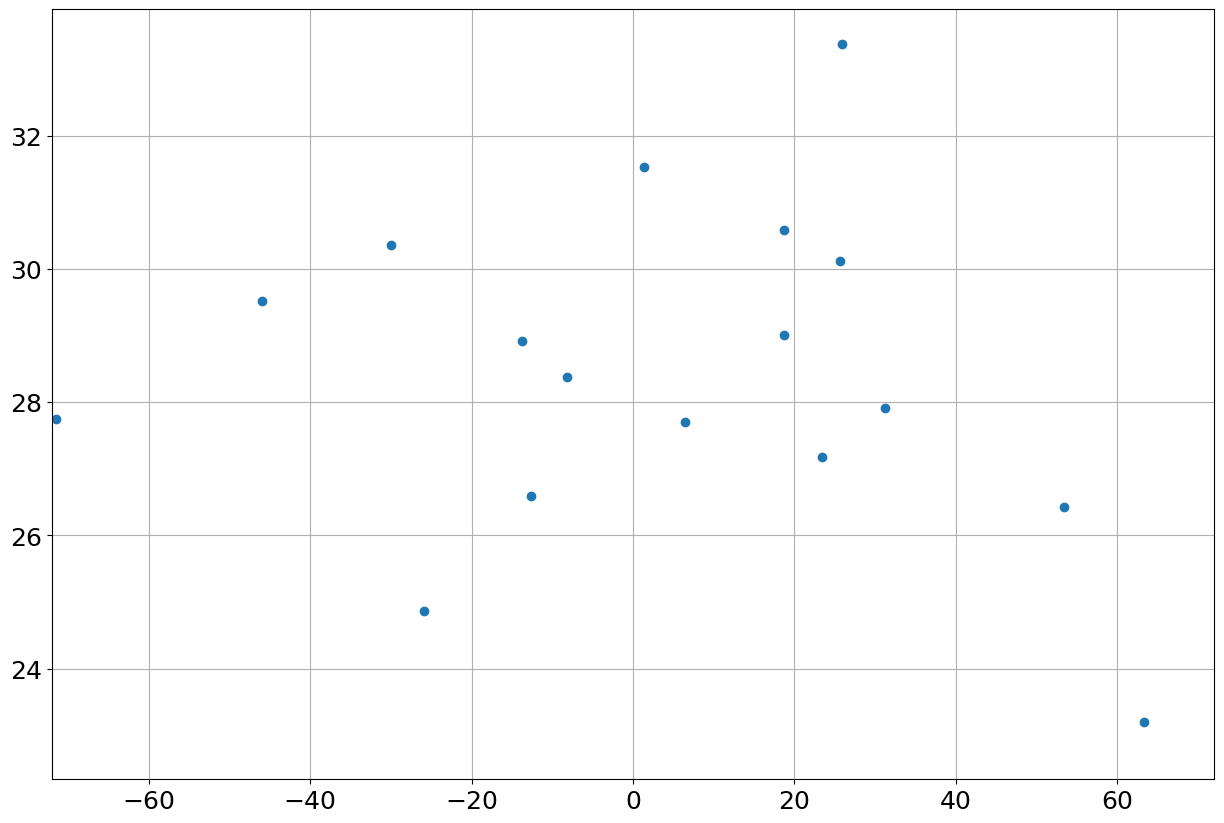

In [64]:
plt.scatter(de_low.t_since_lmi_ibt / 3600, de_low.uc)
plt.grid()
plt.xlim(-72, 72)

In [65]:
dle      = de.where((de.t_since_lmi_ibt / 3600 > -3 * hrs_thr) & (de.t_since_lmi_ibt / 3600 < 3 * hrs_thr), drop=True)

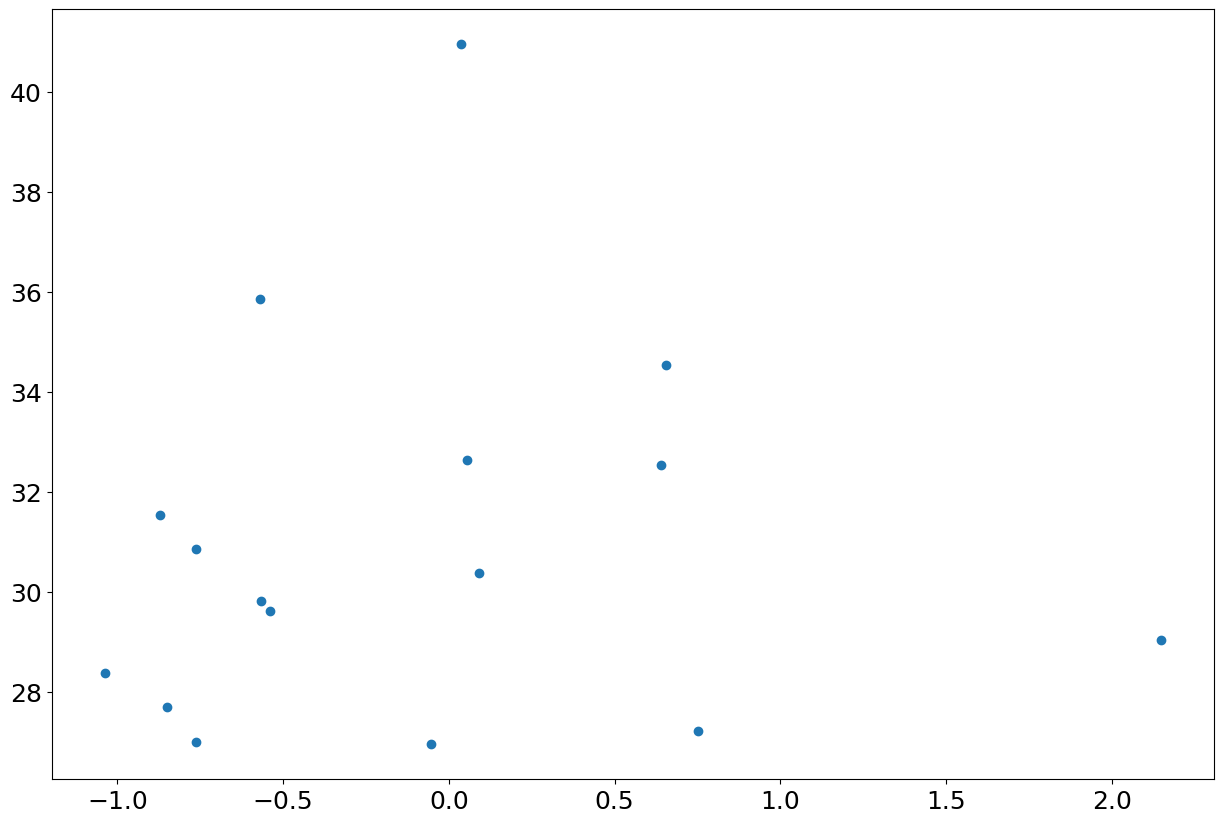

In [66]:
plt.scatter(dle.oni_7mths_psl, dle.uc)

### 7) Stationary cases

In [67]:
c_min = abs(d.dKdt).quantile(0.33)
d.where(d.dKdt < c_min, drop=True)

<xarray.Dataset>
Dimensions:              (time: 163)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T10:41:57 ... 2024-0...
    quantile             float64 0.33
Data variables: (12/76)
    dist2coast           (time) float64 8.115e+04 1.992e+05 ... 1.045e+05
    speed                (time) float64 5.97 5.511 6.246 ... 2.564 4.575 7.474
    name                 (time) object RUMBIA RAMMASUN ... EWINIAR EWINIAR
    id                   (time) object wp062013 wp092014 ... wp012024 wp012024
    file                 (time) object rs2--owi-cm-20130701t104119-20130701t1...
    file_tcva            (time) object rs2--owi-ca-20130701t104119-20130701t1...
    ...                   ...
    beta0_pmd            (time) float64 1.349e+04 1.326e+04 ... 1.73e+04
    beta0_T0_pmd         (time) float64 52.55 51.1 49.22 ... 53.28 63.65 63.96
    beta0                (time) float64 411.3 532.1 950.0 ... 212.9 282.1 569.8
    beta0_T0             (time) float64 1.566 2.022 3.607 ... 0.8107 1.073 2.171
    dKdt                 (time) float64 -0.03188 -0.1493 ... 0.08561 0.0788
    basin_idx            (time) float64 3.0 3.0 3.0 3.0 2.0 ... 5.0 3.0 3.0 3.0
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-09-08T06:24:...

Text(0, 0.5, 'Uc (m/s)')

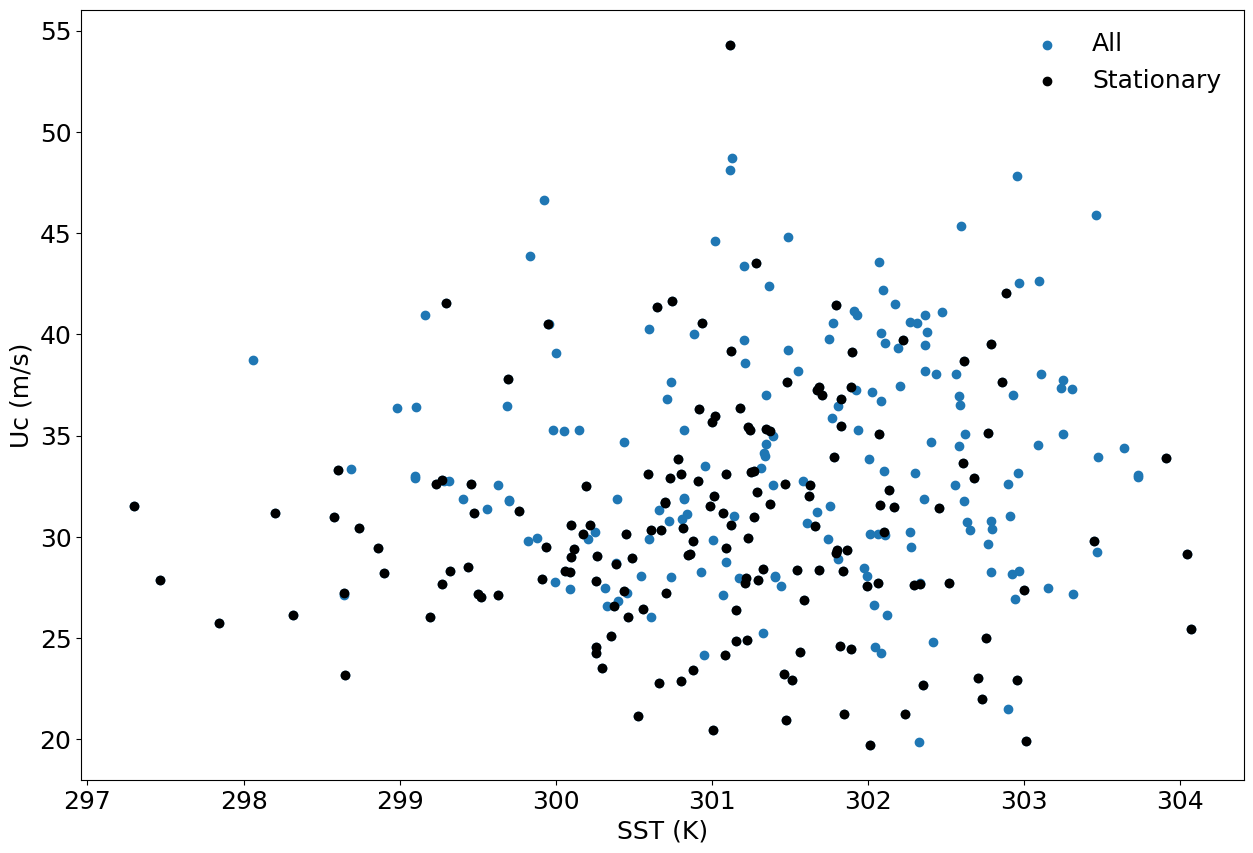

In [68]:
plt.scatter(d.sst_rms, d.uc, label='All')
plt.scatter(d.where(d.dKdt < c_min, drop=True).sst_rms, d.where(d.dKdt < c_min, drop=True).uc, c='k', label='Stationary')
plt.legend(frameon=False)
plt.xlabel('SST (K)')
plt.ylabel('Uc (m/s)')

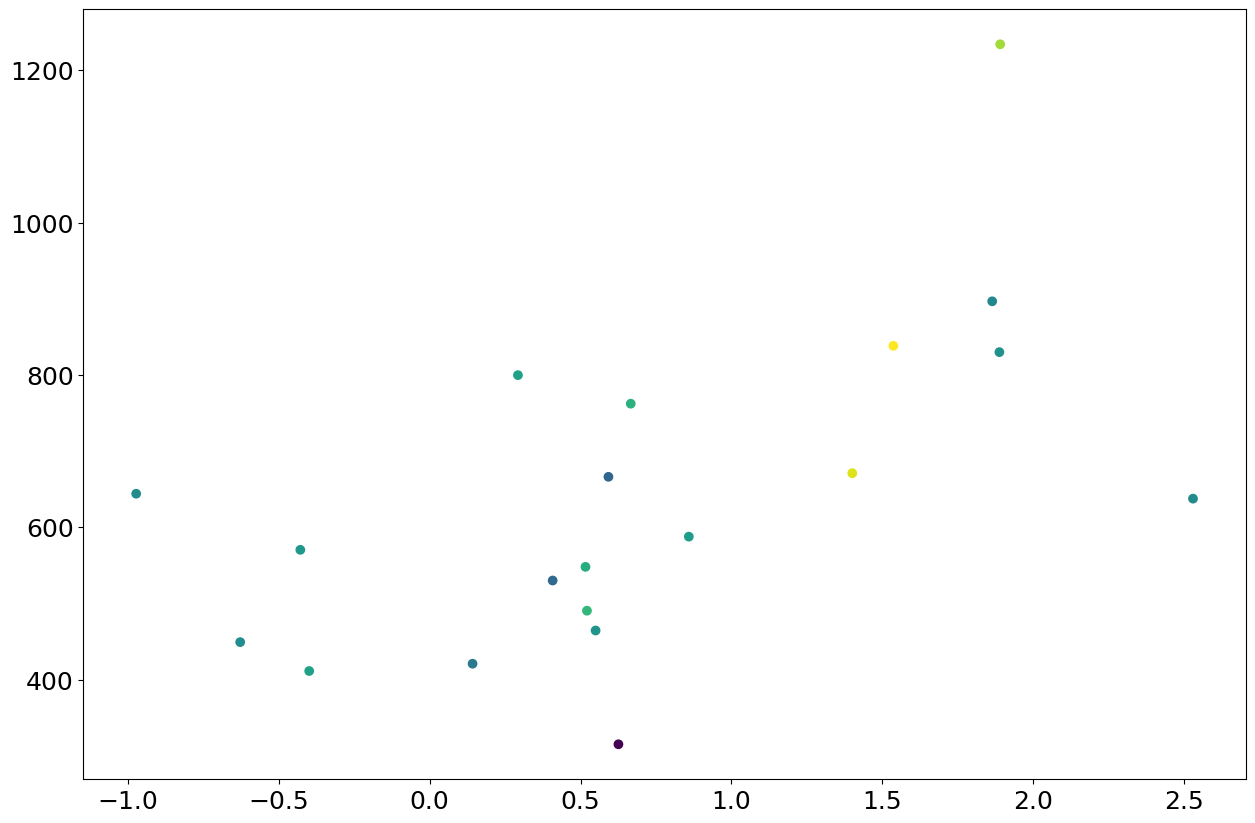

In [69]:
plt.scatter(dl.oni_psl, dl.beta0, c=abs(dl.fcor))

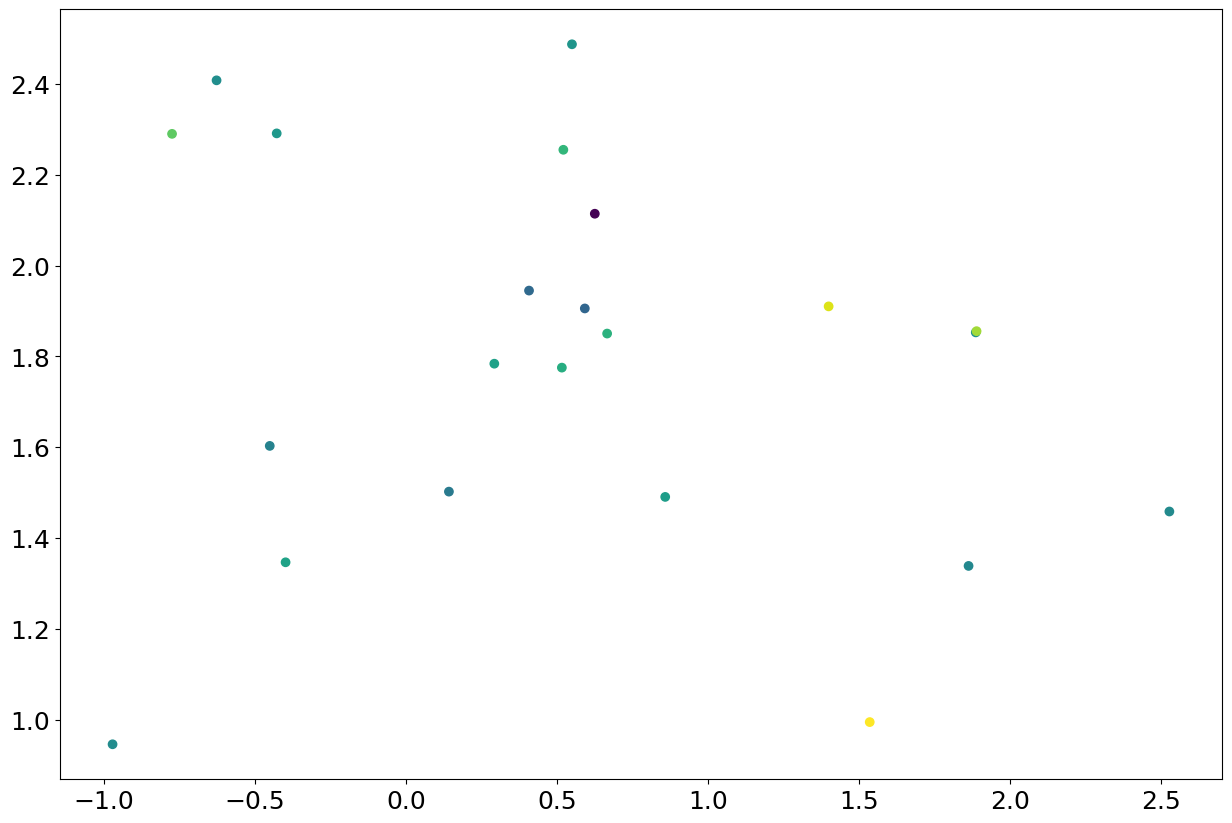

In [70]:
plt.scatter(dl.oni_psl, dl.B_hol, c=abs(dl.fcor))

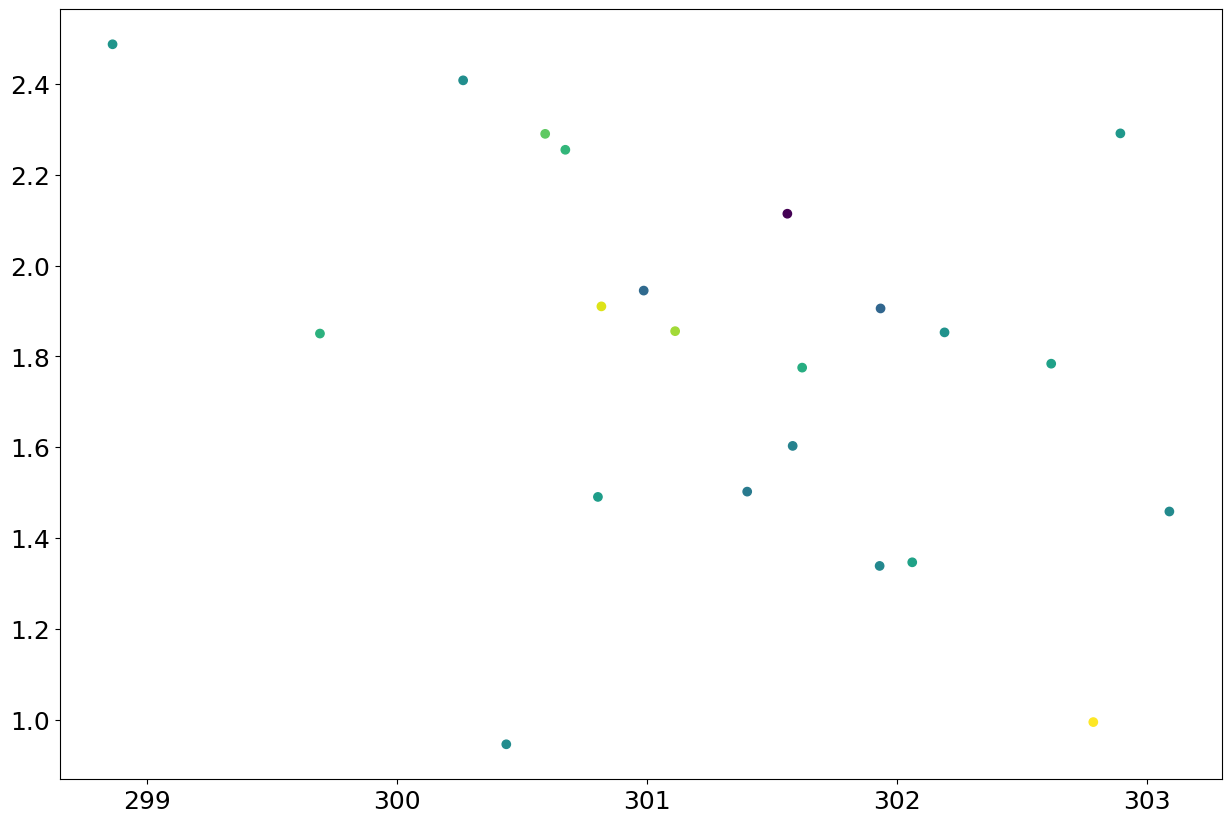

In [71]:
plt.scatter(dl.sst_rms, dl.B_hol, c=abs(dl.fcor))

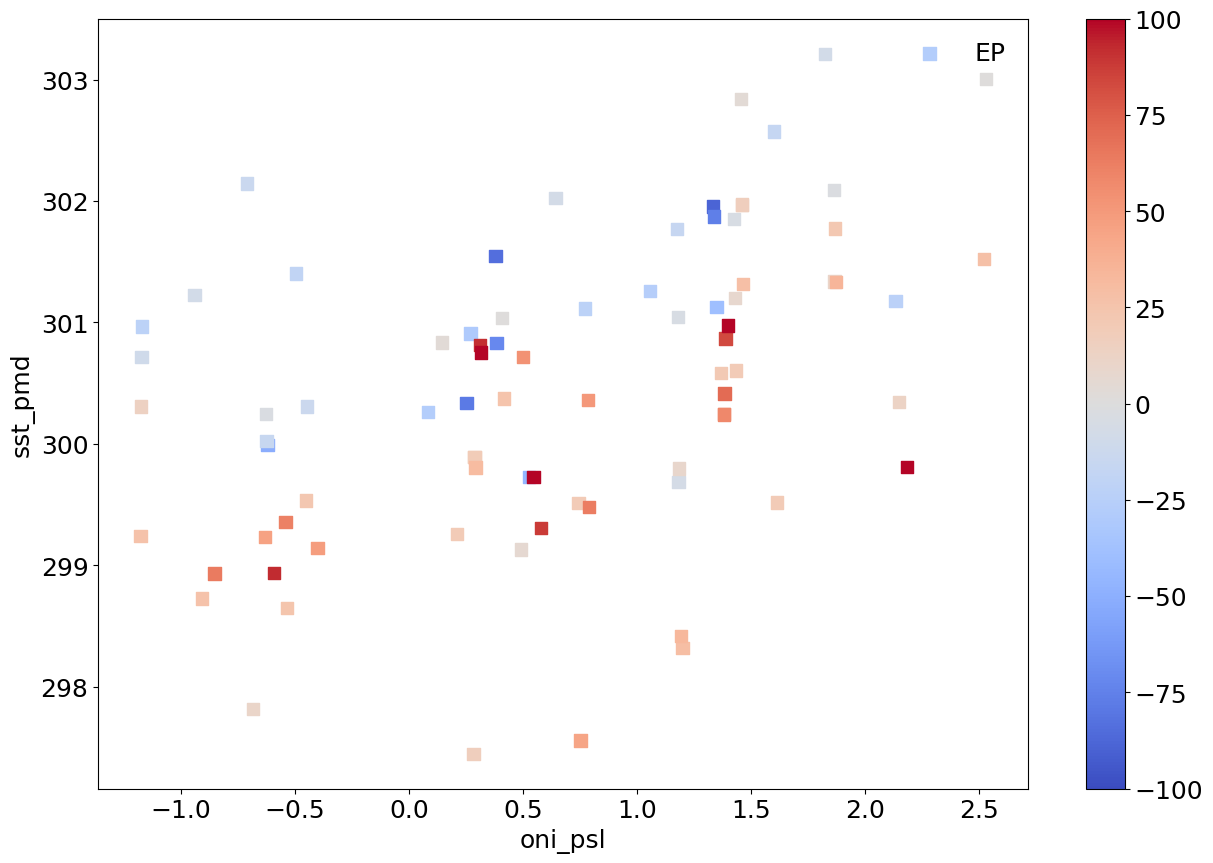

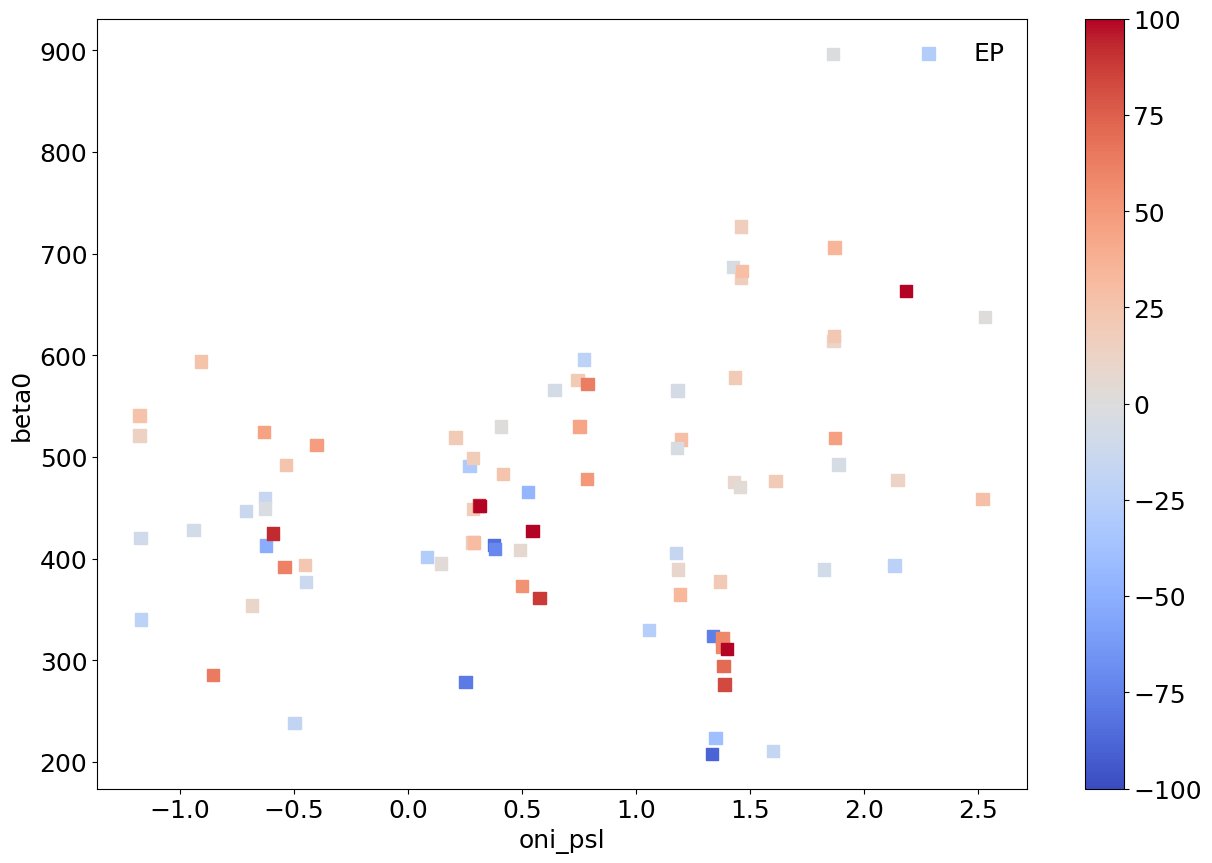

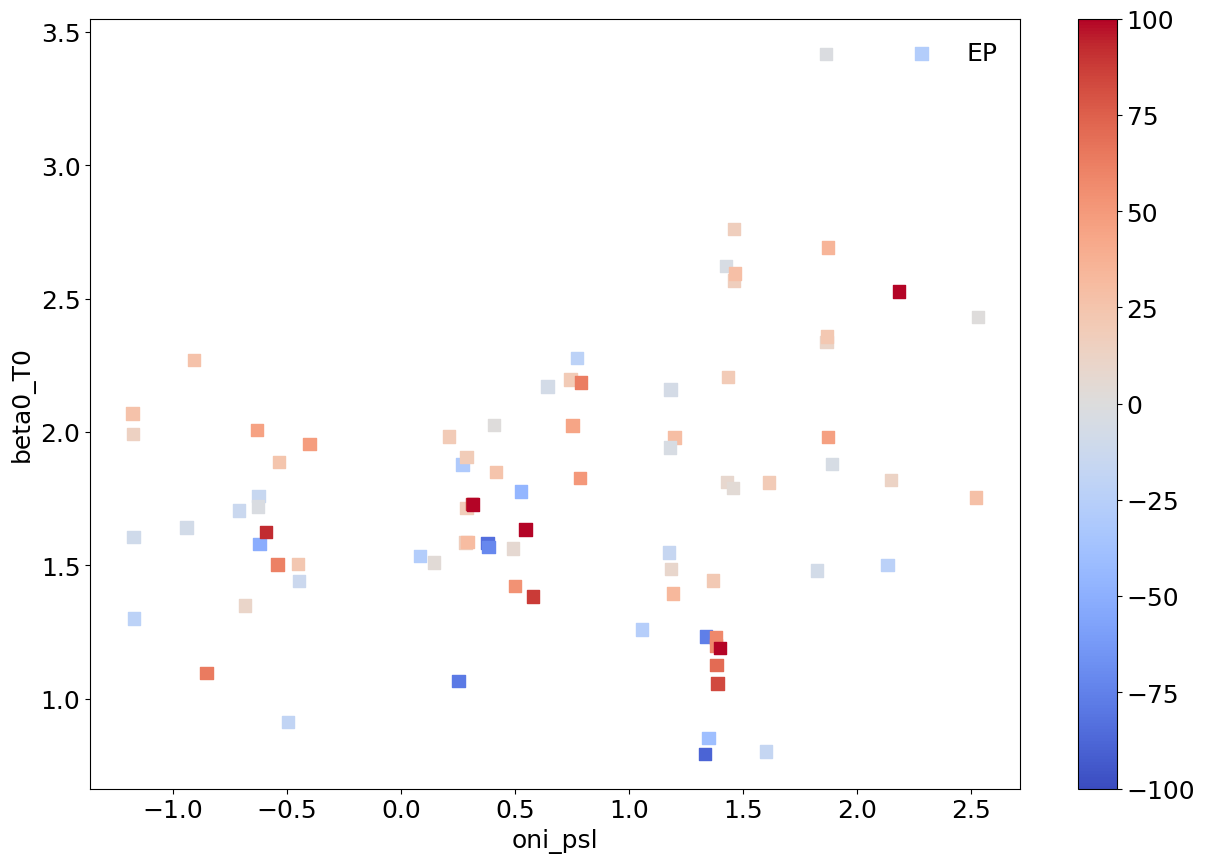

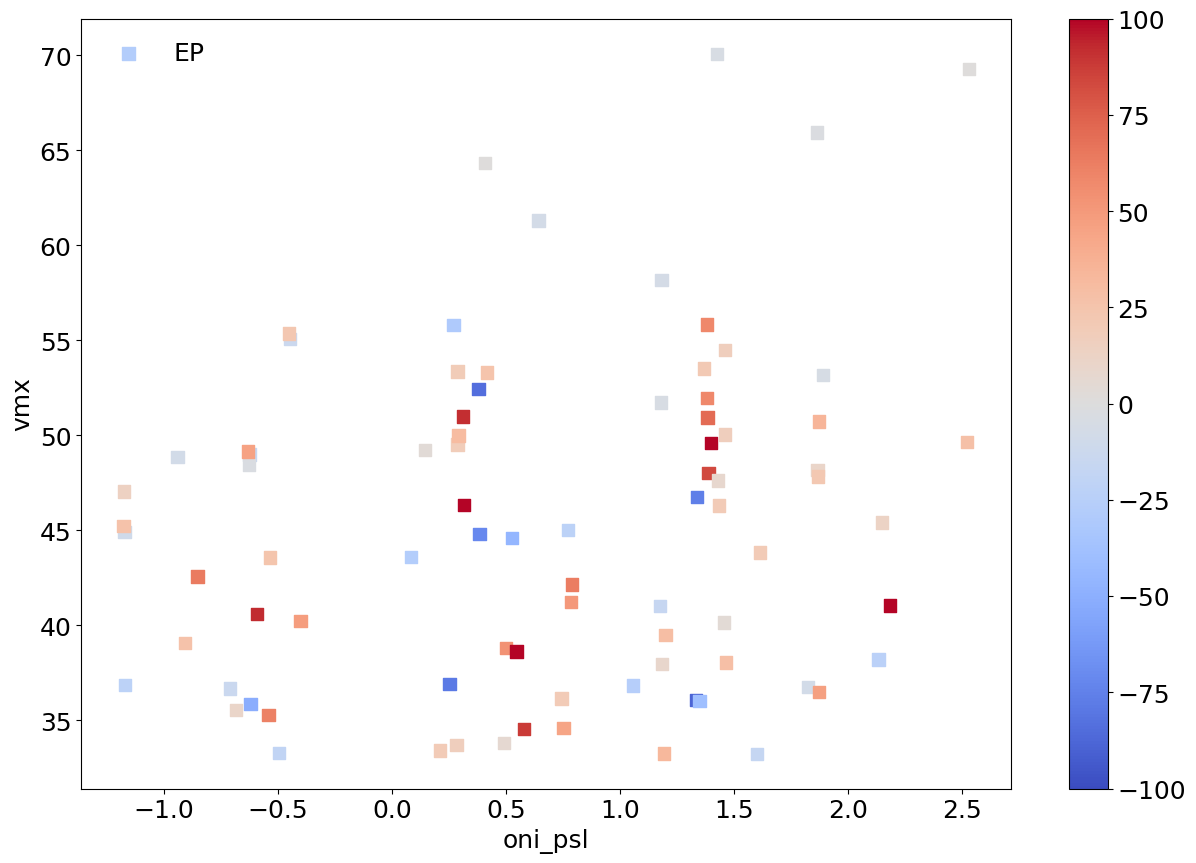

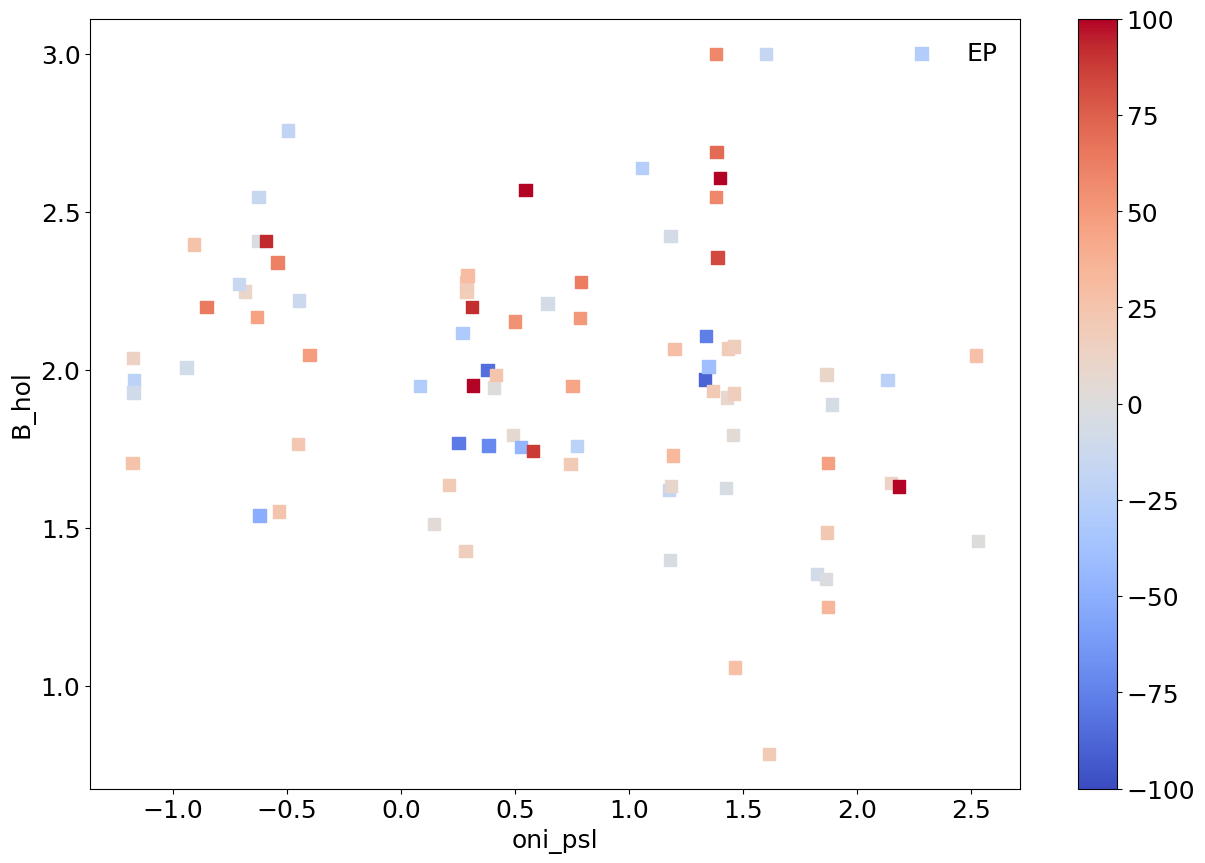

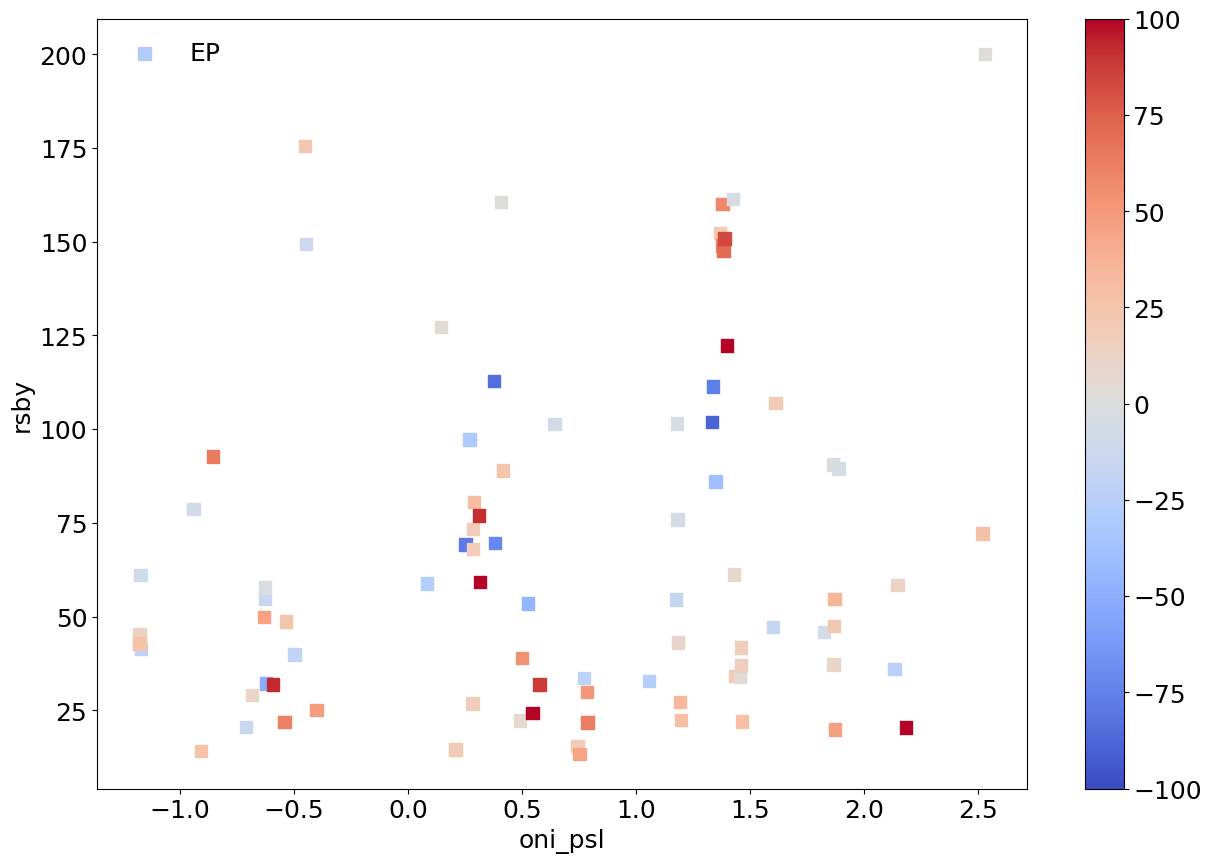

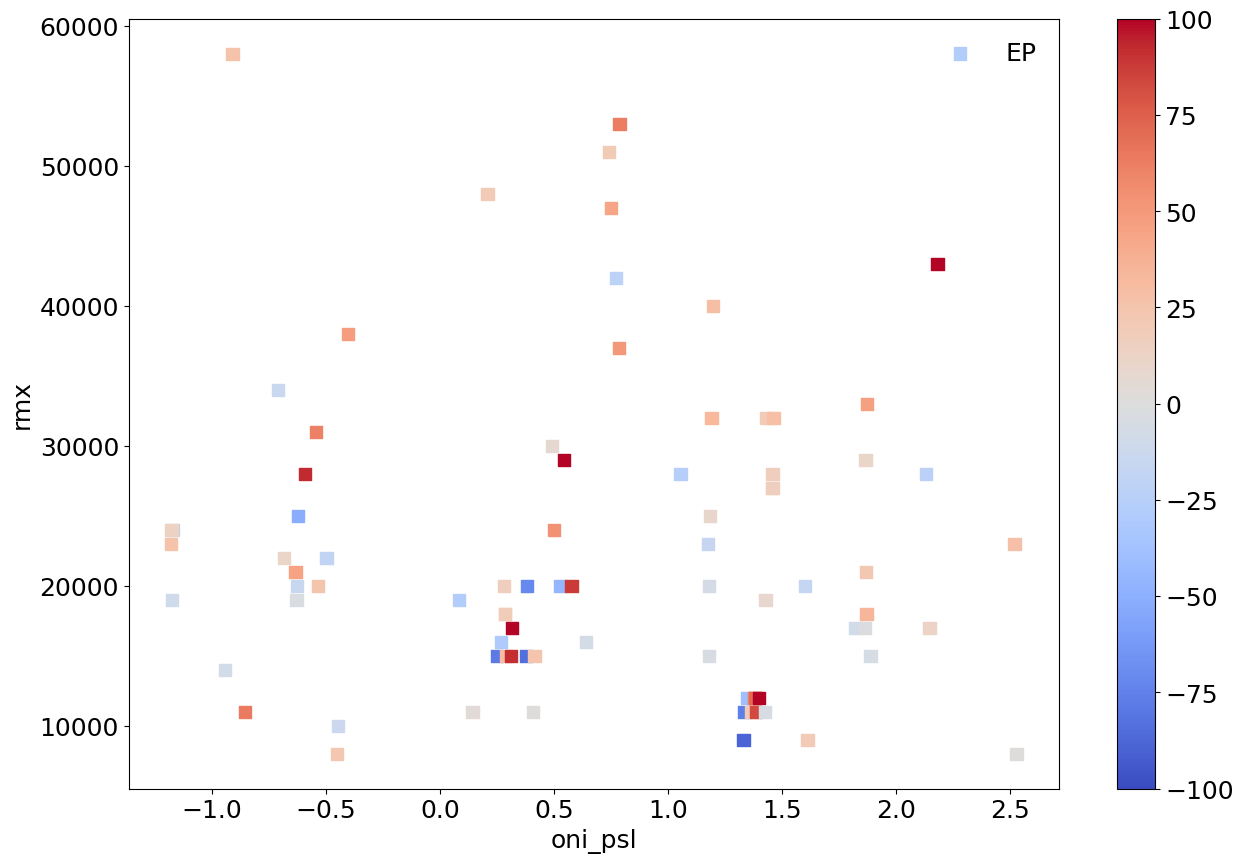

In [72]:
x = 'oni_psl'

for prm in ['sst_pmd', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(de[x], de[prm], c=de.t_since_lmi_ibt / 3600, marker='s', s=80, label='EP', cmap=cm.get_cmap('coolwarm'), vmin=-100, vmax=100)
    plt.colorbar()
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

(array([ 3.,  4., 13., 19., 31., 17., 10.,  5.,  5.,  1.]),
 array([-104.11500001,  -81.06805557,  -58.02111112,  -34.97416668,
         -11.92722223,   11.11972221,   34.16666666,   57.2136111 ,
          80.26055554,  103.30749999,  126.35444443]),
 <BarContainer object of 10 artists>)

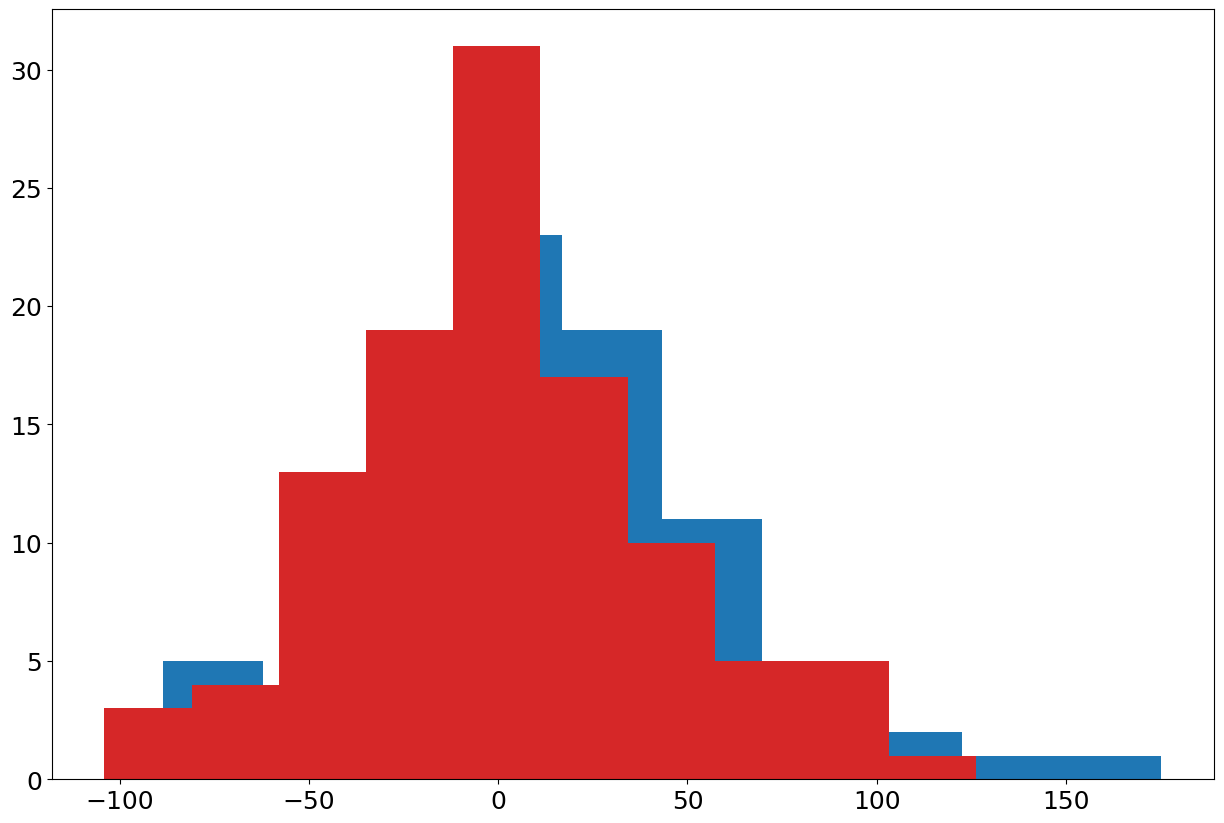

In [73]:
plt.hist(d.where(d.basin == 'ep', drop=True).t_since_lmi_ibt / 3600)
plt.hist(d.where(d.basin == 'wp', drop=True).t_since_lmi_ibt / 3600, color='tab:red')